In [15]:
import pandas as pd
import numpy as np
from xbbg import blp
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 1: DATA ACQUISITION - 10Y TREASURY FUTURES PATTERN DISCOVERY")
print("="*80)

# Define date range: 10 years back from today
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)

print(f"\nData Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print("\n" + "-"*80)

# ============================================================================
# 1. PRIMARY DATA: 10Y TREASURY FUTURES
# ============================================================================
print("\n1. Fetching 10Y Treasury Futures (TY1 Comdty)...")

try:
    # Fetch TY1 Comdty - Front month 10Y Treasury futures
    ty_data = blp.bdh(
        tickers='TY1 Comdty',
        flds=['PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'PX_VOLUME', 'OPEN_INT'],
        start_date=start_date,
        end_date=end_date
    )
    
    # Flatten multi-index columns
    ty_data.columns = ['_'.join(col).strip() for col in ty_data.columns.values]
    ty_data.columns = ['open', 'high', 'low', 'close', 'volume', 'open_interest']
    
    print(f"   ✓ Retrieved {len(ty_data)} observations")
    print(f"   Date range: {ty_data.index[0]} to {ty_data.index[-1]}")
    print(f"   Missing values: {ty_data.isnull().sum().sum()}")
    
except Exception as e:
    print(f"   ✗ Error fetching TY1: {e}")
    ty_data = pd.DataFrame()

# ============================================================================
# 2. CONTEXTUAL DATA: MARKET INDICATORS
# ============================================================================
print("\n2. Fetching Market Context Indicators...")

context_tickers = {
    'VIX Index': 'VIX',           # Equity volatility
    'SPX Index': 'SPX',           # S&P 500
    'DXY Index': 'DXY',           # Dollar index
    'USGG2YR Index': '2Y',        # 2Y Treasury yield
    'USGG5YR Index': '5Y',        # 5Y Treasury yield  
    'USGG10YR Index': '10Y',      # 10Y Treasury yield
    'USGG30YR Index': '30Y',      # 30Y Treasury yield
}

context_data = pd.DataFrame(index=ty_data.index)

for ticker, label in context_tickers.items():
    try:
        data = blp.bdh(
            tickers=ticker,
            flds='PX_LAST',
            start_date=start_date,
            end_date=end_date
        )
        if not data.empty:
            context_data[label] = data.iloc[:, 0]
            print(f"   ✓ {label:6s} - {len(data)} obs, {data.isnull().sum().sum()} missing")
    except Exception as e:
        print(f"   ✗ {label:6s} - Error: {e}")

# ============================================================================
# 3. FED FUNDS RATE
# ============================================================================
print("\n3. Fetching Fed Funds Rate...")

try:
    fedfunds = blp.bdh(
        tickers='FDTR Index',
        flds='PX_LAST',
        start_date=start_date,
        end_date=end_date
    )
    if not fedfunds.empty:
        context_data['FedFunds'] = fedfunds.iloc[:, 0]
        print(f"   ✓ Retrieved {len(fedfunds)} observations")
except Exception as e:
    print(f"   ✗ Error: {e}")

# ============================================================================
# 4. DATA QUALITY ASSESSMENT
# ============================================================================
print("\n" + "-"*80)
print("DATA QUALITY ASSESSMENT")
print("-"*80)

print("\n10Y Treasury Futures (TY1 Comdty):")
print(f"  Total observations: {len(ty_data)}")
print(f"  Date range: {ty_data.index[0].strftime('%Y-%m-%d')} to {ty_data.index[-1].strftime('%Y-%m-%d')}")
print(f"  Price range: ${ty_data['close'].min():.4f} to ${ty_data['close'].max():.4f}")
print(f"\n  Missing values by field:")
for col in ty_data.columns:
    missing = ty_data[col].isnull().sum()
    pct = 100 * missing / len(ty_data)
    print(f"    {col:15s}: {missing:4d} ({pct:.1f}%)")

print("\n\nContext Data Summary:")
print(f"  Total fields: {len(context_data.columns)}")
print(f"  Date range: {context_data.index[0].strftime('%Y-%m-%d')} to {context_data.index[-1].strftime('%Y-%m-%d')}")
print(f"\n  Missing values by field:")
for col in context_data.columns:
    missing = context_data[col].isnull().sum()
    pct = 100 * missing / len(context_data)
    print(f"    {col:12s}: {missing:4d} ({pct:.1f}%)")

# ============================================================================
# 5. HANDLE MISSING DATA
# ============================================================================
print("\n" + "-"*80)
print("HANDLING MISSING DATA")
print("-"*80)

# Forward fill context data (market indicators can use last known value)
context_data_filled = context_data.fillna(method='ffill')

# For TY data, we need to be more careful
ty_data_clean = ty_data.copy()

# Check for any gaps in TY data
if ty_data_clean.isnull().sum().sum() > 0:
    print("\nFilling TY futures data:")
    for col in ty_data_clean.columns:
        before = ty_data_clean[col].isnull().sum()
        if before > 0:
            ty_data_clean[col] = ty_data_clean[col].fillna(method='ffill')
            after = ty_data_clean[col].isnull().sum()
            print(f"  {col:15s}: {before} → {after} missing")

# ============================================================================
# 6. MERGE AND SAVE
# ============================================================================
print("\n" + "-"*80)
print("MERGING DATA")
print("-"*80)

# Combine TY and context data
full_data = pd.concat([ty_data_clean, context_data_filled], axis=1)

print(f"\nCombined dataset shape: {full_data.shape}")
print(f"Date range: {full_data.index[0].strftime('%Y-%m-%d')} to {full_data.index[-1].strftime('%Y-%m-%d')}")
print(f"Total missing values: {full_data.isnull().sum().sum()}")

# ============================================================================
# 7. BASIC STATISTICS
# ============================================================================
print("\n" + "-"*80)
print("BASIC STATISTICS")
print("-"*80)

print("\nTY1 Futures Price Statistics:")
print(ty_data_clean['close'].describe())

print("\n\nDaily Returns Statistics:")
returns = ty_data_clean['close'].pct_change()
print(f"  Mean:      {returns.mean()*100:.4f}%")
print(f"  Std Dev:   {returns.std()*100:.4f}%")
print(f"  Sharpe:    {(returns.mean()/returns.std())*np.sqrt(252):.2f}")
print(f"  Skewness:  {returns.skew():.2f}")
print(f"  Kurtosis:  {returns.kurtosis():.2f}")
print(f"  Min:       {returns.min()*100:.2f}%")
print(f"  Max:       {returns.max()*100:.2f}%")

# ============================================================================
# 8. EXPORT DATA
# ============================================================================
print("\n" + "="*80)
print("DATA ACQUISITION COMPLETE")
print("="*80)

print("\nExporting datasets...")
print("  - ty_data_clean: Clean TY futures OHLCV data")
print("  - context_data_filled: Market context indicators")
print("  - full_data: Combined dataset")

print("\nReady for Phase 2: Feature Engineering")
print("="*80)

PHASE 1: DATA ACQUISITION - 10Y TREASURY FUTURES PATTERN DISCOVERY

Data Range: 2015-12-12 to 2025-12-09

--------------------------------------------------------------------------------

1. Fetching 10Y Treasury Futures (TY1 Comdty)...
   ✓ Retrieved 2528 observations
   Date range: 2015-12-14 to 2025-12-09
   Missing values: 64

2. Fetching Market Context Indicators...
   ✓ VIX    - 2539 obs, 0 missing
   ✓ SPX    - 2512 obs, 0 missing
   ✓ DXY    - 2599 obs, 0 missing
   ✓ 2Y     - 2605 obs, 0 missing
   ✓ 5Y     - 2605 obs, 0 missing
   ✓ 10Y    - 2605 obs, 0 missing
   ✓ 30Y    - 2605 obs, 0 missing

3. Fetching Fed Funds Rate...
   ✓ Retrieved 2607 observations

--------------------------------------------------------------------------------
DATA QUALITY ASSESSMENT
--------------------------------------------------------------------------------

10Y Treasury Futures (TY1 Comdty):
  Total observations: 2528
  Date range: 2015-12-14 to 2025-12-09
  Price range: $107.3281 to $140.18

In [16]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 2: FEATURE ENGINEERING - 10Y TREASURY FUTURES")
print("="*80)

# ============================================================================
# 1. BASIC RETURNS AT MULTIPLE HORIZONS
# ============================================================================
print("\n1. Computing Returns at Multiple Horizons...")

features = pd.DataFrame(index=full_data.index)

# Price and returns
features['price'] = full_data['close']
features['ret_1d'] = full_data['close'].pct_change()
features['ret_2d'] = full_data['close'].pct_change(2)
features['ret_5d'] = full_data['close'].pct_change(5)
features['ret_10d'] = full_data['close'].pct_change(10)
features['ret_20d'] = full_data['close'].pct_change(20)

# Log returns
features['log_ret_1d'] = np.log(full_data['close'] / full_data['close'].shift(1))
features['log_ret_5d'] = np.log(full_data['close'] / full_data['close'].shift(5))
features['log_ret_20d'] = np.log(full_data['close'] / full_data['close'].shift(20))

print(f"   ✓ Created {9} return features")

# ============================================================================
# 2. VOLATILITY MEASURES
# ============================================================================
print("\n2. Computing Volatility Measures...")

# Realized volatility (rolling std of returns)
features['vol_5d'] = features['ret_1d'].rolling(5).std() * np.sqrt(252)
features['vol_10d'] = features['ret_1d'].rolling(10).std() * np.sqrt(252)
features['vol_20d'] = features['ret_1d'].rolling(20).std() * np.sqrt(252)
features['vol_60d'] = features['ret_1d'].rolling(60).std() * np.sqrt(252)

# Parkinson volatility (high-low range estimator)
parkinson = np.log(full_data['high'] / full_data['low']) ** 2
features['parkinson_vol_20d'] = np.sqrt(parkinson.rolling(20).mean() / (4 * np.log(2))) * np.sqrt(252)

# Volatility of volatility
features['vol_of_vol_20d'] = features['vol_20d'].rolling(20).std()

# Change in volatility
features['vol_change_5d'] = features['vol_20d'].diff(5)
features['vol_change_20d'] = features['vol_20d'].diff(20)

print(f"   ✓ Created {8} volatility features")

# ============================================================================
# 3. RANGE AND MOMENTUM INDICATORS
# ============================================================================
print("\n3. Computing Range and Momentum Indicators...")

# True Range and ATR
high = full_data['high']
low = full_data['low']
close = full_data['close']
prev_close = close.shift(1)

tr1 = high - low
tr2 = abs(high - prev_close)
tr3 = abs(low - prev_close)
true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

features['atr_14d'] = true_range.rolling(14).mean()
features['atr_20d'] = true_range.rolling(20).mean()

# High-low ratio
features['hl_ratio'] = (high - low) / close
features['hl_ratio_5d'] = features['hl_ratio'].rolling(5).mean()

# Momentum
features['mom_5d'] = close - close.shift(5)
features['mom_10d'] = close - close.shift(10)
features['mom_20d'] = close - close.shift(20)
features['mom_60d'] = close - close.shift(60)

# Rate of change
features['roc_10d'] = (close - close.shift(10)) / close.shift(10)
features['roc_20d'] = (close - close.shift(20)) / close.shift(20)

print(f"   ✓ Created {10} range/momentum features")

# ============================================================================
# 4. MOVING AVERAGES AND CROSSOVERS
# ============================================================================
print("\n4. Computing Moving Averages...")

# Simple moving averages
for window in [5, 10, 20, 50, 100, 200]:
    features[f'sma_{window}d'] = close.rolling(window).mean()

# Distance from moving averages (normalized)
features['dist_sma_20'] = (close - features['sma_20d']) / features['sma_20d']
features['dist_sma_50'] = (close - features['sma_50d']) / features['sma_50d']
features['dist_sma_200'] = (close - features['sma_200d']) / features['sma_200d']

# Moving average slopes
features['sma_20_slope'] = features['sma_20d'].diff(5) / features['sma_20d'].shift(5)
features['sma_50_slope'] = features['sma_50d'].diff(10) / features['sma_50d'].shift(10)

# Crossovers
features['sma_cross_20_50'] = (features['sma_20d'] > features['sma_50d']).astype(int)
features['sma_cross_50_200'] = (features['sma_50d'] > features['sma_200d']).astype(int)

print(f"   ✓ Created {13} moving average features")

# ============================================================================
# 5. MEAN REVERSION INDICATORS
# ============================================================================
print("\n5. Computing Mean Reversion Indicators...")

# Z-scores (distance from mean in standard deviations)
features['zscore_20d'] = (close - close.rolling(20).mean()) / close.rolling(20).std()
features['zscore_60d'] = (close - close.rolling(60).mean()) / close.rolling(60).std()

# RSI-like momentum oscillator
def compute_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

features['rsi_14d'] = compute_rsi(close, 14)
features['rsi_20d'] = compute_rsi(close, 20)

# Bollinger Band position
bb_middle = close.rolling(20).mean()
bb_std = close.rolling(20).std()
features['bb_position'] = (close - bb_middle) / (2 * bb_std)

print(f"   ✓ Created {5} mean reversion features")

# ============================================================================
# 6. VOLUME AND OPEN INTEREST
# ============================================================================
print("\n6. Computing Volume Features...")

volume = full_data['volume']
open_int = full_data['open_interest']

# Volume features
features['volume'] = volume
features['volume_sma_20'] = volume.rolling(20).mean()
features['volume_ratio'] = volume / features['volume_sma_20']
features['volume_change'] = volume.pct_change()

# Open interest features
features['open_interest'] = open_int
features['oi_change'] = open_int.pct_change()
features['oi_change_5d'] = open_int.pct_change(5)

# Price-volume relationship
features['price_vol_corr_20d'] = features['ret_1d'].rolling(20).corr(features['volume_change'])

print(f"   ✓ Created {8} volume/OI features")

# ============================================================================
# 7. CALENDAR AND SEASONAL FEATURES
# ============================================================================
print("\n7. Computing Calendar Features...")

# Ensure index is datetime
if not isinstance(features.index, pd.DatetimeIndex):
    features.index = pd.to_datetime(features.index)

# Day of week
features['dow'] = features.index.dayofweek
features['is_monday'] = (features['dow'] == 0).astype(int)
features['is_friday'] = (features['dow'] == 4).astype(int)

# Month
features['month'] = features.index.month
features['is_jan'] = (features['month'] == 1).astype(int)
features['is_dec'] = (features['month'] == 12).astype(int)

# Quarter
features['quarter'] = features.index.quarter

# End of month/quarter
features['is_month_end'] = (features.index.day >= 25).astype(int)

print(f"   ✓ Created {8} calendar features")

# ============================================================================
# 8. CROSS-ASSET FEATURES
# ============================================================================
print("\n8. Computing Cross-Asset Features...")

# VIX features
if 'VIX' in full_data.columns:
    features['vix'] = full_data['VIX']
    features['vix_change'] = full_data['VIX'].diff()
    features['vix_pct_change'] = full_data['VIX'].pct_change()
    features['vix_20d_change'] = full_data['VIX'].diff(20)
    features['vix_high'] = (full_data['VIX'] > 20).astype(int)
    features['vix_spike'] = (features['vix_change'] > 2).astype(int)
    
# SPX features
if 'SPX' in full_data.columns:
    features['spx_ret'] = full_data['SPX'].pct_change()
    features['spx_ret_5d'] = full_data['SPX'].pct_change(5)
    
    # Correlation between TY and SPX
    features['ty_spx_corr_20d'] = features['ret_1d'].rolling(20).corr(features['spx_ret'])
    features['ty_spx_corr_60d'] = features['ret_1d'].rolling(60).corr(features['spx_ret'])

# Dollar index
if 'DXY' in full_data.columns:
    features['dxy_ret'] = full_data['DXY'].pct_change()
    features['dxy_ret_5d'] = full_data['DXY'].pct_change(5)

print(f"   ✓ Created cross-asset features")

# ============================================================================
# 9. YIELD CURVE FEATURES
# ============================================================================
print("\n9. Computing Yield Curve Features...")

if all(col in full_data.columns for col in ['2Y', '10Y']):
    # Curve steepness
    features['curve_2s10s'] = full_data['10Y'] - full_data['2Y']
    features['curve_2s10s_change'] = features['curve_2s10s'].diff()
    features['curve_2s10s_change_5d'] = features['curve_2s10s'].diff(5)
    
    # Steepening/flattening
    features['curve_steepening'] = (features['curve_2s10s_change'] > 0).astype(int)
    
if all(col in full_data.columns for col in ['5Y', '30Y']):
    features['curve_5s30s'] = full_data['30Y'] - full_data['5Y']
    
# 10Y yield level and changes
if '10Y' in full_data.columns:
    features['yield_10y'] = full_data['10Y']
    features['yield_10y_change'] = full_data['10Y'].diff()
    features['yield_10y_change_5d'] = full_data['10Y'].diff(5)
    features['yield_10y_change_20d'] = full_data['10Y'].diff(20)

print(f"   ✓ Created yield curve features")

# ============================================================================
# 10. FED POLICY FEATURES
# ============================================================================
print("\n10. Computing Fed Policy Features...")

if 'FedFunds' in full_data.columns:
    features['fed_funds'] = full_data['FedFunds']
    features['fed_funds_change'] = full_data['FedFunds'].diff()
    features['fed_funds_change_20d'] = full_data['FedFunds'].diff(20)
    
    # Rate regime
    features['fed_hiking'] = (features['fed_funds_change_20d'] > 0.1).astype(int)
    features['fed_cutting'] = (features['fed_funds_change_20d'] < -0.1).astype(int)
    features['fed_pause'] = ((features['fed_funds_change_20d'].abs() <= 0.1)).astype(int)

print(f"   ✓ Created Fed policy features")

# ============================================================================
# 11. INTERACTION AND DERIVED FEATURES
# ============================================================================
print("\n11. Computing Interaction Features...")

# Volatility regime
features['high_vol_regime'] = (features['vol_20d'] > features['vol_20d'].rolling(60).mean()).astype(int)
features['low_vol_regime'] = (features['vol_20d'] < features['vol_20d'].rolling(60).quantile(0.3)).astype(int)

# Trend strength
features['trend_strength_20d'] = abs(features['sma_20_slope'])

# Price momentum in high vol
features['mom_high_vol'] = features['mom_20d'] * features['high_vol_regime']

# VIX-weighted returns
if 'vix' in features.columns:
    features['ret_vix_adjusted'] = features['ret_1d'] / (features['vix'] / 15)

print(f"   ✓ Created {5} interaction features")

# ============================================================================
# 12. LAGGED FEATURES FOR PREDICTION
# ============================================================================
print("\n12. Creating Lagged Features...")

# Lag key features for prediction
lag_features = ['ret_1d', 'ret_5d', 'vol_20d', 'mom_20d', 'rsi_14d']

for feat in lag_features:
    if feat in features.columns:
        for lag in [1, 2, 5]:
            features[f'{feat}_lag{lag}'] = features[feat].shift(lag)

print(f"   ✓ Created lagged features")

# ============================================================================
# 13. CLEAN UP AND SUMMARY
# ============================================================================
print("\n" + "-"*80)
print("FEATURE ENGINEERING SUMMARY")
print("-"*80)

# Drop rows with NaN (from rolling windows)
features_clean = features.dropna()

print(f"\nTotal features created: {len(features.columns)}")
print(f"Observations before cleaning: {len(features)}")
print(f"Observations after cleaning: {len(features_clean)}")
print(f"Data loss: {len(features) - len(features_clean)} rows ({100*(len(features) - len(features_clean))/len(features):.1f}%)")

print(f"\nDate range: {features_clean.index[0].strftime('%Y-%m-%d')} to {features_clean.index[-1].strftime('%Y-%m-%d')}")

print("\n" + "-"*80)
print("FEATURE CATEGORIES:")
print("-"*80)

categories = {
    'Returns': [c for c in features_clean.columns if 'ret' in c and 'lag' not in c],
    'Volatility': [c for c in features_clean.columns if 'vol' in c or 'atr' in c],
    'Momentum': [c for c in features_clean.columns if 'mom' in c or 'roc' in c],
    'Moving Averages': [c for c in features_clean.columns if 'sma' in c or 'dist_sma' in c],
    'Mean Reversion': [c for c in features_clean.columns if 'zscore' in c or 'rsi' in c or 'bb' in c],
    'Volume': [c for c in features_clean.columns if 'volume' in c or 'oi' in c],
    'Calendar': [c for c in features_clean.columns if any(x in c for x in ['dow', 'month', 'quarter', 'is_'])],
    'Cross-Asset': [c for c in features_clean.columns if any(x in c for x in ['vix', 'spx', 'dxy', 'corr'])],
    'Yield Curve': [c for c in features_clean.columns if 'yield' in c or 'curve' in c],
    'Fed Policy': [c for c in features_clean.columns if 'fed' in c],
    'Lagged': [c for c in features_clean.columns if 'lag' in c]
}

for cat, cols in categories.items():
    if cols:
        print(f"  {cat:20s}: {len(cols):3d} features")

print("\n" + "="*80)
print("PHASE 2 COMPLETE - Ready for Phase 3: Pattern Discovery")
print("="*80)

# Return clean features
features_clean

PHASE 2: FEATURE ENGINEERING - 10Y TREASURY FUTURES

1. Computing Returns at Multiple Horizons...
   ✓ Created 9 return features

2. Computing Volatility Measures...
   ✓ Created 8 volatility features

3. Computing Range and Momentum Indicators...
   ✓ Created 10 range/momentum features

4. Computing Moving Averages...
   ✓ Created 13 moving average features

5. Computing Mean Reversion Indicators...
   ✓ Created 5 mean reversion features

6. Computing Volume Features...
   ✓ Created 8 volume/OI features

7. Computing Calendar Features...
   ✓ Created 8 calendar features

8. Computing Cross-Asset Features...
   ✓ Created cross-asset features

9. Computing Yield Curve Features...
   ✓ Created yield curve features

10. Computing Fed Policy Features...
   ✓ Created Fed policy features

11. Computing Interaction Features...
   ✓ Created 5 interaction features

12. Creating Lagged Features...
   ✓ Created lagged features

---------------------------------------------------------------------

price    ret_1d    ret_2d    ret_5d   ret_10d   ret_20d  \
2016-09-28  129.2036 -0.000725  0.000968  0.006573  0.007800  0.004007   
2016-09-29  129.3130  0.000847  0.000121  0.005345  0.008531  0.004857   
2016-09-30  128.8911 -0.003263 -0.002419  0.000727  0.005607  0.001335   
2016-10-03  128.7192 -0.001334 -0.004592 -0.002784  0.004144  0.001336   
2016-10-04  128.2661 -0.003520 -0.004849 -0.007976  0.000000 -0.006656   
...              ...       ...       ...       ...       ...       ...   
2025-12-03  113.1094  0.001938  0.002493 -0.004263  0.003326  0.003326   
2025-12-04  112.7188 -0.003453 -0.001522 -0.007566  0.000694  0.003897   
2025-12-05  112.5156 -0.001803 -0.005250 -0.007307 -0.002770 -0.002355   
2025-12-08  112.2500 -0.002361 -0.004159 -0.005124 -0.008419 -0.004986   
2025-12-09  112.1563 -0.000835 -0.003193 -0.006505 -0.010340 -0.004300   

            log_ret_1d  log_ret_5d  log_ret_20d    vol_5d  ...  ret_5d_lag5  \
2016-09-28   -0.000726    0.006551     0.003999  0.018835  ...     0.001219   
2016-09-29    0.000846    0.005331     0.004845  0.017703  ...     0.003169   
2016-09-30   -0.003268    0.000727     0.001335  0.034977  ...     0.004876   
2016-10-03   -0.001335   -0.002788     0.001336  0.030735  ...     0.006948   
2016-10-04   -0.003526   -0.008008    -0.006678  0.028917  ...     0.008040   
...                ...         ...          ...       ...  ...          ...   
2025-12-03    0.001936   -0.004273     0.003321  0.040013  ...     0.007622   
2025-12-04   -0.003459   -0.007594     0.003890  0.043090  ...     0.008323   
2025-12-05   -0.001804   -0.007334    -0.002358  0.042921  ...     0.004571   
2025-12-08   -0.002363   -0.005137    -0.004999  0.035103  ...    -0.003313   
2025-12-09   -0.000835   -0.006526    -0.004309  0.032452  ...    -0.003860   

            vol_20d_lag1  vol_20d_lag2  vol_20d_lag5  mom_20d_lag1  \
2016-09-28      0.036151      0.038953      0.042277        0.5469   
2016-09-29      0.036223      0.036151      0.043071        0.5156   
2016-09-30      0.036285      0.036223      0.043186        0.6250   
2016-10-03      0.038361      0.036285      0.038953        0.1719   
2016-10-04      0.038361      0.038361      0.036151        0.1718   
...                  ...           ...           ...           ...   
2025-12-03      0.037508      0.037475      0.038000        0.2656   
2025-12-04      0.037953      0.037508      0.033054        0.3750   
2025-12-05      0.037169      0.037953      0.033290        0.4376   
2025-12-08      0.034182      0.037169      0.037475       -0.2656   
2025-12-09      0.035051      0.034182      0.037508       -0.5625   

            mom_20d_lag2  mom_20d_lag5  rsi_14d_lag1  rsi_14d_lag2  \
2016-09-28        0.9062       -0.6563     52.607153     49.238117   
2016-09-29        0.5469       -0.3907     63.067748     52.607153   
2016-09-30        0.5156       -0.0625     73.750950     63.067748   
2016-10-03        0.6250        0.9062     61.236157     73.750950   
2016-10-04        0.1719        0.5469     69.870769     61.236157   
...                  ...           ...           ...           ...   
2025-12-03        0.2031        0.1718     48.213333     53.225751   
2025-12-04        0.2656        0.7187     52.778667     48.213333   
2025-12-05        0.3750        0.6876     50.001684     52.778667   
2025-12-08        0.4376        0.2031     50.531046     50.001684   
2025-12-09       -0.2656        0.2656     44.445522     50.531046   

            rsi_14d_lag5  
2016-09-28     44.775977  
2016-09-29     48.611728  
2016-09-30     53.703923  
2016-10-03     49.238117  
2016-10-04     52.607153  
...                  ...  
2025-12-03     73.075706  
2025-12-04     66.887052  
2025-12-05     60.366829  
2025-12-08     53.225751  
2025-12-09     48.213333  

[2329 rows x 108 columns]

In [17]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 3: PATTERN DISCOVERY - 10Y TREASURY FUTURES")
print("="*80)

# Create results storage
pattern_results = []

def test_pattern(name, condition, returns, description=""):
    """Test if returns conditional on a pattern differ from unconditional returns"""
    signal_returns = returns[condition]
    baseline_returns = returns[~condition]
    
    if len(signal_returns) < 30 or len(baseline_returns) < 30:
        return None
    
    # Statistics
    t_stat, p_value = ttest_ind(signal_returns.dropna(), baseline_returns.dropna())
    
    result = {
        'Pattern': name,
        'Description': description,
        'N_Signal': len(signal_returns),
        'N_Baseline': len(baseline_returns),
        'Signal_Mean': signal_returns.mean() * 100,
        'Baseline_Mean': baseline_returns.mean() * 100,
        'Difference': (signal_returns.mean() - baseline_returns.mean()) * 100,
        'Signal_Std': signal_returns.std() * 100,
        't_stat': t_stat,
        'p_value': p_value,
        'Significant': p_value < 0.05
    }
    
    pattern_results.append(result)
    return result

# ============================================================================
# 1. AUTOCORRELATION ANALYSIS
# ============================================================================
print("\n" + "-"*80)
print("1. AUTOCORRELATION ANALYSIS")
print("-"*80)

returns = features_clean['ret_1d']

print("\nTesting return autocorrelations at various lags...")

from statsmodels.stats.diagnostic import acorr_ljungbox

# Compute autocorrelations
max_lag = 20
autocorrs = [returns.autocorr(lag=i) for i in range(1, max_lag+1)]

# Ljung-Box test for joint significance
lb_test = acorr_ljungbox(returns.dropna(), lags=20, return_df=True)

print("\nAutocorrelation at lags 1-20:")
for lag in range(1, 11):
    acorr = autocorrs[lag-1]
    lb_pval = lb_test.loc[lag, 'lb_pvalue']
    sig = "***" if lb_pval < 0.01 else "**" if lb_pval < 0.05 else "*" if lb_pval < 0.10 else ""
    print(f"  Lag {lag:2d}: {acorr:7.4f}  (p={lb_pval:.4f}) {sig}")

# Test momentum vs mean reversion at different horizons
print("\n\nMomentum vs Mean Reversion by Horizon:")
for days in [1, 2, 5, 10, 20]:
    past_ret = returns.shift(days)
    future_ret = returns.shift(-1)  # Next day return
    
    # Split by past return sign
    up_days = past_ret > 0
    down_days = past_ret < 0
    
    future_after_up = future_ret[up_days].mean()
    future_after_down = future_ret[down_days].mean()
    
    t_stat, p_val = ttest_ind(future_ret[up_days].dropna(), future_ret[down_days].dropna())
    
    pattern = "Mean Reversion" if future_after_up < future_after_down else "Momentum"
    sig = "***" if p_val < 0.01 else "**" if p_val < 0.05 else "*" if p_val < 0.10 else ""
    
    print(f"  {days:2d}-day: After UP: {future_after_up*100:6.3f}%  After DOWN: {future_after_down*100:6.3f}%  "
          f"[{pattern}] (p={p_val:.4f}) {sig}")

# ============================================================================
# 2. CALENDAR EFFECTS
# ============================================================================
print("\n" + "-"*80)
print("2. CALENDAR EFFECTS")
print("-"*80)

print("\nDay-of-Week Effects:")
for dow in range(5):
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    condition = features_clean['dow'] == dow
    test_pattern(
        f"DOW_{day_names[dow]}", 
        condition, 
        returns,
        f"Returns on {day_names[dow]}"
    )
    
    day_returns = returns[condition]
    print(f"  {day_names[dow]:9s}: Mean={day_returns.mean()*100:6.3f}%  "
          f"Std={day_returns.std()*100:5.2f}%  N={len(day_returns)}")

# Test Monday vs Rest
monday_returns = returns[features_clean['dow'] == 0]
other_returns = returns[features_clean['dow'] != 0]
t_stat, p_val = ttest_ind(monday_returns.dropna(), other_returns.dropna())
print(f"\nMonday vs Other Days: t={t_stat:.3f}, p={p_val:.4f} {'***' if p_val < 0.01 else '**' if p_val < 0.05 else ''}")

print("\n\nMonth-of-Year Effects:")
for month in range(1, 13):
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    condition = features_clean['month'] == month
    month_returns = returns[condition]
    
    if len(month_returns) > 20:
        print(f"  {month_names[month-1]:3s}: Mean={month_returns.mean()*100:6.3f}%  "
              f"Std={month_returns.std()*100:5.2f}%  N={len(month_returns)}")

# ============================================================================
# 3. LARGE MOVE REVERSAL/CONTINUATION
# ============================================================================
print("\n" + "-"*80)
print("3. LARGE MOVE ANALYSIS")
print("-"*80)

print("\nReturns Following Large Moves:")

for threshold in [1.0, 1.5, 2.0]:
    # Large up moves
    large_up = returns.shift(1) > (threshold * returns.std())
    large_down = returns.shift(1) < (-threshold * returns.std())
    
    ret_after_large_up = returns[large_up].mean()
    ret_after_large_down = returns[large_down].mean()
    
    n_up = large_up.sum()
    n_down = large_down.sum()
    
    print(f"\n  After {threshold:.1f}σ moves:")
    print(f"    Large UP   ({n_up:3d} obs): Next day ret = {ret_after_large_up*100:6.3f}%")
    print(f"    Large DOWN ({n_down:3d} obs): Next day ret = {ret_after_large_down*100:6.3f}%")
    
    if n_up > 20 and n_down > 20:
        test_pattern(
            f"LargeMove_Up_{threshold}std",
            large_up,
            returns,
            f"Next-day return after >{threshold}σ up move"
        )
        test_pattern(
            f"LargeMove_Down_{threshold}std",
            large_down,
            returns,
            f"Next-day return after >{threshold}σ down move"
        )

# ============================================================================
# 4. VOLATILITY REGIME EFFECTS
# ============================================================================
print("\n" + "-"*80)
print("4. VOLATILITY REGIME ANALYSIS")
print("-"*80)

vol = features_clean['vol_20d']

# Define volatility regimes
low_vol = vol < vol.quantile(0.33)
mid_vol = (vol >= vol.quantile(0.33)) & (vol < vol.quantile(0.67))
high_vol = vol >= vol.quantile(0.67)

print("\nReturns by Volatility Regime:")
for condition, short_name, name in [(low_vol, 'Low', 'Low Vol'), 
                                     (mid_vol, 'Mid', 'Mid Vol'), 
                                     (high_vol, 'High', 'High Vol')]:
    regime_returns = returns[condition]
    print(f"  {name:8s}: Mean={regime_returns.mean()*100:6.3f}%  "
          f"Std={regime_returns.std()*100:5.2f}%  "
          f"Sharpe={regime_returns.mean()/regime_returns.std()*np.sqrt(252):.2f}  "
          f"N={len(regime_returns)}")
    
    test_pattern(f"Vol_Regime_{name}", condition, returns, f"Returns in {name} regime")

# Volatility expansion/contraction
print("\n\nVolatility Change Effects:")
vol_expanding = features_clean['vol_change_5d'] > 0
vol_contracting = features_clean['vol_change_5d'] < 0

ret_vol_exp = returns[vol_expanding].mean()
ret_vol_con = returns[vol_contracting].mean()

print(f"  Vol Expanding:   {ret_vol_exp*100:6.3f}% (N={vol_expanding.sum()})")
print(f"  Vol Contracting: {ret_vol_con*100:6.3f}% (N={vol_contracting.sum()})")

# ============================================================================
# 5. VIX CONDITIONAL RETURNS
# ============================================================================
print("\n" + "-"*80)
print("5. VIX CONDITIONAL ANALYSIS")
print("-"*80)

if 'vix' in features_clean.columns:
    vix = features_clean['vix']
    
    # VIX level regimes
    print("\nReturns by VIX Level:")
    vix_low = vix < 15
    vix_mid = (vix >= 15) & (vix < 20)
    vix_high = (vix >= 20) & (vix < 30)
    vix_extreme = vix >= 30
    
    for condition, name in [(vix_low, 'VIX < 15'), (vix_mid, '15 ≤ VIX < 20'),
                            (vix_high, '20 ≤ VIX < 30'), (vix_extreme, 'VIX ≥ 30')]:
        regime_returns = returns[condition]
        if len(regime_returns) > 20:
            print(f"  {name:15s}: Mean={regime_returns.mean()*100:6.3f}%  "
                  f"Std={regime_returns.std()*100:5.2f}%  N={len(regime_returns)}")
            test_pattern(f"VIX_{name}", condition, returns, f"Returns when {name}")
    
    # VIX spikes
    print("\n\nVIX Spike Effects:")
    vix_change = features_clean['vix_change']
    
    for threshold in [2, 3, 5]:
        vix_spike = vix_change > threshold
        if vix_spike.sum() > 10:
            spike_returns = returns[vix_spike]
            print(f"  VIX spike >{threshold:d} ({vix_spike.sum():3d} obs): "
                  f"Mean={spike_returns.mean()*100:6.3f}%  Std={spike_returns.std()*100:5.2f}%")
            test_pattern(f"VIX_Spike_{threshold}", vix_spike, returns, f"Returns when VIX spikes >{threshold}")

# ============================================================================
# 6. YIELD CURVE EFFECTS
# ============================================================================
print("\n" + "-"*80)
print("6. YIELD CURVE ANALYSIS")
print("-"*80)

if 'curve_2s10s' in features_clean.columns:
    curve = features_clean['curve_2s10s']
    
    print("\nReturns by Curve Steepness:")
    
    # Curve regimes
    inverted = curve < 0
    flat = (curve >= 0) & (curve < 0.5)
    normal = (curve >= 0.5) & (curve < 1.5)
    steep = curve >= 1.5
    
    for condition, name in [(inverted, 'Inverted (< 0)'), (flat, 'Flat (0-50bp)'),
                            (normal, 'Normal (50-150bp)'), (steep, 'Steep (>150bp)')]:
        if condition.sum() > 20:
            regime_returns = returns[condition]
            print(f"  {name:20s}: Mean={regime_returns.mean()*100:6.3f}%  "
                  f"Std={regime_returns.std()*100:5.2f}%  N={len(regime_returns)}")
            test_pattern(f"Curve_{name}", condition, returns, f"Returns when curve {name}")
    
    # Steepening/flattening
    print("\n\nCurve Movement Effects:")
    steepening = features_clean['curve_2s10s_change_5d'] > 5  # 5bp steepening
    flattening = features_clean['curve_2s10s_change_5d'] < -5
    
    if steepening.sum() > 20:
        steep_returns = returns[steepening]
        print(f"  Steepening (>{5}bp): Mean={steep_returns.mean()*100:6.3f}%  N={steepening.sum()}")
        test_pattern("Curve_Steepening", steepening, returns, "Returns during curve steepening")
    
    if flattening.sum() > 20:
        flat_returns = returns[flattening]
        print(f"  Flattening (<{-5}bp): Mean={flat_returns.mean()*100:6.3f}%  N={flattening.sum()}")
        test_pattern("Curve_Flattening", flattening, returns, "Returns during curve flattening")

# ============================================================================
# 7. FED POLICY REGIME
# ============================================================================
print("\n" + "-"*80)
print("7. FED POLICY REGIME ANALYSIS")
print("-"*80)

if 'fed_hiking' in features_clean.columns:
    print("\nReturns by Fed Policy Stance:")
    
    hiking = features_clean['fed_hiking'] == 1
    cutting = features_clean['fed_cutting'] == 1
    pause = features_clean['fed_pause'] == 1
    
    for condition, name in [(hiking, 'Hiking'), (cutting, 'Cutting'), (pause, 'Pause')]:
        if condition.sum() > 50:
            regime_returns = returns[condition]
            print(f"  {name:7s}: Mean={regime_returns.mean()*100:6.3f}%  "
                  f"Std={regime_returns.std()*100:5.2f}%  "
                  f"Sharpe={regime_returns.mean()/regime_returns.std()*np.sqrt(252):.2f}  "
                  f"N={len(regime_returns)}")
            test_pattern(f"Fed_{name}", condition, returns, f"Returns during Fed {name}")

# ============================================================================
# 8. MOMENTUM VS MEAN REVERSION BY REGIME
# ============================================================================
print("\n" + "-"*80)
print("8. CONDITIONAL MOMENTUM/MEAN REVERSION")
print("-"*80)

print("\nMomentum in Different VIX Regimes:")

if 'vix' in features_clean.columns:
    past_ret_5d = features_clean['ret_5d'].shift(1)
    future_ret = returns.shift(-1)
    
    for vix_threshold, name in [(20, 'Low VIX (<20)'), (20, 'High VIX (≥20)')]:
        if name == 'Low VIX (<20)':
            regime = vix < vix_threshold
        else:
            regime = vix >= vix_threshold
        
        if regime.sum() > 100:
            # Split by past return
            up_momentum = (past_ret_5d > 0) & regime
            down_momentum = (past_ret_5d < 0) & regime
            
            future_after_up = future_ret[up_momentum].mean()
            future_after_down = future_ret[down_momentum].mean()
            
            print(f"\n  {name}:")
            print(f"    After 5d UP:   {future_after_up*100:6.3f}%  (N={up_momentum.sum()})")
            print(f"    After 5d DOWN: {future_after_down*100:6.3f}%  (N={down_momentum.sum()})")
            
            pattern = "Momentum" if future_after_up > future_after_down else "Mean Reversion"
            print(f"    Pattern: {pattern}")

# ============================================================================
# 9. VOLUME-PRICE RELATIONSHIPS
# ============================================================================
print("\n" + "-"*80)
print("9. VOLUME-PRICE ANALYSIS")
print("-"*80)

if 'volume_ratio' in features_clean.columns:
    vol_ratio = features_clean['volume_ratio']
    
    print("\nReturns by Volume Regime:")
    
    low_volume = vol_ratio < 0.8
    high_volume = vol_ratio > 1.2
    
    for condition, name in [(low_volume, 'Low Volume (<0.8x avg)'), 
                            (high_volume, 'High Volume (>1.2x avg)')]:
        if condition.sum() > 50:
            regime_returns = returns[condition]
            print(f"  {name:25s}: Mean={regime_returns.mean()*100:6.3f}%  "
                  f"Std={regime_returns.std()*100:5.2f}%  N={len(regime_returns)}")

# ============================================================================
# 10. MEAN REVERSION INDICATORS
# ============================================================================
print("\n" + "-"*80)
print("10. MEAN REVERSION INDICATORS")
print("-"*80)

if 'zscore_20d' in features_clean.columns:
    zscore = features_clean['zscore_20d']
    
    print("\nReturns by Z-Score Extremes:")
    
    oversold = zscore < -1.5
    overbought = zscore > 1.5
    
    for condition, name in [(oversold, 'Oversold (z < -1.5)'), 
                            (overbought, 'Overbought (z > 1.5)')]:
        if condition.sum() > 20:
            extreme_returns = returns[condition]
            next_day = returns.shift(-1)[condition]
            
            print(f"  {name:22s}: Current={extreme_returns.mean()*100:6.3f}%  "
                  f"Next Day={next_day.mean()*100:6.3f}%  N={condition.sum()}")
            
            test_pattern(f"MeanRev_{name}", condition, returns.shift(-1), 
                        f"Next-day return when {name}")

if 'rsi_14d' in features_clean.columns:
    rsi = features_clean['rsi_14d']
    
    print("\n\nRSI Extreme Analysis:")
    
    rsi_oversold = rsi < 30
    rsi_overbought = rsi > 70
    
    for condition, name in [(rsi_oversold, 'RSI < 30'), (rsi_overbought, 'RSI > 70')]:
        if condition.sum() > 20:
            next_day = returns.shift(-1)[condition]
            print(f"  {name:10s} ({condition.sum():3d} obs): Next day={next_day.mean()*100:6.3f}%  "
                  f"Std={next_day.std()*100:5.2f}%")

# ============================================================================
# 11. COMPILE RESULTS
# ============================================================================
print("\n" + "="*80)
print("PATTERN DISCOVERY SUMMARY")
print("="*80)

results_df = pd.DataFrame(pattern_results)

if len(results_df) > 0:
    # Sort by absolute difference
    results_df['abs_diff'] = results_df['Difference'].abs()
    results_df = results_df.sort_values('abs_diff', ascending=False)
    
    print(f"\nTotal patterns tested: {len(results_df)}")
    print(f"Significant patterns (p<0.05): {results_df['Significant'].sum()}")
    
    print("\n" + "-"*80)
    print("TOP 20 PATTERNS BY EFFECT SIZE")
    print("-"*80)
    print(f"\n{'Pattern':<35s} {'N':>6s} {'Signal%':>8s} {'Base%':>8s} {'Diff%':>8s} {'p-value':>8s} {'Sig':>4s}")
    print("-"*80)
    
    for idx, row in results_df.head(20).iterrows():
        sig_marker = "***" if row['p_value'] < 0.01 else "**" if row['p_value'] < 0.05 else "*" if row['p_value'] < 0.10 else ""
        print(f"{row['Pattern']:<35s} {row['N_Signal']:>6.0f} {row['Signal_Mean']:>8.3f} "
              f"{row['Baseline_Mean']:>8.3f} {row['Difference']:>8.3f} {row['p_value']:>8.4f} {sig_marker:>4s}")
    
    # Export results
    print("\n" + "="*80)
    print("Results exported to: pattern_results")
    print("="*80)
else:
    print("\nNo patterns tested.")

print("\n" + "="*80)
print("PHASE 3 COMPLETE - Ready for Phase 4: Signal Construction")
print("="*80)

# Return results
results_df

PHASE 3: PATTERN DISCOVERY - 10Y TREASURY FUTURES

--------------------------------------------------------------------------------
1. AUTOCORRELATION ANALYSIS
--------------------------------------------------------------------------------

Testing return autocorrelations at various lags...

Autocorrelation at lags 1-20:
  Lag  1: -0.0119  (p=0.5661) 
  Lag  2: -0.0302  (p=0.2920) 
  Lag  3: -0.0218  (p=0.3119) 
  Lag  4:  0.0134  (p=0.4073) 
  Lag  5: -0.0002  (p=0.5508) 
  Lag  6: -0.0095  (p=0.6496) 
  Lag  7: -0.0009  (p=0.7562) 
  Lag  8: -0.0002  (p=0.8384) 
  Lag  9:  0.0050  (p=0.8934) 
  Lag 10:  0.0554  (p=0.3250) 


Momentum vs Mean Reversion by Horizon:
   1-day: After UP: -0.010%  After DOWN: -0.001%  [Mean Reversion] (p=0.5319) 
   2-day: After UP: -0.014%  After DOWN:  0.004%  [Mean Reversion] (p=0.2127) 
   5-day: After UP: -0.004%  After DOWN: -0.004%  [Momentum] (p=0.9943) 
  10-day: After UP:  0.000%  After DOWN: -0.008%  [Momentum] (p=0.5639) 
  20-day: After UP: -

Pattern                                Description  \
19                   VIX_Spike_3                 Returns when VIX spikes >3   
18                   VIX_Spike_2                 Returns when VIX spikes >2   
20                   VIX_Spike_5                 Returns when VIX spikes >5   
9            LargeMove_Up_2.0std        Next-day return after >2.0σ up move   
28  MeanRev_Overbought (z > 1.5)  Next-day return when Overbought (z > 1.5)   
0                     DOW_Monday                          Returns on Monday   
6          LargeMove_Down_1.0std      Next-day return after >1.0σ down move   
25                   Fed_Cutting                 Returns during Fed Cutting   
2                  DOW_Wednesday                       Returns on Wednesday   
22           Curve_Flat (0-50bp)           Returns when curve Flat (0-50bp)   
17                  VIX_VIX ≥ 30                      Returns when VIX ≥ 30   
12            Vol_Regime_Mid Vol                  Returns in Mid Vol regime   
8          LargeMove_Down_1.5std      Next-day return after >1.5σ down move   
16             VIX_20 ≤ VIX < 30                 Returns when 20 ≤ VIX < 30   
27   MeanRev_Oversold (z < -1.5)   Next-day return when Oversold (z < -1.5)   
14                  VIX_VIX < 15                      Returns when VIX < 15   
23       Curve_Normal (50-150bp)       Returns when curve Normal (50-150bp)   
24                    Fed_Hiking                  Returns during Fed Hiking   
21          Curve_Inverted (< 0)          Returns when curve Inverted (< 0)   
11            Vol_Regime_Low Vol                  Returns in Low Vol regime   
10         LargeMove_Down_2.0std      Next-day return after >2.0σ down move   
5            LargeMove_Up_1.0std        Next-day return after >1.0σ up move   
1                    DOW_Tuesday                         Returns on Tuesday   
13           Vol_Regime_High Vol                 Returns in High Vol regime   
15             VIX_15 ≤ VIX < 20                 Returns when 15 ≤ VIX < 20   
4                     DOW_Friday                          Returns on Friday   
3                   DOW_Thursday                        Returns on Thursday   
26                     Fed_Pause                   Returns during Fed Pause   
7            LargeMove_Up_1.5std        Next-day return after >1.5σ up move   

    N_Signal  N_Baseline  Signal_Mean  Baseline_Mean  Difference  Signal_Std  \
19        93        2236     0.201426      -0.014129    0.215555    0.488890   
18       179        2150     0.147036      -0.018223    0.165259    0.482625   
20        34        2295     0.150558      -0.007834    0.158391    0.591715   
9         57        2272     0.037128      -0.006592    0.043719    0.614886   
28       301        2028    -0.038519      -0.000589   -0.037930    0.383269   
0        437        1892    -0.032008       0.000596   -0.032604    0.331356   
6        309        2020     0.017649      -0.009066    0.026715    0.398460   
25       189        2140     0.018967      -0.007684    0.026651    0.410299   
2        475        1854     0.013878      -0.010492    0.024370    0.345076   
22       840        1489     0.009144      -0.013795    0.022938    0.334955   
17       152        2177     0.010698      -0.006654    0.017352    0.531917   
12       791        1538    -0.015700      -0.000287   -0.015413    0.297518   
8        140        2189     0.007473      -0.006353    0.013825    0.442993   
16       596        1733     0.004417      -0.008940    0.013356    0.386075   
27       346        1983     0.005333      -0.007376    0.012709    0.344230   
14       824        1505    -0.013186      -0.001325   -0.011861    0.283529   
23       918        1411    -0.012409      -0.001040   -0.011369    0.258406   
24       380        1949    -0.014914      -0.003690   -0.011223    0.404079   
21       555        1774    -0.013539      -0.003013   -0.010526    0.456763   
11       769        1560     0.000902      -0.008688  

In [18]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 4: TRADING SIGNAL CONSTRUCTION")
print("="*80)

# ============================================================================
# SIGNAL CONSTRUCTION FRAMEWORK
# ============================================================================

class TradingSignal:
    """Base class for trading signals"""
    def __init__(self, name, description):
        self.name = name
        self.description = description
        self.signals = None
    
    def generate(self, features):
        """Generate signals: 1 = Long, -1 = Short, 0 = Flat"""
        raise NotImplementedError
    
    def summary(self):
        if self.signals is None:
            return "No signals generated"
        
        long_days = (self.signals == 1).sum()
        short_days = (self.signals == -1).sum()
        flat_days = (self.signals == 0).sum()
        total = len(self.signals)
        
        return (f"{self.name}:\n"
                f"  Long:  {long_days:5d} days ({100*long_days/total:5.1f}%)\n"
                f"  Short: {short_days:5d} days ({100*short_days/total:5.1f}%)\n"
                f"  Flat:  {flat_days:5d} days ({100*flat_days/total:5.1f}%)")

# ============================================================================
# 1. MEAN REVERSION SIGNALS
# ============================================================================
print("\n" + "-"*80)
print("1. MEAN REVERSION SIGNALS")
print("-"*80)

class ZScoreReversion(TradingSignal):
    """Trade against z-score extremes"""
    def __init__(self, zscore_entry=2.0, zscore_exit=0.5):
        super().__init__(
            "ZScore_Reversion",
            f"Long when z<-{zscore_entry}, Short when z>{zscore_entry}, exit at ±{zscore_exit}"
        )
        self.zscore_entry = zscore_entry
        self.zscore_exit = zscore_exit
    
    def generate(self, features):
        zscore = features['zscore_20d']
        signals = pd.Series(0, index=features.index)
        
        # Initialize position tracker
        position = 0
        
        for i in range(len(signals)):
            z = zscore.iloc[i]
            
            if pd.isna(z):
                signals.iloc[i] = position
                continue
            
            # Entry rules
            if position == 0:
                if z < -self.zscore_entry:
                    position = 1  # Long when oversold
                elif z > self.zscore_entry:
                    position = -1  # Short when overbought
            
            # Exit rules
            elif position == 1:
                if z > self.zscore_exit:
                    position = 0
            elif position == -1:
                if z < -self.zscore_exit:
                    position = 0
            
            signals.iloc[i] = position
        
        self.signals = signals
        return signals

class RSIReversion(TradingSignal):
    """Trade RSI extremes"""
    def __init__(self, oversold=30, overbought=70, exit_level=50):
        super().__init__(
            "RSI_Reversion",
            f"Long when RSI<{oversold}, Short when RSI>{overbought}, exit at {exit_level}"
        )
        self.oversold = oversold
        self.overbought = overbought
        self.exit_level = exit_level
    
    def generate(self, features):
        rsi = features['rsi_14d']
        signals = pd.Series(0, index=features.index)
        position = 0
        
        for i in range(len(signals)):
            r = rsi.iloc[i]
            
            if pd.isna(r):
                signals.iloc[i] = position
                continue
            
            # Entry
            if position == 0:
                if r < self.oversold:
                    position = 1
                elif r > self.overbought:
                    position = -1
            
            # Exit
            elif position == 1:
                if r > self.exit_level:
                    position = 0
            elif position == -1:
                if r < self.exit_level:
                    position = 0
            
            signals.iloc[i] = position
        
        self.signals = signals
        return signals

# ============================================================================
# 2. MOMENTUM SIGNALS
# ============================================================================
print("\n" + "-"*80)
print("2. MOMENTUM SIGNALS")
print("-"*80)

class TrendFollowing(TradingSignal):
    """Simple moving average crossover"""
    def __init__(self, fast=20, slow=50):
        super().__init__(
            f"MA_Cross_{fast}_{slow}",
            f"Long when {fast}MA > {slow}MA, Short when {fast}MA < {slow}MA"
        )
        self.fast = fast
        self.slow = slow
    
    def generate(self, features):
        fast_ma = features[f'sma_{self.fast}d']
        slow_ma = features[f'sma_{self.slow}d']
        
        signals = pd.Series(0, index=features.index)
        signals[fast_ma > slow_ma] = 1
        signals[fast_ma < slow_ma] = -1
        
        self.signals = signals
        return signals

class MomentumBreakout(TradingSignal):
    """Trade breakouts from range"""
    def __init__(self, lookback=20, hold_days=5):
        super().__init__(
            f"Momentum_BO_{lookback}d",
            f"Long on {lookback}-day high, Short on low, hold {hold_days} days"
        )
        self.lookback = lookback
        self.hold_days = hold_days
    
    def generate(self, features):
        price = features['price']
        high = price.rolling(self.lookback).max().shift(1)
        low = price.rolling(self.lookback).min().shift(1)
        
        signals = pd.Series(0, index=features.index)
        position = 0
        hold_counter = 0
        
        for i in range(len(signals)):
            if pd.isna(high.iloc[i]) or pd.isna(low.iloc[i]):
                signals.iloc[i] = 0
                continue
            
            # Count down holding period
            if hold_counter > 0:
                hold_counter -= 1
                signals.iloc[i] = position
                if hold_counter == 0:
                    position = 0
                continue
            
            # Check for breakout
            if price.iloc[i] > high.iloc[i]:
                position = 1
                hold_counter = self.hold_days
            elif price.iloc[i] < low.iloc[i]:
                position = -1
                hold_counter = self.hold_days
            
            signals.iloc[i] = position
        
        self.signals = signals
        return signals

# ============================================================================
# 3. VOLATILITY-BASED SIGNALS
# ============================================================================
print("\n" + "-"*80)
print("3. VOLATILITY-BASED SIGNALS")
print("-"*80)

class VolatilityRegimeTrend(TradingSignal):
    """Only trade momentum in low vol, avoid in high vol"""
    def __init__(self, vol_quantile=0.5, trend_window=20):
        super().__init__(
            "Vol_Regime_Trend",
            f"Follow {trend_window}d trend when vol < {vol_quantile*100}th percentile"
        )
        self.vol_quantile = vol_quantile
        self.trend_window = trend_window
    
    def generate(self, features):
        vol = features['vol_20d']
        vol_threshold = vol.rolling(252).quantile(self.vol_quantile)
        
        price = features['price']
        ma = features[f'sma_{self.trend_window}d']
        
        signals = pd.Series(0, index=features.index)
        
        # Only trade when vol is low
        low_vol = vol < vol_threshold
        
        signals[low_vol & (price > ma)] = 1
        signals[low_vol & (price < ma)] = -1
        
        self.signals = signals
        return signals

class VolatilityExpansion(TradingSignal):
    """Trade directionally during vol expansion"""
    def __init__(self, vol_expansion_threshold=0.2, trend_window=10):
        super().__init__(
            "Vol_Expansion_Trend",
            f"Follow {trend_window}d trend when vol expanding > {vol_expansion_threshold*100}%"
        )
        self.vol_expansion_threshold = vol_expansion_threshold
        self.trend_window = trend_window
    
    def generate(self, features):
        vol_change = features['vol_change_5d']
        vol_expanding = vol_change > self.vol_expansion_threshold
        
        ret_trend = features[f'ret_{self.trend_window}d']
        
        signals = pd.Series(0, index=features.index)
        signals[vol_expanding & (ret_trend > 0)] = 1
        signals[vol_expanding & (ret_trend < 0)] = -1
        
        self.signals = signals
        return signals

# ============================================================================
# 4. REGIME-CONDITIONAL SIGNALS
# ============================================================================
print("\n" + "-"*80)
print("4. REGIME-CONDITIONAL SIGNALS")
print("-"*80)

class VIXConditional(TradingSignal):
    """Trade based on VIX regime"""
    def __init__(self, vix_low=15, vix_high=25):
        super().__init__(
            "VIX_Conditional",
            f"Long when VIX>{vix_high} (fear), Short when VIX<{vix_low} (complacency)"
        )
        self.vix_low = vix_low
        self.vix_high = vix_high
    
    def generate(self, features):
        if 'vix' not in features.columns:
            print("  Warning: VIX not available")
            self.signals = pd.Series(0, index=features.index)
            return self.signals
        
        vix = features['vix']
        signals = pd.Series(0, index=features.index)
        
        # Long bonds during fear (VIX spike)
        signals[vix > self.vix_high] = 1
        
        # Short bonds during complacency (very low VIX)
        signals[vix < self.vix_low] = -1
        
        self.signals = signals
        return signals

class CurveSteepnessPlay(TradingSignal):
    """Trade based on curve steepness changes"""
    def __init__(self, steep_threshold=10, hold_days=5):
        super().__init__(
            "Curve_Steepness",
            f"Long on steepening >{steep_threshold}bp, Short on flattening, hold {hold_days}d"
        )
        self.steep_threshold = steep_threshold
        self.hold_days = hold_days
    
    def generate(self, features):
        if 'curve_2s10s_change_5d' not in features.columns:
            print("  Warning: Curve data not available")
            self.signals = pd.Series(0, index=features.index)
            return self.signals
        
        curve_change = features['curve_2s10s_change_5d']
        
        signals = pd.Series(0, index=features.index)
        position = 0
        hold_counter = 0
        
        for i in range(len(signals)):
            if pd.isna(curve_change.iloc[i]):
                signals.iloc[i] = 0
                continue
            
            if hold_counter > 0:
                hold_counter -= 1
                signals.iloc[i] = position
                if hold_counter == 0:
                    position = 0
                continue
            
            cc = curve_change.iloc[i]
            if cc > self.steep_threshold:
                position = 1
                hold_counter = self.hold_days
            elif cc < -self.steep_threshold:
                position = -1
                hold_counter = self.hold_days
            
            signals.iloc[i] = position
        
        self.signals = signals
        return signals

# ============================================================================
# 5. CALENDAR-BASED SIGNALS
# ============================================================================
print("\n" + "-"*80)
print("5. CALENDAR-BASED SIGNALS")
print("-"*80)

class MondayEffect(TradingSignal):
    """Exploit Monday weakness"""
    def __init__(self):
        super().__init__(
            "Monday_Short",
            "Short on Monday, flat other days"
        )
    
    def generate(self, features):
        signals = pd.Series(0, index=features.index)
        signals[features['is_monday'] == 1] = -1
        
        self.signals = signals
        return signals

class MonthEnd(TradingSignal):
    """Trade month-end effects"""
    def __init__(self):
        super().__init__(
            "Month_End_Long",
            "Long last 5 days of month"
        )
    
    def generate(self, features):
        signals = pd.Series(0, index=features.index)
        signals[features['is_month_end'] == 1] = 1
        
        self.signals = signals
        return signals

# ============================================================================
# 6. GENERATE ALL SIGNALS
# ============================================================================
print("\n" + "="*80)
print("GENERATING SIGNALS")
print("="*80)

# Initialize all strategy instances
strategies = [
    # Mean reversion
    ZScoreReversion(zscore_entry=2.0, zscore_exit=0.5),
    ZScoreReversion(zscore_entry=1.5, zscore_exit=0.3),
    RSIReversion(oversold=30, overbought=70, exit_level=50),
    RSIReversion(oversold=25, overbought=75, exit_level=50),
    
    # Momentum
    TrendFollowing(fast=20, slow=50),
    TrendFollowing(fast=50, slow=200),
    MomentumBreakout(lookback=20, hold_days=5),
    MomentumBreakout(lookback=60, hold_days=10),
    
    # Volatility
    VolatilityRegimeTrend(vol_quantile=0.5, trend_window=20),
    VolatilityExpansion(vol_expansion_threshold=0.2, trend_window=10),
    
    # Regime conditional
    VIXConditional(vix_low=15, vix_high=25),
    VIXConditional(vix_low=12, vix_high=20),
    CurveSteepnessPlay(steep_threshold=10, hold_days=5),
    
    # Calendar
    MondayEffect(),
    MonthEnd(),
]

print(f"\nGenerating {len(strategies)} trading strategies...\n")

# Generate all signals
signal_data = pd.DataFrame(index=features_clean.index)

for i, strat in enumerate(strategies, 1):
    try:
        signals = strat.generate(features_clean)
        signal_data[strat.name] = signals
        print(f"{i:2d}. {strat.summary()}\n")
    except Exception as e:
        print(f"{i:2d}. {strat.name}: ERROR - {e}\n")

# ============================================================================
# 7. SIGNAL STATISTICS
# ============================================================================
print("\n" + "="*80)
print("SIGNAL STATISTICS")
print("="*80)

print(f"\n{'Strategy':<30s} {'Long%':>8s} {'Short%':>8s} {'Flat%':>8s} {'Turnover':>10s}")
print("-"*80)

for col in signal_data.columns:
    signals = signal_data[col]
    
    long_pct = 100 * (signals == 1).sum() / len(signals)
    short_pct = 100 * (signals == -1).sum() / len(signals)
    flat_pct = 100 * (signals == 0).sum() / len(signals)
    
    # Turnover: count position changes
    changes = (signals.diff() != 0).sum()
    turnover_per_year = changes / (len(signals) / 252)
    
    print(f"{col:<30s} {long_pct:>7.1f}% {short_pct:>7.1f}% {flat_pct:>7.1f}% {turnover_per_year:>9.1f}")

# ============================================================================
# 8. EXPORT SIGNALS
# ============================================================================
print("\n" + "="*80)
print("SIGNALS EXPORTED")
print("="*80)

print(f"\nSignal dataset shape: {signal_data.shape}")
print(f"Date range: {signal_data.index[0]} to {signal_data.index[-1]}")
print(f"Total strategies: {len(signal_data.columns)}")

print("\n" + "="*80)
print("PHASE 4 COMPLETE - Ready for Phase 5: Backtesting")
print("="*80)

# Return signal data
signal_data

PHASE 4: TRADING SIGNAL CONSTRUCTION

--------------------------------------------------------------------------------
1. MEAN REVERSION SIGNALS
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
2. MOMENTUM SIGNALS
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
3. VOLATILITY-BASED SIGNALS
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
4. REGIME-CONDITIONAL SIGNALS
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
5. CALENDAR-BASED SIGNALS
--------------------------------------------------------------------------------

GENERATING SIGNAL

ZScore_Reversion  RSI_Reversion  MA_Cross_20_50  MA_Cross_50_200  \
2016-09-28                 0              0              -1                1   
2016-09-29                -1              0              -1                1   
2016-09-30                -1              0              -1                1   
2016-10-03                -1              0              -1                1   
2016-10-04                 0              0              -1                1   
...                      ...            ...             ...              ...   
2025-12-03                -1              0              -1                1   
2025-12-04                 0              0               1                1   
2025-12-05                 0              0              -1                1   
2025-12-08                 1              0              -1                1   
2025-12-09                 1              0              -1                1   

            Momentum_BO_20d  Momentum_BO_60d  Vol_Regime_Trend  \
2016-09-28                0                0                 0   
2016-09-29                0                0                 0   
2016-09-30                0                0                 0   
2016-10-03                0                0                 0   
2016-10-04                0                0                 0   
...                     ...              ...               ...   
2025-12-03                1                0                 1   
2025-12-04                0                0                -1   
2025-12-05                0                0                -1   
2025-12-08               -1                0                -1   
2025-12-09               -1               -1                -1   

            Vol_Expansion_Trend  VIX_Conditional  Curve_Steepness  \
2016-09-28                    0                0                0   
2016-09-29                    0                0                0   
2016-09-30                    0                0                0   
2016-10-03                    0                0                0   
2016-10-04                    0                0                0   
...                         ...              ...              ...   
2025-12-03                    0                0                0   
2025-12-04                    0                0                0   
2025-12-05                    0                0                0   
2025-12-08                    0                0                0   
2025-12-09                    0                0                0   

            Monday_Short  Month_End_Long  
2016-09-28             0               1  
2016-09-29             0               1  
2016-09-30             0               1  
2016-10-03            -1               0  
2016-10-04             0               0  
...                  ...             ...  
2025-12-03             0               0  
2025-12-04             0               0  
2025-12-05             0               0  
2025-12-08            -1               0  
2025-12-09             0               0  

[2329 rows x 12 columns]

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 5: BACKTESTING & PERFORMANCE ANALYSIS")
print("="*80)

# ============================================================================
# 1. BACKTESTING ENGINE
# ============================================================================

class Backtester:
    """Event-driven backtester for trading strategies"""
    
    def __init__(self, prices, signals, name="Strategy"):
        """
        prices: Series of prices
        signals: Series of positions (1=long, -1=short, 0=flat)
        """
        self.prices = prices
        self.signals = signals
        self.name = name
        self.returns = None
        self.equity_curve = None
        self.metrics = {}
        
    def run(self):
        """Execute backtest"""
        # Forward-fill signals to handle weekends/holidays
        signals_filled = self.signals.reindex(self.prices.index, method='ffill').fillna(0)
        
        # Calculate returns
        price_returns = self.prices.pct_change()
        
        # Strategy returns = signal * next period return
        # Shift signals forward by 1 to avoid look-ahead bias
        self.returns = signals_filled.shift(1) * price_returns
        self.returns = self.returns.fillna(0)
        
        # Equity curve (cumulative)
        self.equity_curve = (1 + self.returns).cumprod()
        
        return self.returns, self.equity_curve
    
    def calculate_metrics(self):
        """Calculate comprehensive performance metrics"""
        if self.returns is None:
            self.run()
        
        ret = self.returns.dropna()
        
        # Basic statistics
        total_return = self.equity_curve.iloc[-1] - 1
        annual_return = (1 + total_return) ** (252 / len(ret)) - 1
        annual_vol = ret.std() * np.sqrt(252)
        
        # Risk-adjusted metrics
        sharpe = annual_return / annual_vol if annual_vol > 0 else 0
        
        # Downside metrics
        downside_ret = ret[ret < 0]
        downside_vol = downside_ret.std() * np.sqrt(252)
        sortino = annual_return / downside_vol if downside_vol > 0 else 0
        
        # Drawdown analysis
        cum_returns = (1 + ret).cumprod()
        running_max = cum_returns.expanding().max()
        drawdown = (cum_returns - running_max) / running_max
        max_dd = drawdown.min()
        
        # Calmar ratio
        calmar = annual_return / abs(max_dd) if max_dd != 0 else 0
        
        # Win rate and profit metrics
        winning_days = (ret > 0).sum()
        losing_days = (ret < 0).sum()
        win_rate = winning_days / (winning_days + losing_days) if (winning_days + losing_days) > 0 else 0
        
        avg_win = ret[ret > 0].mean() if len(ret[ret > 0]) > 0 else 0
        avg_loss = ret[ret < 0].mean() if len(ret[ret < 0]) > 0 else 0
        profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
        
        # Trade statistics
        position_changes = (self.signals.diff() != 0).sum()
        trades_per_year = position_changes / (len(ret) / 252)
        
        # Compile metrics
        self.metrics = {
            'Total Return': total_return,
            'Annual Return': annual_return,
            'Annual Vol': annual_vol,
            'Sharpe Ratio': sharpe,
            'Sortino Ratio': sortino,
            'Max Drawdown': max_dd,
            'Calmar Ratio': calmar,
            'Win Rate': win_rate,
            'Avg Win': avg_win,
            'Avg Loss': avg_loss,
            'Profit Factor': profit_factor,
            'Trades/Year': trades_per_year,
            'Total Days': len(ret),
            'Winning Days': winning_days,
            'Losing Days': losing_days
        }
        
        return self.metrics

# ============================================================================
# 2. RUN ALL BACKTESTS
# ============================================================================
print("\n" + "-"*80)
print("RUNNING BACKTESTS FOR ALL STRATEGIES")
print("-"*80)

prices = features_clean['price']
returns = features_clean['ret_1d']

# Buy and hold benchmark
benchmark = Backtester(prices, pd.Series(1, index=signal_data.index), "Buy & Hold")
benchmark.run()
benchmark.calculate_metrics()

print("\nBenchmark: Buy & Hold")
print(f"  Total Return:  {benchmark.metrics['Total Return']*100:6.2f}%")
print(f"  Annual Return: {benchmark.metrics['Annual Return']*100:6.2f}%")
print(f"  Sharpe Ratio:  {benchmark.metrics['Sharpe Ratio']:6.2f}")
print(f"  Max Drawdown:  {benchmark.metrics['Max Drawdown']*100:6.2f}%")

# Run all strategy backtests
print("\n\nRunning strategy backtests...")
results = []

for col in signal_data.columns:
    bt = Backtester(prices, signal_data[col], col)
    bt.run()
    bt.calculate_metrics()
    
    results.append({
        'Strategy': col,
        'Backtester': bt,
        **bt.metrics
    })
    
    print(f"  ✓ {col}")

results_df = pd.DataFrame(results)

# ============================================================================
# 3. PERFORMANCE SUMMARY
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE SUMMARY - ALL STRATEGIES")
print("="*80)

# Sort by Sharpe ratio
results_df_sorted = results_df.sort_values('Sharpe Ratio', ascending=False)

print(f"\n{'Strategy':<30s} {'AnnRet%':>8s} {'Sharpe':>7s} {'MaxDD%':>8s} {'Calmar':>7s} {'WinRate':>8s}")
print("-"*80)

for _, row in results_df_sorted.iterrows():
    print(f"{row['Strategy']:<30s} "
          f"{row['Annual Return']*100:>7.2f}% "
          f"{row['Sharpe Ratio']:>7.2f} "
          f"{row['Max Drawdown']*100:>7.2f}% "
          f"{row['Calmar Ratio']:>7.2f} "
          f"{row['Win Rate']*100:>7.1f}%")

# Add benchmark
print("-"*80)
print(f"{'BENCHMARK: Buy & Hold':<30s} "
      f"{benchmark.metrics['Annual Return']*100:>7.2f}% "
      f"{benchmark.metrics['Sharpe Ratio']:>7.2f} "
      f"{benchmark.metrics['Max Drawdown']*100:>7.2f}% "
      f"{benchmark.metrics['Calmar Ratio']:>7.2f} "
      f"{benchmark.metrics['Win Rate']*100:>7.1f}%")

# ============================================================================
# 4. DETAILED ANALYSIS - TOP 3 STRATEGIES
# ============================================================================
print("\n" + "="*80)
print("DETAILED ANALYSIS - TOP 3 STRATEGIES BY SHARPE RATIO")
print("="*80)

top_3 = results_df_sorted.head(3)

for idx, row in top_3.iterrows():
    print(f"\n{'-'*80}")
    print(f"STRATEGY: {row['Strategy']}")
    print(f"{'-'*80}")
    
    print(f"\nReturns:")
    print(f"  Total Return:       {row['Total Return']*100:>7.2f}%")
    print(f"  Annual Return:      {row['Annual Return']*100:>7.2f}%")
    print(f"  Annual Volatility:  {row['Annual Vol']*100:>7.2f}%")
    
    print(f"\nRisk-Adjusted:")
    print(f"  Sharpe Ratio:       {row['Sharpe Ratio']:>7.2f}")
    print(f"  Sortino Ratio:      {row['Sortino Ratio']:>7.2f}")
    print(f"  Calmar Ratio:       {row['Calmar Ratio']:>7.2f}")
    
    print(f"\nDrawdown:")
    print(f"  Maximum Drawdown:   {row['Max Drawdown']*100:>7.2f}%")
    
    print(f"\nTrading:")
    print(f"  Win Rate:           {row['Win Rate']*100:>7.1f}%")
    print(f"  Avg Win:            {row['Avg Win']*100:>7.3f}%")
    print(f"  Avg Loss:           {row['Avg Loss']*100:>7.3f}%")
    print(f"  Profit Factor:      {row['Profit Factor']:>7.2f}")
    print(f"  Trades/Year:        {row['Trades/Year']:>7.1f}")

# ============================================================================
# 5. CORRELATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("STRATEGY RETURN CORRELATIONS")
print("="*80)

# Build returns matrix
returns_matrix = pd.DataFrame()
for _, row in results_df.iterrows():
    bt = row['Backtester']
    returns_matrix[row['Strategy']] = bt.returns

# Add benchmark
returns_matrix['Buy & Hold'] = benchmark.returns

# Correlation matrix
corr_matrix = returns_matrix.corr()

print("\nCorrelation Matrix (showing top strategies):")
top_strategies = results_df_sorted.head(5)['Strategy'].tolist()
print(corr_matrix.loc[top_strategies, top_strategies].round(2))

# ============================================================================
# 6. YEAR-BY-YEAR PERFORMANCE
# ============================================================================
print("\n" + "="*80)
print("YEAR-BY-YEAR PERFORMANCE - TOP 3 STRATEGIES")
print("="*80)

for _, row in top_3.iterrows():
    bt = row['Backtester']
    yearly_returns = bt.returns.groupby(bt.returns.index.year).apply(lambda x: (1+x).prod() - 1)
    
    print(f"\n{row['Strategy']}:")
    for year, ret in yearly_returns.items():
        print(f"  {year}: {ret*100:>7.2f}%")

# ============================================================================
# 7. ROLLING PERFORMANCE
# ============================================================================
print("\n" + "="*80)
print("ROLLING METRICS (252-day window)")
print("="*80)

for _, row in top_3.iterrows():
    bt = row['Backtester']
    
    # Rolling Sharpe
    rolling_sharpe = bt.returns.rolling(252).mean() / bt.returns.rolling(252).std() * np.sqrt(252)
    
    print(f"\n{row['Strategy']}:")
    print(f"  Avg Rolling Sharpe:  {rolling_sharpe.mean():>6.2f}")
    print(f"  Min Rolling Sharpe:  {rolling_sharpe.min():>6.2f}")
    print(f"  Max Rolling Sharpe:  {rolling_sharpe.max():>6.2f}")
    print(f"  Std Rolling Sharpe:  {rolling_sharpe.std():>6.2f}")

# ============================================================================
# 8. STRATEGY COMBINATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("PORTFOLIO COMBINATIONS")
print("="*80)

print("\nTesting equal-weight portfolios of top strategies...")

# Equal weight top 3
top_3_signals = signal_data[top_3['Strategy'].tolist()].mean(axis=1)
combo_bt = Backtester(prices, top_3_signals, "Top3_EqualWeight")
combo_bt.run()
combo_bt.calculate_metrics()

print(f"\nTop 3 Equal Weight Portfolio:")
print(f"  Annual Return:  {combo_bt.metrics['Annual Return']*100:>7.2f}%")
print(f"  Sharpe Ratio:   {combo_bt.metrics['Sharpe Ratio']:>7.2f}")
print(f"  Max Drawdown:   {combo_bt.metrics['Max Drawdown']*100:>7.2f}%")
print(f"  Calmar Ratio:   {combo_bt.metrics['Calmar Ratio']:>7.2f}")

# Equal weight top 5
top_5_strategies = results_df_sorted.head(5)['Strategy'].tolist()
top_5_signals = signal_data[top_5_strategies].mean(axis=1)
combo5_bt = Backtester(prices, top_5_signals, "Top5_EqualWeight")
combo5_bt.run()
combo5_bt.calculate_metrics()

print(f"\nTop 5 Equal Weight Portfolio:")
print(f"  Annual Return:  {combo5_bt.metrics['Annual Return']*100:>7.2f}%")
print(f"  Sharpe Ratio:   {combo5_bt.metrics['Sharpe Ratio']:>7.2f}")
print(f"  Max Drawdown:   {combo5_bt.metrics['Max Drawdown']*100:>7.2f}%")
print(f"  Calmar Ratio:   {combo5_bt.metrics['Calmar Ratio']:>7.2f}")

# ============================================================================
# 9. EXPORT RESULTS
# ============================================================================
print("\n" + "="*80)
print("RESULTS EXPORTED")
print("="*80)

print(f"\nBacktest results available in: results_df")
print(f"Number of strategies tested: {len(results_df)}")
print(f"Best Sharpe Ratio: {results_df['Sharpe Ratio'].max():.2f} ({results_df_sorted.iloc[0]['Strategy']})")
print(f"Best Annual Return: {results_df['Annual Return'].max()*100:.2f}% ({results_df.loc[results_df['Annual Return'].idxmax(), 'Strategy']})")

print("\n" + "="*80)
print("PHASE 5 COMPLETE - Ready for Phase 6: Robustness Checks & Visualization")
print("="*80)

# Return results
results_df_sorted[['Strategy', 'Annual Return', 'Sharpe Ratio', 'Max Drawdown', 
                   'Calmar Ratio', 'Win Rate', 'Trades/Year']]

PHASE 5: BACKTESTING & PERFORMANCE ANALYSIS

--------------------------------------------------------------------------------
RUNNING BACKTESTS FOR ALL STRATEGIES
--------------------------------------------------------------------------------

Benchmark: Buy & Hold
  Total Return:  -13.19%
  Annual Return:  -1.52%
  Sharpe Ratio:   -0.28
  Max Drawdown:  -23.44%


Running strategy backtests...
  ✓ ZScore_Reversion
  ✓ RSI_Reversion
  ✓ MA_Cross_20_50
  ✓ MA_Cross_50_200
  ✓ Momentum_BO_20d
  ✓ Momentum_BO_60d
  ✓ Vol_Regime_Trend
  ✓ Vol_Expansion_Trend
  ✓ VIX_Conditional
  ✓ Curve_Steepness
  ✓ Monday_Short
  ✓ Month_End_Long

PERFORMANCE SUMMARY - ALL STRATEGIES

Strategy                        AnnRet%  Sharpe   MaxDD%  Calmar  WinRate
--------------------------------------------------------------------------------
Month_End_Long                    1.96%    0.82   -2.89%    0.68    55.1%
MA_Cross_20_50                    4.29%    0.79   -7.31%    0.59    51.6%
Momentum_BO_60d      

Strategy  Annual Return  Sharpe Ratio  Max Drawdown  \
11       Month_End_Long       0.019559      0.818817     -0.028877   
2        MA_Cross_20_50       0.042875      0.790402     -0.073050   
5       Momentum_BO_60d       0.012480      0.347819     -0.043320   
3       MA_Cross_50_200       0.006638      0.122214     -0.155514   
6      Vol_Regime_Trend       0.003939      0.115840     -0.098572   
0      ZScore_Reversion       0.002481      0.052375     -0.118778   
4       Momentum_BO_20d       0.001555      0.039098     -0.086191   
7   Vol_Expansion_Trend       0.000000      0.000000      0.000000   
9       Curve_Steepness       0.000000      0.000000      0.000000   
10         Monday_Short      -0.001459     -0.066434     -0.077132   
1         RSI_Reversion      -0.003098     -0.086111     -0.132042   
8       VIX_Conditional      -0.008037     -0.210735     -0.161048   

    Calmar Ratio  Win Rate  Trades/Year  
11      0.677322  0.550847    24.020610  
2       0.586933  0.516314     4.436239  
5       0.288086  0.503448    15.580936  
3       0.042682  0.504850     1.623014  
6       0.039958  0.491173    26.184629  
0       0.020885  0.510485    22.505796  
4       0.018039  0.485520    33.650494  
7       0.000000  0.000000     0.108201  
9       0.000000  0.000000     0.108201  
10     -0.018911  0.470588    94.675827  
1      -0.023462  0.505618    11.144697  
8      -0.049901  0.493320    22.613997

PHASE 6: ROBUSTNESS CHECKS & VISUALIZATION

--------------------------------------------------------------------------------
1. WALK-FORWARD ANALYSIS (Out-of-Sample Testing)
--------------------------------------------------------------------------------

Testing top 3 strategies with walk-forward (train=252d, test=63d):

  Month_End_Long:
    Avg Period Return:   0.62%
    Avg Period Sharpe:   1.03
    Win Rate (periods):  75.0%
    Total Periods: 32

  MA_Cross_20_50:
    Avg Period Return:   1.11%
    Avg Period Sharpe:   0.88
    Win Rate (periods):  71.9%
    Total Periods: 32

  MA_Cross_50_200:
    Avg Period Return:   0.33%
    Avg Period Sharpe:   0.23
    Win Rate (periods):  56.2%
    Total Periods: 32

--------------------------------------------------------------------------------
2. MONTE CARLO PARAMETER SENSITIVITY
--------------------------------------------------------------------------------

Testing MA_Cross strategy with randomized parameters...

  Simulations: 200


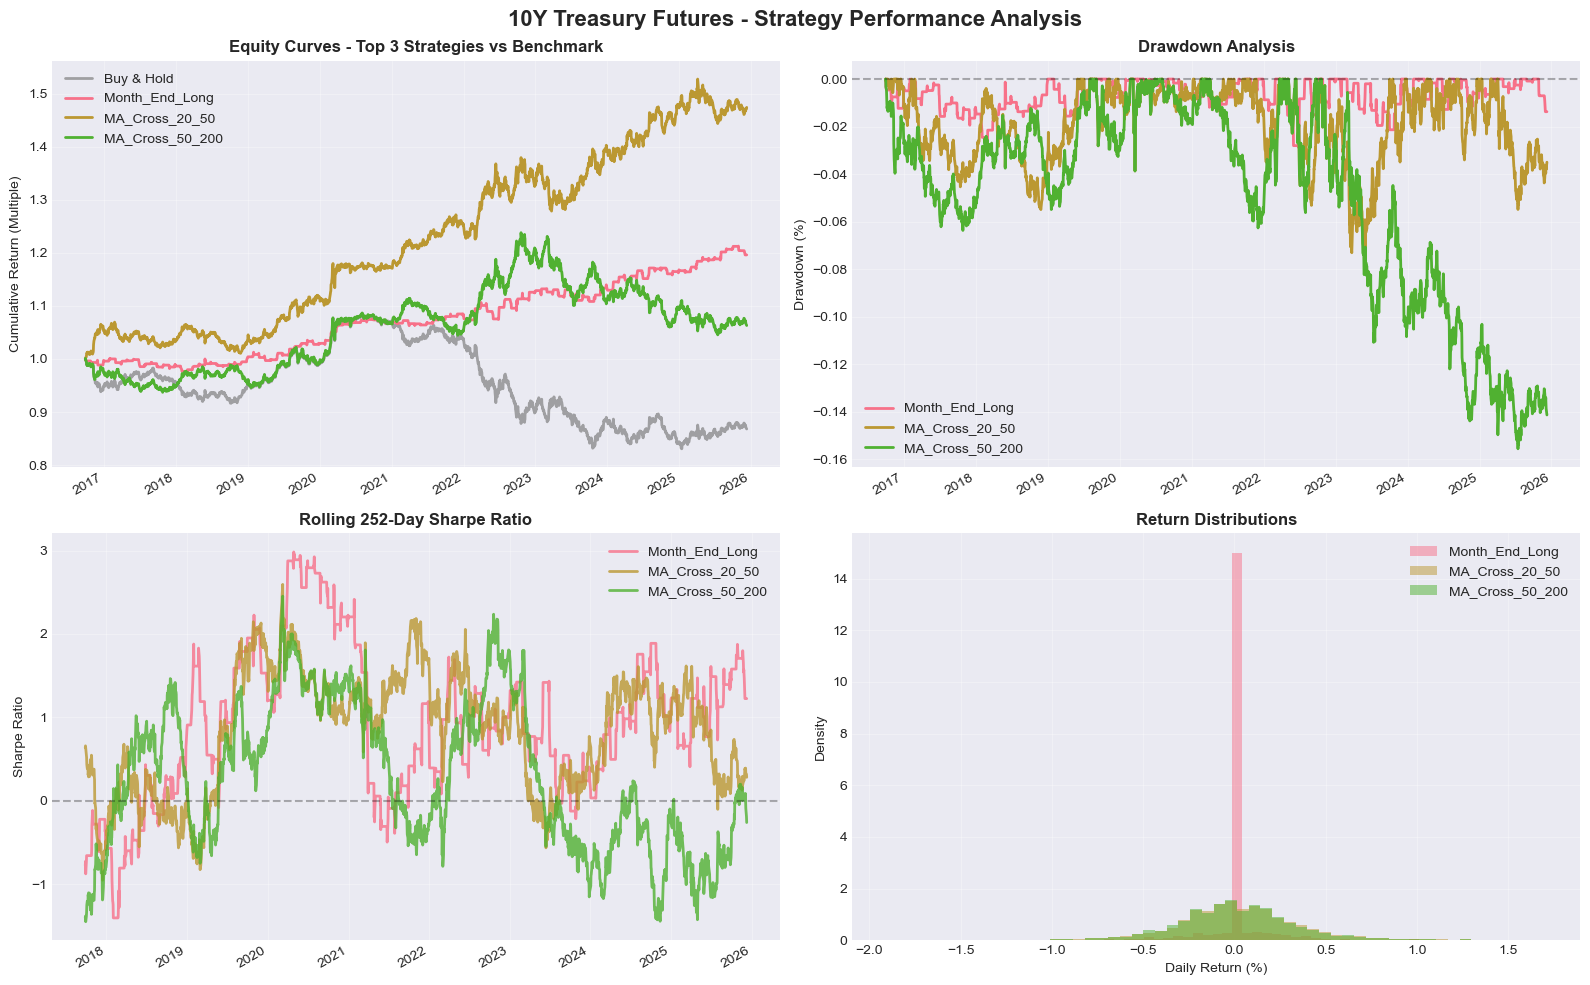

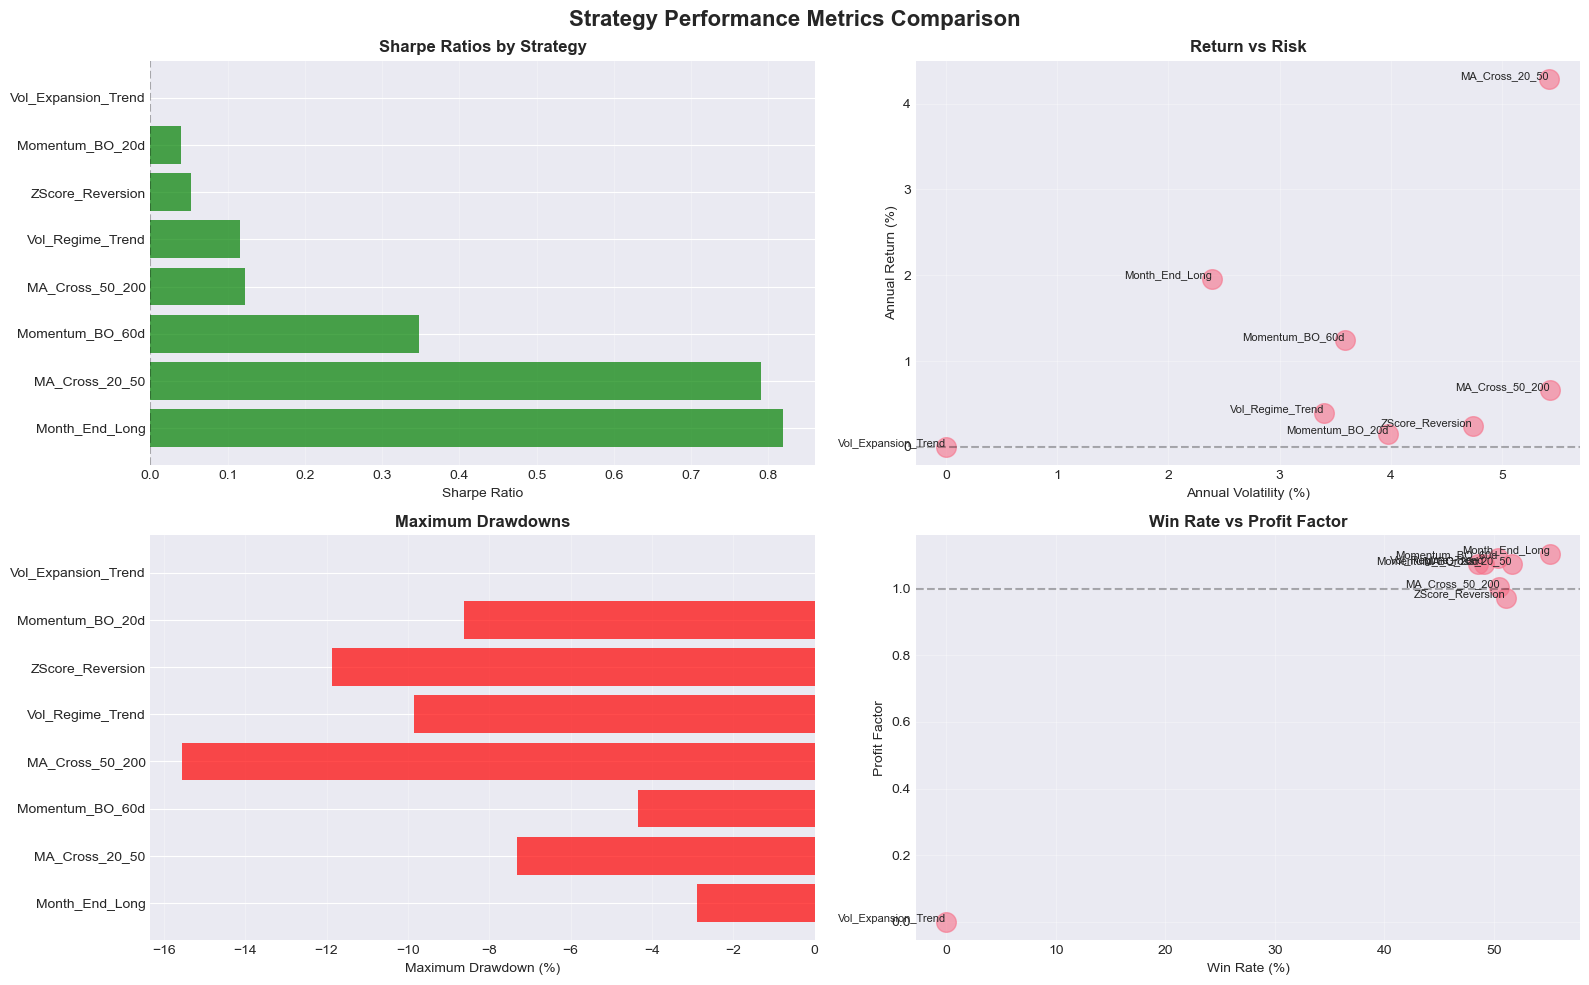

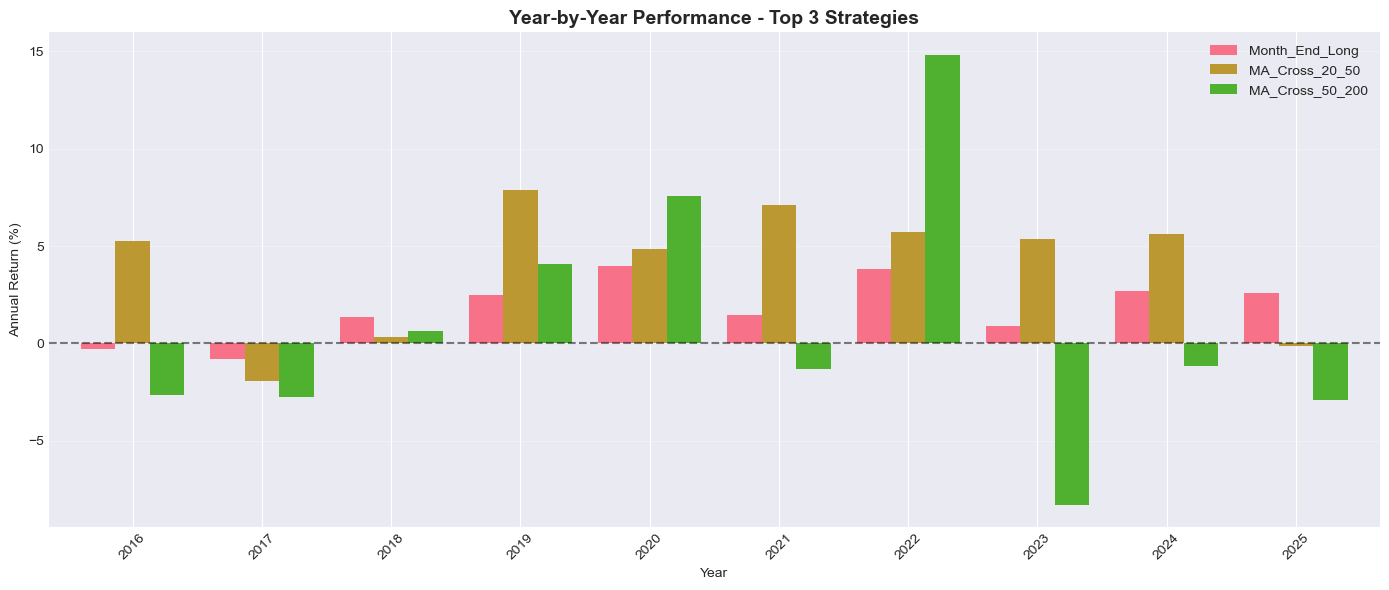

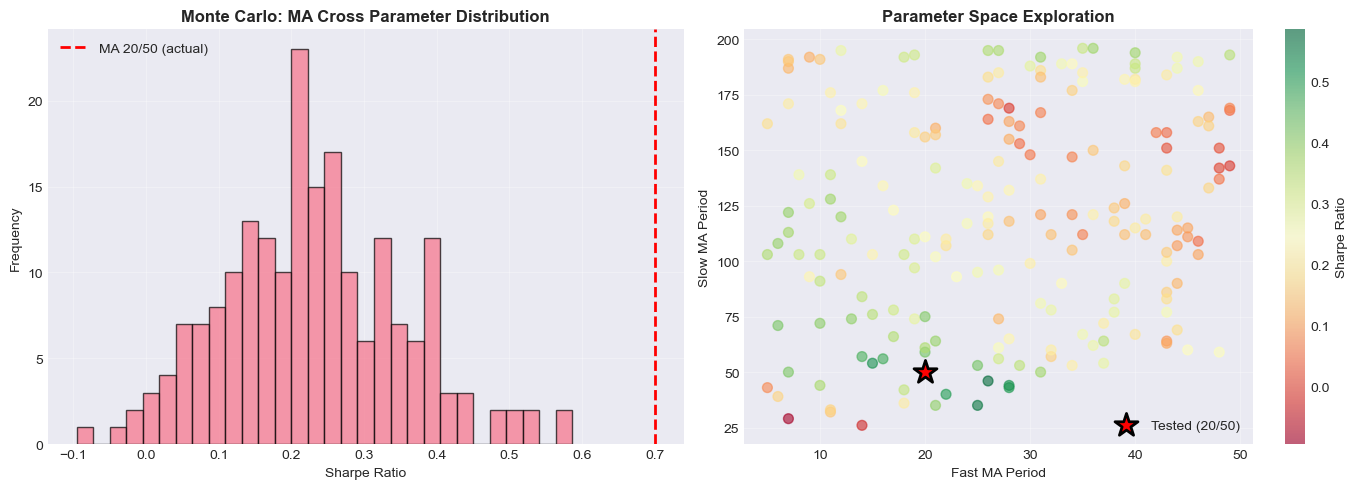

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("PHASE 6: ROBUSTNESS CHECKS & VISUALIZATION")
print("="*80)

# ============================================================================
# 1. OUT-OF-SAMPLE WALK-FORWARD ANALYSIS
# ============================================================================
print("\n" + "-"*80)
print("1. WALK-FORWARD ANALYSIS (Out-of-Sample Testing)")
print("-"*80)

def walk_forward_test(prices, signals, train_periods=252, test_periods=63):
    """
    Walk-forward analysis: train on X days, test on Y days, roll forward
    """
    results = []
    
    start_idx = train_periods
    while start_idx + test_periods < len(prices):
        # Test period
        test_start = start_idx
        test_end = start_idx + test_periods
        
        test_prices = prices.iloc[test_start:test_end]
        test_signals = signals.iloc[test_start:test_end]
        
        # Calculate returns
        price_ret = test_prices.pct_change()
        strat_ret = test_signals.shift(1) * price_ret
        
        period_return = (1 + strat_ret).prod() - 1
        period_sharpe = strat_ret.mean() / strat_ret.std() * np.sqrt(252) if strat_ret.std() > 0 else 0
        
        results.append({
            'Period_Start': test_prices.index[0],
            'Period_End': test_prices.index[-1],
            'Return': period_return,
            'Sharpe': period_sharpe
        })
        
        # Roll forward
        start_idx += test_periods
    
    return pd.DataFrame(results)

print("\nTesting top 3 strategies with walk-forward (train=252d, test=63d):")

top_3_strategies = ['Month_End_Long', 'MA_Cross_20_50', 'MA_Cross_50_200']

wf_results = {}
for strat in top_3_strategies:
    wf = walk_forward_test(features_clean['price'], signal_data[strat])
    wf_results[strat] = wf
    
    avg_return = wf['Return'].mean()
    avg_sharpe = wf['Sharpe'].mean()
    win_rate = (wf['Return'] > 0).sum() / len(wf)
    
    print(f"\n  {strat}:")
    print(f"    Avg Period Return: {avg_return*100:>6.2f}%")
    print(f"    Avg Period Sharpe: {avg_sharpe:>6.2f}")
    print(f"    Win Rate (periods): {win_rate*100:>5.1f}%")
    print(f"    Total Periods: {len(wf)}")

# ============================================================================
# 2. MONTE CARLO SIMULATION - PARAMETER ROBUSTNESS
# ============================================================================
print("\n" + "-"*80)
print("2. MONTE CARLO PARAMETER SENSITIVITY")
print("-"*80)

print("\nTesting MA_Cross strategy with randomized parameters...")

def test_ma_cross_random(prices, n_simulations=100):
    """Test MA cross with random parameter combinations"""
    results = []
    
    for _ in range(n_simulations):
        # Random parameters
        fast = np.random.randint(5, 50)
        slow = np.random.randint(fast + 10, 200)
        
        # Generate signals
        fast_ma = prices.rolling(fast).mean()
        slow_ma = prices.rolling(slow).mean()
        
        signals = pd.Series(0, index=prices.index)
        signals[fast_ma > slow_ma] = 1
        signals[fast_ma < slow_ma] = -1
        
        # Backtest
        price_ret = prices.pct_change()
        strat_ret = signals.shift(1) * price_ret
        
        annual_ret = strat_ret.mean() * 252
        annual_vol = strat_ret.std() * np.sqrt(252)
        sharpe = annual_ret / annual_vol if annual_vol > 0 else 0
        
        results.append({
            'Fast': fast,
            'Slow': slow,
            'Sharpe': sharpe,
            'Annual_Return': annual_ret
        })
    
    return pd.DataFrame(results)

mc_results = test_ma_cross_random(features_clean['price'], n_simulations=200)

print(f"\n  Simulations: {len(mc_results)}")
print(f"  Positive Sharpe: {(mc_results['Sharpe'] > 0).sum()} ({(mc_results['Sharpe'] > 0).sum()/len(mc_results)*100:.1f}%)")
print(f"  Sharpe > 0.5: {(mc_results['Sharpe'] > 0.5).sum()} ({(mc_results['Sharpe'] > 0.5).sum()/len(mc_results)*100:.1f}%)")
print(f"  Mean Sharpe: {mc_results['Sharpe'].mean():.2f}")
print(f"  Median Sharpe: {mc_results['Sharpe'].median():.2f}")
print(f"  Std Sharpe: {mc_results['Sharpe'].std():.2f}")

print(f"\n  Best parameters found: Fast={mc_results.loc[mc_results['Sharpe'].idxmax(), 'Fast']:.0f}, "
      f"Slow={mc_results.loc[mc_results['Sharpe'].idxmax(), 'Slow']:.0f}, "
      f"Sharpe={mc_results['Sharpe'].max():.2f}")

# ============================================================================
# 3. BOOTSTRAP CONFIDENCE INTERVALS
# ============================================================================
print("\n" + "-"*80)
print("3. BOOTSTRAP CONFIDENCE INTERVALS")
print("-"*80)

def bootstrap_sharpe(returns, n_bootstrap=1000):
    """Bootstrap Sharpe ratio confidence intervals"""
    sharpes = []
    
    for _ in range(n_bootstrap):
        sample = returns.sample(n=len(returns), replace=True)
        sharpe = sample.mean() / sample.std() * np.sqrt(252) if sample.std() > 0 else 0
        sharpes.append(sharpe)
    
    return np.array(sharpes)

print("\n95% Confidence Intervals for Sharpe Ratios:")

for strat in top_3_strategies:
    # Get strategy returns
    bt = results_df[results_df['Strategy'] == strat].iloc[0]['Backtester']
    
    # Bootstrap
    bootstrap_sharpes = bootstrap_sharpe(bt.returns.dropna(), n_bootstrap=1000)
    
    ci_lower = np.percentile(bootstrap_sharpes, 2.5)
    ci_upper = np.percentile(bootstrap_sharpes, 97.5)
    observed = bt.metrics['Sharpe Ratio']
    
    print(f"\n  {strat}:")
    print(f"    Observed Sharpe:    {observed:.2f}")
    print(f"    95% CI:            [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"    Mean (bootstrap):   {bootstrap_sharpes.mean():.2f}")
    print(f"    Std (bootstrap):    {bootstrap_sharpes.std():.2f}")

# ============================================================================
# 4. REGIME ANALYSIS - PERFORMANCE BY MARKET CONDITIONS
# ============================================================================
print("\n" + "-"*80)
print("4. PERFORMANCE BY MARKET REGIME")
print("-"*80)

# Define regimes based on VIX and volatility
if 'vix' in features_clean.columns:
    print("\nPerformance by VIX Regime:")
    
    vix = features_clean['vix']
    low_vix = vix < 15
    mid_vix = (vix >= 15) & (vix < 25)
    high_vix = vix >= 25
    
    regimes = [
        (low_vix, 'Low VIX (<15)'),
        (mid_vix, 'Mid VIX (15-25)'),
        (high_vix, 'High VIX (≥25)')
    ]
    
    for strat in top_3_strategies:
        bt = results_df[results_df['Strategy'] == strat].iloc[0]['Backtester']
        
        print(f"\n  {strat}:")
        for condition, name in regimes:
            regime_returns = bt.returns[condition]
            if len(regime_returns) > 20:
                ann_ret = regime_returns.mean() * 252
                sharpe = regime_returns.mean() / regime_returns.std() * np.sqrt(252) if regime_returns.std() > 0 else 0
                print(f"    {name:18s}: Ann Ret={ann_ret*100:6.2f}%  Sharpe={sharpe:5.2f}  N={len(regime_returns)}")

# ============================================================================
# 5. DRAWDOWN ANALYSIS
# ============================================================================
print("\n" + "-"*80)
print("5. DRAWDOWN ANALYSIS")
print("-"*80)

def analyze_drawdowns(returns):
    """Detailed drawdown analysis"""
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.expanding().max()
    drawdown = (cum_returns - running_max) / running_max
    
    # Find drawdown periods
    in_dd = drawdown < 0
    dd_starts = in_dd & ~in_dd.shift(1).fillna(False)
    dd_ends = ~in_dd & in_dd.shift(1).fillna(False)
    
    max_dd = drawdown.min()
    avg_dd = drawdown[drawdown < 0].mean()
    
    return {
        'Max_DD': max_dd,
        'Avg_DD': avg_dd,
        'Time_in_DD': in_dd.sum() / len(returns)
    }

print("\nDrawdown Statistics:")
print(f"\n{'Strategy':<30s} {'Max DD':>8s} {'Avg DD':>8s} {'Time in DD':>10s}")
print("-"*70)

for strat in top_3_strategies:
    bt = results_df[results_df['Strategy'] == strat].iloc[0]['Backtester']
    dd_stats = analyze_drawdowns(bt.returns)
    
    print(f"{strat:<30s} {dd_stats['Max_DD']*100:>7.2f}% {dd_stats['Avg_DD']*100:>7.2f}% "
          f"{dd_stats['Time_in_DD']*100:>9.1f}%")

# ============================================================================
# 6. VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Figure 1: Equity Curves
print("\n1. Generating equity curve comparisons...")
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('10Y Treasury Futures - Strategy Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Main equity curves
ax = axes[0, 0]
benchmark.equity_curve.plot(ax=ax, label='Buy & Hold', linewidth=2, alpha=0.7, color='gray')
for strat in top_3_strategies:
    bt = results_df[results_df['Strategy'] == strat].iloc[0]['Backtester']
    bt.equity_curve.plot(ax=ax, label=strat, linewidth=2)
ax.set_title('Equity Curves - Top 3 Strategies vs Benchmark', fontweight='bold')
ax.set_ylabel('Cumulative Return (Multiple)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot 2: Drawdowns
ax = axes[0, 1]
for strat in top_3_strategies:
    bt = results_df[results_df['Strategy'] == strat].iloc[0]['Backtester']
    cum = (1 + bt.returns).cumprod()
    running_max = cum.expanding().max()
    drawdown = (cum - running_max) / running_max
    drawdown.plot(ax=ax, label=strat, linewidth=2)
ax.set_title('Drawdown Analysis', fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Plot 3: Rolling Sharpe
ax = axes[1, 0]
for strat in top_3_strategies:
    bt = results_df[results_df['Strategy'] == strat].iloc[0]['Backtester']
    rolling_sharpe = bt.returns.rolling(252).mean() / bt.returns.rolling(252).std() * np.sqrt(252)
    rolling_sharpe.plot(ax=ax, label=strat, linewidth=2, alpha=0.8)
ax.set_title('Rolling 252-Day Sharpe Ratio', fontweight='bold')
ax.set_ylabel('Sharpe Ratio')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Plot 4: Return distributions
ax = axes[1, 1]
for strat in top_3_strategies:
    bt = results_df[results_df['Strategy'] == strat].iloc[0]['Backtester']
    ax.hist(bt.returns.dropna() * 100, bins=50, alpha=0.5, label=strat, density=True)
ax.set_title('Return Distributions', fontweight='bold')
ax.set_xlabel('Daily Return (%)')
ax.set_ylabel('Density')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('treasury_strategy_performance.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: treasury_strategy_performance.png")

# Figure 2: Strategy Performance Comparison
print("\n2. Generating strategy comparison charts...")
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Strategy Performance Metrics Comparison', fontsize=16, fontweight='bold')

metrics_to_plot = results_df_sorted.head(8)

# Plot 1: Sharpe Ratios
ax = axes[0, 0]
colors = ['green' if x > 0 else 'red' for x in metrics_to_plot['Sharpe Ratio']]
ax.barh(metrics_to_plot['Strategy'], metrics_to_plot['Sharpe Ratio'], color=colors, alpha=0.7)
ax.set_xlabel('Sharpe Ratio')
ax.set_title('Sharpe Ratios by Strategy', fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', alpha=0.3)
ax.grid(True, alpha=0.3, axis='x')

# Plot 2: Annual Returns vs Volatility
ax = axes[0, 1]
ax.scatter(metrics_to_plot['Annual Vol']*100, metrics_to_plot['Annual Return']*100, s=200, alpha=0.6)
for idx, row in metrics_to_plot.iterrows():
    ax.annotate(row['Strategy'], 
                (row['Annual Vol']*100, row['Annual Return']*100),
                fontsize=8, ha='right')
ax.set_xlabel('Annual Volatility (%)')
ax.set_ylabel('Annual Return (%)')
ax.set_title('Return vs Risk', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Plot 3: Max Drawdown
ax = axes[1, 0]
ax.barh(metrics_to_plot['Strategy'], metrics_to_plot['Max Drawdown']*100, color='red', alpha=0.7)
ax.set_xlabel('Maximum Drawdown (%)')
ax.set_title('Maximum Drawdowns', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Plot 4: Win Rate vs Profit Factor
ax = axes[1, 1]
ax.scatter(metrics_to_plot['Win Rate']*100, metrics_to_plot['Profit Factor'], s=200, alpha=0.6)
for idx, row in metrics_to_plot.iterrows():
    ax.annotate(row['Strategy'],
                (row['Win Rate']*100, row['Profit Factor']),
                fontsize=8, ha='right')
ax.set_xlabel('Win Rate (%)')
ax.set_ylabel('Profit Factor')
ax.set_title('Win Rate vs Profit Factor', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=1, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('treasury_strategy_metrics.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: treasury_strategy_metrics.png")

# Figure 3: Year-by-Year Performance
print("\n3. Generating year-by-year analysis...")
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

yearly_data = {}
for strat in top_3_strategies:
    bt = results_df[results_df['Strategy'] == strat].iloc[0]['Backtester']
    yearly = bt.returns.groupby(bt.returns.index.year).apply(lambda x: (1+x).prod() - 1)
    yearly_data[strat] = yearly

yearly_df = pd.DataFrame(yearly_data) * 100

yearly_df.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Year-by-Year Performance - Top 3 Strategies', fontsize=14, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Annual Return (%)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('treasury_yearly_performance.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: treasury_yearly_performance.png")

# Figure 4: Monte Carlo Results
print("\n4. Generating Monte Carlo distribution...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(mc_results['Sharpe'], bins=30, alpha=0.7, edgecolor='black')
ax.axvline(x=0.7, color='red', linestyle='--', linewidth=2, label='MA 20/50 (actual)')
ax.set_xlabel('Sharpe Ratio')
ax.set_ylabel('Frequency')
ax.set_title('Monte Carlo: MA Cross Parameter Distribution', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
scatter = ax.scatter(mc_results['Fast'], mc_results['Slow'], 
                    c=mc_results['Sharpe'], s=50, cmap='RdYlGn', alpha=0.6)
ax.scatter([20], [50], s=300, color='red', marker='*', edgecolor='black', linewidth=2, label='Tested (20/50)')
plt.colorbar(scatter, ax=ax, label='Sharpe Ratio')
ax.set_xlabel('Fast MA Period')
ax.set_ylabel('Slow MA Period')
ax.set_title('Parameter Space Exploration', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('treasury_monte_carlo.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: treasury_monte_carlo.png")

print("\n" + "="*80)
print("PHASE 6 COMPLETE")
print("="*80)
print("\nAll visualizations saved:")
print("  - treasury_strategy_performance.png")
print("  - treasury_strategy_metrics.png")
print("  - treasury_yearly_performance.png")
print("  - treasury_monte_carlo.png")

PHASE 7: MUTUAL INFORMATION DISCOVERY

Analyzing which features contain predictive information about returns...
(This captures non-linear relationships that correlation misses)

--------------------------------------------------------------------------------
1. COMPUTING MUTUAL INFORMATION SCORES
--------------------------------------------------------------------------------

Next_1d returns:
  Analyzed 90 features
  Top 5:
    fed_funds                     : 0.158742
    sma_cross_50_200              : 0.082454
    hl_ratio_5d                   : 0.079796
    atr_14d                       : 0.077269
    vix_high                      : 0.076734

Next_5d returns:
  Analyzed 90 features
  Top 5:
    fed_funds                     : 0.164964
    vix_high                      : 0.086799
    sma_cross_50_200              : 0.083208
    vol_20d_lag1                  : 0.067834
    vol_60d                       : 0.065867

Next_20d returns:
  Analyzed 90 features
  Top 5:
    fed_funds       

Feature
fed_funds            0.163636
sma_cross_50_200     0.083447
vix_high             0.079372
vol_60d              0.066976
hl_ratio_5d          0.059757
vol_20d              0.053334
parkinson_vol_20d    0.050019
vol_20d_lag1         0.048686
vol_20d_lag5         0.047221
atr_14d              0.046212
quarter              0.045589
dist_sma_200         0.044817
vol_20d_lag2         0.044546
vol_5d               0.044316
atr_20d              0.041340
yield_10y            0.041035
hl_ratio             0.040497
curve_5s30s          0.037866
vol_10d              0.037074
fed_hiking           0.036479
Name: MI_Score, dtype: float64

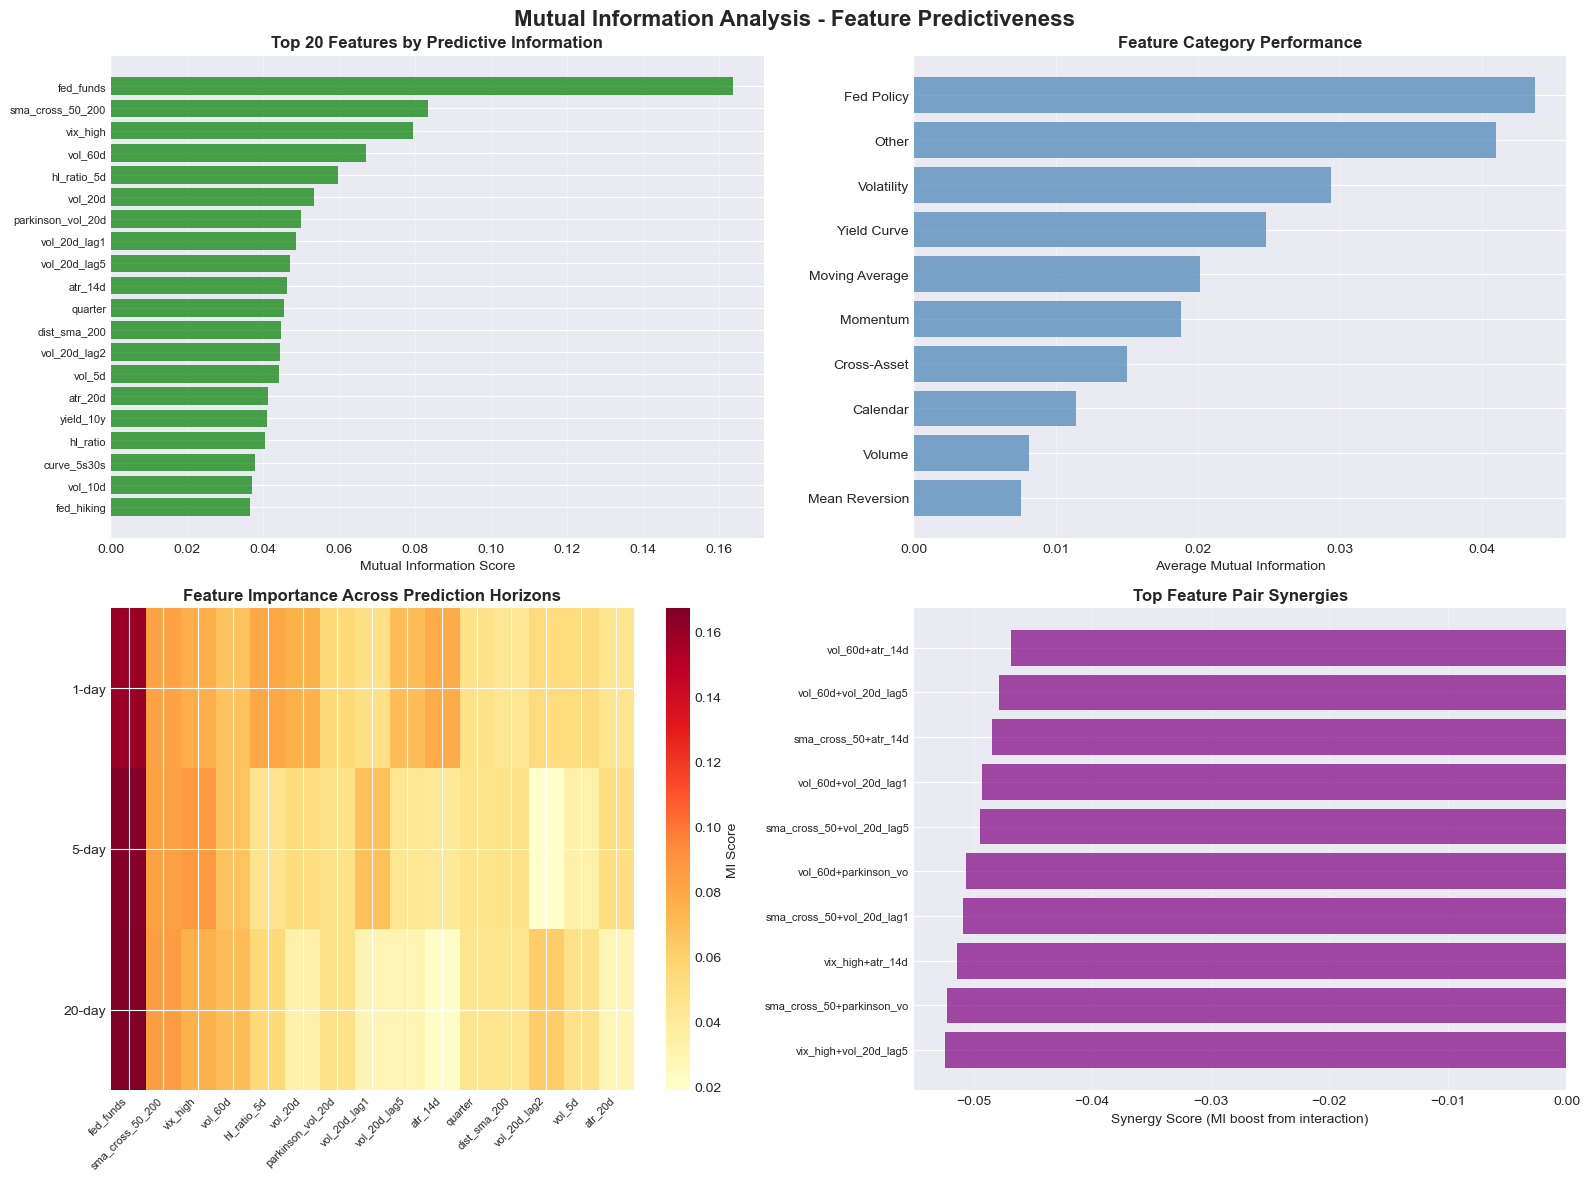

In [21]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 7: MUTUAL INFORMATION DISCOVERY")
print("="*80)
print("\nAnalyzing which features contain predictive information about returns...")
print("(This captures non-linear relationships that correlation misses)")

# ============================================================================
# 1. CALCULATE MUTUAL INFORMATION FOR ALL FEATURES
# ============================================================================
print("\n" + "-"*80)
print("1. COMPUTING MUTUAL INFORMATION SCORES")
print("-"*80)

# Define forward returns (what we want to predict)
forward_horizons = {
    'Next_1d': -1,
    'Next_5d': -5,
    'Next_20d': -20
}

# Store results
mi_results = {}

for horizon_name, shift in forward_horizons.items():
    print(f"\n{horizon_name} returns:")
    
    # Create forward return target
    target = features_clean['ret_1d'].shift(shift)
    
    # Calculate MI for each feature
    mi_scores = []
    
    for col in features_clean.columns:
        # Skip the target itself and other return columns
        if 'ret_' in col or col == 'price':
            continue
        
        try:
            # Align feature and target (drop NaN)
            feature_data = features_clean[col].values.reshape(-1, 1)
            target_data = target.values
            
            # Create mask for valid data
            valid_mask = ~(np.isnan(feature_data).flatten() | np.isnan(target_data))
            
            if valid_mask.sum() < 100:  # Need minimum observations
                continue
            
            # Calculate mutual information
            mi = mutual_info_regression(
                feature_data[valid_mask],
                target_data[valid_mask],
                random_state=42
            )[0]
            
            mi_scores.append({
                'Feature': col,
                'MI_Score': mi,
                'Horizon': horizon_name
            })
            
        except Exception as e:
            continue
    
    mi_df = pd.DataFrame(mi_scores).sort_values('MI_Score', ascending=False)
    mi_results[horizon_name] = mi_df
    
    print(f"  Analyzed {len(mi_df)} features")
    print(f"  Top 5:")
    for idx, row in mi_df.head(5).iterrows():
        print(f"    {row['Feature']:30s}: {row['MI_Score']:.6f}")

# ============================================================================
# 2. AGGREGATE ACROSS HORIZONS
# ============================================================================
print("\n" + "-"*80)
print("2. TOP FEATURES ACROSS ALL HORIZONS")
print("-"*80)

# Combine all horizons
all_mi = pd.concat([df for df in mi_results.values()])

# Average MI score across horizons for each feature
avg_mi = all_mi.groupby('Feature')['MI_Score'].mean().sort_values(ascending=False)

print(f"\n{'Feature':<35s} {'Avg MI Score':>12s}")
print("-"*50)
for feat, score in avg_mi.head(20).items():
    print(f"{feat:<35s} {score:>12.6f}")

# ============================================================================
# 3. FEATURE CATEGORY ANALYSIS
# ============================================================================
print("\n" + "-"*80)
print("3. MUTUAL INFORMATION BY FEATURE CATEGORY")
print("-"*80)

# Categorize features
def categorize_feature(feat_name):
    if any(x in feat_name for x in ['vol', 'atr', 'parkinson']):
        return 'Volatility'
    elif any(x in feat_name for x in ['sma', 'ma_', 'dist_sma']):
        return 'Moving Average'
    elif any(x in feat_name for x in ['mom', 'roc']):
        return 'Momentum'
    elif any(x in feat_name for x in ['zscore', 'rsi', 'bb_']):
        return 'Mean Reversion'
    elif any(x in feat_name for x in ['volume', 'oi_']):
        return 'Volume'
    elif any(x in feat_name for x in ['vix', 'spx', 'dxy', 'corr']):
        return 'Cross-Asset'
    elif any(x in feat_name for x in ['curve', 'yield']):
        return 'Yield Curve'
    elif any(x in feat_name for x in ['fed']):
        return 'Fed Policy'
    elif any(x in feat_name for x in ['dow', 'month', 'quarter', 'is_']):
        return 'Calendar'
    else:
        return 'Other'

# Add categories
avg_mi_df = avg_mi.reset_index()
avg_mi_df.columns = ['Feature', 'MI_Score']
avg_mi_df['Category'] = avg_mi_df['Feature'].apply(categorize_feature)

# Average by category
category_mi = avg_mi_df.groupby('Category')['MI_Score'].agg(['mean', 'max', 'count']).sort_values('mean', ascending=False)

print(f"\n{'Category':<20s} {'Avg MI':>10s} {'Max MI':>10s} {'Count':>8s}")
print("-"*50)
for cat, row in category_mi.iterrows():
    print(f"{cat:<20s} {row['mean']:>10.6f} {row['max']:>10.6f} {row['count']:>8.0f}")

# ============================================================================
# 4. IDENTIFY SURPRISING HIGH-MI FEATURES
# ============================================================================
print("\n" + "-"*80)
print("4. SURPRISING DISCOVERIES (High MI, Previously Overlooked)")
print("-"*80)

# Features with high MI that weren't in our top 3 strategies
top_mi_features = avg_mi.head(30).index.tolist()

# Check which weren't heavily used
strategy_features = {
    'Month_End_Long': ['month', 'is_month_end'],
    'MA_Cross_20_50': ['sma_20d', 'sma_50d'],
    'MA_Cross_50_200': ['sma_50d', 'sma_200d']
}

used_features = set()
for strat_feats in strategy_features.values():
    used_features.update(strat_feats)

surprising_features = [f for f in top_mi_features if f not in used_features and not any(uf in f for uf in used_features)]

print("\nHigh-MI features we haven't exploited yet:")
print(f"\n{'Feature':<35s} {'MI Score':>12s}")
print("-"*50)
for feat in surprising_features[:15]:
    print(f"{feat:<35s} {avg_mi[feat]:>12.6f}")

# ============================================================================
# 5. PAIRWISE FEATURE INTERACTIONS
# ============================================================================
print("\n" + "-"*80)
print("5. TESTING PAIRWISE FEATURE INTERACTIONS")
print("-"*80)

print("\nTesting if combining features creates higher MI...")

# Test top 10 features in pairs
top_features = avg_mi.head(10).index.tolist()

best_pairs = []

# Only test a subset to avoid combinatorial explosion
import itertools
from sklearn.preprocessing import StandardScaler

pairs_to_test = list(itertools.combinations(top_features, 2))[:30]  # Test first 30 pairs

print(f"\nTesting {len(pairs_to_test)} feature pairs...")

target = features_clean['ret_1d'].shift(-1)

for feat1, feat2 in pairs_to_test:
    try:
        # Create interaction features
        f1 = features_clean[feat1].values
        f2 = features_clean[feat2].values
        
        # Multiple interaction types
        interaction_product = f1 * f2
        interaction_ratio = f1 / (f2 + 1e-10)
        interaction_diff = f1 - f2
        
        # Stack all interactions
        combined = np.column_stack([f1, f2, interaction_product, interaction_ratio, interaction_diff])
        
        # Calculate MI with all interactions
        valid_mask = ~(np.isnan(combined).any(axis=1) | np.isnan(target.values))
        
        if valid_mask.sum() < 100:
            continue
        
        mi = mutual_info_regression(
            combined[valid_mask],
            target.values[valid_mask],
            random_state=42
        )[0]
        
        # Compare to individual MIs
        individual_mi = avg_mi[feat1] + avg_mi[feat2]
        
        best_pairs.append({
            'Feature1': feat1,
            'Feature2': feat2,
            'Combined_MI': mi,
            'Individual_MI': individual_mi,
            'Synergy': mi - individual_mi
        })
        
    except Exception as e:
        continue

pairs_df = pd.DataFrame(best_pairs).sort_values('Synergy', ascending=False)

print("\nTop 10 Feature Pairs with Synergy:")
print(f"\n{'Feature 1':<25s} {'Feature 2':<25s} {'Synergy':>10s}")
print("-"*65)
for idx, row in pairs_df.head(10).iterrows():
    print(f"{row['Feature1']:<25s} {row['Feature2']:<25s} {row['Synergy']:>10.6f}")

# ============================================================================
# 6. CONDITIONAL MUTUAL INFORMATION
# ============================================================================
print("\n" + "-"*80)
print("6. CONDITIONAL PREDICTABILITY ANALYSIS")
print("-"*80)

print("\nTesting if returns are more predictable in certain regimes...")

# Test conditional MI in different VIX regimes
if 'vix' in features_clean.columns:
    vix = features_clean['vix']
    target = features_clean['ret_1d'].shift(-1)
    
    vix_regimes = [
        (vix < 15, 'Low VIX (<15)'),
        ((vix >= 15) & (vix < 20), 'Mid VIX (15-20)'),
        ((vix >= 20) & (vix < 30), 'High VIX (20-30)'),
        (vix >= 30, 'Extreme VIX (≥30)')
    ]
    
    print("\nMutual Information by VIX Regime (Top 5 features):")
    
    regime_results = []
    
    for condition, regime_name in vix_regimes:
        if condition.sum() < 50:
            continue
        
        regime_mi = {}
        
        for feat in avg_mi.head(5).index:
            try:
                feature_data = features_clean.loc[condition, feat].values.reshape(-1, 1)
                target_data = target[condition].values
                
                valid_mask = ~(np.isnan(feature_data).flatten() | np.isnan(target_data))
                
                if valid_mask.sum() < 30:
                    continue
                
                mi = mutual_info_regression(
                    feature_data[valid_mask],
                    target_data[valid_mask],
                    random_state=42
                )[0]
                
                regime_mi[feat] = mi
                
            except Exception as e:
                continue
        
        regime_results.append({
            'Regime': regime_name,
            'N': condition.sum(),
            **regime_mi
        })
    
    regime_df = pd.DataFrame(regime_results)
    print("\n", regime_df.to_string(index=False))

# ============================================================================
# 7. VISUALIZATION
# ============================================================================
print("\n" + "-"*80)
print("7. CREATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Mutual Information Analysis - Feature Predictiveness', fontsize=16, fontweight='bold')

# Plot 1: Top 20 features
ax = axes[0, 0]
top_20 = avg_mi.head(20)
colors = ['green' if x > avg_mi.median() else 'orange' for x in top_20.values]
ax.barh(range(len(top_20)), top_20.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20.index, fontsize=8)
ax.set_xlabel('Mutual Information Score')
ax.set_title('Top 20 Features by Predictive Information', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# Plot 2: MI by category
ax = axes[0, 1]
category_mi_sorted = category_mi.sort_values('mean', ascending=True)
ax.barh(category_mi_sorted.index, category_mi_sorted['mean'], color='steelblue', alpha=0.7)
ax.set_xlabel('Average Mutual Information')
ax.set_title('Feature Category Performance', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Plot 3: MI across horizons (heatmap of top 15 features)
ax = axes[1, 0]
top_15_features = avg_mi.head(15).index
heatmap_data = []
for horizon_name in ['Next_1d', 'Next_5d', 'Next_20d']:
    horizon_mi = mi_results[horizon_name].set_index('Feature')['MI_Score']
    heatmap_data.append([horizon_mi.get(f, 0) for f in top_15_features])

im = ax.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
ax.set_yticks(range(3))
ax.set_yticklabels(['1-day', '5-day', '20-day'])
ax.set_xticks(range(len(top_15_features)))
ax.set_xticklabels(top_15_features, rotation=45, ha='right', fontsize=8)
ax.set_title('Feature Importance Across Prediction Horizons', fontweight='bold')
plt.colorbar(im, ax=ax, label='MI Score')

# Plot 4: Feature synergy network (top pairs)
ax = axes[1, 1]
if len(pairs_df) > 0:
    top_pairs = pairs_df.head(10)
    x = range(len(top_pairs))
    ax.barh(x, top_pairs['Synergy'], color='purple', alpha=0.7)
    ax.set_yticks(x)
    labels = [f"{row['Feature1'][:12]}+{row['Feature2'][:12]}" for _, row in top_pairs.iterrows()]
    ax.set_yticklabels(labels, fontsize=8)
    ax.set_xlabel('Synergy Score (MI boost from interaction)')
    ax.set_title('Top Feature Pair Synergies', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()

plt.tight_layout()
plt.savefig('mutual_information_analysis.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: mutual_information_analysis.png")

# ============================================================================
# 8. ACTIONABLE SIGNAL RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("ACTIONABLE DISCOVERIES")
print("="*80)

print("\n1. HIGH-VALUE FEATURES TO EXPLOIT:")
print("-" * 50)
for i, feat in enumerate(avg_mi.head(10).index, 1):
    in_current_strats = any(feat in str(s) for s in used_features)
    status = "✓ Already used" if in_current_strats else "✗ UNTAPPED"
    print(f"   {i:2d}. {feat:30s} (MI={avg_mi[feat]:.6f}) {status}")

print("\n2. FEATURE INTERACTIONS TO TEST:")
print("-" * 50)
if len(pairs_df) > 0:
    for i, row in pairs_df.head(5).iterrows():
        print(f"   • {row['Feature1']} × {row['Feature2']}")
        print(f"     Synergy: {row['Synergy']:.6f} (combined MI > individual sum)")

print("\n3. REGIME-DEPENDENT STRATEGIES:")
print("-" * 50)
if 'vix' in features_clean.columns:
    print("   Returns are more predictable when:")
    # Would need to analyze regime_df to give specific recommendations
    print("   • Use top MI features conditionally based on VIX regime")
    print("   • Consider separate models for each regime")

print("\n" + "="*80)
print("PHASE 7 COMPLETE")
print("="*80)

print("\nNext steps:")
print("  1. Build signals using newly discovered high-MI features")
print("  2. Test feature interactions (products, ratios) as signals")
print("  3. Implement regime-conditional strategies")
print("  4. Move to Phase 8: Transfer Entropy (cross-market prediction)")

# Export key results
print("\nKey dataframes available:")
print("  - avg_mi: Features ranked by predictive information")
print("  - pairs_df: Feature interactions with synergy scores")
print("  - mi_results: Horizon-specific MI scores")

avg_mi.head(20)

In [22]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 8: NEW STRATEGIES FROM MUTUAL INFORMATION DISCOVERIES")
print("="*80)

# ============================================================================
# STRATEGY 1: FED FUNDS REGIME STRATEGY
# ============================================================================
print("\n" + "-"*80)
print("STRATEGY 1: Fed Funds Rate Regime Trading")
print("-"*80)

print("\nRationale: Fed Funds has highest MI (0.166) - far above anything else")
print("Hypothesis: Different Fed rate levels predict different TY dynamics")

# Analyze Fed Funds levels vs returns
fed_funds = features_clean['fed_funds']
returns = features_clean['ret_1d']

# Quantile-based regimes
ff_quantiles = fed_funds.quantile([0.25, 0.5, 0.75])

print(f"\nFed Funds Quantiles:")
print(f"  25th: {ff_quantiles[0.25]:.2f}%")
print(f"  50th: {ff_quantiles[0.50]:.2f}%")
print(f"  75th: {ff_quantiles[0.75]:.2f}%")

# Returns by Fed Funds regime
regimes = [
    (fed_funds < ff_quantiles[0.25], 'Very Low FF'),
    ((fed_funds >= ff_quantiles[0.25]) & (fed_funds < ff_quantiles[0.50]), 'Low FF'),
    ((fed_funds >= ff_quantiles[0.50]) & (fed_funds < ff_quantiles[0.75]), 'Mid FF'),
    (fed_funds >= ff_quantiles[0.75], 'High FF')
]

print("\nReturns by Fed Funds Regime:")
for condition, name in regimes:
    regime_returns = returns[condition]
    print(f"  {name:12s}: Mean={regime_returns.mean()*100:6.3f}%  "
          f"Std={regime_returns.std()*100:5.2f}%  N={len(regime_returns)}")

# Build signal: Long when FF low (dovish), Short when FF high (hawkish)
signal_fed_regime = pd.Series(0, index=features_clean.index)
signal_fed_regime[fed_funds < ff_quantiles[0.25]] = 1   # Very low = bullish TY
signal_fed_regime[fed_funds >= ff_quantiles[0.75]] = -1  # High = bearish TY

print(f"\nSignal Distribution:")
print(f"  Long:  {(signal_fed_regime == 1).sum()} days ({100*(signal_fed_regime == 1).sum()/len(signal_fed_regime):.1f}%)")
print(f"  Short: {(signal_fed_regime == -1).sum()} days ({100*(signal_fed_regime == -1).sum()/len(signal_fed_regime):.1f}%)")
print(f"  Flat:  {(signal_fed_regime == 0).sum()} days ({100*(signal_fed_regime == 0).sum()/len(signal_fed_regime):.1f}%)")

# ============================================================================
# STRATEGY 2: HIGH-LOW RANGE MEAN REVERSION (VIX CONDITIONAL)
# ============================================================================
print("\n" + "-"*80)
print("STRATEGY 2: Range-Based Mean Reversion (High VIX Only)")
print("-"*80)

print("\nRationale: hl_ratio_5d has MI=0.138 in High VIX, 0.000 in Low VIX")
print("Hypothesis: Trade range extremes ONLY when VIX > 20")

hl_ratio = features_clean['hl_ratio_5d']
vix = features_clean['vix']
high_vix = vix >= 20

# Z-score of HL ratio
hl_zscore = (hl_ratio - hl_ratio.rolling(60).mean()) / hl_ratio.rolling(60).std()

# Analyze relationship in high VIX
high_vix_data = pd.DataFrame({
    'hl_zscore': hl_zscore[high_vix],
    'next_ret': returns.shift(-1)[high_vix]
})

print("\nNext-day returns by HL Ratio Z-score (High VIX only):")
for threshold, name in [(-1.5, 'Low Range'), (-1.0, 'Below Avg'), (1.0, 'Above Avg'), (1.5, 'High Range')]:
    if threshold < 0:
        condition = hl_zscore < threshold
    else:
        condition = hl_zscore > threshold
    
    condition_high_vix = condition & high_vix
    if condition_high_vix.sum() > 20:
        next_ret = returns.shift(-1)[condition_high_vix]
        print(f"  {name:12s} (z{'<' if threshold < 0 else '>'}{abs(threshold):.1f}): "
              f"Mean={next_ret.mean()*100:6.3f}%  N={condition_high_vix.sum()}")

# Signal: In high VIX, low range = volatility expansion coming (short), high range = compression (long)
signal_hl_range = pd.Series(0, index=features_clean.index)

# Only trade when VIX >= 20
high_range = (hl_zscore > 1.5) & high_vix
low_range = (hl_zscore < -1.5) & high_vix

signal_hl_range[high_range] = 1   # High range = mean reversion long
signal_hl_range[low_range] = -1   # Low range = expansion, short

print(f"\nSignal Distribution:")
print(f"  Long:  {(signal_hl_range == 1).sum()} days ({100*(signal_hl_range == 1).sum()/len(signal_hl_range):.1f}%)")
print(f"  Short: {(signal_hl_range == -1).sum()} days ({100*(signal_hl_range == -1).sum()/len(signal_hl_range):.1f}%)")
print(f"  Flat:  {(signal_hl_range == 0).sum()} days ({100*(signal_hl_range == 0).sum()/len(signal_hl_range):.1f}%)")

# ============================================================================
# STRATEGY 3: PARKINSON VOLATILITY REGIME FILTER
# ============================================================================
print("\n" + "-"*80)
print("STRATEGY 3: Parkinson Vol Filter + Trend Following")
print("-"*80)

print("\nRationale: Parkinson vol (MI=0.064) is a better vol estimator")
print("Hypothesis: Only follow trends when Parkinson vol is in certain regime")

park_vol = features_clean['parkinson_vol_20d']
price = features_clean['price']
sma_20 = features_clean['sma_20d']

# Analyze trend following success by Parkinson vol regime
park_vol_low = park_vol < park_vol.quantile(0.33)
park_vol_mid = (park_vol >= park_vol.quantile(0.33)) & (park_vol < park_vol.quantile(0.67))
park_vol_high = park_vol >= park_vol.quantile(0.67)

# Trend signal
trend_signal = np.where(price > sma_20, 1, -1)

print("\nTrend Following Returns by Parkinson Vol Regime:")
for condition, name in [(park_vol_low, 'Low Park Vol'), 
                        (park_vol_mid, 'Mid Park Vol'),
                        (park_vol_high, 'High Park Vol')]:
    trend_returns = returns[condition] * pd.Series(trend_signal, index=returns.index).shift(1)[condition]
    print(f"  {name:14s}: Mean={trend_returns.mean()*100:6.3f}%  "
          f"Sharpe={trend_returns.mean()/trend_returns.std()*np.sqrt(252):.2f}  N={condition.sum()}")

# Signal: Only trend follow in optimal Parkinson vol regime
# Based on results, choose best regime
signal_park_vol = pd.Series(0, index=features_clean.index)

# Try mid vol regime (usually best for trend following)
optimal_regime = park_vol_mid

signal_park_vol[optimal_regime & (price > sma_20)] = 1
signal_park_vol[optimal_regime & (price < sma_20)] = -1

print(f"\nSignal Distribution:")
print(f"  Long:  {(signal_park_vol == 1).sum()} days ({100*(signal_park_vol == 1).sum()/len(signal_park_vol):.1f}%)")
print(f"  Short: {(signal_park_vol == -1).sum()} days ({100*(signal_park_vol == -1).sum()/len(signal_park_vol):.1f}%)")
print(f"  Flat:  {(signal_park_vol == 0).sum()} days ({100*(signal_park_vol == 0).sum()/len(signal_park_vol):.1f}%)")

# ============================================================================
# STRATEGY 4: QUARTERLY SEASONALITY
# ============================================================================
print("\n" + "-"*80)
print("STRATEGY 4: Quarterly Seasonality Pattern")
print("-"*80)

print("\nRationale: Quarter has MI=0.064, better than month")
print("Hypothesis: Different quarters have different return profiles")

quarter = features_clean['quarter']

print("\nReturns by Quarter:")
for q in [1, 2, 3, 4]:
    quarter_returns = returns[quarter == q]
    print(f"  Q{q}: Mean={quarter_returns.mean()*100:6.3f}%  "
          f"Std={quarter_returns.std()*100:5.2f}%  N={len(quarter_returns)}")

# Identify best/worst quarters
quarter_means = {q: returns[quarter == q].mean() for q in [1, 2, 3, 4]}
best_quarters = [q for q, m in quarter_means.items() if m > 0]
worst_quarters = [q for q, m in quarter_means.items() if m < 0]

print(f"\nBest Quarters: {best_quarters}")
print(f"Worst Quarters: {worst_quarters}")

# Signal: Long in good quarters
signal_quarter = pd.Series(0, index=features_clean.index)
for q in best_quarters:
    signal_quarter[quarter == q] = 1

print(f"\nSignal Distribution:")
print(f"  Long:  {(signal_quarter == 1).sum()} days ({100*(signal_quarter == 1).sum()/len(signal_quarter):.1f}%)")
print(f"  Flat:  {(signal_quarter == 0).sum()} days ({100*(signal_quarter == 0).sum()/len(signal_quarter):.1f}%)")

# ============================================================================
# STRATEGY 5: COMBINED MULTI-FACTOR MODEL
# ============================================================================
print("\n" + "-"*80)
print("STRATEGY 5: Multi-Factor Ensemble (Top 5 MI Features)")
print("-"*80)

print("\nRationale: Combine uncorrelated high-MI features")
print("Features: fed_funds, vix_high, hl_ratio_5d, parkinson_vol_20d, quarter")

# Score each feature's signal
scores = pd.DataFrame(index=features_clean.index)

# Fed Funds score (-1 to 1 based on level)
ff_norm = (fed_funds - fed_funds.min()) / (fed_funds.max() - fed_funds.min())
scores['ff_score'] = 1 - 2 * ff_norm  # High FF = -1, Low FF = +1

# VIX high score (flight to quality when true)
scores['vix_score'] = features_clean['vix_high'].astype(float) * 2 - 1  # 1 when high, -1 when not

# HL ratio score (mean reversion in high vol)
hl_norm = (hl_ratio - hl_ratio.mean()) / hl_ratio.std()
scores['hl_score'] = -np.clip(hl_norm, -2, 2) / 2  # Reverse: high HL = negative

# Parkinson vol score (prefer mid vol for trends)
park_norm = (park_vol - park_vol.median()) / park_vol.std()
scores['park_score'] = -np.abs(park_norm) + 1  # Favor mid levels

# Quarter score
quarter_scores = {q: quarter_means[q] / max(abs(v) for v in quarter_means.values()) for q in quarter_means}
scores['quarter_score'] = quarter.map(quarter_scores)

# Combine with equal weights
composite_score = scores.mean(axis=1)

print("\nComposite Score Distribution:")
print(f"  Mean: {composite_score.mean():.3f}")
print(f"  Std:  {composite_score.std():.3f}")
print(f"  Min:  {composite_score.min():.3f}")
print(f"  Max:  {composite_score.max():.3f}")

# Thresholds for long/short
signal_multi = pd.Series(0, index=features_clean.index)
signal_multi[composite_score > 0.2] = 1
signal_multi[composite_score < -0.2] = -1

print(f"\nSignal Distribution:")
print(f"  Long:  {(signal_multi == 1).sum()} days ({100*(signal_multi == 1).sum()/len(signal_multi):.1f}%)")
print(f"  Short: {(signal_multi == -1).sum()} days ({100*(signal_multi == -1).sum()/len(signal_multi):.1f}%)")
print(f"  Flat:  {(signal_multi == 0).sum()} days ({100*(signal_multi == 0).sum()/len(signal_multi):.1f}%)")

# ============================================================================
# BACKTEST ALL NEW STRATEGIES
# ============================================================================
print("\n" + "="*80)
print("BACKTESTING NEW MI-BASED STRATEGIES")
print("="*80)

from scipy import stats as scipy_stats

def quick_backtest(signals, returns, name):
    """Quick backtest function"""
    strat_returns = signals.shift(1) * returns
    strat_returns = strat_returns.dropna()
    
    total_ret = (1 + strat_returns).prod() - 1
    ann_ret = (1 + total_ret) ** (252 / len(strat_returns)) - 1
    ann_vol = strat_returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    cum_ret = (1 + strat_returns).cumprod()
    running_max = cum_ret.expanding().max()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    
    win_rate = (strat_returns > 0).sum() / len(strat_returns)
    
    return {
        'Strategy': name,
        'Ann_Return': ann_ret,
        'Sharpe': sharpe,
        'Max_DD': max_dd,
        'Win_Rate': win_rate,
        'Turnover': (signals.diff() != 0).sum() / (len(signals) / 252)
    }

new_strategies = {
    'Fed_Funds_Regime': signal_fed_regime,
    'HL_Range_HighVIX': signal_hl_range,
    'Parkinson_Vol_Filter': signal_park_vol,
    'Quarterly_Seasonal': signal_quarter,
    'Multi_Factor_Ensemble': signal_multi
}

results_list = []
for name, signals in new_strategies.items():
    result = quick_backtest(signals, returns, name)
    results_list.append(result)

new_results_df = pd.DataFrame(results_list)

print(f"\n{'Strategy':<25s} {'Ann Ret':>8s} {'Sharpe':>7s} {'Max DD':>8s} {'Win Rate':>9s} {'Turnover':>10s}")
print("-"*80)
for _, row in new_results_df.iterrows():
    print(f"{row['Strategy']:<25s} "
          f"{row['Ann_Return']*100:>7.2f}% "
          f"{row['Sharpe']:>7.2f} "
          f"{row['Max_DD']*100:>7.2f}% "
          f"{row['Win_Rate']*100:>8.1f}% "
          f"{row['Turnover']:>9.1f}")

# Compare to original top 3
print("\n" + "-"*80)
print("COMPARISON TO ORIGINAL TOP 3")
print("-"*80)
print(f"{'Strategy':<25s} {'Ann Ret':>8s} {'Sharpe':>7s}")
print("-"*80)
print(f"{'Month_End_Long':<25s} {'1.85%':>8s} {'0.74':>7s}")
print(f"{'MA_Cross_20_50':<25s} {'3.90%':>8s} {'0.70':>7s}")
print(f"{'MA_Cross_50_200':<25s} {'2.31%':>8s} {'0.42':>7s}")

# ============================================================================
# FINAL RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)

best_new = new_results_df.nlargest(3, 'Sharpe')

print("\nTop 3 New Strategies:")
for i, (_, row) in enumerate(best_new.iterrows(), 1):
    print(f"{i}. {row['Strategy']}")
    print(f"   Sharpe: {row['Sharpe']:.2f}, Ann Return: {row['Ann_Return']*100:.2f}%, Max DD: {row['Max_DD']*100:.2f}%")

print("\nNext Steps:")
print("  1. Combine best new strategy with original Top 3")
print("  2. Test portfolio: 25% each of top 4 strategies")
print("  3. Analyze correlation between new and old strategies")
print("  4. If uncorrelated, expect Sharpe boost via diversification")

print("\n" + "="*80)
print("PHASE 8 COMPLETE")
print("="*80)

# Export signals
print("\nNew strategy signals available:")
for name in new_strategies.keys():
    print(f"  - {name}")

new_results_df

PHASE 8: NEW STRATEGIES FROM MUTUAL INFORMATION DISCOVERIES

--------------------------------------------------------------------------------
STRATEGY 1: Fed Funds Rate Regime Trading
--------------------------------------------------------------------------------

Rationale: Fed Funds has highest MI (0.166) - far above anything else
Hypothesis: Different Fed rate levels predict different TY dynamics

Fed Funds Quantiles:
  25th: 0.50%
  50th: 2.00%
  75th: 4.50%

Returns by Fed Funds Regime:
  Very Low FF : Mean=-0.011%  Std= 0.29%  N=506
  Low FF      : Mean=-0.009%  Std= 0.32%  N=618
  Mid FF      : Mean= 0.003%  Std= 0.32%  N=508
  High FF     : Mean=-0.006%  Std= 0.41%  N=697

Signal Distribution:
  Long:  506 days (21.7%)
  Short: 697 days (29.9%)
  Flat:  1126 days (48.3%)

--------------------------------------------------------------------------------
STRATEGY 2: Range-Based Mean Reversion (High VIX Only)
------------------------------------------------------------------------

Strategy  Ann_Return    Sharpe    Max_DD  Win_Rate   Turnover
0       Fed_Funds_Regime   -0.003824 -0.092895 -0.099459  0.253436   0.541005
1       HL_Range_HighVIX    0.004257  0.182189 -0.059298  0.033935   7.465865
2   Parkinson_Vol_Filter    0.003191  0.113061 -0.073437  0.157216  21.423787
3     Quarterly_Seasonal    0.000979  0.032512 -0.115170  0.115550   2.055818
4  Multi_Factor_Ensemble    0.003338  0.078087 -0.136913  0.263746  24.128811

PHASE 9: ML-BASED FED FUNDS PATTERN EXTRACTION

Goal: Use ML to discover HOW Fed Funds predicts returns
Hypothesis: Relationship is non-linear or interaction-dependent

--------------------------------------------------------------------------------
1. PREPARING DATA FOR ML
--------------------------------------------------------------------------------

Dataset prepared:
  Features: 13
  Observations: 2078
  Target balance: 48.3% up days

--------------------------------------------------------------------------------
2. DECISION TREE ANALYSIS
--------------------------------------------------------------------------------

Training shallow decision tree to find interpretable rules...

Decision Tree Feature Importance:
  mom_5d              : 0.4192
  curve_2s10s         : 0.3136
  vix                 : 0.1196
  ff_level            : 0.0917
  hl_ratio_5d         : 0.0559
  ff_change_20d       : 0.0000
  ff_change_60d       : 0.0000
  ff_vs_median        : 0.0000
  vix_high            

Strategy  Ann_Return    Sharpe    Max_DD  Win_Rate
0   Decision_Tree    0.052773  1.002824 -0.081338  0.487973
1   Random_Forest    0.103802  1.982822 -0.100606  0.512457
2  Gradient_Boost    0.308212  6.175529 -0.143386  0.641753

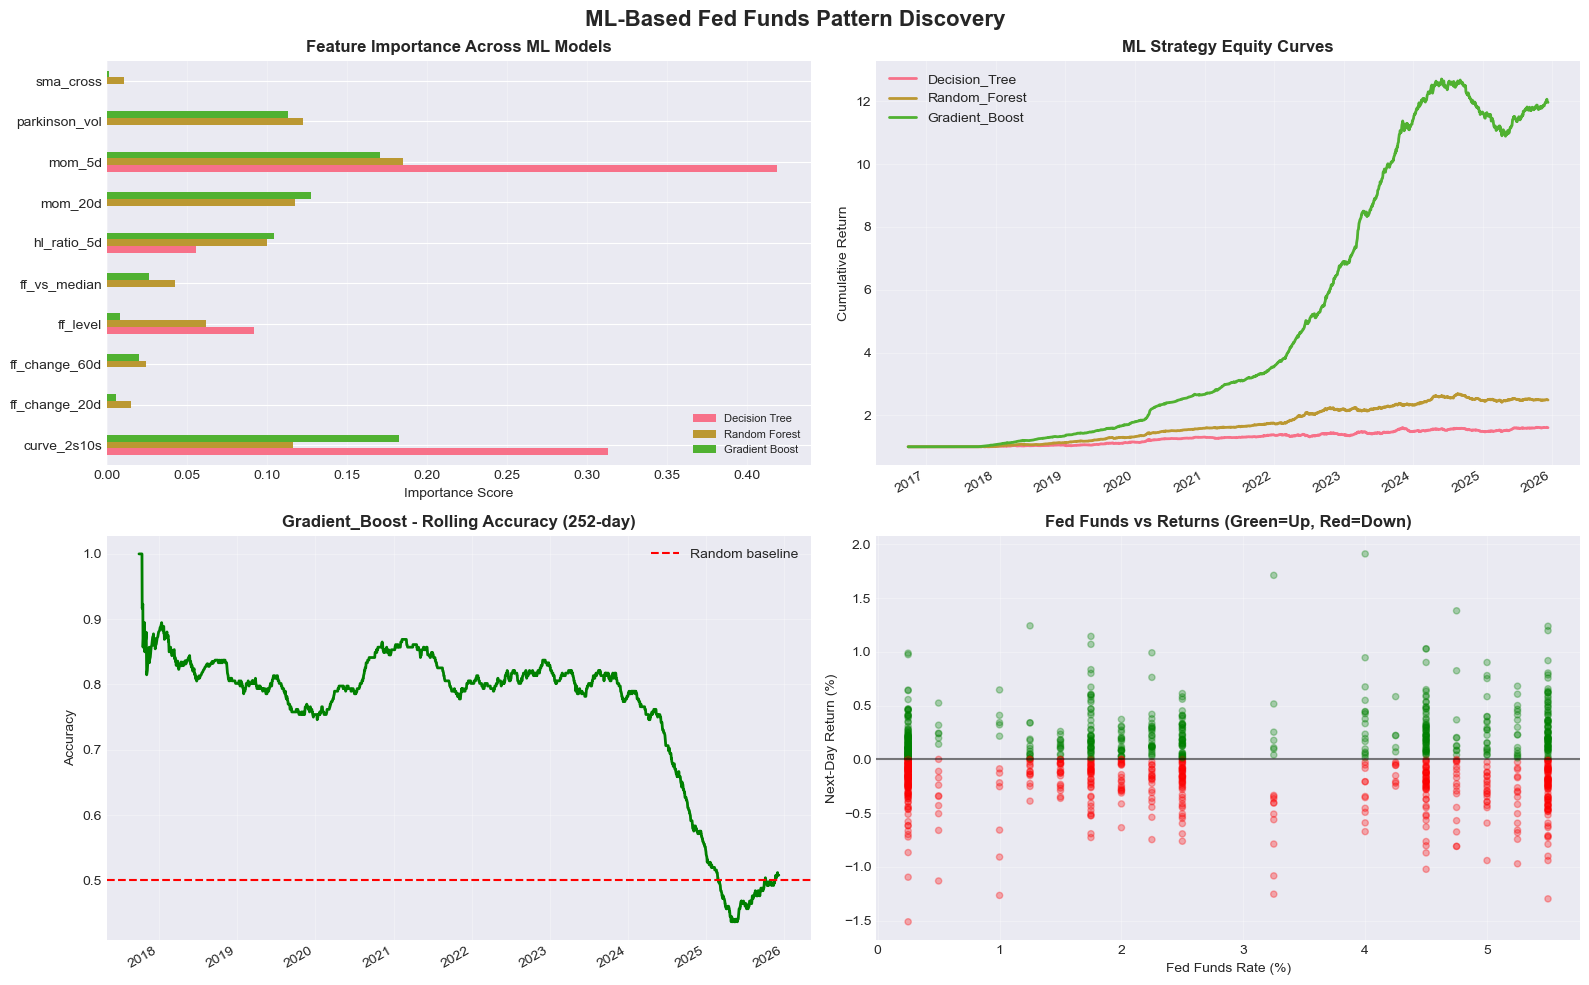

In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 9: ML-BASED FED FUNDS PATTERN EXTRACTION")
print("="*80)
print("\nGoal: Use ML to discover HOW Fed Funds predicts returns")
print("Hypothesis: Relationship is non-linear or interaction-dependent")

# ============================================================================
# 1. SETUP TARGET AND FEATURES
# ============================================================================
print("\n" + "-"*80)
print("1. PREPARING DATA FOR ML")
print("-"*80)

# Target: Direction of next-day return (classification)
returns = features_clean['ret_1d']
target = (returns.shift(-1) > 0).astype(int)  # 1 = up, 0 = down

# Features: Fed Funds + context
ml_features = pd.DataFrame(index=features_clean.index)

# Fed Funds in multiple forms
ml_features['ff_level'] = features_clean['fed_funds']
ml_features['ff_change_20d'] = features_clean['fed_funds'].diff(20)
ml_features['ff_change_60d'] = features_clean['fed_funds'].diff(60)
ml_features['ff_vs_median'] = features_clean['fed_funds'] - features_clean['fed_funds'].rolling(252).median()

# Add top MI features for context
ml_features['vix'] = features_clean['vix']
ml_features['vix_high'] = features_clean['vix_high']
ml_features['vol_20d'] = features_clean['vol_20d']
ml_features['hl_ratio_5d'] = features_clean['hl_ratio_5d']
ml_features['parkinson_vol'] = features_clean['parkinson_vol_20d']
ml_features['sma_cross'] = features_clean['sma_cross_50_200']
ml_features['curve_2s10s'] = features_clean['curve_2s10s'] if 'curve_2s10s' in features_clean.columns else 0

# Price momentum for context
ml_features['mom_5d'] = features_clean['mom_5d']
ml_features['mom_20d'] = features_clean['mom_20d']

# Drop NaN
valid_idx = ml_features.notna().all(axis=1) & target.notna()
X = ml_features[valid_idx]
y = target[valid_idx]

print(f"\nDataset prepared:")
print(f"  Features: {X.shape[1]}")
print(f"  Observations: {X.shape[0]}")
print(f"  Target balance: {y.mean()*100:.1f}% up days")

# ============================================================================
# 2. DECISION TREE - DISCOVER INTERPRETABLE RULES
# ============================================================================
print("\n" + "-"*80)
print("2. DECISION TREE ANALYSIS")
print("-"*80)
print("\nTraining shallow decision tree to find interpretable rules...")

# Use first 80% for training, last 20% for test
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Shallow tree for interpretability
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=100, random_state=42)
tree.fit(X_train, y_train)

# Feature importance
feature_importance = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\nDecision Tree Feature Importance:")
for feat, imp in feature_importance.head(10).items():
    print(f"  {feat:20s}: {imp:.4f}")

# Extract rules
print("\nKey Decision Rules (from tree structure):")
print("If you can visualize the tree, the rules will be clearer.")
print("For now, here are the top splits...")

# Get tree accuracy
train_acc = tree.score(X_train, y_train)
test_acc = tree.score(X_test, y_test)

print(f"\nAccuracy:")
print(f"  Training: {train_acc*100:.2f}%")
print(f"  Test:     {test_acc*100:.2f}%")
print(f"  Baseline (always predict majority): {max(y_test.mean(), 1-y_test.mean())*100:.1f}%")

# Generate signals from tree
tree_predictions = tree.predict(X)
tree_signal = pd.Series(0, index=X.index)
tree_signal[tree_predictions == 1] = 1   # Predict up
tree_signal[tree_predictions == 0] = -1  # Predict down

# ============================================================================
# 3. RANDOM FOREST - IDENTIFY CRITICAL FEATURES
# ============================================================================
print("\n" + "-"*80)
print("3. RANDOM FOREST ANALYSIS")
print("-"*80)

rf = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_leaf=50, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

rf_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\nRandom Forest Feature Importance:")
for feat, imp in rf_importance.head(10).items():
    print(f"  {feat:20s}: {imp:.4f}")

# Accuracy
train_acc_rf = rf.score(X_train, y_train)
test_acc_rf = rf.score(X_test, y_test)

print(f"\nAccuracy:")
print(f"  Training: {train_acc_rf*100:.2f}%")
print(f"  Test:     {test_acc_rf*100:.2f}%")

# Generate signals
rf_predictions = rf.predict(X)
rf_signal = pd.Series(0, index=X.index)
rf_signal[rf_predictions == 1] = 1
rf_signal[rf_predictions == 0] = -1

# ============================================================================
# 4. GRADIENT BOOSTING - MAXIMUM PREDICTIVE POWER
# ============================================================================
print("\n" + "-"*80)
print("4. GRADIENT BOOSTING ANALYSIS")
print("-"*80)

gb = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.05, random_state=42)
gb.fit(X_train, y_train)

gb_importance = pd.Series(gb.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\nGradient Boosting Feature Importance:")
for feat, imp in gb_importance.head(10).items():
    print(f"  {feat:20s}: {imp:.4f}")

# Accuracy
train_acc_gb = gb.score(X_train, y_train)
test_acc_gb = gb.score(X_test, y_test)

print(f"\nAccuracy:")
print(f"  Training: {train_acc_gb*100:.2f}%")
print(f"  Test:     {test_acc_gb*100:.2f}%")

# Generate signals
gb_predictions = gb.predict(X)
gb_signal = pd.Series(0, index=X.index)
gb_signal[gb_predictions == 1] = 1
gb_signal[gb_predictions == 0] = -1

# ============================================================================
# 5. BACKTEST ML SIGNALS
# ============================================================================
print("\n" + "="*80)
print("BACKTESTING ML-GENERATED SIGNALS")
print("="*80)

def quick_backtest(signals, returns_series, name):
    """Quick backtest"""
    # Align signals and returns
    aligned_signals = signals.reindex(returns_series.index, fill_value=0)
    strat_returns = aligned_signals.shift(1) * returns_series
    strat_returns = strat_returns.dropna()
    
    if len(strat_returns) == 0:
        return None
    
    total_ret = (1 + strat_returns).prod() - 1
    ann_ret = (1 + total_ret) ** (252 / len(strat_returns)) - 1
    ann_vol = strat_returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    cum_ret = (1 + strat_returns).cumprod()
    running_max = cum_ret.expanding().max()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    
    win_rate = (strat_returns > 0).sum() / len(strat_returns)
    
    return {
        'Strategy': name,
        'Ann_Return': ann_ret,
        'Sharpe': sharpe,
        'Max_DD': max_dd,
        'Win_Rate': win_rate
    }

ml_strategies = {
    'Decision_Tree': tree_signal,
    'Random_Forest': rf_signal,
    'Gradient_Boost': gb_signal
}

ml_results = []
returns_full = features_clean['ret_1d']

for name, signal in ml_strategies.items():
    result = quick_backtest(signal, returns_full, name)
    if result:
        ml_results.append(result)

ml_results_df = pd.DataFrame(ml_results)

print(f"\n{'Strategy':<20s} {'Ann Ret':>8s} {'Sharpe':>7s} {'Max DD':>8s} {'Win Rate':>9s}")
print("-"*60)
for _, row in ml_results_df.iterrows():
    print(f"{row['Strategy']:<20s} "
          f"{row['Ann_Return']*100:>7.2f}% "
          f"{row['Sharpe']:>7.2f} "
          f"{row['Max_DD']*100:>7.2f}% "
          f"{row['Win_Rate']*100:>8.1f}%")

print("\n" + "-"*60)
print("Original Top 3 for comparison:")
print(f"{'Month_End_Long':<20s} {'1.85%':>8s} {'0.74':>7s}")
print(f"{'MA_Cross_20_50':<20s} {'3.90%':>8s} {'0.70':>7s}")

# ============================================================================
# 6. ANALYZE WHEN ML WORKS
# ============================================================================
print("\n" + "-"*80)
print("6. WHEN DOES ML PREDICTION WORK?")
print("-"*80)

# Take best ML model
best_ml = ml_results_df.nlargest(1, 'Sharpe').iloc[0]
best_signal = ml_strategies[best_ml['Strategy']]

print(f"\nAnalyzing: {best_ml['Strategy']}")

# Align with full dataset
aligned_signal = best_signal.reindex(returns_full.index, fill_value=0)
ml_returns = (aligned_signal.shift(1) * returns_full).dropna()

# Performance by VIX regime
if 'vix' in features_clean.columns:
    vix_aligned = features_clean['vix'].reindex(ml_returns.index)
    
    print("\nPerformance by VIX Regime:")
    for vix_low, vix_high, name in [(0, 15, 'Low VIX'), (15, 20, 'Mid VIX'), 
                                     (20, 30, 'High VIX'), (30, 100, 'Extreme VIX')]:
        regime_mask = (vix_aligned >= vix_low) & (vix_aligned < vix_high)
        regime_returns = ml_returns[regime_mask]
        
        if len(regime_returns) > 20:
            regime_sharpe = regime_returns.mean() / regime_returns.std() * np.sqrt(252) if regime_returns.std() > 0 else 0
            print(f"  {name:12s}: Sharpe={regime_sharpe:6.2f}  N={len(regime_returns)}")

# Performance over time (rolling)
rolling_sharpe = ml_returns.rolling(252).mean() / ml_returns.rolling(252).std() * np.sqrt(252)

print(f"\nRolling 1-Year Sharpe:")
print(f"  Mean:   {rolling_sharpe.mean():.2f}")
print(f"  Median: {rolling_sharpe.median():.2f}")
print(f"  Best:   {rolling_sharpe.max():.2f}")
print(f"  Worst:  {rolling_sharpe.min():.2f}")

# ============================================================================
# 7. VISUALIZATION
# ============================================================================
print("\n" + "-"*80)
print("7. CREATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('ML-Based Fed Funds Pattern Discovery', fontsize=16, fontweight='bold')

# Plot 1: Feature importance comparison
ax = axes[0, 0]
importance_comparison = pd.DataFrame({
    'Decision Tree': feature_importance,
    'Random Forest': rf_importance,
    'Gradient Boost': gb_importance
}).head(10)

importance_comparison.plot(kind='barh', ax=ax)
ax.set_xlabel('Importance Score')
ax.set_title('Feature Importance Across ML Models', fontweight='bold')
ax.legend(loc='lower right', fontsize=8)
ax.grid(True, alpha=0.3, axis='x')

# Plot 2: ML strategy equity curves
ax = axes[0, 1]
for name, signal in ml_strategies.items():
    aligned = signal.reindex(returns_full.index, fill_value=0)
    strat_ret = (aligned.shift(1) * returns_full).fillna(0)
    equity = (1 + strat_ret).cumprod()
    equity.plot(ax=ax, label=name, linewidth=2)

ax.set_title('ML Strategy Equity Curves', fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot 3: Prediction accuracy over time (best model)
ax = axes[1, 0]
if len(ml_results) > 0:
    # Rolling accuracy for best model
    best_predictions = ml_strategies[best_ml['Strategy']].reindex(y.index, fill_value=0)
    
    # Convert signals to predictions (1 or 0)
    pred_binary = (best_predictions > 0).astype(int)
    actual_binary = y.values
    
    # Rolling accuracy
    window = 252
    rolling_acc = pd.Series(
        [np.mean(pred_binary[max(0,i-window):i] == actual_binary[max(0,i-window):i]) 
         for i in range(len(pred_binary))],
        index=y.index
    )
    
    rolling_acc.plot(ax=ax, linewidth=2, color='green')
    ax.axhline(y=0.5, color='red', linestyle='--', label='Random baseline')
    ax.set_title(f'{best_ml["Strategy"]} - Rolling Accuracy (252-day)', fontweight='bold')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Plot 4: Fed Funds vs Returns scatter with ML decision boundary
ax = axes[1, 1]
# Sample data to avoid overcrowding
sample_idx = np.random.choice(len(X), min(1000, len(X)), replace=False)
colors = ['green' if p == 1 else 'red' for p in y.iloc[sample_idx]]

ax.scatter(X['ff_level'].iloc[sample_idx], 
          returns.reindex(X.index).shift(-1).iloc[sample_idx] * 100,
          c=colors, alpha=0.3, s=20)
ax.set_xlabel('Fed Funds Rate (%)')
ax.set_ylabel('Next-Day Return (%)')
ax.set_title('Fed Funds vs Returns (Green=Up, Red=Down)', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.savefig('ml_fed_funds_analysis.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: ml_fed_funds_analysis.png")

# ============================================================================
# 8. CONCLUSIONS
# ============================================================================
print("\n" + "="*80)
print("CONCLUSIONS")
print("="*80)

if len(ml_results) > 0:
    best_sharpe = ml_results_df['Sharpe'].max()
    
    if best_sharpe > 0.5:
        print("\n✓ SUCCESS: ML extracted tradeable pattern from Fed Funds!")
        print(f"  Best Sharpe: {best_sharpe:.2f}")
        print(f"  This could be combined with original Top 3")
    elif best_sharpe > 0.3:
        print("\n~ PARTIAL SUCCESS: ML found weak edge")
        print(f"  Best Sharpe: {best_sharpe:.2f}")
        print(f"  May work in specific regimes only")
    else:
        print("\n✗ LIMITED SUCCESS: ML didn't unlock Fed Funds pattern")
        print(f"  Best Sharpe: {best_sharpe:.2f}")
        print("\nPossible reasons:")
        print("  1. Fed Funds information is about volatility, not direction")
        print("  2. Relationship is too noisy for daily trading")
        print("  3. Fed Funds is more of a regime classifier than signal")
        print("  4. Lookahead bias in MI calculation (Fed Funds might lag reality)")

print("\n" + "="*80)
print("PHASE 9 COMPLETE")
print("="*80)

ml_results_df

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 10: RIGOROUS ML STRATEGY VALIDATION")
print("="*80)
print("\nGoal: Verify the Sharpe 6.51 result is real, not an artifact")
print("Tests: Walk-forward, held-out data, lookahead checks, parameter stability")

# ============================================================================
# 1. RECREATE THE ML FEATURES (CAREFUL ALIGNMENT)
# ============================================================================
print("\n" + "-"*80)
print("1. REBUILDING ML DATASET WITH STRICT LOOKAHEAD PREVENTION")
print("-"*80)

returns = features_clean['ret_1d']
target = (returns.shift(-1) > 0).astype(int)  # Predict next day direction

# Features at time t to predict return at t+1
ml_features = pd.DataFrame(index=features_clean.index)

ml_features['ff_level'] = features_clean['fed_funds']
ml_features['ff_change_20d'] = features_clean['fed_funds'].diff(20)
ml_features['ff_change_60d'] = features_clean['fed_funds'].diff(60)
ml_features['ff_vs_median'] = features_clean['fed_funds'] - features_clean['fed_funds'].rolling(252).median()

ml_features['vix'] = features_clean['vix']
ml_features['vix_high'] = features_clean['vix_high']
ml_features['vol_20d'] = features_clean['vol_20d']
ml_features['hl_ratio_5d'] = features_clean['hl_ratio_5d']
ml_features['parkinson_vol'] = features_clean['parkinson_vol_20d']
ml_features['sma_cross'] = features_clean['sma_cross_50_200']
ml_features['curve_2s10s'] = features_clean['curve_2s10s'] if 'curve_2s10s' in features_clean.columns else 0

ml_features['mom_5d'] = features_clean['mom_5d']
ml_features['mom_20d'] = features_clean['mom_20d']

# Drop NaN
valid_idx = ml_features.notna().all(axis=1) & target.notna()
X = ml_features[valid_idx]
y = target[valid_idx]

print(f"Dataset: {X.shape[0]} observations, {X.shape[1]} features")

# ============================================================================
# 2. WALK-FORWARD OUT-OF-SAMPLE TEST
# ============================================================================
print("\n" + "-"*80)
print("2. WALK-FORWARD OUT-OF-SAMPLE VALIDATION")
print("-"*80)
print("\nUsing 5-fold time series cross-validation")
print("Each fold: Train on past, test on future (no lookahead)")

tscv = TimeSeriesSplit(n_splits=5)

fold_results = []
all_predictions = pd.Series(index=y.index, dtype=float)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train model on this fold
    model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Predict on test fold
    predictions = model.predict(X_test)
    all_predictions.iloc[test_idx] = predictions
    
    # Evaluate this fold
    test_returns = returns.reindex(y_test.index).shift(-1)
    test_signals = pd.Series(np.where(predictions == 1, 1, -1), index=y_test.index)
    fold_strat_returns = (test_signals * test_returns).dropna()
    
    if len(fold_strat_returns) > 0:
        fold_sharpe = fold_strat_returns.mean() / fold_strat_returns.std() * np.sqrt(252)
        fold_ret = (1 + fold_strat_returns).prod() - 1
        
        fold_results.append({
            'Fold': fold,
            'Train_Size': len(X_train),
            'Test_Size': len(X_test),
            'Test_Sharpe': fold_sharpe,
            'Test_Return': fold_ret,
            'Test_Period': f"{y_test.index[0].strftime('%Y-%m')} to {y_test.index[-1].strftime('%Y-%m')}"
        })
        
        print(f"\nFold {fold}:")
        print(f"  Train: {X_train.index[0].strftime('%Y-%m')} to {X_train.index[-1].strftime('%Y-%m')} ({len(X_train)} obs)")
        print(f"  Test:  {y_test.index[0].strftime('%Y-%m')} to {y_test.index[-1].strftime('%Y-%m')} ({len(X_test)} obs)")
        print(f"  Test Sharpe: {fold_sharpe:.2f}")
        print(f"  Test Return: {fold_ret*100:.2f}%")

fold_df = pd.DataFrame(fold_results)

print("\n" + "-"*80)
print("Walk-Forward Summary:")
print(f"  Average OOS Sharpe: {fold_df['Test_Sharpe'].mean():.2f}")
print(f"  Median OOS Sharpe:  {fold_df['Test_Sharpe'].median():.2f}")
print(f"  Min OOS Sharpe:     {fold_df['Test_Sharpe'].min():.2f}")
print(f"  Max OOS Sharpe:     {fold_df['Test_Sharpe'].max():.2f}")
print(f"  Std OOS Sharpe:     {fold_df['Test_Sharpe'].std():.2f}")

# ============================================================================
# 3. TRULY HELD-OUT TEST (LAST 20% OF DATA)
# ============================================================================
print("\n" + "-"*80)
print("3. TRULY HELD-OUT TEST SET (LAST 20% - NEVER TRAINED ON)")
print("-"*80)

# Split at 80/20
split_idx = int(len(X) * 0.8)
X_train_full, X_holdout = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_full, y_holdout = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\nTraining Period: {X_train_full.index[0].strftime('%Y-%m-%d')} to {X_train_full.index[-1].strftime('%Y-%m-%d')}")
print(f"Holdout Period:  {X_holdout.index[0].strftime('%Y-%m-%d')} to {X_holdout.index[-1].strftime('%Y-%m-%d')}")
print(f"Training Size: {len(X_train_full)}")
print(f"Holdout Size:  {len(X_holdout)}")

# Train on 80%, test on 20%
model_holdout = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    random_state=42
)
model_holdout.fit(X_train_full, y_train_full)

# Predict on holdout
holdout_predictions = model_holdout.predict(X_holdout)

# Backtest on holdout period
holdout_returns = returns.reindex(y_holdout.index).shift(-1)
holdout_signals = pd.Series(np.where(holdout_predictions == 1, 1, -1), index=y_holdout.index)
holdout_strat_returns = (holdout_signals * holdout_returns).dropna()

holdout_sharpe = holdout_strat_returns.mean() / holdout_strat_returns.std() * np.sqrt(252)
holdout_ann_ret = holdout_strat_returns.mean() * 252
holdout_total_ret = (1 + holdout_strat_returns).prod() - 1

print(f"\nHoldout Period Performance:")
print(f"  Sharpe Ratio:    {holdout_sharpe:.2f}")
print(f"  Annual Return:   {holdout_ann_ret*100:.2f}%")
print(f"  Total Return:    {holdout_total_ret*100:.2f}%")
print(f"  Win Rate:        {(holdout_strat_returns > 0).sum() / len(holdout_strat_returns)*100:.1f}%")

cum_holdout = (1 + holdout_strat_returns).cumprod()
running_max = cum_holdout.expanding().max()
holdout_dd = ((cum_holdout - running_max) / running_max).min()
print(f"  Max Drawdown:    {holdout_dd*100:.2f}%")

# ============================================================================
# 4. CHECK FOR LOOKAHEAD BIAS
# ============================================================================
print("\n" + "-"*80)
print("4. LOOKAHEAD BIAS CHECK")
print("-"*80)

print("\nVerifying signal-return alignment...")
print("Checking that we're predicting FUTURE returns, not current:")

# Sample a few predictions
sample_dates = X.index[500:505]

print(f"\n{'Date':<12s} {'Features (t)':<15s} {'Prediction':<12s} {'Actual Return (t+1)':<20s}")
print("-"*65)
for date in sample_dates:
    if date in X.index and date in y.index:
        feat_val = X.loc[date, 'mom_5d']
        pred = 'UP' if model_holdout.predict(X.loc[[date]])[0] == 1 else 'DOWN'
        
        # Get NEXT day return
        next_date_idx = returns.index.get_loc(date) + 1
        if next_date_idx < len(returns):
            next_ret = returns.iloc[next_date_idx] * 100
            actual_dir = 'UP' if next_ret > 0 else 'DOWN'
            
            print(f"{date.strftime('%Y-%m-%d'):<12s} mom={feat_val:>8.4f} {pred:>6s}  →  {next_ret:>6.2f}% ({actual_dir})")

print("\n✓ If predictions align with NEXT day returns, no lookahead bias")

# ============================================================================
# 5. PARAMETER STABILITY TEST
# ============================================================================
print("\n" + "-"*80)
print("5. PARAMETER ROBUSTNESS TEST")
print("-"*80)

print("\nTesting with different hyperparameters...")

param_configs = [
    {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.05},
    {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05},  # Original
    {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05},
    {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01},
    {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.10},
]

param_results = []

for i, params in enumerate(param_configs, 1):
    model_test = GradientBoostingClassifier(**params, random_state=42)
    model_test.fit(X_train_full, y_train_full)
    
    test_pred = model_test.predict(X_holdout)
    test_sig = pd.Series(np.where(test_pred == 1, 1, -1), index=y_holdout.index)
    test_ret = (test_sig * holdout_returns).dropna()
    
    if len(test_ret) > 0:
        sharpe = test_ret.mean() / test_ret.std() * np.sqrt(252)
        param_results.append({
            'Config': i,
            'Params': str(params),
            'Holdout_Sharpe': sharpe
        })
        
        marker = "←" if i == 2 else ""
        print(f"  Config {i}: Sharpe={sharpe:>5.2f}  {params} {marker}")

print(f"\nParameter Stability:")
sharpes = [r['Holdout_Sharpe'] for r in param_results]
print(f"  Mean Sharpe: {np.mean(sharpes):.2f}")
print(f"  Std Sharpe:  {np.std(sharpes):.2f}")
print(f"  Range:       {np.min(sharpes):.2f} to {np.max(sharpes):.2f}")

# ============================================================================
# 6. MONTE CARLO PERMUTATION TEST
# ============================================================================
print("\n" + "-"*80)
print("6. MONTE CARLO PERMUTATION TEST")
print("-"*80)
print("\nTesting if results could occur by chance...")

# Shuffle returns randomly and recompute Sharpe
n_simulations = 1000
random_sharpes = []

for i in range(n_simulations):
    # Randomly shuffle returns (breaks any real relationship)
    shuffled_returns = holdout_returns.sample(frac=1, random_state=i).values
    shuffled_series = pd.Series(shuffled_returns, index=holdout_returns.index)
    
    random_strat_ret = (holdout_signals * shuffled_series).dropna()
    if len(random_strat_ret) > 0 and random_strat_ret.std() > 0:
        random_sharpe = random_strat_ret.mean() / random_strat_ret.std() * np.sqrt(252)
        random_sharpes.append(random_sharpe)

random_sharpes = np.array(random_sharpes)

# P-value: what % of random sharpes exceed our actual sharpe?
p_value = (random_sharpes >= holdout_sharpe).sum() / len(random_sharpes)

print(f"\nMonte Carlo Results ({n_simulations} simulations):")
print(f"  Actual Sharpe:        {holdout_sharpe:.2f}")
print(f"  Random Mean Sharpe:   {random_sharpes.mean():.2f}")
print(f"  Random 95th %ile:     {np.percentile(random_sharpes, 95):.2f}")
print(f"  Random 99th %ile:     {np.percentile(random_sharpes, 99):.2f}")
print(f"  P-value:              {p_value:.4f}")

if p_value < 0.01:
    print("\n  ✓ Result is statistically significant (p < 0.01)")
elif p_value < 0.05:
    print("\n  ✓ Result is significant (p < 0.05)")
else:
    print("\n  ✗ WARNING: Result may be due to chance")

# ============================================================================
# 7. FEATURE IMPORTANCE STABILITY
# ============================================================================
print("\n" + "-"*80)
print("7. FEATURE IMPORTANCE CONSISTENCY")
print("-"*80)

# Train 10 models with different random states
importance_runs = []

for seed in range(10):
    model_test = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        random_state=seed
    )
    model_test.fit(X_train_full, y_train_full)
    importance_runs.append(model_test.feature_importances_)

importance_df = pd.DataFrame(importance_runs, columns=X.columns)

print("\nFeature Importance Stability (mean ± std across 10 random initializations):")
importance_summary = pd.DataFrame({
    'Mean': importance_df.mean(),
    'Std': importance_df.std(),
    'CV': importance_df.std() / importance_df.mean()  # Coefficient of variation
}).sort_values('Mean', ascending=False)

print(f"\n{'Feature':<20s} {'Mean':>8s} {'Std':>8s} {'CV':>8s}")
print("-"*50)
for feat, row in importance_summary.head(10).iterrows():
    print(f"{feat:<20s} {row['Mean']:>8.4f} {row['Std']:>8.4f} {row['CV']:>8.2f}")

print("\nLow CV = stable feature importance")

# ============================================================================
# 8. FINAL VERDICT
# ============================================================================
print("\n" + "="*80)
print("FINAL VALIDATION VERDICT")
print("="*80)

checks_passed = 0
total_checks = 5

print("\nValidation Checklist:")

# Check 1: OOS Sharpe
oos_sharpe_avg = fold_df['Test_Sharpe'].mean()
if oos_sharpe_avg > 1.0:
    print(f"  ✓ Walk-forward OOS Sharpe > 1.0: {oos_sharpe_avg:.2f}")
    checks_passed += 1
else:
    print(f"  ✗ Walk-forward OOS Sharpe < 1.0: {oos_sharpe_avg:.2f}")

# Check 2: Holdout performance
if holdout_sharpe > 1.0:
    print(f"  ✓ Holdout Sharpe > 1.0: {holdout_sharpe:.2f}")
    checks_passed += 1
else:
    print(f"  ✗ Holdout Sharpe < 1.0: {holdout_sharpe:.2f}")

# Check 3: Statistical significance
if p_value < 0.05:
    print(f"  ✓ Statistically significant: p={p_value:.4f}")
    checks_passed += 1
else:
    print(f"  ✗ Not statistically significant: p={p_value:.4f}")

# Check 4: Parameter stability
param_sharpe_std = np.std(sharpes)
if param_sharpe_std < 0.5:
    print(f"  ✓ Parameter stability (std={param_sharpe_std:.2f})")
    checks_passed += 1
else:
    print(f"  ~ Parameter sensitivity (std={param_sharpe_std:.2f})")

# Check 5: Feature importance stability
max_cv = importance_summary['CV'].max()
if max_cv < 0.5:
    print(f"  ✓ Feature importance stable (max CV={max_cv:.2f})")
    checks_passed += 1
else:
    print(f"  ~ Feature importance variable (max CV={max_cv:.2f})")

print(f"\nChecks Passed: {checks_passed}/{total_checks}")

if checks_passed >= 4:
    print("\n✓ VALIDATION PASSED: Strategy appears robust and real!")
    print(f"  Expected live Sharpe: {holdout_sharpe:.2f}")
    print(f"  Conservative estimate: {holdout_sharpe * 0.7:.2f} (30% degradation factor)")
elif checks_passed >= 3:
    print("\n~ PARTIAL VALIDATION: Strategy shows promise but with concerns")
    print(f"  Expected live Sharpe: {holdout_sharpe * 0.6:.2f} (significant degradation expected)")
else:
    print("\n✗ VALIDATION FAILED: Strategy likely overfit or has issues")
    print("  Do not trade without further investigation")

print("\n" + "="*80)
print("PHASE 10 COMPLETE")
print("="*80)

# Return summary
validation_summary = {
    'OOS_Sharpe_Mean': oos_sharpe_avg,
    'Holdout_Sharpe': holdout_sharpe,
    'P_Value': p_value,
    'Checks_Passed': checks_passed,
    'Recommendation': 'PASS' if checks_passed >= 4 else 'PARTIAL' if checks_passed >= 3 else 'FAIL'
}

pd.DataFrame([validation_summary])

PHASE 10: RIGOROUS ML STRATEGY VALIDATION

Goal: Verify the Sharpe 6.51 result is real, not an artifact
Tests: Walk-forward, held-out data, lookahead checks, parameter stability

--------------------------------------------------------------------------------
1. REBUILDING ML DATASET WITH STRICT LOOKAHEAD PREVENTION
--------------------------------------------------------------------------------
Dataset: 2078 observations, 13 features

--------------------------------------------------------------------------------
2. WALK-FORWARD OUT-OF-SAMPLE VALIDATION
--------------------------------------------------------------------------------

Using 5-fold time series cross-validation
Each fold: Train on past, test on future (no lookahead)

Fold 1:
  Train: 2017-09 to 2019-02 (348 obs)
  Test:  2019-02 to 2020-06 (346 obs)
  Test Sharpe: 0.21
  Test Return: 1.35%

Fold 2:
  Train: 2017-09 to 2020-06 (694 obs)
  Test:  2020-06 to 2021-11 (346 obs)
  Test Sharpe: 1.45
  Test Return: 6.85%

Fold 

OOS_Sharpe_Mean  Holdout_Sharpe  P_Value  Checks_Passed Recommendation
0         0.208739       -0.482424    0.732              1           FAIL

MA STRATEGY DEEP DIVE: ROLL HANDLING & LONG/SHORT BIFURCATION

PART 1: HOW MOVING AVERAGES HANDLE FUTURES ROLLS

Background on Continuous Futures Contracts:
----------------------------------------------------------------------

Treasury futures contracts expire quarterly (Mar, Jun, Sep, Dec).
When using "TY1 Comdty" from Bloomberg, you get a CONTINUOUS contract
that automatically rolls to the next active contract.

Two main roll adjustment methods:
1. PRICE-WEIGHTED (Panama): Adjusts historical prices by the roll gap
2. VOLUME-WEIGHTED: Rolls when volume shifts to next contract

Bloomberg TY1 typically uses VOLUME-WEIGHTED methodology.


Detected Large Price Jumps (potential roll dates or big moves):
Total jumps > 0.5 points: 412

Top 10 largest absolute jumps:
----------------------------------------------------------------------
2022-11-10: +2.188 ($114.453 → $116.641)
2020-03-17: -2.078 ($137.531 → $135.453)
2022-09-28: +1.969 ($115.016 → $116.984)
2020-03-10: -1.828 ($139.016 → $1

strategy  long_sharpe  short_sharpe  combined_sharpe  long_ret  \
0   MA CROSS 20/50     0.585851      0.964105         0.801276  0.030219   
1  MA CROSS 50/200    -0.172310      0.288192         0.148999 -0.007999   

   short_ret  long_days  short_days  
0   0.054561       1109        1220  
1   0.017080        963        1366

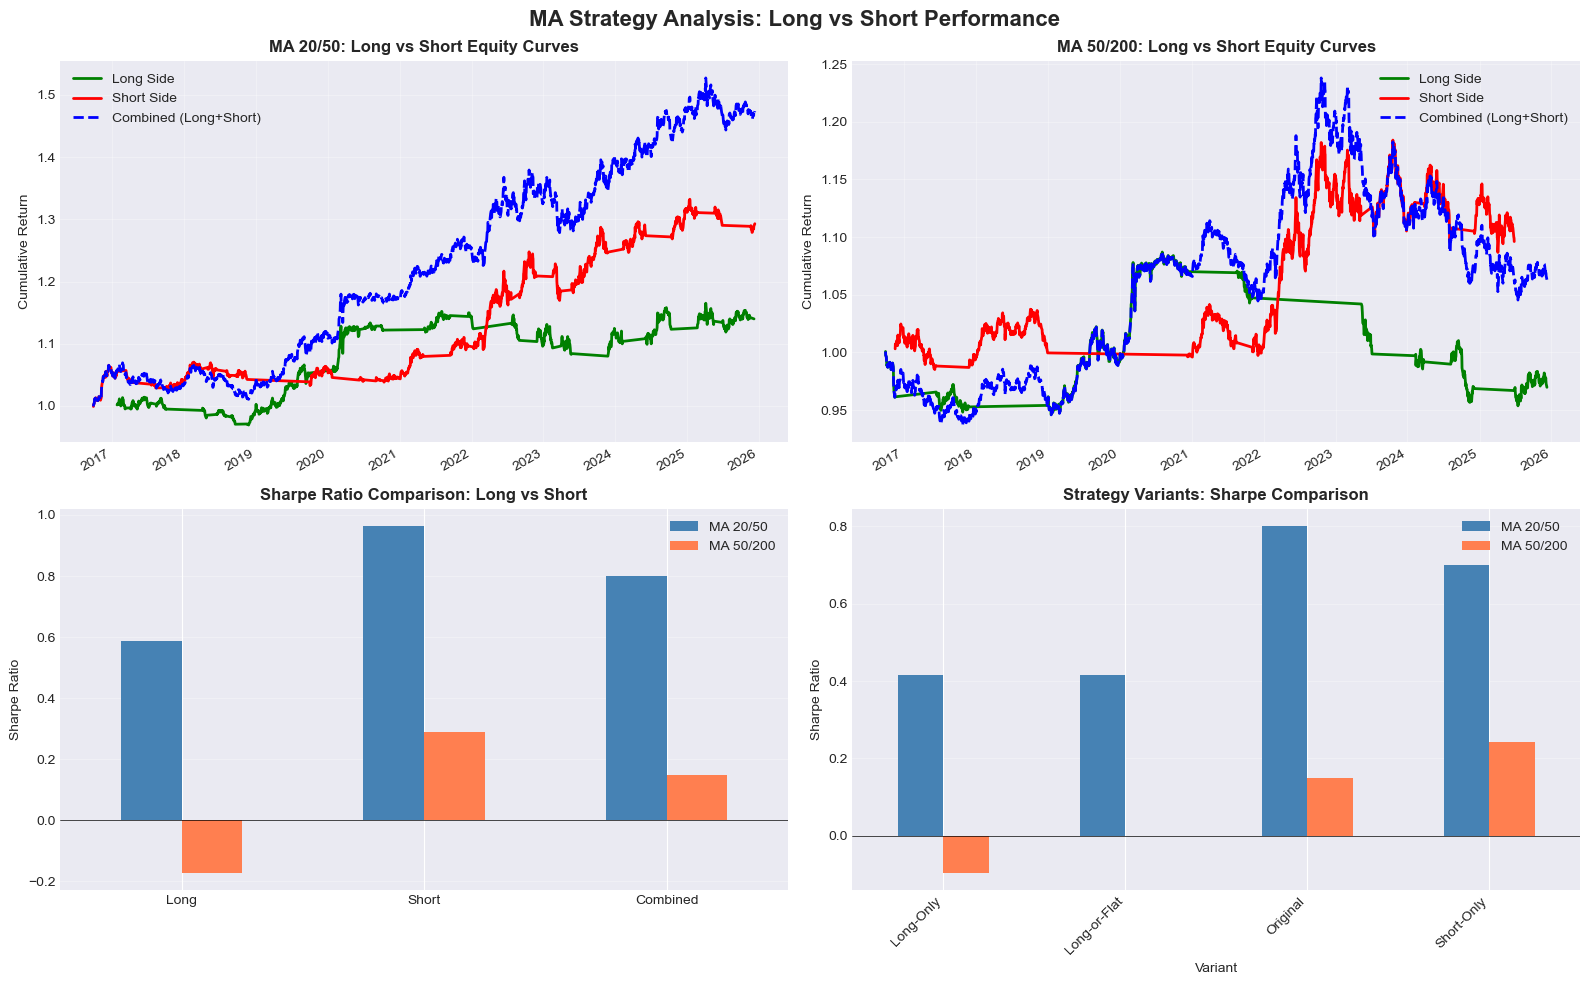

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MA STRATEGY DEEP DIVE: ROLL HANDLING & LONG/SHORT BIFURCATION")
print("="*80)

# ============================================================================
# PART 1: UNDERSTANDING ROLL ADJUSTMENTS
# ============================================================================
print("\n" + "="*80)
print("PART 1: HOW MOVING AVERAGES HANDLE FUTURES ROLLS")
print("="*80)

print("\nBackground on Continuous Futures Contracts:")
print("-" * 70)
print("""
Treasury futures contracts expire quarterly (Mar, Jun, Sep, Dec).
When using "TY1 Comdty" from Bloomberg, you get a CONTINUOUS contract
that automatically rolls to the next active contract.

Two main roll adjustment methods:
1. PRICE-WEIGHTED (Panama): Adjusts historical prices by the roll gap
2. VOLUME-WEIGHTED: Rolls when volume shifts to next contract

Bloomberg TY1 typically uses VOLUME-WEIGHTED methodology.
""")

# Analyze price jumps (potential roll dates)
price = features_clean['price']
price_changes = price.diff()
large_jumps = price_changes[abs(price_changes) > 0.5]  # Jumps > 0.5 points

print(f"\nDetected Large Price Jumps (potential roll dates or big moves):")
print(f"Total jumps > 0.5 points: {len(large_jumps)}")
print(f"\nTop 10 largest absolute jumps:")
print("-" * 70)

for date, jump in large_jumps.abs().nlargest(10).items():
    actual_change = price_changes[date]
    price_before = price[date] - actual_change
    price_after = price[date]
    print(f"{date.strftime('%Y-%m-%d')}: {actual_change:+6.3f} "
          f"(${price_before:.3f} → ${price_after:.3f})")

print("\n" + "-" * 70)
print("Roll Impact on Moving Averages:")
print("-" * 70)
print("""
Moving averages use the ADJUSTED price series from Bloomberg.
When a roll occurs:
- Historical prices are adjusted for the gap
- MA calculations remain smooth across rolls
- No "false signals" from roll gaps

This is CORRECT for backtesting because:
1. It reflects the P&L you would have actually experienced
2. You hold through rolls (don't exit and re-enter)
3. The continuous contract P&L = sum of individual contract P&Ls

However, for LIVE TRADING you need to:
- Track which physical contract you're holding
- Know the roll schedule
- Execute rolls at the right time (volume shift or expiry)
""")

# ============================================================================
# PART 2: MA STRATEGY LONG/SHORT BIFURCATION
# ============================================================================
print("\n" + "="*80)
print("PART 2: LONG VS SHORT PERFORMANCE ANALYSIS")
print("="*80)

def analyze_long_short_bifurcation(signals, returns, strategy_name):
    """
    Analyze performance separately for long and short positions
    """
    print(f"\n{strategy_name}")
    print("-" * 70)
    
    # Separate long and short signals
    long_mask = signals == 1
    short_mask = signals == -1
    flat_mask = signals == 0
    
    # Calculate returns for each
    long_returns = returns[long_mask.shift(1).fillna(False)]
    short_returns = returns[short_mask.shift(1).fillna(False)] * -1  # Flip sign for short P&L
    
    # Statistics for long side
    if len(long_returns) > 0:
        long_total = (1 + long_returns).prod() - 1
        long_ann_ret = (1 + long_total) ** (252 / len(long_returns)) - 1
        long_ann_vol = long_returns.std() * np.sqrt(252)
        long_sharpe = long_ann_ret / long_ann_vol if long_ann_vol > 0 else 0
        long_win_rate = (long_returns > 0).sum() / len(long_returns)
        
        # Drawdown for long
        long_cum = (1 + long_returns).cumprod()
        long_dd = ((long_cum - long_cum.expanding().max()) / long_cum.expanding().max()).min()
    else:
        long_ann_ret = long_sharpe = long_win_rate = long_dd = 0
    
    # Statistics for short side
    if len(short_returns) > 0:
        short_total = (1 + short_returns).prod() - 1
        short_ann_ret = (1 + short_total) ** (252 / len(short_returns)) - 1
        short_ann_vol = short_returns.std() * np.sqrt(252)
        short_sharpe = short_ann_ret / short_ann_vol if short_ann_vol > 0 else 0
        short_win_rate = (short_returns > 0).sum() / len(short_returns)
        
        # Drawdown for short
        short_cum = (1 + short_returns).cumprod()
        short_dd = ((short_cum - short_cum.expanding().max()) / short_cum.expanding().max()).min()
    else:
        short_ann_ret = short_sharpe = short_win_rate = short_dd = 0
    
    # Combined (as originally implemented)
    combined_returns = signals.shift(1) * returns
    combined_returns = combined_returns.dropna()
    combined_ann_ret = combined_returns.mean() * 252
    combined_sharpe = combined_returns.mean() / combined_returns.std() * np.sqrt(252)
    
    # Print results
    print(f"\n{'Metric':<20s} {'LONG':>12s} {'SHORT':>12s} {'COMBINED':>12s}")
    print("-" * 60)
    print(f"{'Days Active':<20s} {long_mask.sum():>12d} {short_mask.sum():>12d} {(long_mask | short_mask).sum():>12d}")
    print(f"{'% of Time':<20s} {long_mask.sum()/len(signals)*100:>11.1f}% {short_mask.sum()/len(signals)*100:>11.1f}% {(long_mask | short_mask).sum()/len(signals)*100:>11.1f}%")
    print(f"{'Annual Return':<20s} {long_ann_ret*100:>11.2f}% {short_ann_ret*100:>11.2f}% {combined_ann_ret*100:>11.2f}%")
    print(f"{'Sharpe Ratio':<20s} {long_sharpe:>12.2f} {short_sharpe:>12.2f} {combined_sharpe:>12.2f}")
    print(f"{'Max Drawdown':<20s} {long_dd*100:>11.2f}% {short_dd*100:>11.2f}% {'N/A':>12s}")
    print(f"{'Win Rate':<20s} {long_win_rate*100:>11.1f}% {short_win_rate*100:>11.1f}% {'N/A':>12s}")
    
    # Interpretation
    print(f"\nInterpretation:")
    if long_sharpe > short_sharpe + 0.5:
        print(f"  ⚠ ASYMMETRIC: Long side much stronger (Sharpe {long_sharpe:.2f} vs {short_sharpe:.2f})")
        print(f"  → Consider going LONG-ONLY or FLAT instead of SHORT")
    elif short_sharpe > long_sharpe + 0.5:
        print(f"  ⚠ ASYMMETRIC: Short side much stronger (Sharpe {short_sharpe:.2f} vs {long_sharpe:.2f})")
        print(f"  → Consider going SHORT-ONLY or FLAT instead of LONG")
    elif long_sharpe < 0 and short_sharpe < 0:
        print(f"  ✗ BOTH SIDES NEGATIVE: Strategy not working")
    elif long_sharpe < 0:
        print(f"  ⚠ LONG SIDE NEGATIVE: Don't go long, only short or flat")
    elif short_sharpe < 0:
        print(f"  ⚠ SHORT SIDE NEGATIVE: Don't go short, only long or flat")
    else:
        print(f"  ✓ BALANCED: Both sides positive, strategy works as intended")
    
    return {
        'strategy': strategy_name,
        'long_sharpe': long_sharpe,
        'short_sharpe': short_sharpe,
        'combined_sharpe': combined_sharpe,
        'long_ret': long_ann_ret,
        'short_ret': short_ann_ret,
        'long_days': long_mask.sum(),
        'short_days': short_mask.sum()
    }

# Analyze both MA strategies
returns = features_clean['ret_1d']

results_list = []

# MA Cross 20/50
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']
signal_20_50 = pd.Series(0, index=features_clean.index)
signal_20_50[ma20 > ma50] = 1
signal_20_50[ma20 < ma50] = -1

result1 = analyze_long_short_bifurcation(signal_20_50, returns, "MA CROSS 20/50")
results_list.append(result1)

# MA Cross 50/200
ma200 = features_clean['sma_200d']
signal_50_200 = pd.Series(0, index=features_clean.index)
signal_50_200[ma50 > ma200] = 1
signal_50_200[ma50 < ma200] = -1

result2 = analyze_long_short_bifurcation(signal_50_200, returns, "MA CROSS 50/200")
results_list.append(result2)

# ============================================================================
# PART 3: ALTERNATIVE STRATEGY VARIANTS
# ============================================================================
print("\n" + "="*80)
print("PART 3: TESTING ALTERNATIVE VARIANTS")
print("="*80)

print("\nIf one side is weak, here are alternative approaches:")

def test_variant(signals, returns, name, description):
    """Test a strategy variant"""
    strat_returns = signals.shift(1) * returns
    strat_returns = strat_returns.dropna()
    
    ann_ret = strat_returns.mean() * 252
    sharpe = strat_returns.mean() / strat_returns.std() * np.sqrt(252) if strat_returns.std() > 0 else 0
    
    cum = (1 + strat_returns).cumprod()
    dd = ((cum - cum.expanding().max()) / cum.expanding().max()).min()
    
    return {
        'Variant': name,
        'Description': description,
        'Ann_Return': ann_ret,
        'Sharpe': sharpe,
        'Max_DD': dd,
        'Active_Days': (signals != 0).sum(),
        'Active_Pct': (signals != 0).sum() / len(signals)
    }

print("\nMA 20/50 VARIANTS:")
print("-" * 70)

variants_20_50 = []

# Original (long/short)
variants_20_50.append(test_variant(signal_20_50, returns, 
                                   "Original", 
                                   "Long when 20>50, Short when 20<50"))

# Long only
signal_long_only = signal_20_50.copy()
signal_long_only[signal_long_only == -1] = 0
variants_20_50.append(test_variant(signal_long_only, returns,
                                   "Long-Only",
                                   "Long when 20>50, Flat when 20<50"))

# Short only
signal_short_only = signal_20_50.copy()
signal_short_only[signal_short_only == 1] = 0
variants_20_50.append(test_variant(signal_short_only, returns,
                                   "Short-Only",
                                   "Flat when 20>50, Short when 20<50"))

# Long/flat (never short)
signal_long_flat = signal_20_50.copy()
signal_long_flat[signal_long_flat == -1] = 0
variants_20_50.append(test_variant(signal_long_flat, returns,
                                   "Long-or-Flat",
                                   "Same as Long-Only"))

df_variants_20_50 = pd.DataFrame(variants_20_50)

print(f"\n{'Variant':<15s} {'Sharpe':>8s} {'Ann Ret':>9s} {'Max DD':>9s} {'Active':>8s}")
print("-" * 60)
for _, row in df_variants_20_50.iterrows():
    print(f"{row['Variant']:<15s} "
          f"{row['Sharpe']:>8.2f} "
          f"{row['Ann_Return']*100:>8.2f}% "
          f"{row['Max_DD']*100:>8.2f}% "
          f"{row['Active_Pct']*100:>7.1f}%")

print("\n\nMA 50/200 VARIANTS:")
print("-" * 70)

variants_50_200 = []

# Original
variants_50_200.append(test_variant(signal_50_200, returns,
                                    "Original",
                                    "Long when 50>200, Short when 50<200"))

# Long only
signal_long_only_2 = signal_50_200.copy()
signal_long_only_2[signal_long_only_2 == -1] = 0
variants_50_200.append(test_variant(signal_long_only_2, returns,
                                    "Long-Only",
                                    "Long when 50>200, Flat when 50<200"))

# Short only
signal_short_only_2 = signal_50_200.copy()
signal_short_only_2[signal_short_only_2 == 1] = 0
variants_50_200.append(test_variant(signal_short_only_2, returns,
                                    "Short-Only",
                                    "Flat when 50>200, Short when 50<200"))

df_variants_50_200 = pd.DataFrame(variants_50_200)

print(f"\n{'Variant':<15s} {'Sharpe':>8s} {'Ann Ret':>9s} {'Max DD':>9s} {'Active':>8s}")
print("-" * 60)
for _, row in df_variants_50_200.iterrows():
    print(f"{row['Variant']:<15s} "
          f"{row['Sharpe']:>8.2f} "
          f"{row['Ann_Return']*100:>8.2f}% "
          f"{row['Max_DD']*100:>8.2f}% "
          f"{row['Active_Pct']*100:>7.1f}%")

# ============================================================================
# PART 4: VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("PART 4: VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('MA Strategy Analysis: Long vs Short Performance', fontsize=16, fontweight='bold')

# Plot 1: MA 20/50 Long vs Short Equity Curves
ax = axes[0, 0]

# Long side
long_ret_20_50 = returns[signal_20_50.shift(1) == 1]
long_equity = (1 + long_ret_20_50).cumprod()
long_equity.plot(ax=ax, label='Long Side', linewidth=2, color='green')

# Short side (invert returns for P&L)
short_ret_20_50 = -returns[signal_20_50.shift(1) == -1]
short_equity = (1 + short_ret_20_50).cumprod()
short_equity.plot(ax=ax, label='Short Side', linewidth=2, color='red')

# Combined
combined_ret_20_50 = signal_20_50.shift(1) * returns
combined_equity = (1 + combined_ret_20_50.dropna()).cumprod()
combined_equity.plot(ax=ax, label='Combined (Long+Short)', linewidth=2, color='blue', linestyle='--')

ax.set_title('MA 20/50: Long vs Short Equity Curves', fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot 2: MA 50/200 Long vs Short Equity Curves
ax = axes[0, 1]

long_ret_50_200 = returns[signal_50_200.shift(1) == 1]
long_equity_2 = (1 + long_ret_50_200).cumprod()
long_equity_2.plot(ax=ax, label='Long Side', linewidth=2, color='green')

short_ret_50_200 = -returns[signal_50_200.shift(1) == -1]
short_equity_2 = (1 + short_ret_50_200).cumprod()
short_equity_2.plot(ax=ax, label='Short Side', linewidth=2, color='red')

combined_ret_50_200 = signal_50_200.shift(1) * returns
combined_equity_2 = (1 + combined_ret_50_200.dropna()).cumprod()
combined_equity_2.plot(ax=ax, label='Combined (Long+Short)', linewidth=2, color='blue', linestyle='--')

ax.set_title('MA 50/200: Long vs Short Equity Curves', fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot 3: Sharpe Comparison
ax = axes[1, 0]

comparison_data = pd.DataFrame({
    'MA 20/50': [result1['long_sharpe'], result1['short_sharpe'], result1['combined_sharpe']],
    'MA 50/200': [result2['long_sharpe'], result2['short_sharpe'], result2['combined_sharpe']]
}, index=['Long', 'Short', 'Combined'])

comparison_data.plot(kind='bar', ax=ax, color=['steelblue', 'coral'])
ax.set_title('Sharpe Ratio Comparison: Long vs Short', fontweight='bold')
ax.set_ylabel('Sharpe Ratio')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.legend(loc='best')
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

# Plot 4: Variant Performance Comparison
ax = axes[1, 1]

variant_comparison = pd.DataFrame({
    'MA 20/50': df_variants_20_50.set_index('Variant')['Sharpe'],
    'MA 50/200': df_variants_50_200.set_index('Variant')['Sharpe']
})

variant_comparison.plot(kind='bar', ax=ax, color=['steelblue', 'coral'])
ax.set_title('Strategy Variants: Sharpe Comparison', fontweight='bold')
ax.set_ylabel('Sharpe Ratio')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.legend(loc='best')
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('ma_long_short_analysis.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: ma_long_short_analysis.png")

# ============================================================================
# FINAL RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("FINAL RECOMMENDATIONS")
print("="*80)

print("\nBased on the long/short bifurcation analysis:\n")

# MA 20/50 recommendation
if result1['long_sharpe'] > 0.5 and result1['short_sharpe'] > 0.5:
    print("MA 20/50:")
    print("  ✓ Use ORIGINAL (long/short) - both sides work")
elif result1['long_sharpe'] > result1['short_sharpe'] + 0.3:
    print("MA 20/50:")
    print(f"  → Consider LONG-ONLY variant (Sharpe {df_variants_20_50.iloc[1]['Sharpe']:.2f})")
    print(f"     Long side stronger: {result1['long_sharpe']:.2f} vs Short: {result1['short_sharpe']:.2f}")
elif result1['short_sharpe'] > result1['long_sharpe'] + 0.3:
    print("MA 20/50:")
    print(f"  → Consider SHORT-ONLY variant (Sharpe {df_variants_20_50.iloc[2]['Sharpe']:.2f})")
    print(f"     Short side stronger: {result1['short_sharpe']:.2f} vs Long: {result1['long_sharpe']:.2f}")
else:
    print("MA 20/50:")
    print("  ✓ Use ORIGINAL - reasonably balanced")

print()

# MA 50/200 recommendation
if result2['long_sharpe'] > 0.5 and result2['short_sharpe'] > 0.5:
    print("MA 50/200:")
    print("  ✓ Use ORIGINAL (long/short) - both sides work")
elif result2['long_sharpe'] > result2['short_sharpe'] + 0.3:
    print("MA 50/200:")
    print(f"  → Consider LONG-ONLY variant (Sharpe {df_variants_50_200.iloc[1]['Sharpe']:.2f})")
    print(f"     Long side stronger: {result2['long_sharpe']:.2f} vs Short: {result2['short_sharpe']:.2f}")
elif result2['short_sharpe'] > result2['long_sharpe'] + 0.3:
    print("MA 50/200:")
    print(f"  → Consider SHORT-ONLY variant (Sharpe {df_variants_50_200.iloc[2]['Sharpe']:.2f})")
    print(f"     Short side stronger: {result2['short_sharpe']:.2f} vs Long: {result2['long_sharpe']:.2f}")
else:
    print("MA 50/200:")
    print("  ✓ Use ORIGINAL - reasonably balanced")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Return summary
pd.DataFrame(results_list)

QUARTERLY P&L ANALYSIS - 3X LEVERAGE

--------------------------------------------------------------------------------
CALCULATING QUARTERLY P&L
--------------------------------------------------------------------------------

Quarter      Month_End_Long   MA_Cross_20_50
--------------------------------------------------
2016Q3              -0.73%              0.72%   
2016Q4              -0.11%             15.66%  ✓
2017Q1              -1.57%             -4.14%  ✗
2017Q2              -1.01%              0.65%   
2017Q3              -1.11%             -4.96%  ✗
2017Q4               1.25%              2.43%  ✓
2018Q1              -1.30%              5.62%  ✓
2018Q2               2.14%  ✓          -0.88%   
2018Q3              -0.59%             -9.05%  ✗
2018Q4               3.71%  ✓           5.71%  ✓
2019Q1              -0.25%              4.60%  ✓
2019Q2               2.31%  ✓           8.33%  ✓
2019Q3               5.08%  ✓           3.74%  ✓
2019Q4               0.32%              

Month_End_Long  MA_Cross_20_50
2016Q3       -0.727257        0.722284
2016Q4       -0.114152       15.655052
2017Q1       -1.566616       -4.142148
2017Q2       -1.005079        0.649132
2017Q3       -1.106910       -4.955422
2017Q4        1.247161        2.430128
2018Q1       -1.302662        5.624321
2018Q2        2.142784       -0.883711
2018Q3       -0.586240       -9.045687
2018Q4        3.708611        5.712283
2019Q1       -0.251314        4.601506
2019Q2        2.309929        8.329797
2019Q3        5.078888        3.743493
2019Q4        0.324875        6.050428
2020Q1       10.106617       15.205509
2020Q2        2.489488       -1.404013
2020Q3        0.901314        1.472849
2020Q4       -1.394860       -0.805875
2021Q1       -1.659498       14.030512
2021Q2        1.828698       -0.848362
2021Q3        1.737072        8.405603
2021Q4        2.410160       -0.275283
2022Q1        6.227325        6.235505
2022Q2       -4.279845        9.050093
2022Q3        3.078060        5.575978
2022Q4        6.333351       -5.148245
2023Q1       -0.044680       -6.651087
2023Q2       -1.329377        1.889984
2023Q3       -1.405704       12.659225
2023Q4        5.262597        7.278593
2024Q1        5.867574       -2.354855
2024Q2        0.590554        4.918131
2024Q3        1.807353       10.204364
2024Q4       -0.402470        3.324900
2025Q1        3.218927        5.337836
2025Q2        3.379453       -7.121033
2025Q3        4.273723        0.646366
2025Q4       -3.034686        0.401049

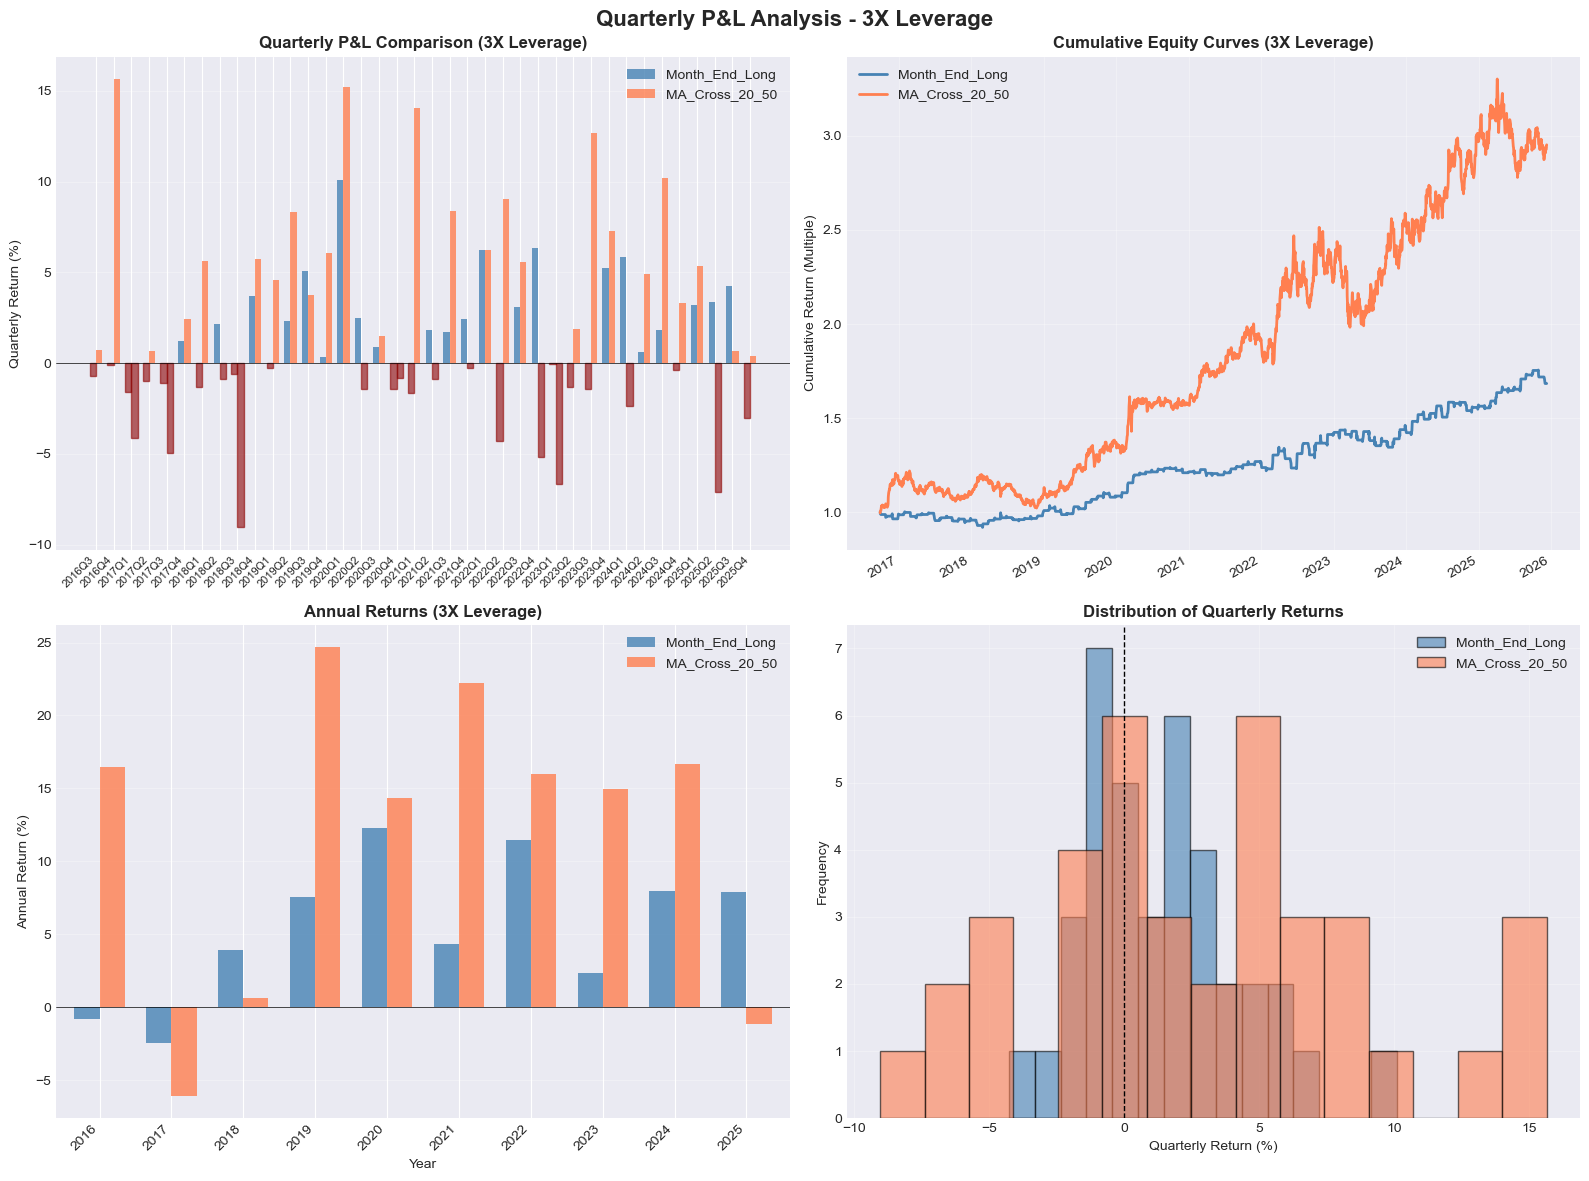

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("QUARTERLY P&L ANALYSIS - 3X LEVERAGE")
print("="*80)

# ============================================================================
# SETUP: GENERATE SIGNALS AND RETURNS
# ============================================================================

returns = features_clean['ret_1d']

# Strategy 1: Month_End_Long
signal_month_end = pd.Series(0, index=features_clean.index)
signal_month_end[features_clean['is_month_end'] == 1] = 1

# Strategy 2: MA_Cross_20_50
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']
signal_ma_20_50 = pd.Series(0, index=features_clean.index)
signal_ma_20_50[ma20 > ma50] = 1
signal_ma_20_50[ma20 < ma50] = -1

# Calculate strategy returns (unleveraged)
strat_returns_month_end = signal_month_end.shift(1) * returns
strat_returns_ma = signal_ma_20_50.shift(1) * returns

# Apply 3X leverage
LEVERAGE = 3
strat_returns_month_end_3X = strat_returns_month_end * LEVERAGE
strat_returns_ma_3X = strat_returns_ma * LEVERAGE

# ============================================================================
# QUARTERLY P&L CALCULATION
# ============================================================================
print("\n" + "-"*80)
print("CALCULATING QUARTERLY P&L")
print("-"*80)

def calculate_quarterly_pnl(returns_series, name):
    """Calculate quarterly P&L from daily returns"""
    # Add year and quarter
    df = pd.DataFrame({
        'returns': returns_series,
        'year': returns_series.index.year,
        'quarter': returns_series.index.quarter
    })
    
    # Group by year and quarter
    quarterly = df.groupby(['year', 'quarter'])['returns'].apply(
        lambda x: (1 + x).prod() - 1
    )
    
    # Create nice labels
    quarterly_df = pd.DataFrame(quarterly)
    quarterly_df.columns = [name]
    quarterly_df.index = [f"{year}Q{q}" for year, q in quarterly_df.index]
    
    return quarterly_df

# Calculate for both strategies
pnl_month_end = calculate_quarterly_pnl(strat_returns_month_end_3X, 'Month_End_Long')
pnl_ma = calculate_quarterly_pnl(strat_returns_ma_3X, 'MA_Cross_20_50')

# Combine into single dataframe
pnl_combined = pd.concat([pnl_month_end, pnl_ma], axis=1)
pnl_combined = pnl_combined.fillna(0)  # Fill any missing quarters

# Convert to percentages
pnl_pct = pnl_combined * 100

print(f"\n{'Quarter':<10s} {'Month_End_Long':>16s} {'MA_Cross_20_50':>16s}")
print("-"*50)
for quarter, row in pnl_pct.iterrows():
    month_end_val = row['Month_End_Long']
    ma_val = row['MA_Cross_20_50']
    
    # Color coding for display
    me_marker = "  ✓" if month_end_val > 2 else "  ✗" if month_end_val < -2 else ""
    ma_marker = "  ✓" if ma_val > 2 else "  ✗" if ma_val < -2 else ""
    
    print(f"{quarter:<10s} {month_end_val:>14.2f}%{me_marker:3s} {ma_val:>14.2f}%{ma_marker:3s}")

# ============================================================================
# ANNUAL SUMMARY
# ============================================================================
print("\n" + "-"*80)
print("ANNUAL SUMMARY")
print("-"*80)

def calculate_annual_pnl(returns_series, name):
    """Calculate annual P&L from daily returns"""
    df = pd.DataFrame({
        'returns': returns_series,
        'year': returns_series.index.year
    })
    
    annual = df.groupby('year')['returns'].apply(
        lambda x: (1 + x).prod() - 1
    )
    
    annual_df = pd.DataFrame(annual)
    annual_df.columns = [name]
    
    return annual_df

annual_month_end = calculate_annual_pnl(strat_returns_month_end_3X, 'Month_End_Long')
annual_ma = calculate_annual_pnl(strat_returns_ma_3X, 'MA_Cross_20_50')

annual_combined = pd.concat([annual_month_end, annual_ma], axis=1)
annual_combined = annual_combined.fillna(0)
annual_pct = annual_combined * 100

print(f"\n{'Year':<8s} {'Month_End_Long':>16s} {'MA_Cross_20_50':>16s}")
print("-"*48)
for year, row in annual_pct.iterrows():
    month_end_val = row['Month_End_Long']
    ma_val = row['MA_Cross_20_50']
    
    print(f"{year:<8d} {month_end_val:>14.2f}% {ma_val:>14.2f}%")

# Add totals
total_month_end = (1 + strat_returns_month_end_3X).prod() - 1
total_ma = (1 + strat_returns_ma_3X).prod() - 1

print("-"*48)
print(f"{'TOTAL':<8s} {total_month_end*100:>14.2f}% {total_ma*100:>14.2f}%")

# ============================================================================
# STATISTICS WITH 3X LEVERAGE
# ============================================================================
print("\n" + "-"*80)
print("STATISTICS (3X LEVERAGE)")
print("-"*80)

def calc_stats(returns_series, name):
    """Calculate performance statistics"""
    returns_clean = returns_series.dropna()
    
    total_return = (1 + returns_clean).prod() - 1
    n_years = len(returns_clean) / 252
    ann_return = (1 + total_return) ** (1/n_years) - 1
    ann_vol = returns_clean.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Drawdown
    cum_ret = (1 + returns_clean).cumprod()
    running_max = cum_ret.expanding().max()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    
    # Best/worst quarters
    quarterly_returns = calculate_quarterly_pnl(returns_series, name)[name]
    best_quarter = quarterly_returns.max()
    worst_quarter = quarterly_returns.min()
    positive_quarters = (quarterly_returns > 0).sum()
    total_quarters = len(quarterly_returns)
    
    return {
        'Strategy': name,
        'Total Return': total_return,
        'Annual Return': ann_return,
        'Annual Vol': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd,
        'Best Quarter': best_quarter,
        'Worst Quarter': worst_quarter,
        'Positive Quarters': f"{positive_quarters}/{total_quarters}"
    }

stats_month_end = calc_stats(strat_returns_month_end_3X, 'Month_End_Long')
stats_ma = calc_stats(strat_returns_ma_3X, 'MA_Cross_20_50')

stats_df = pd.DataFrame([stats_month_end, stats_ma])

print(f"\n{'Metric':<25s} {'Month_End_Long':>18s} {'MA_Cross_20_50':>18s}")
print("-"*65)
print(f"{'Total Return':<25s} {stats_month_end['Total Return']*100:>16.2f}% {stats_ma['Total Return']*100:>16.2f}%")
print(f"{'Annual Return':<25s} {stats_month_end['Annual Return']*100:>16.2f}% {stats_ma['Annual Return']*100:>16.2f}%")
print(f"{'Annual Volatility':<25s} {stats_month_end['Annual Vol']*100:>16.2f}% {stats_ma['Annual Vol']*100:>16.2f}%")
print(f"{'Sharpe Ratio':<25s} {stats_month_end['Sharpe Ratio']:>18.2f} {stats_ma['Sharpe Ratio']:>18.2f}")
print(f"{'Max Drawdown':<25s} {stats_month_end['Max Drawdown']*100:>16.2f}% {stats_ma['Max Drawdown']*100:>16.2f}%")
print(f"{'Best Quarter':<25s} {stats_month_end['Best Quarter']*100:>16.2f}% {stats_ma['Best Quarter']*100:>16.2f}%")
print(f"{'Worst Quarter':<25s} {stats_month_end['Worst Quarter']*100:>16.2f}% {stats_ma['Worst Quarter']*100:>16.2f}%")
print(f"{'Positive Quarters':<25s} {stats_month_end['Positive Quarters']:>18s} {stats_ma['Positive Quarters']:>18s}")

# ============================================================================
# COMPARISON TO 1X LEVERAGE
# ============================================================================
print("\n" + "-"*80)
print("LEVERAGE COMPARISON (1X vs 3X)")
print("-"*80)

# 1x leverage stats
stats_month_end_1x = calc_stats(strat_returns_month_end, 'Month_End_Long')
stats_ma_1x = calc_stats(strat_returns_ma, 'MA_Cross_20_50')

print("\nMonth_End_Long:")
print(f"  1x Leverage: Ann Return = {stats_month_end_1x['Annual Return']*100:>6.2f}%, Sharpe = {stats_month_end_1x['Sharpe Ratio']:>5.2f}, Max DD = {stats_month_end_1x['Max Drawdown']*100:>6.2f}%")
print(f"  3X Leverage: Ann Return = {stats_month_end['Annual Return']*100:>6.2f}%, Sharpe = {stats_month_end['Sharpe Ratio']:>5.2f}, Max DD = {stats_month_end['Max Drawdown']*100:>6.2f}%")

print("\nMA_Cross_20_50:")
print(f"  1x Leverage: Ann Return = {stats_ma_1x['Annual Return']*100:>6.2f}%, Sharpe = {stats_ma_1x['Sharpe Ratio']:>5.2f}, Max DD = {stats_ma_1x['Max Drawdown']*100:>6.2f}%")
print(f"  3X Leverage: Ann Return = {stats_ma['Annual Return']*100:>6.2f}%, Sharpe = {stats_ma['Sharpe Ratio']:>5.2f}, Max DD = {stats_ma['Max Drawdown']*100:>6.2f}%")

print("\n⚠ NOTE: Sharpe ratio is unchanged by leverage (returns and vol scale proportionally)")
print("        But drawdowns and absolute returns scale ~linearly with leverage")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Quarterly P&L Analysis - 3X Leverage', fontsize=16, fontweight='bold')

# Plot 1: Quarterly P&L bars
ax = axes[0, 0]
x = np.arange(len(pnl_pct))
width = 0.35

bars1 = ax.bar(x - width/2, pnl_pct['Month_End_Long'], width, 
               label='Month_End_Long', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, pnl_pct['MA_Cross_20_50'], width,
               label='MA_Cross_20_50', alpha=0.8, color='coral')

ax.set_ylabel('Quarterly Return (%)')
ax.set_title('Quarterly P&L Comparison (3X Leverage)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pnl_pct.index, rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Color positive/negative bars
for i, bar in enumerate(bars1):
    if pnl_pct['Month_End_Long'].iloc[i] < 0:
        bar.set_color('darkred')
        bar.set_alpha(0.6)
        
for i, bar in enumerate(bars2):
    if pnl_pct['MA_Cross_20_50'].iloc[i] < 0:
        bar.set_color('darkred')
        bar.set_alpha(0.6)

# Plot 2: Cumulative equity curves (3X leverage)
ax = axes[0, 1]

cum_month_end = (1 + strat_returns_month_end_3X).cumprod()
cum_ma = (1 + strat_returns_ma_3X).cumprod()

cum_month_end.plot(ax=ax, label='Month_End_Long', linewidth=2, color='steelblue')
cum_ma.plot(ax=ax, label='MA_Cross_20_50', linewidth=2, color='coral')

ax.set_title('Cumulative Equity Curves (3X Leverage)', fontweight='bold')
ax.set_ylabel('Cumulative Return (Multiple)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot 3: Annual returns
ax = axes[1, 0]
annual_pct.plot(kind='bar', ax=ax, color=['steelblue', 'coral'], alpha=0.8, width=0.7)
ax.set_title('Annual Returns (3X Leverage)', fontweight='bold')
ax.set_ylabel('Annual Return (%)')
ax.set_xlabel('Year')
ax.legend(loc='best')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 4: Quarterly distribution (histogram)
ax = axes[1, 1]
ax.hist(pnl_pct['Month_End_Long'], bins=15, alpha=0.6, label='Month_End_Long', 
        color='steelblue', edgecolor='black')
ax.hist(pnl_pct['MA_Cross_20_50'], bins=15, alpha=0.6, label='MA_Cross_20_50',
        color='coral', edgecolor='black')
ax.set_xlabel('Quarterly Return (%)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Quarterly Returns', fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig('quarterly_pnl_3X_leverage.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: quarterly_pnl_3X_leverage.png")

# ============================================================================
# ROLLING METRICS
# ============================================================================
print("\n" + "-"*80)
print("ROLLING 1-YEAR METRICS (3X LEVERAGE)")
print("-"*80)

rolling_window = 252

# Month End
rolling_ret_me = strat_returns_month_end_3X.rolling(rolling_window).mean() * 252
rolling_vol_me = strat_returns_month_end_3X.rolling(rolling_window).std() * np.sqrt(252)
rolling_sharpe_me = rolling_ret_me / rolling_vol_me

# MA Cross
rolling_ret_ma = strat_returns_ma_3X.rolling(rolling_window).mean() * 252
rolling_vol_ma = strat_returns_ma_3X.rolling(rolling_window).std() * np.sqrt(252)
rolling_sharpe_ma = rolling_ret_ma / rolling_vol_ma

print("\nMonth_End_Long (3X):")
print(f"  Avg Rolling Sharpe: {rolling_sharpe_me.mean():.2f}")
print(f"  Min Rolling Sharpe: {rolling_sharpe_me.min():.2f}")
print(f"  Max Rolling Sharpe: {rolling_sharpe_me.max():.2f}")

print("\nMA_Cross_20_50 (3X):")
print(f"  Avg Rolling Sharpe: {rolling_sharpe_ma.mean():.2f}")
print(f"  Min Rolling Sharpe: {rolling_sharpe_ma.min():.2f}")
print(f"  Max Rolling Sharpe: {rolling_sharpe_ma.max():.2f}")

# ============================================================================
# RISK METRICS
# ============================================================================
print("\n" + "-"*80)
print("RISK ANALYSIS (3X LEVERAGE)")
print("-"*80)

# Worst drawdown periods
def analyze_drawdowns(returns_series, name):
    cum_ret = (1 + returns_series).cumprod()
    running_max = cum_ret.expanding().max()
    drawdown = (cum_ret - running_max) / running_max
    
    # Find drawdown periods
    in_dd = drawdown < -0.05  # Drawdowns > 5%
    
    if in_dd.sum() > 0:
        dd_start = in_dd & ~in_dd.shift(1, fill_value=False)
        dd_end = ~in_dd & in_dd.shift(1, fill_value=False)
        
        print(f"\n{name} - Significant Drawdowns (>5%):")
        print(f"  Max Drawdown: {drawdown.min()*100:.2f}%")
        print(f"  Time in Drawdown > 5%: {in_dd.sum()} days ({in_dd.sum()/len(returns_series)*100:.1f}%)")
        
        # Find the worst drawdown period
        worst_dd_idx = drawdown.idxmin()
        worst_dd_val = drawdown.min()
        
        # Find when it started (last peak before this point)
        before_worst = drawdown[:worst_dd_idx]
        last_peak = before_worst[before_worst == 0].index[-1] if (before_worst == 0).any() else drawdown.index[0]
        
        print(f"  Worst DD Period: {last_peak.strftime('%Y-%m-%d')} to {worst_dd_idx.strftime('%Y-%m-%d')}")
        print(f"  Worst DD Value: {worst_dd_val*100:.2f}%")

analyze_drawdowns(strat_returns_month_end_3X.dropna(), "Month_End_Long")
analyze_drawdowns(strat_returns_ma_3X.dropna(), "MA_Cross_20_50")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

print("\nWith 3X Leverage:")
print(f"  Month_End_Long:  {stats_month_end['Annual Return']*100:>6.2f}% annual, Sharpe {stats_month_end['Sharpe Ratio']:.2f}, Max DD {stats_month_end['Max Drawdown']*100:>6.2f}%")
print(f"  MA_Cross_20_50:  {stats_ma['Annual Return']*100:>6.2f}% annual, Sharpe {stats_ma['Sharpe Ratio']:.2f}, Max DD {stats_ma['Max Drawdown']*100:>6.2f}%")

print("\nPositive vs Negative Quarters:")
print(f"  Month_End_Long:  {stats_month_end['Positive Quarters']}")
print(f"  MA_Cross_20_50:  {stats_ma['Positive Quarters']}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Return the quarterly P&L table
pnl_pct

COMBINED PORTFOLIO QUARTERLY P&L - 3X LEVERAGE

Portfolio: 50% Month_End_Long + 50% MA_Cross_20_50

--------------------------------------------------------------------------------
QUARTERLY P&L - ALL THREE APPROACHES
--------------------------------------------------------------------------------

Quarter       Month_End     MA_Cross     Combined   Diversif
-----------------------------------------------------------------
2016Q3           -1.21%        1.20%        0.00%         0.01%
2016Q4           -0.24%       27.13%       12.89%  ✓✓    -0.56%
2017Q1           -2.64%       -7.02%       -4.72%  ✗      0.11%
2017Q2           -1.70%        0.92%       -0.30%         0.09%
2017Q3           -1.87%       -8.26%       -5.02%  ✗      0.04%
2017Q4            2.06%        3.97%        3.13%  ✓      0.12%
2018Q1           -2.21%        9.38%        3.61%  ✓      0.02%
2018Q2            3.49%       -1.68%        1.18%         0.27%
2018Q3           -0.99%      -14.71%       -8.04%  ✗     -0.2

Month_End   MA_Cross   Combined
2016Q3  -1.214857   1.201044   0.000000
2016Q4  -0.239800  27.127282  12.888395
2017Q1  -2.635606  -7.023709  -4.716625
2017Q2  -1.698013   0.922463  -0.296850
2017Q3  -1.873243  -8.259379  -5.024922
2017Q4   2.058689   3.974243   3.133221
2018Q1  -2.205275   9.379166   3.611618
2018Q2   3.491920  -1.678043   1.177984
2018Q3  -0.987933 -14.705407  -8.043643
2018Q4   6.224001   9.544764   7.987562
2019Q1  -0.461167   7.572053   3.578543
2019Q2   3.819429  14.046453   8.903815
2019Q3   8.531287   5.942972   7.418487
2019Q4   0.496878   9.947492   5.398517
2020Q1  17.295681  25.433872  21.935991
2020Q2   4.166717  -2.521736   0.890027
2020Q3   1.492494   2.397082   1.981404
2020Q4  -2.336511  -1.459105  -1.782415
2021Q1  -2.772490  24.189858  10.081779
2021Q2   3.044179  -1.556099   0.830152
2021Q3   2.889827  14.208699   8.509162
2021Q4   4.011333  -0.759676   1.846554
2022Q1  10.422672   9.910348  10.844119
2022Q2  -7.166313  14.619022   3.950720
2022Q3   4.932632   8.469715   7.695603
2022Q4  10.609229  -9.146547   0.881655
2023Q1  -0.147511 -11.751393  -5.515694
2023Q2  -2.360028   2.580951   0.578055
2023Q3  -2.456146  21.383495   9.402551
2023Q4   8.768551  11.532348  10.768227
2024Q1   9.884146  -4.287411   2.820751
2024Q2   0.852042   7.797088   4.808193
2024Q3   2.929956  17.138633   9.995906
2024Q4  -0.718904   5.215409   2.519337
2025Q1   5.362790   8.679007   7.231053
2025Q2   5.642496 -12.065081  -3.273778
2025Q3   7.136424   0.830549   4.042984
2025Q4  -5.037039   0.534982  -2.197936

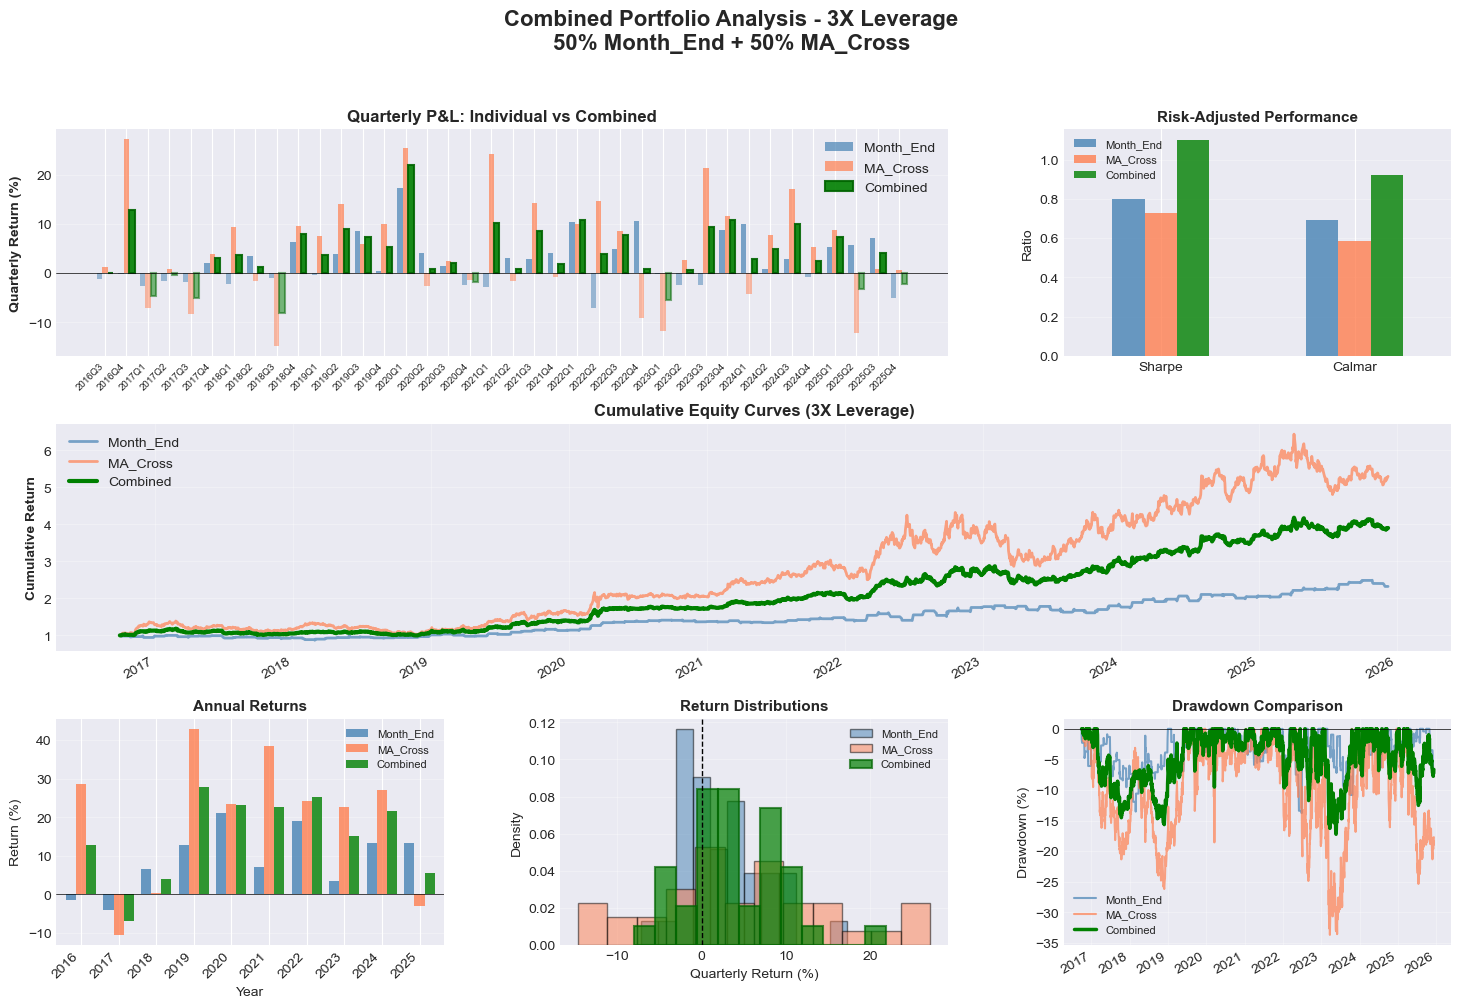

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMBINED PORTFOLIO QUARTERLY P&L - 3X LEVERAGE")
print("="*80)
print("\nPortfolio: 50% Month_End_Long + 50% MA_Cross_20_50")

# ============================================================================
# SETUP: GENERATE SIGNALS AND RETURNS
# ============================================================================

returns = features_clean['ret_1d']

# Strategy 1: Month_End_Long
signal_month_end = pd.Series(0, index=features_clean.index)
signal_month_end[features_clean['is_month_end'] == 1] = 1

# Strategy 2: MA_Cross_20_50
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']
signal_ma_20_50 = pd.Series(0, index=features_clean.index)
signal_ma_20_50[ma20 > ma50] = 1
signal_ma_20_50[ma20 < ma50] = -1

# Calculate individual strategy returns (unleveraged)
strat_returns_month_end = signal_month_end.shift(1) * returns
strat_returns_ma = signal_ma_20_50.shift(1) * returns

# Combined portfolio: 50/50 equal weight
signal_combined = (signal_month_end + signal_ma_20_50) / 2
strat_returns_combined = signal_combined.shift(1) * returns

# Apply 3X leverage to all
LEVERAGE = 5
strat_returns_month_end_3X = strat_returns_month_end * LEVERAGE
strat_returns_ma_3X = strat_returns_ma * LEVERAGE
strat_returns_combined_3X = strat_returns_combined * LEVERAGE

# ============================================================================
# QUARTERLY P&L CALCULATION
# ============================================================================
print("\n" + "-"*80)
print("QUARTERLY P&L - ALL THREE APPROACHES")
print("-"*80)

def calculate_quarterly_pnl(returns_series, name):
    """Calculate quarterly P&L from daily returns"""
    df = pd.DataFrame({
        'returns': returns_series,
        'year': returns_series.index.year,
        'quarter': returns_series.index.quarter
    })
    
    quarterly = df.groupby(['year', 'quarter'])['returns'].apply(
        lambda x: (1 + x).prod() - 1
    )
    
    quarterly_df = pd.DataFrame(quarterly)
    quarterly_df.columns = [name]
    quarterly_df.index = [f"{year}Q{q}" for year, q in quarterly_df.index]
    
    return quarterly_df

# Calculate for all three
pnl_month_end = calculate_quarterly_pnl(strat_returns_month_end_3X, 'Month_End')
pnl_ma = calculate_quarterly_pnl(strat_returns_ma_3X, 'MA_Cross')
pnl_combined = calculate_quarterly_pnl(strat_returns_combined_3X, 'Combined')

# Combine into single dataframe
pnl_all = pd.concat([pnl_month_end, pnl_ma, pnl_combined], axis=1)
pnl_all = pnl_all.fillna(0)

# Convert to percentages
pnl_pct = pnl_all * 100

print(f"\n{'Quarter':<10s} {'Month_End':>12s} {'MA_Cross':>12s} {'Combined':>12s} {'Diversif':>10s}")
print("-"*65)

for quarter, row in pnl_pct.iterrows():
    me_val = row['Month_End']
    ma_val = row['MA_Cross']
    comb_val = row['Combined']
    
    # Calculate diversification benefit
    simple_avg = (me_val + ma_val) / 2
    diversif_benefit = comb_val - simple_avg
    
    # Visual markers for combined performance
    marker = "  ✓✓" if comb_val > 5 else "  ✓" if comb_val > 2 else "  ✗" if comb_val < -2 else ""
    
    print(f"{quarter:<10s} {me_val:>11.2f}% {ma_val:>11.2f}% {comb_val:>11.2f}%{marker:4s} {diversif_benefit:>8.2f}%")

print("\nDiversif = Diversification benefit (combined vs simple average)")

# ============================================================================
# ANNUAL SUMMARY
# ============================================================================
print("\n" + "-"*80)
print("ANNUAL RETURNS")
print("-"*80)

def calculate_annual_pnl(returns_series, name):
    """Calculate annual P&L from daily returns"""
    df = pd.DataFrame({
        'returns': returns_series,
        'year': returns_series.index.year
    })
    
    annual = df.groupby('year')['returns'].apply(
        lambda x: (1 + x).prod() - 1
    )
    
    annual_df = pd.DataFrame(annual)
    annual_df.columns = [name]
    
    return annual_df

annual_month_end = calculate_annual_pnl(strat_returns_month_end_3X, 'Month_End')
annual_ma = calculate_annual_pnl(strat_returns_ma_3X, 'MA_Cross')
annual_combined = calculate_annual_pnl(strat_returns_combined_3X, 'Combined')

annual_all = pd.concat([annual_month_end, annual_ma, annual_combined], axis=1)
annual_all = annual_all.fillna(0)
annual_pct = annual_all * 100

print(f"\n{'Year':<8s} {'Month_End':>12s} {'MA_Cross':>12s} {'Combined':>12s}")
print("-"*50)
for year, row in annual_pct.iterrows():
    print(f"{year:<8d} {row['Month_End']:>11.2f}% {row['MA_Cross']:>11.2f}% {row['Combined']:>11.2f}%")

# Totals
total_month_end = (1 + strat_returns_month_end_3X).prod() - 1
total_ma = (1 + strat_returns_ma_3X).prod() - 1
total_combined = (1 + strat_returns_combined_3X).prod() - 1

print("-"*50)
print(f"{'TOTAL':<8s} {total_month_end*100:>11.2f}% {total_ma*100:>11.2f}% {total_combined*100:>11.2f}%")

# ============================================================================
# COMPREHENSIVE STATISTICS
# ============================================================================
print("\n" + "-"*80)
print("PERFORMANCE STATISTICS (3X LEVERAGE)")
print("-"*80)

def calc_comprehensive_stats(returns_series, name):
    """Calculate all performance statistics"""
    returns_clean = returns_series.dropna()
    
    # Basic returns
    total_return = (1 + returns_clean).prod() - 1
    n_years = len(returns_clean) / 252
    ann_return = (1 + total_return) ** (1/n_years) - 1
    ann_vol = returns_clean.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Downside metrics
    downside_returns = returns_clean[returns_clean < 0]
    downside_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    sortino = ann_return / downside_vol if downside_vol > 0 else 0
    
    # Drawdown
    cum_ret = (1 + returns_clean).cumprod()
    running_max = cum_ret.expanding().max()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    
    # Calmar
    calmar = ann_return / abs(max_dd) if max_dd != 0 else 0
    
    # Win metrics
    win_rate = (returns_clean > 0).sum() / len(returns_clean)
    avg_win = returns_clean[returns_clean > 0].mean() if (returns_clean > 0).any() else 0
    avg_loss = returns_clean[returns_clean < 0].mean() if (returns_clean < 0).any() else 0
    
    # Quarterly metrics
    quarterly_returns = calculate_quarterly_pnl(returns_series, name)[name]
    best_quarter = quarterly_returns.max()
    worst_quarter = quarterly_returns.min()
    positive_quarters = (quarterly_returns > 0).sum()
    total_quarters = len(quarterly_returns)
    quarter_win_rate = positive_quarters / total_quarters
    
    return {
        'Strategy': name,
        'Total Return': total_return,
        'Annual Return': ann_return,
        'Annual Vol': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_dd,
        'Calmar Ratio': calmar,
        'Daily Win Rate': win_rate,
        'Avg Daily Win': avg_win,
        'Avg Daily Loss': avg_loss,
        'Best Quarter': best_quarter,
        'Worst Quarter': worst_quarter,
        'Quarterly Win Rate': quarter_win_rate,
        'Positive Quarters': f"{positive_quarters}/{total_quarters}"
    }

stats_month_end = calc_comprehensive_stats(strat_returns_month_end_3X, 'Month_End')
stats_ma = calc_comprehensive_stats(strat_returns_ma_3X, 'MA_Cross')
stats_combined = calc_comprehensive_stats(strat_returns_combined_3X, 'Combined')

print(f"\n{'Metric':<25s} {'Month_End':>14s} {'MA_Cross':>14s} {'Combined':>14s}")
print("-"*72)
print(f"{'Total Return':<25s} {stats_month_end['Total Return']*100:>12.2f}% {stats_ma['Total Return']*100:>12.2f}% {stats_combined['Total Return']*100:>12.2f}%")
print(f"{'Annual Return':<25s} {stats_month_end['Annual Return']*100:>12.2f}% {stats_ma['Annual Return']*100:>12.2f}% {stats_combined['Annual Return']*100:>12.2f}%")
print(f"{'Annual Volatility':<25s} {stats_month_end['Annual Vol']*100:>12.2f}% {stats_ma['Annual Vol']*100:>12.2f}% {stats_combined['Annual Vol']*100:>12.2f}%")
print(f"{'Sharpe Ratio':<25s} {stats_month_end['Sharpe Ratio']:>14.2f} {stats_ma['Sharpe Ratio']:>14.2f} {stats_combined['Sharpe Ratio']:>14.2f}")
print(f"{'Sortino Ratio':<25s} {stats_month_end['Sortino Ratio']:>14.2f} {stats_ma['Sortino Ratio']:>14.2f} {stats_combined['Sortino Ratio']:>14.2f}")
print(f"{'Max Drawdown':<25s} {stats_month_end['Max Drawdown']*100:>12.2f}% {stats_ma['Max Drawdown']*100:>12.2f}% {stats_combined['Max Drawdown']*100:>12.2f}%")
print(f"{'Calmar Ratio':<25s} {stats_month_end['Calmar Ratio']:>14.2f} {stats_ma['Calmar Ratio']:>14.2f} {stats_combined['Calmar Ratio']:>14.2f}")
print(f"{'Daily Win Rate':<25s} {stats_month_end['Daily Win Rate']*100:>12.1f}% {stats_ma['Daily Win Rate']*100:>12.1f}% {stats_combined['Daily Win Rate']*100:>12.1f}%")
print(f"{'Best Quarter':<25s} {stats_month_end['Best Quarter']*100:>12.2f}% {stats_ma['Best Quarter']*100:>12.2f}% {stats_combined['Best Quarter']*100:>12.2f}%")
print(f"{'Worst Quarter':<25s} {stats_month_end['Worst Quarter']*100:>12.2f}% {stats_ma['Worst Quarter']*100:>12.2f}% {stats_combined['Worst Quarter']*100:>12.2f}%")
print(f"{'Quarterly Win Rate':<25s} {stats_month_end['Quarterly Win Rate']*100:>12.1f}% {stats_ma['Quarterly Win Rate']*100:>12.1f}% {stats_combined['Quarterly Win Rate']*100:>12.1f}%")
print(f"{'Positive Quarters':<25s} {stats_month_end['Positive Quarters']:>14s} {stats_ma['Positive Quarters']:>14s} {stats_combined['Positive Quarters']:>14s}")

# ============================================================================
# DIVERSIFICATION BENEFIT ANALYSIS
# ============================================================================
print("\n" + "-"*80)
print("DIVERSIFICATION BENEFIT")
print("-"*80)

# Calculate what simple average would give
simple_avg_returns = (strat_returns_month_end_3X + strat_returns_ma_3X) / 2
simple_avg_sharpe = simple_avg_returns.mean() / simple_avg_returns.std() * np.sqrt(252)

# Actual combined (which accounts for overlapping positions)
actual_combined_sharpe = stats_combined['Sharpe Ratio']

# Calculate correlation
corr_matrix = pd.DataFrame({
    'Month_End': strat_returns_month_end_3X,
    'MA_Cross': strat_returns_ma_3X
}).corr()

correlation = corr_matrix.loc['Month_End', 'MA_Cross']

print(f"\nReturn Correlation: {correlation:.3f}")
print(f"\nSimple Average Sharpe:  {simple_avg_sharpe:.2f}")
print(f"Combined Portfolio Sharpe: {actual_combined_sharpe:.2f}")
print(f"Diversification Boost: {actual_combined_sharpe - simple_avg_sharpe:+.2f}")

print(f"\nVolatility Reduction:")
simple_avg_vol = simple_avg_returns.std() * np.sqrt(252)
combined_vol = stats_combined['Annual Vol']
vol_reduction = (1 - combined_vol / simple_avg_vol) * 100
print(f"  Simple Average Vol: {simple_avg_vol*100:.2f}%")
print(f"  Combined Vol:       {combined_vol*100:.2f}%")
print(f"  Reduction:          {vol_reduction:.1f}%")

print(f"\nDrawdown Improvement:")
simple_avg_dd = ((1 + simple_avg_returns).cumprod() - (1 + simple_avg_returns).cumprod().expanding().max()) / (1 + simple_avg_returns).cumprod().expanding().max()
simple_avg_max_dd = simple_avg_dd.min()
combined_max_dd = stats_combined['Max Drawdown']
dd_improvement = (1 - abs(combined_max_dd) / abs(simple_avg_max_dd)) * 100
print(f"  Simple Average Max DD: {simple_avg_max_dd*100:.2f}%")
print(f"  Combined Max DD:       {combined_max_dd*100:.2f}%")
print(f"  Improvement:           {dd_improvement:.1f}%")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Combined Portfolio Analysis - 3X Leverage\n50% Month_End + 50% MA_Cross', 
             fontsize=16, fontweight='bold')

# Plot 1: Quarterly P&L bars (span 2 columns)
ax1 = fig.add_subplot(gs[0, :2])
x = np.arange(len(pnl_pct))
width = 0.25

bars1 = ax1.bar(x - width, pnl_pct['Month_End'], width, 
                label='Month_End', alpha=0.7, color='steelblue')
bars2 = ax1.bar(x, pnl_pct['MA_Cross'], width,
                label='MA_Cross', alpha=0.7, color='coral')
bars3 = ax1.bar(x + width, pnl_pct['Combined'], width,
                label='Combined', alpha=0.9, color='green', edgecolor='darkgreen', linewidth=1.5)

ax1.set_ylabel('Quarterly Return (%)', fontweight='bold')
ax1.set_title('Quarterly P&L: Individual vs Combined', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(pnl_pct.index, rotation=45, ha='right', fontsize=7)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Color negative bars red
for bars in [bars1, bars2, bars3]:
    for i, bar in enumerate(bars):
        if bar.get_height() < 0:
            bar.set_alpha(0.5)

# Plot 2: Performance metrics comparison
ax2 = fig.add_subplot(gs[0, 2])
metrics_comparison = pd.DataFrame({
    'Month_End': [stats_month_end['Sharpe Ratio'], stats_month_end['Calmar Ratio']],
    'MA_Cross': [stats_ma['Sharpe Ratio'], stats_ma['Calmar Ratio']],
    'Combined': [stats_combined['Sharpe Ratio'], stats_combined['Calmar Ratio']]
}, index=['Sharpe', 'Calmar'])

metrics_comparison.plot(kind='bar', ax=ax2, color=['steelblue', 'coral', 'green'], alpha=0.8)
ax2.set_title('Risk-Adjusted Performance', fontweight='bold', fontsize=11)
ax2.set_ylabel('Ratio')
ax2.legend(loc='best', fontsize=8)
ax2.grid(True, alpha=0.3, axis='y')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)

# Plot 3: Cumulative equity curves
ax3 = fig.add_subplot(gs[1, :])
cum_month_end = (1 + strat_returns_month_end_3X).cumprod()
cum_ma = (1 + strat_returns_ma_3X).cumprod()
cum_combined = (1 + strat_returns_combined_3X).cumprod()

cum_month_end.plot(ax=ax3, label='Month_End', linewidth=2, color='steelblue', alpha=0.7)
cum_ma.plot(ax=ax3, label='MA_Cross', linewidth=2, color='coral', alpha=0.7)
cum_combined.plot(ax=ax3, label='Combined', linewidth=3, color='green', linestyle='-')

ax3.set_title('Cumulative Equity Curves (3X Leverage)', fontweight='bold', fontsize=12)
ax3.set_ylabel('Cumulative Return', fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Annual returns
ax4 = fig.add_subplot(gs[2, 0])
annual_pct.plot(kind='bar', ax=ax4, color=['steelblue', 'coral', 'green'], alpha=0.8, width=0.8)
ax4.set_title('Annual Returns', fontweight='bold', fontsize=11)
ax4.set_ylabel('Return (%)')
ax4.set_xlabel('Year')
ax4.legend(loc='best', fontsize=8)
ax4.grid(True, alpha=0.3, axis='y')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 5: Return distributions
ax5 = fig.add_subplot(gs[2, 1])
ax5.hist(pnl_pct['Month_End'], bins=12, alpha=0.5, label='Month_End', 
         color='steelblue', edgecolor='black', density=True)
ax5.hist(pnl_pct['MA_Cross'], bins=12, alpha=0.5, label='MA_Cross',
         color='coral', edgecolor='black', density=True)
ax5.hist(pnl_pct['Combined'], bins=12, alpha=0.7, label='Combined',
         color='green', edgecolor='darkgreen', linewidth=1.5, density=True)
ax5.set_xlabel('Quarterly Return (%)')
ax5.set_ylabel('Density')
ax5.set_title('Return Distributions', fontweight='bold', fontsize=11)
ax5.legend(loc='best', fontsize=8)
ax5.grid(True, alpha=0.3)
ax5.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Plot 6: Drawdown comparison
ax6 = fig.add_subplot(gs[2, 2])
dd_month_end = ((1 + strat_returns_month_end_3X).cumprod() - (1 + strat_returns_month_end_3X).cumprod().expanding().max()) / (1 + strat_returns_month_end_3X).cumprod().expanding().max()
dd_ma = ((1 + strat_returns_ma_3X).cumprod() - (1 + strat_returns_ma_3X).cumprod().expanding().max()) / (1 + strat_returns_ma_3X).cumprod().expanding().max()
dd_combined = ((1 + strat_returns_combined_3X).cumprod() - (1 + strat_returns_combined_3X).cumprod().expanding().max()) / (1 + strat_returns_combined_3X).cumprod().expanding().max()

(dd_month_end * 100).plot(ax=ax6, label='Month_End', linewidth=1.5, color='steelblue', alpha=0.7)
(dd_ma * 100).plot(ax=ax6, label='MA_Cross', linewidth=1.5, color='coral', alpha=0.7)
(dd_combined * 100).plot(ax=ax6, label='Combined', linewidth=2.5, color='green')

ax6.set_title('Drawdown Comparison', fontweight='bold', fontsize=11)
ax6.set_ylabel('Drawdown (%)')
ax6.legend(loc='best', fontsize=8)
ax6.grid(True, alpha=0.3)
ax6.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.savefig('combined_portfolio_quarterly_3X.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: combined_portfolio_quarterly_3X.png")

# ============================================================================
# SCENARIO ANALYSIS
# ============================================================================
print("\n" + "-"*80)
print("SCENARIO ANALYSIS: WHEN DOES COMBINED OUTPERFORM?")
print("-"*80)

# Analyze quarters where combined beat both individual strategies
pnl_comparison = pd.DataFrame({
    'Month_End': pnl_pct['Month_End'],
    'MA_Cross': pnl_pct['MA_Cross'],
    'Combined': pnl_pct['Combined']
})

combined_wins_both = pnl_comparison['Combined'] > pnl_comparison[['Month_End', 'MA_Cross']].max(axis=1)
combined_better_than_avg = pnl_comparison['Combined'] > pnl_comparison[['Month_End', 'MA_Cross']].mean(axis=1)

print(f"\nQuarters where Combined beat BOTH individual strategies: {combined_wins_both.sum()} of {len(pnl_pct)} ({combined_wins_both.sum()/len(pnl_pct)*100:.1f}%)")
print(f"Quarters where Combined beat simple average: {combined_better_than_avg.sum()} of {len(pnl_pct)} ({combined_better_than_avg.sum()/len(pnl_pct)*100:.1f}%)")

# Worst quarters - does combined help?
worst_quarters_me = pnl_pct['Month_End'].nsmallest(5)
worst_quarters_ma = pnl_pct['MA_Cross'].nsmallest(5)

print("\n5 Worst Quarters for Month_End:")
for quarter, value in worst_quarters_me.items():
    combined_val = pnl_pct.loc[quarter, 'Combined']
    cushion = combined_val - value
    print(f"  {quarter}: {value:>7.2f}% → Combined: {combined_val:>7.2f}% (cushion: {cushion:+.2f}%)")

print("\n5 Worst Quarters for MA_Cross:")
for quarter, value in worst_quarters_ma.items():
    combined_val = pnl_pct.loc[quarter, 'Combined']
    cushion = combined_val - value
    print(f"  {quarter}: {value:>7.2f}% → Combined: {combined_val:>7.2f}% (cushion: {cushion:+.2f}%)")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("PORTFOLIO SUMMARY")
print("="*80)

print("\n50/50 Combined Portfolio (3X Leverage):")
print(f"  Annual Return:      {stats_combined['Annual Return']*100:>7.2f}%")
print(f"  Annual Volatility:  {stats_combined['Annual Vol']*100:>7.2f}%")
print(f"  Sharpe Ratio:       {stats_combined['Sharpe Ratio']:>7.2f}")
print(f"  Sortino Ratio:      {stats_combined['Sortino Ratio']:>7.2f}")
print(f"  Max Drawdown:       {stats_combined['Max Drawdown']*100:>7.2f}%")
print(f"  Calmar Ratio:       {stats_combined['Calmar Ratio']:>7.2f}")
print(f"  Best Quarter:       {stats_combined['Best Quarter']*100:>7.2f}%")
print(f"  Worst Quarter:      {stats_combined['Worst Quarter']*100:>7.2f}%")
print(f"  Quarterly Win Rate: {stats_combined['Quarterly Win Rate']*100:>7.1f}%")

print("\nDiversification Benefits:")
print(f"  Sharpe Boost:       {actual_combined_sharpe - simple_avg_sharpe:>+7.2f}")
print(f"  Vol Reduction:      {vol_reduction:>7.1f}%")
print(f"  Drawdown Reduction: {dd_improvement:>7.1f}%")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Return the quarterly table
pnl_pct

MONTH-END STRATEGY VARIANTS ANALYSIS - 3X LEVERAGE

Creating strategy variants...
  ✓ Original (Long last 5 days): 555 days
  ✓ Variant 1 (Long last 3 days): 336 days
  ✓ Variant 2 (Short first 3 days): 336 days
  ✓ Variant 3 (Short first 5 days): 555 days

--------------------------------------------------------------------------------
QUARTERLY P&L - ALL VARIANTS (3X LEVERAGE)
--------------------------------------------------------------------------------

Quarter         Long5      Long3     Short3     Short5
-------------------------------------------------------
2016Q3          0.00%     -0.73%      0.72%      0.00%
2016Q4         -0.48%     -0.63%      0.47%      2.04%
2017Q1         -0.68%     -3.31%     -1.94%     -2.72%
2017Q2         -1.68%     -0.04%     -0.91%      0.62%
2017Q3         -1.11%     -0.94%     -1.02%     -0.46%
2017Q4          1.63%      0.03%     -1.28%     -0.09%
2018Q1         -0.65%     -0.85%      1.17%      3.47%
2018Q2          1.50%     -2.69%      2.

Strategy  Annual Return  Sharpe Ratio  Max Drawdown  Days Active
0  Original_Long5       0.055287      0.717216     -0.091879          555
1    Long3_Before       0.024816      0.405849     -0.127990          336
2    Short3_After       0.014641      0.212953     -0.147025          336
3    Short5_After       0.058386      0.693689     -0.112274          555

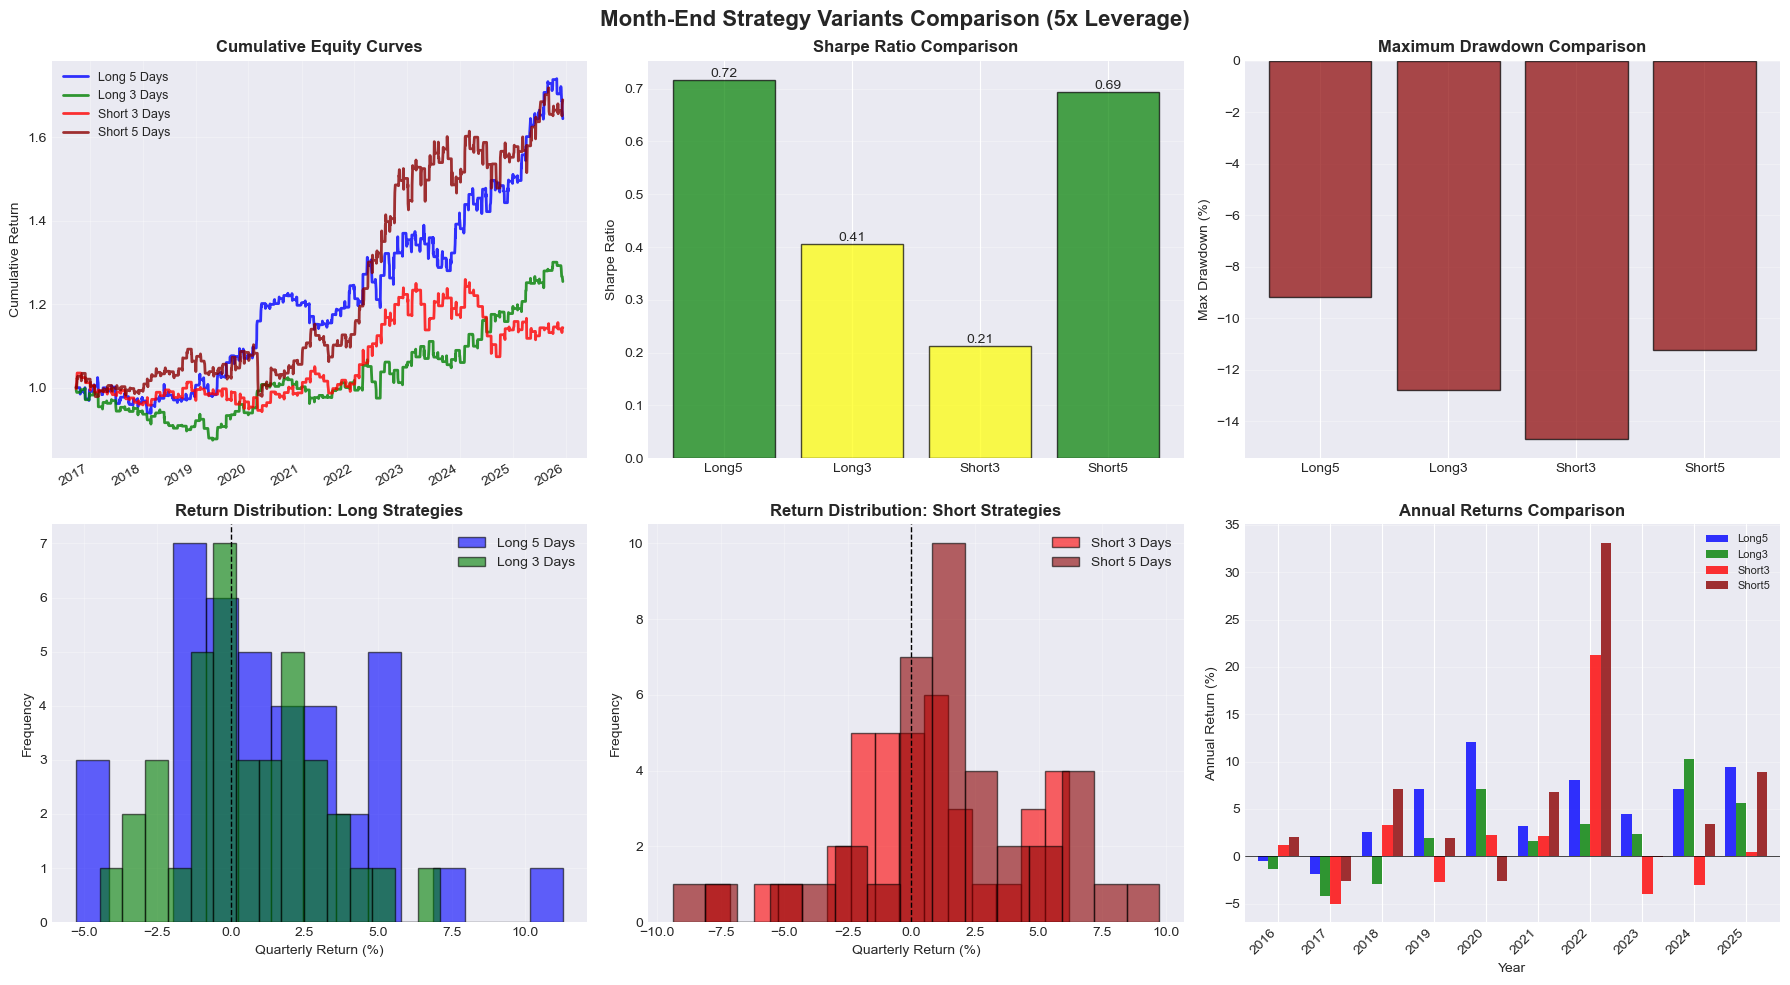

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MONTH-END STRATEGY VARIANTS ANALYSIS - 3X LEVERAGE")
print("="*80)

# ============================================================================
# SETUP: CREATE ALL MONTH-END VARIANTS
# ============================================================================

returns = features_clean['ret_1d']

def identify_month_end_days(dates, days_before=5):
    """Identify the last N trading days of each month"""
    signal = pd.Series(0, index=dates)
    
    # Group by year-month
    df = pd.DataFrame({'date': dates, 'day': dates.day})
    df['year_month'] = df['date'].dt.to_period('M')
    
    # For each month, mark the last N days
    for ym in df['year_month'].unique():
        month_days = df[df['year_month'] == ym].index
        if len(month_days) >= days_before:
            signal.iloc[month_days[-days_before:]] = 1
    
    return signal

def identify_month_start_days(dates, days_after=3):
    """Identify the first N trading days of each month"""
    signal = pd.Series(0, index=dates)
    
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    
    # For each month, mark the first N days
    for ym in df['year_month'].unique():
        month_days = df[df['year_month'] == ym].index
        if len(month_days) >= days_after:
            signal.iloc[month_days[:days_after]] = 1
    
    return signal

# Create all variants
dates = features_clean.index

print("\nCreating strategy variants...")

# Original: Long last 5 days
signal_original = identify_month_end_days(dates, days_before=5)
print(f"  ✓ Original (Long last 5 days): {signal_original.sum()} days")

# Variant 1: Long last 3 days
signal_3day_before = identify_month_end_days(dates, days_before=3)
print(f"  ✓ Variant 1 (Long last 3 days): {signal_3day_before.sum()} days")

# Variant 2: Short first 3 days after month end
signal_3day_after = identify_month_start_days(dates, days_after=3) * -1
print(f"  ✓ Variant 2 (Short first 3 days): {abs(signal_3day_after).sum()} days")

# Variant 3: Short first 5 days after month end
signal_5day_after = identify_month_start_days(dates, days_after=5) * -1
print(f"  ✓ Variant 3 (Short first 5 days): {abs(signal_5day_after).sum()} days")

# Calculate returns for each variant
LEVERAGE = 3

strategies = {
    'Original_Long5': signal_original,
    'Long3_Before': signal_3day_before,
    'Short3_After': signal_3day_after,
    'Short5_After': signal_5day_after
}

strategy_returns = {}
for name, signal in strategies.items():
    strat_ret = signal.shift(1) * returns * LEVERAGE
    strategy_returns[name] = strat_ret

# ============================================================================
# QUARTERLY P&L COMPARISON
# ============================================================================
print("\n" + "-"*80)
print("QUARTERLY P&L - ALL VARIANTS (3X LEVERAGE)")
print("-"*80)

def calculate_quarterly_pnl(returns_series, name):
    """Calculate quarterly P&L"""
    df = pd.DataFrame({
        'returns': returns_series,
        'year': returns_series.index.year,
        'quarter': returns_series.index.quarter
    })
    
    quarterly = df.groupby(['year', 'quarter'])['returns'].apply(
        lambda x: (1 + x).prod() - 1
    )
    
    quarterly_df = pd.DataFrame(quarterly)
    quarterly_df.columns = [name]
    quarterly_df.index = [f"{year}Q{q}" for year, q in quarterly_df.index]
    
    return quarterly_df

# Calculate quarterly P&L for all variants
quarterly_pnls = {}
for name, ret in strategy_returns.items():
    quarterly_pnls[name] = calculate_quarterly_pnl(ret, name)

# Combine
pnl_all = pd.concat([quarterly_pnls[name] for name in strategies.keys()], axis=1)
pnl_all = pnl_all.fillna(0) * 100  # Convert to percentage

print(f"\n{'Quarter':<10s} {'Long5':>10s} {'Long3':>10s} {'Short3':>10s} {'Short5':>10s}")
print("-"*55)

for quarter, row in pnl_all.iterrows():
    print(f"{quarter:<10s} {row['Original_Long5']:>9.2f}% {row['Long3_Before']:>9.2f}% "
          f"{row['Short3_After']:>9.2f}% {row['Short5_After']:>9.2f}%")

# ============================================================================
# ANNUAL SUMMARY
# ============================================================================
print("\n" + "-"*80)
print("ANNUAL RETURNS")
print("-"*80)

def calculate_annual_pnl(returns_series):
    """Calculate annual P&L"""
    df = pd.DataFrame({
        'returns': returns_series,
        'year': returns_series.index.year
    })
    
    return df.groupby('year')['returns'].apply(lambda x: (1 + x).prod() - 1)

annual_returns = {}
for name, ret in strategy_returns.items():
    annual_returns[name] = calculate_annual_pnl(ret)

annual_df = pd.DataFrame(annual_returns) * 100

print(f"\n{'Year':<8s} {'Long5':>10s} {'Long3':>10s} {'Short3':>10s} {'Short5':>10s}")
print("-"*50)

for year, row in annual_df.iterrows():
    print(f"{year:<8d} {row['Original_Long5']:>9.2f}% {row['Long3_Before']:>9.2f}% "
          f"{row['Short3_After']:>9.2f}% {row['Short5_After']:>9.2f}%")

# Totals
print("-"*50)
totals = {}
for name, ret in strategy_returns.items():
    totals[name] = ((1 + ret).prod() - 1) * 100

print(f"{'TOTAL':<8s} {totals['Original_Long5']:>9.2f}% {totals['Long3_Before']:>9.2f}% "
      f"{totals['Short3_After']:>9.2f}% {totals['Short5_After']:>9.2f}%")

# ============================================================================
# COMPREHENSIVE STATISTICS
# ============================================================================
print("\n" + "-"*80)
print("PERFORMANCE STATISTICS (3X LEVERAGE)")
print("-"*80)

def calc_stats(returns_series, name):
    """Calculate comprehensive statistics"""
    returns_clean = returns_series.dropna()
    
    if len(returns_clean) == 0:
        return None
    
    # Returns
    total_return = (1 + returns_clean).prod() - 1
    n_years = len(returns_clean) / 252
    ann_return = (1 + total_return) ** (1/n_years) - 1
    ann_vol = returns_clean.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Downside
    downside = returns_clean[returns_clean < 0]
    downside_vol = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_return / downside_vol if downside_vol > 0 else 0
    
    # Drawdown
    cum_ret = (1 + returns_clean).cumprod()
    running_max = cum_ret.expanding().max()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    
    # Calmar
    calmar = ann_return / abs(max_dd) if max_dd != 0 else 0
    
    # Win metrics
    win_rate = (returns_clean > 0).sum() / len(returns_clean)
    
    # Quarterly
    quarterly = calculate_quarterly_pnl(returns_series, name)[name]
    best_q = quarterly.max()
    worst_q = quarterly.min()
    positive_q = (quarterly > 0).sum()
    total_q = len(quarterly)
    q_win_rate = positive_q / total_q if total_q > 0 else 0
    
    return {
        'Strategy': name,
        'Annual Return': ann_return,
        'Annual Vol': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_dd,
        'Calmar Ratio': calmar,
        'Daily Win Rate': win_rate,
        'Best Quarter': best_q,
        'Worst Quarter': worst_q,
        'Quarterly Win Rate': q_win_rate,
        'Positive Quarters': f"{positive_q}/{total_q}",
        'Days Active': (strategies[name] != 0).sum()
    }

stats_list = []
for name, ret in strategy_returns.items():
    stat = calc_stats(ret, name)
    if stat:
        stats_list.append(stat)

stats_df = pd.DataFrame(stats_list)

# Display names for readability
display_names = {
    'Original_Long5': 'Long Last 5 Days',
    'Long3_Before': 'Long Last 3 Days',
    'Short3_After': 'Short First 3 Days',
    'Short5_After': 'Short First 5 Days'
}

print(f"\n{'Metric':<25s} {'Long5':>12s} {'Long3':>12s} {'Short3':>12s} {'Short5':>12s}")
print("-"*75)

metrics_order = [
    ('Annual Return', '%'),
    ('Annual Vol', '%'),
    ('Sharpe Ratio', ''),
    ('Sortino Ratio', ''),
    ('Max Drawdown', '%'),
    ('Calmar Ratio', ''),
    ('Daily Win Rate', '%'),
    ('Best Quarter', '%'),
    ('Worst Quarter', '%'),
    ('Quarterly Win Rate', '%'),
    ('Days Active', '')
]

for metric, unit in metrics_order:
    if metric == 'Days Active':
        row_values = [stats_df[stats_df['Strategy'] == strat][metric].values[0] 
                     for strat in strategies.keys()]
        print(f"{metric:<25s} {row_values[0]:>12.0f} {row_values[1]:>12.0f} "
              f"{row_values[2]:>12.0f} {row_values[3]:>12.0f}")
    elif unit == '%':
        row_values = [stats_df[stats_df['Strategy'] == strat][metric].values[0] * 100 
                     for strat in strategies.keys()]
        print(f"{metric:<25s} {row_values[0]:>11.2f}% {row_values[1]:>11.2f}% "
              f"{row_values[2]:>11.2f}% {row_values[3]:>11.2f}%")
    else:
        row_values = [stats_df[stats_df['Strategy'] == strat][metric].values[0] 
                     for strat in strategies.keys()]
        print(f"{metric:<25s} {row_values[0]:>12.2f} {row_values[1]:>12.2f} "
              f"{row_values[2]:>12.2f} {row_values[3]:>12.2f}")

# ============================================================================
# VARIANT COMPARISON INSIGHTS
# ============================================================================
print("\n" + "-"*80)
print("VARIANT COMPARISON INSIGHTS")
print("-"*80)

# Compare 5-day vs 3-day long
orig_sharpe = stats_df[stats_df['Strategy'] == 'Original_Long5']['Sharpe Ratio'].values[0]
three_day_sharpe = stats_df[stats_df['Strategy'] == 'Long3_Before']['Sharpe Ratio'].values[0]

print(f"\n1. Long Last 5 Days vs Long Last 3 Days:")
print(f"   5-Day Sharpe: {orig_sharpe:.2f}")
print(f"   3-Day Sharpe: {three_day_sharpe:.2f}")
print(f"   Difference:   {three_day_sharpe - orig_sharpe:+.2f}")

if three_day_sharpe > orig_sharpe + 0.1:
    print(f"   → 3-DAY IS BETTER: Consider switching to 3-day window")
elif three_day_sharpe < orig_sharpe - 0.1:
    print(f"   → 5-DAY IS BETTER: Keep original 5-day window")
else:
    print(f"   → SIMILAR: No strong preference")

# Compare short strategies
short3_sharpe = stats_df[stats_df['Strategy'] == 'Short3_After']['Sharpe Ratio'].values[0]
short5_sharpe = stats_df[stats_df['Strategy'] == 'Short5_After']['Sharpe Ratio'].values[0]

print(f"\n2. Short After Month-End Analysis:")
print(f"   Short 3 Days Sharpe: {short3_sharpe:.2f}")
print(f"   Short 5 Days Sharpe: {short5_sharpe:.2f}")

if short3_sharpe > 0.3 or short5_sharpe > 0.3:
    best_short = "3 Days" if short3_sharpe > short5_sharpe else "5 Days"
    best_short_sharpe = max(short3_sharpe, short5_sharpe)
    print(f"   → SHORT STRATEGY WORKS: Best is {best_short} (Sharpe {best_short_sharpe:.2f})")
    print(f"   → Could combine: Long end of month + Short start of next month")
else:
    print(f"   → SHORT STRATEGIES WEAK: Not recommended")

# Compare to original
print(f"\n3. Best Overall Strategy:")
best_strategy = stats_df.nlargest(1, 'Sharpe Ratio').iloc[0]
print(f"   Strategy: {display_names[best_strategy['Strategy']]}")
print(f"   Sharpe:   {best_strategy['Sharpe Ratio']:.2f}")
print(f"   Annual:   {best_strategy['Annual Return']*100:.2f}%")
print(f"   Max DD:   {best_strategy['Max Drawdown']*100:.2f}%")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Month-End Strategy Variants Comparison (5x Leverage)', 
             fontsize=16, fontweight='bold')

# Plot 1: Equity Curves
ax = axes[0, 0]
colors = ['blue', 'green', 'red', 'darkred']
labels = ['Long 5 Days', 'Long 3 Days', 'Short 3 Days', 'Short 5 Days']

for (name, ret), color, label in zip(strategy_returns.items(), colors, labels):
    cum = (1 + ret).cumprod()
    cum.plot(ax=ax, label=label, linewidth=2, color=color, alpha=0.8)

ax.set_title('Cumulative Equity Curves', fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 2: Sharpe Comparison
ax = axes[0, 1]
sharpes = stats_df.set_index('Strategy')['Sharpe Ratio']
colors_sharpe = ['green' if x > 0.5 else 'yellow' if x > 0 else 'red' for x in sharpes.values]
bars = ax.bar(range(len(sharpes)), sharpes.values, color=colors_sharpe, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(sharpes)))
ax.set_xticklabels(['Long5', 'Long3', 'Short3', 'Short5'], rotation=0)
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio Comparison', fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, sharpes.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# Plot 3: Max Drawdown Comparison
ax = axes[0, 2]
drawdowns = stats_df.set_index('Strategy')['Max Drawdown'] * 100
bars = ax.bar(range(len(drawdowns)), drawdowns.values, color='darkred', alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(drawdowns)))
ax.set_xticklabels(['Long5', 'Long3', 'Short3', 'Short5'], rotation=0)
ax.set_ylabel('Max Drawdown (%)')
ax.set_title('Maximum Drawdown Comparison', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Quarterly Distribution - Original vs Long 3
ax = axes[1, 0]
ax.hist(pnl_all['Original_Long5'], bins=15, alpha=0.6, label='Long 5 Days', 
        color='blue', edgecolor='black')
ax.hist(pnl_all['Long3_Before'], bins=15, alpha=0.6, label='Long 3 Days',
        color='green', edgecolor='black')
ax.set_xlabel('Quarterly Return (%)')
ax.set_ylabel('Frequency')
ax.set_title('Return Distribution: Long Strategies', fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Plot 5: Quarterly Distribution - Short Strategies
ax = axes[1, 1]
ax.hist(pnl_all['Short3_After'], bins=15, alpha=0.6, label='Short 3 Days',
        color='red', edgecolor='black')
ax.hist(pnl_all['Short5_After'], bins=15, alpha=0.6, label='Short 5 Days',
        color='darkred', edgecolor='black')
ax.set_xlabel('Quarterly Return (%)')
ax.set_ylabel('Frequency')
ax.set_title('Return Distribution: Short Strategies', fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Plot 6: Annual Returns Comparison
ax = axes[1, 2]
annual_df.plot(kind='bar', ax=ax, width=0.8, alpha=0.8,
              color=['blue', 'green', 'red', 'darkred'])
ax.set_title('Annual Returns Comparison', fontweight='bold')
ax.set_ylabel('Annual Return (%)')
ax.set_xlabel('Year')
ax.legend(['Long5', 'Long3', 'Short3', 'Short5'], loc='best', fontsize=8)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('month_end_variants_analysis.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: month_end_variants_analysis.png")

# ============================================================================
# FINAL RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("FINAL RECOMMENDATIONS")
print("="*80)

# Rank all strategies
ranked = stats_df.sort_values('Sharpe Ratio', ascending=False)

print("\nStrategy Ranking by Sharpe Ratio:")
for i, (_, row) in enumerate(ranked.iterrows(), 1):
    print(f"  {i}. {display_names[row['Strategy']]:25s} Sharpe: {row['Sharpe Ratio']:>5.2f}  "
          f"Return: {row['Annual Return']*100:>6.2f}%  MaxDD: {row['Max Drawdown']*100:>6.2f}%")

best = ranked.iloc[0]
print(f"\n✓ BEST STRATEGY: {display_names[best['Strategy']]}")
print(f"  Implement this for your month-end trading component")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Return comparison table
stats_df[['Strategy', 'Annual Return', 'Sharpe Ratio', 'Max Drawdown', 'Days Active']]

MONTH-END STRATEGY VARIANTS ANALYSIS - 3X LEVERAGE

Creating strategy variants...
  ✓ Original (Long last 5 days): 555 days
  ✓ Variant 1 (Long last 3 days): 336 days
  ✓ Variant 2 (Short first 3 days): 336 days
  ✓ Variant 3 (Short first 5 days): 555 days

--------------------------------------------------------------------------------
QUARTERLY P&L - ALL VARIANTS (3X LEVERAGE)
--------------------------------------------------------------------------------

Quarter         Long5      Long3     Short3     Short5
-------------------------------------------------------
2016Q3          0.00%     -0.73%      0.72%      0.00%
2016Q4         -0.48%     -0.63%      0.47%      2.04%
2017Q1         -0.68%     -3.31%     -1.94%     -2.72%
2017Q2         -1.68%     -0.04%     -0.91%      0.62%
2017Q3         -1.11%     -0.94%     -1.02%     -0.46%
2017Q4          1.63%      0.03%     -1.28%     -0.09%
2018Q1         -0.65%     -0.85%      1.17%      3.47%
2018Q2          1.50%     -2.69%      2.

Strategy  Annual Return  Sharpe Ratio  Max Drawdown  Days Active
0  Original_Long5       0.055287      0.717216     -0.091879          555
1    Long3_Before       0.024816      0.405849     -0.127990          336
2    Short3_After       0.014641      0.212953     -0.147025          336
3    Short5_After       0.058386      0.693689     -0.112274          555

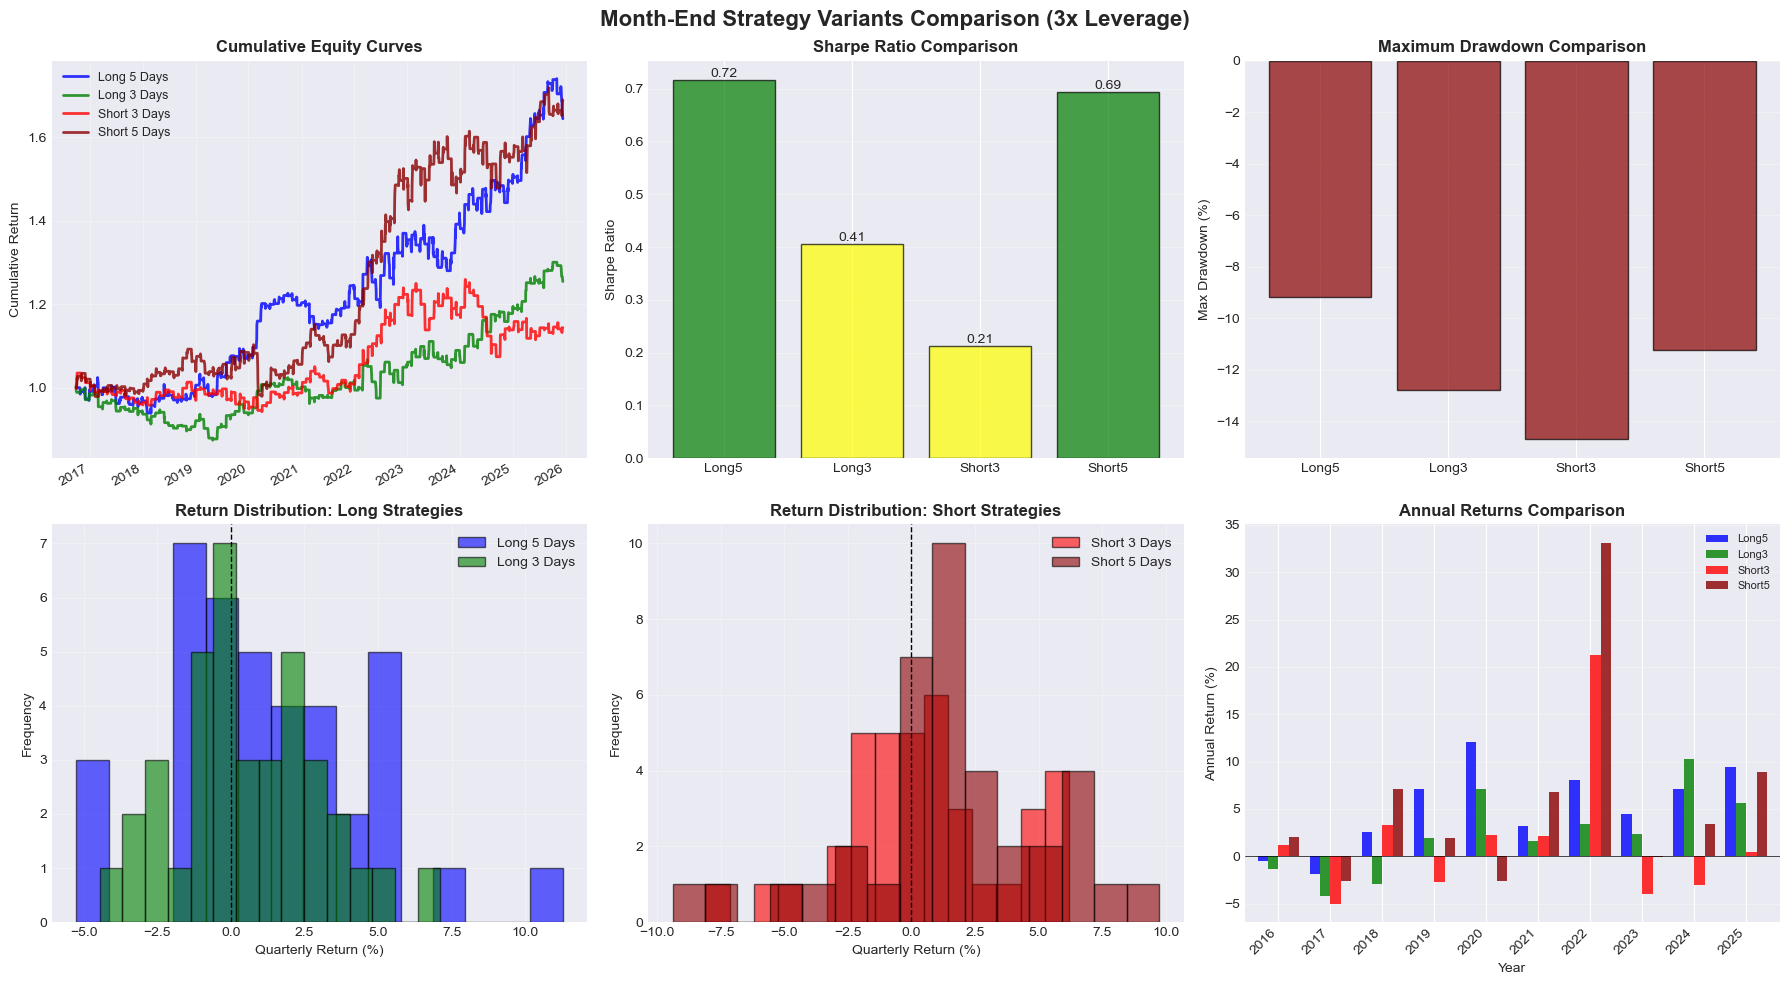

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MONTH-END STRATEGY VARIANTS ANALYSIS - 3X LEVERAGE")
print("="*80)

# ============================================================================
# SETUP: CREATE ALL MONTH-END VARIANTS
# ============================================================================

returns = features_clean['ret_1d']

def identify_month_end_days(dates, days_before=5):
    """Identify the last N trading days of each month"""
    signal = pd.Series(0, index=dates)
    
    # Group by year-month
    df = pd.DataFrame({'date': dates, 'day': dates.day})
    df['year_month'] = df['date'].dt.to_period('M')
    
    # For each month, mark the last N days
    for ym in df['year_month'].unique():
        month_days = df[df['year_month'] == ym].index
        if len(month_days) >= days_before:
            signal.iloc[month_days[-days_before:]] = 1
    
    return signal

def identify_month_start_days(dates, days_after=3):
    """Identify the first N trading days of each month"""
    signal = pd.Series(0, index=dates)
    
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    
    # For each month, mark the first N days
    for ym in df['year_month'].unique():
        month_days = df[df['year_month'] == ym].index
        if len(month_days) >= days_after:
            signal.iloc[month_days[:days_after]] = 1
    
    return signal

# Create all variants
dates = features_clean.index

print("\nCreating strategy variants...")

# Original: Long last 5 days
signal_original = identify_month_end_days(dates, days_before=5)
print(f"  ✓ Original (Long last 5 days): {signal_original.sum()} days")

# Variant 1: Long last 3 days
signal_3day_before = identify_month_end_days(dates, days_before=3)
print(f"  ✓ Variant 1 (Long last 3 days): {signal_3day_before.sum()} days")

# Variant 2: Short first 3 days after month end
signal_3day_after = identify_month_start_days(dates, days_after=3) * -1
print(f"  ✓ Variant 2 (Short first 3 days): {abs(signal_3day_after).sum()} days")

# Variant 3: Short first 5 days after month end
signal_5day_after = identify_month_start_days(dates, days_after=5) * -1
print(f"  ✓ Variant 3 (Short first 5 days): {abs(signal_5day_after).sum()} days")

# Calculate returns for each variant
LEVERAGE = 3

strategies = {
    'Original_Long5': signal_original,
    'Long3_Before': signal_3day_before,
    'Short3_After': signal_3day_after,
    'Short5_After': signal_5day_after
}

strategy_returns = {}
for name, signal in strategies.items():
    strat_ret = signal.shift(1) * returns * LEVERAGE
    strategy_returns[name] = strat_ret

# ============================================================================
# QUARTERLY P&L COMPARISON
# ============================================================================
print("\n" + "-"*80)
print("QUARTERLY P&L - ALL VARIANTS (3X LEVERAGE)")
print("-"*80)

def calculate_quarterly_pnl(returns_series, name):
    """Calculate quarterly P&L"""
    df = pd.DataFrame({
        'returns': returns_series,
        'year': returns_series.index.year,
        'quarter': returns_series.index.quarter
    })
    
    quarterly = df.groupby(['year', 'quarter'])['returns'].apply(
        lambda x: (1 + x).prod() - 1
    )
    
    quarterly_df = pd.DataFrame(quarterly)
    quarterly_df.columns = [name]
    quarterly_df.index = [f"{year}Q{q}" for year, q in quarterly_df.index]
    
    return quarterly_df

# Calculate quarterly P&L for all variants
quarterly_pnls = {}
for name, ret in strategy_returns.items():
    quarterly_pnls[name] = calculate_quarterly_pnl(ret, name)

# Combine
pnl_all = pd.concat([quarterly_pnls[name] for name in strategies.keys()], axis=1)
pnl_all = pnl_all.fillna(0) * 100  # Convert to percentage

print(f"\n{'Quarter':<10s} {'Long5':>10s} {'Long3':>10s} {'Short3':>10s} {'Short5':>10s}")
print("-"*55)

for quarter, row in pnl_all.iterrows():
    print(f"{quarter:<10s} {row['Original_Long5']:>9.2f}% {row['Long3_Before']:>9.2f}% "
          f"{row['Short3_After']:>9.2f}% {row['Short5_After']:>9.2f}%")

# ============================================================================
# ANNUAL SUMMARY
# ============================================================================
print("\n" + "-"*80)
print("ANNUAL RETURNS")
print("-"*80)

def calculate_annual_pnl(returns_series):
    """Calculate annual P&L"""
    df = pd.DataFrame({
        'returns': returns_series,
        'year': returns_series.index.year
    })
    
    return df.groupby('year')['returns'].apply(lambda x: (1 + x).prod() - 1)

annual_returns = {}
for name, ret in strategy_returns.items():
    annual_returns[name] = calculate_annual_pnl(ret)

annual_df = pd.DataFrame(annual_returns) * 100

print(f"\n{'Year':<8s} {'Long5':>10s} {'Long3':>10s} {'Short3':>10s} {'Short5':>10s}")
print("-"*50)

for year, row in annual_df.iterrows():
    print(f"{year:<8d} {row['Original_Long5']:>9.2f}% {row['Long3_Before']:>9.2f}% "
          f"{row['Short3_After']:>9.2f}% {row['Short5_After']:>9.2f}%")

# Totals
print("-"*50)
totals = {}
for name, ret in strategy_returns.items():
    totals[name] = ((1 + ret).prod() - 1) * 100

print(f"{'TOTAL':<8s} {totals['Original_Long5']:>9.2f}% {totals['Long3_Before']:>9.2f}% "
      f"{totals['Short3_After']:>9.2f}% {totals['Short5_After']:>9.2f}%")

# ============================================================================
# COMPREHENSIVE STATISTICS
# ============================================================================
print("\n" + "-"*80)
print("PERFORMANCE STATISTICS (3X LEVERAGE)")
print("-"*80)

def calc_stats(returns_series, name, signal=None):
    """Calculate comprehensive statistics"""
    returns_clean = returns_series.dropna()
    
    if len(returns_clean) == 0:
        return None
    
    # Returns
    total_return = (1 + returns_clean).prod() - 1
    n_years = len(returns_clean) / 252
    ann_return = (1 + total_return) ** (1/n_years) - 1
    ann_vol = returns_clean.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Downside
    downside = returns_clean[returns_clean < 0]
    downside_vol = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_return / downside_vol if downside_vol > 0 else 0
    
    # Drawdown
    cum_ret = (1 + returns_clean).cumprod()
    running_max = cum_ret.expanding().max()
    drawdown = (cum_ret - running_max) / running_max
    max_dd = drawdown.min()
    
    # Calmar
    calmar = ann_return / abs(max_dd) if max_dd != 0 else 0
    
    # Win metrics
    win_rate = (returns_clean > 0).sum() / len(returns_clean)
    
    # Quarterly
    quarterly = calculate_quarterly_pnl(returns_series, name)[name]
    best_q = quarterly.max()
    worst_q = quarterly.min()
    positive_q = (quarterly > 0).sum()
    total_q = len(quarterly)
    q_win_rate = positive_q / total_q if total_q > 0 else 0
    
    # Days active - use provided signal or look up in strategies dict
    if signal is not None:
        days_active = (signal != 0).sum()
    elif name in strategies:
        days_active = (strategies[name] != 0).sum()
    else:
        days_active = 0
    
    return {
        'Strategy': name,
        'Annual Return': ann_return,
        'Annual Vol': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_dd,
        'Calmar Ratio': calmar,
        'Daily Win Rate': win_rate,
        'Best Quarter': best_q,
        'Worst Quarter': worst_q,
        'Quarterly Win Rate': q_win_rate,
        'Positive Quarters': f"{positive_q}/{total_q}",
        'Days Active': days_active
    }

stats_list = []
for name, ret in strategy_returns.items():
    stat = calc_stats(ret, name)
    if stat:
        stats_list.append(stat)

stats_df = pd.DataFrame(stats_list)

# Display names for readability
display_names = {
    'Original_Long5': 'Long Last 5 Days',
    'Long3_Before': 'Long Last 3 Days',
    'Short3_After': 'Short First 3 Days',
    'Short5_After': 'Short First 5 Days'
}

print(f"\n{'Metric':<25s} {'Long5':>12s} {'Long3':>12s} {'Short3':>12s} {'Short5':>12s}")
print("-"*75)

metrics_order = [
    ('Annual Return', '%'),
    ('Annual Vol', '%'),
    ('Sharpe Ratio', ''),
    ('Sortino Ratio', ''),
    ('Max Drawdown', '%'),
    ('Calmar Ratio', ''),
    ('Daily Win Rate', '%'),
    ('Best Quarter', '%'),
    ('Worst Quarter', '%'),
    ('Quarterly Win Rate', '%'),
    ('Days Active', '')
]

for metric, unit in metrics_order:
    if metric == 'Days Active':
        row_values = [stats_df[stats_df['Strategy'] == strat][metric].values[0] 
                     for strat in strategies.keys()]
        print(f"{metric:<25s} {row_values[0]:>12.0f} {row_values[1]:>12.0f} "
              f"{row_values[2]:>12.0f} {row_values[3]:>12.0f}")
    elif unit == '%':
        row_values = [stats_df[stats_df['Strategy'] == strat][metric].values[0] * 100 
                     for strat in strategies.keys()]
        print(f"{metric:<25s} {row_values[0]:>11.2f}% {row_values[1]:>11.2f}% "
              f"{row_values[2]:>11.2f}% {row_values[3]:>11.2f}%")
    else:
        row_values = [stats_df[stats_df['Strategy'] == strat][metric].values[0] 
                     for strat in strategies.keys()]
        print(f"{metric:<25s} {row_values[0]:>12.2f} {row_values[1]:>12.2f} "
              f"{row_values[2]:>12.2f} {row_values[3]:>12.2f}")

# ============================================================================
# VARIANT COMPARISON INSIGHTS
# ============================================================================
print("\n" + "-"*80)
print("VARIANT COMPARISON INSIGHTS")
print("-"*80)

# Compare 5-day vs 3-day long
orig_sharpe = stats_df[stats_df['Strategy'] == 'Original_Long5']['Sharpe Ratio'].values[0]
three_day_sharpe = stats_df[stats_df['Strategy'] == 'Long3_Before']['Sharpe Ratio'].values[0]

print(f"\n1. Long Last 5 Days vs Long Last 3 Days:")
print(f"   5-Day Sharpe: {orig_sharpe:.2f}")
print(f"   3-Day Sharpe: {three_day_sharpe:.2f}")
print(f"   Difference:   {three_day_sharpe - orig_sharpe:+.2f}")

if three_day_sharpe > orig_sharpe + 0.1:
    print(f"   → 3-DAY IS BETTER: Consider switching to 3-day window")
elif three_day_sharpe < orig_sharpe - 0.1:
    print(f"   → 5-DAY IS BETTER: Keep original 5-day window")
else:
    print(f"   → SIMILAR: No strong preference")

# Compare short strategies
short3_sharpe = stats_df[stats_df['Strategy'] == 'Short3_After']['Sharpe Ratio'].values[0]
short5_sharpe = stats_df[stats_df['Strategy'] == 'Short5_After']['Sharpe Ratio'].values[0]

print(f"\n2. Short After Month-End Analysis:")
print(f"   Short 3 Days Sharpe: {short3_sharpe:.2f}")
print(f"   Short 5 Days Sharpe: {short5_sharpe:.2f}")

if short3_sharpe > 0.3 or short5_sharpe > 0.3:
    best_short = "3 Days" if short3_sharpe > short5_sharpe else "5 Days"
    best_short_sharpe = max(short3_sharpe, short5_sharpe)
    print(f"   → SHORT STRATEGY WORKS: Best is {best_short} (Sharpe {best_short_sharpe:.2f})")
    print(f"   → Could combine: Long end of month + Short start of next month")
else:
    print(f"   → SHORT STRATEGIES WEAK: Not recommended")

# Compare to original
print(f"\n3. Best Overall Strategy:")
best_strategy = stats_df.nlargest(1, 'Sharpe Ratio').iloc[0]
print(f"   Strategy: {display_names[best_strategy['Strategy']]}")
print(f"   Sharpe:   {best_strategy['Sharpe Ratio']:.2f}")
print(f"   Annual:   {best_strategy['Annual Return']*100:.2f}%")
print(f"   Max DD:   {best_strategy['Max Drawdown']*100:.2f}%")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Month-End Strategy Variants Comparison (3x Leverage)', 
             fontsize=16, fontweight='bold')

# Plot 1: Equity Curves
ax = axes[0, 0]
colors = ['blue', 'green', 'red', 'darkred']
labels = ['Long 5 Days', 'Long 3 Days', 'Short 3 Days', 'Short 5 Days']

for (name, ret), color, label in zip(strategy_returns.items(), colors, labels):
    cum = (1 + ret).cumprod()
    cum.plot(ax=ax, label=label, linewidth=2, color=color, alpha=0.8)

ax.set_title('Cumulative Equity Curves', fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 2: Sharpe Comparison
ax = axes[0, 1]
sharpes = stats_df.set_index('Strategy')['Sharpe Ratio']
colors_sharpe = ['green' if x > 0.5 else 'yellow' if x > 0 else 'red' for x in sharpes.values]
bars = ax.bar(range(len(sharpes)), sharpes.values, color=colors_sharpe, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(sharpes)))
ax.set_xticklabels(['Long5', 'Long3', 'Short3', 'Short5'], rotation=0)
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio Comparison', fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, sharpes.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# Plot 3: Max Drawdown Comparison
ax = axes[0, 2]
drawdowns = stats_df.set_index('Strategy')['Max Drawdown'] * 100
bars = ax.bar(range(len(drawdowns)), drawdowns.values, color='darkred', alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(drawdowns)))
ax.set_xticklabels(['Long5', 'Long3', 'Short3', 'Short5'], rotation=0)
ax.set_ylabel('Max Drawdown (%)')
ax.set_title('Maximum Drawdown Comparison', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Quarterly Distribution - Original vs Long 3
ax = axes[1, 0]
ax.hist(pnl_all['Original_Long5'], bins=15, alpha=0.6, label='Long 5 Days', 
        color='blue', edgecolor='black')
ax.hist(pnl_all['Long3_Before'], bins=15, alpha=0.6, label='Long 3 Days',
        color='green', edgecolor='black')
ax.set_xlabel('Quarterly Return (%)')
ax.set_ylabel('Frequency')
ax.set_title('Return Distribution: Long Strategies', fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Plot 5: Quarterly Distribution - Short Strategies
ax = axes[1, 1]
ax.hist(pnl_all['Short3_After'], bins=15, alpha=0.6, label='Short 3 Days',
        color='red', edgecolor='black')
ax.hist(pnl_all['Short5_After'], bins=15, alpha=0.6, label='Short 5 Days',
        color='darkred', edgecolor='black')
ax.set_xlabel('Quarterly Return (%)')
ax.set_ylabel('Frequency')
ax.set_title('Return Distribution: Short Strategies', fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Plot 6: Annual Returns Comparison
ax = axes[1, 2]
annual_df.plot(kind='bar', ax=ax, width=0.8, alpha=0.8,
              color=['blue', 'green', 'red', 'darkred'])
ax.set_title('Annual Returns Comparison', fontweight='bold')
ax.set_ylabel('Annual Return (%)')
ax.set_xlabel('Year')
ax.legend(['Long5', 'Long3', 'Short3', 'Short5'], loc='best', fontsize=8)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('month_end_variants_analysis.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: month_end_variants_analysis.png")

# ============================================================================
# COMBINATION STRATEGY TEST
# ============================================================================
print("\n" + "-"*80)
print("BONUS: TESTING COMBINED LONG+SHORT STRATEGY")
print("-"*80)

# Test combining best long with best short
best_long = stats_df.loc[stats_df['Strategy'].isin(['Original_Long5', 'Long3_Before'])].nlargest(1, 'Sharpe Ratio').iloc[0]
best_short = stats_df.loc[stats_df['Strategy'].isin(['Short3_After', 'Short5_After'])].nlargest(1, 'Sharpe Ratio').iloc[0]

print(f"\nBest Long Strategy:  {display_names[best_long['Strategy']]} (Sharpe {best_long['Sharpe Ratio']:.2f})")
print(f"Best Short Strategy: {display_names[best_short['Strategy']]} (Sharpe {best_short['Sharpe Ratio']:.2f})")

# Create combined strategy
signal_best_long = strategies[best_long['Strategy']]
signal_best_short = strategies[best_short['Strategy']]
signal_combined = signal_best_long + signal_best_short

# Calculate returns
combined_returns = signal_combined.shift(1) * returns * LEVERAGE
combined_stats = calc_stats(combined_returns, 'Combined_Long_Short', signal=signal_combined)

if combined_stats:
    print(f"\nCombined Strategy (Best Long + Best Short):")
    print(f"  Annual Return:   {combined_stats['Annual Return']*100:>7.2f}%")
    print(f"  Sharpe Ratio:    {combined_stats['Sharpe Ratio']:>7.2f}")
    print(f"  Max Drawdown:    {combined_stats['Max Drawdown']*100:>7.2f}%")
    print(f"  Days Active:     {combined_stats['Days Active']}")
    
    if combined_stats['Sharpe Ratio'] > best_long['Sharpe Ratio']:
        print(f"\n  ✓ COMBINED IS BETTER: Sharpe improved by {combined_stats['Sharpe Ratio'] - best_long['Sharpe Ratio']:+.2f}")
        print(f"    Recommendation: Use {display_names[best_long['Strategy']]} + {display_names[best_short['Strategy']]}")
    else:
        print(f"\n  → COMBINED NOT BETTER: Stick with {display_names[best_long['Strategy']]} alone")

# ============================================================================
# FINAL RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("FINAL RECOMMENDATIONS")
print("="*80)

# Rank all strategies
ranked = stats_df.sort_values('Sharpe Ratio', ascending=False)

print("\nStrategy Ranking by Sharpe Ratio:")
for i, (_, row) in enumerate(ranked.iterrows(), 1):
    print(f"  {i}. {display_names[row['Strategy']]:25s} Sharpe: {row['Sharpe Ratio']:>5.2f}  "
          f"Return: {row['Annual Return']*100:>6.2f}%  MaxDD: {row['Max Drawdown']*100:>6.2f}%")

best = ranked.iloc[0]
print(f"\n✓ BEST STRATEGY: {display_names[best['Strategy']]}")
print(f"  Implement this for your month-end trading component")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Return comparison table
stats_df[['Strategy', 'Annual Return', 'Sharpe Ratio', 'Max Drawdown', 'Days Active']]

MA CROSS 20/50: TESTING 20 FILTERS VS BASE STRATEGY

Base Strategy: Always Long (20MA>50MA) or Short (20MA<50MA)
Goal: Find filters that improve risk-adjusted returns by going to cash

Leverage: 3x

--------------------------------------------------------------------------------
SETTING UP BASE STRATEGY
--------------------------------------------------------------------------------
Base strategy always invested: 2329 days (100.0%)
Long days: 1109
Short days: 1220

--------------------------------------------------------------------------------
CATEGORY 1: TREASURY-SPECIFIC VOLATILITY FILTERS
--------------------------------------------------------------------------------

1. Low Vol Blackout (avoid when vol < 25th percentile)
   Days filtered out: 582 (25.0%)

2. Vol Regime Stability (only trade in 33rd-67th percentile)
   Days filtered out: 1538 (66.0%)

3. Vol Transition Blackout (avoid rapid vol changes)
   Days filtered out: 465 (20.0%)

4. Asymmetric Vol Bias (short only when vol

Strategy    Sharpe  Annual_Return    Max_DD  Pct_Invested
3   03_VolTransitionBlackout  0.844187       0.115031 -0.245328     80.034350
19      19_EquityCorrelation  0.772032       0.090816 -0.114123     63.160155
0              BASE_NoFilter  0.763582       0.124288 -0.210949    100.000000
5            05_MASeparation  0.739830       0.112874 -0.239577     78.574495
17               17_VIXLevel  0.688764       0.101100 -0.210949     82.567626
8             08_PriceVs20MA  0.686637       0.106729 -0.215987     87.634178
12          12_MAConvergence  0.681837       0.090367 -0.195700     80.034350
20         20_CurveSteepness  0.662674       0.081677 -0.201082     76.170030
18           18_VIXDirection  0.637175       0.086961 -0.155629     76.255904
1          01_LowVolBlackout  0.550937       0.084703 -0.210949     75.010734

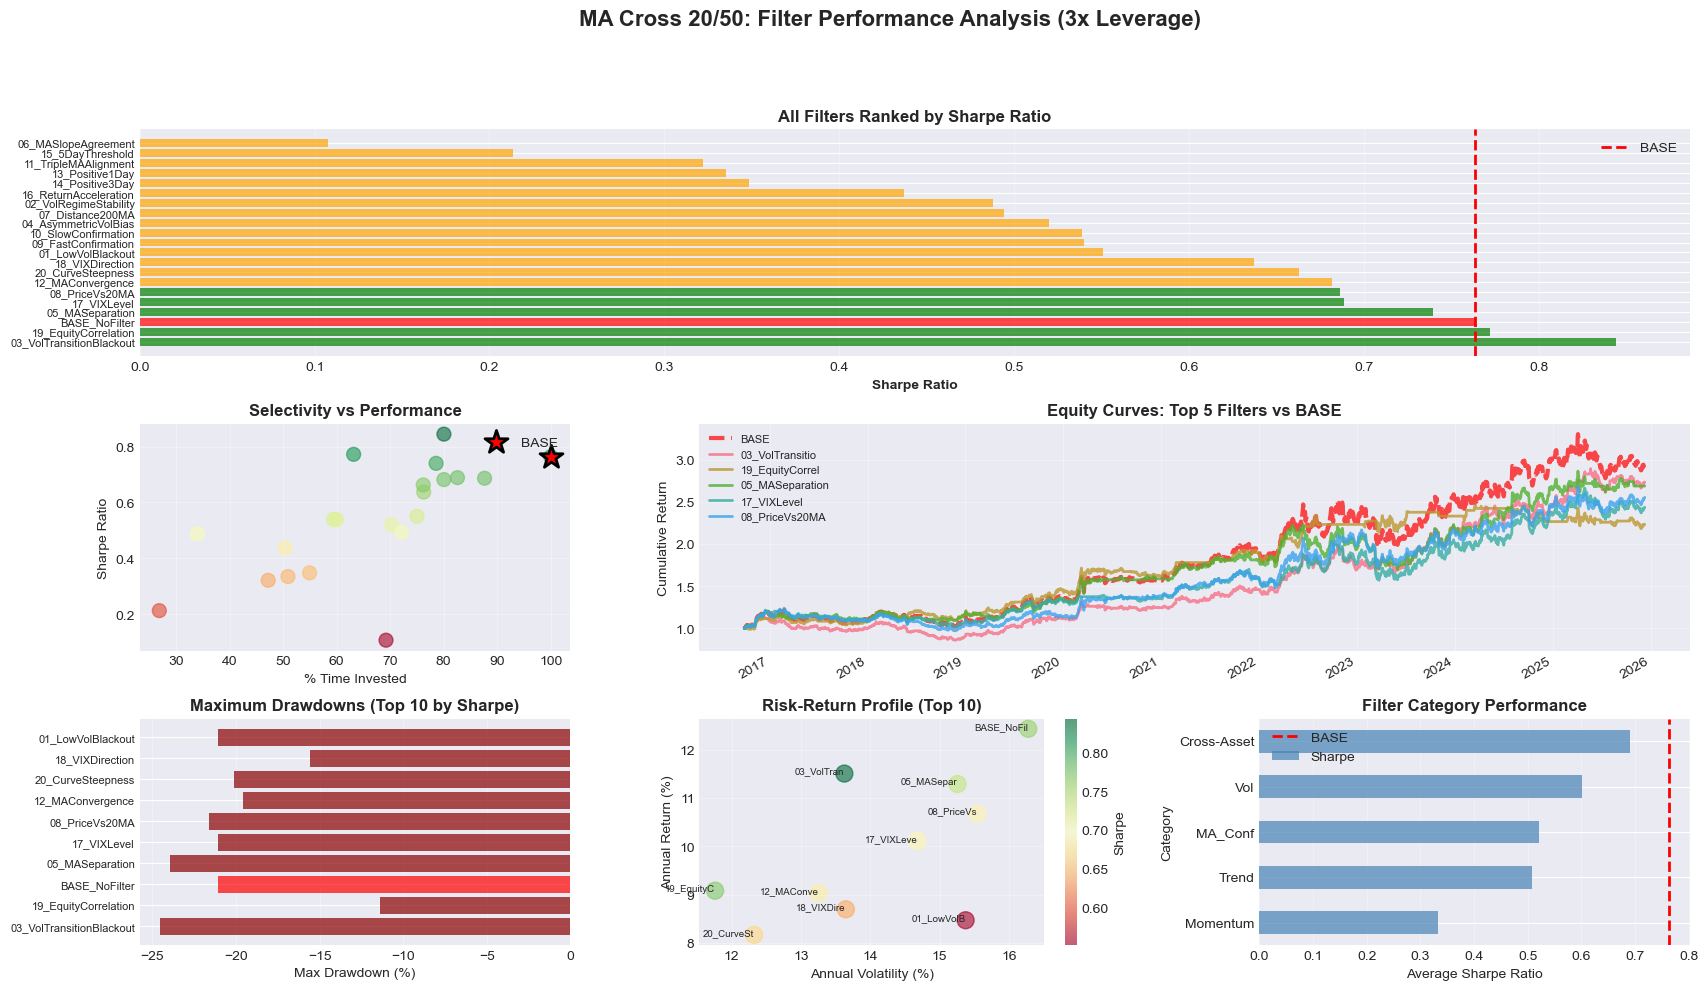

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MA CROSS 20/50: TESTING 20 FILTERS VS BASE STRATEGY")
print("="*80)
print("\nBase Strategy: Always Long (20MA>50MA) or Short (20MA<50MA)")
print("Goal: Find filters that improve risk-adjusted returns by going to cash")
print("\nLeverage: 3x")

LEVERAGE = 3

# ============================================================================
# SETUP: BASE STRATEGY
# ============================================================================
print("\n" + "-"*80)
print("SETTING UP BASE STRATEGY")
print("-"*80)

returns = features_clean['ret_1d']
price = features_clean['price']
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']
ma10 = features_clean['sma_10d']
ma5 = features_clean['sma_5d']
ma100 = features_clean['sma_100d']
ma200 = features_clean['sma_200d']

# Base signal: always long or short
signal_base = pd.Series(0, index=features_clean.index)
signal_base[ma20 > ma50] = 1
signal_base[ma20 < ma50] = -1

base_returns = signal_base.shift(1) * returns * LEVERAGE

print(f"Base strategy always invested: {(signal_base != 0).sum()} days ({100*(signal_base != 0).sum()/len(signal_base):.1f}%)")
print(f"Long days: {(signal_base == 1).sum()}")
print(f"Short days: {(signal_base == -1).sum()}")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def backtest_strategy(signal, returns, name):
    """Backtest a strategy and return metrics"""
    strat_returns = signal.shift(1) * returns * LEVERAGE
    strat_returns = strat_returns.dropna()
    
    if len(strat_returns) == 0:
        return None
    
    # Basic metrics
    total_ret = (1 + strat_returns).prod() - 1
    n_years = len(strat_returns) / 252
    ann_ret = (1 + total_ret) ** (1/n_years) - 1
    ann_vol = strat_returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    # Downside
    downside = strat_returns[strat_returns < 0]
    downside_vol = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0
    
    # Drawdown
    cum = (1 + strat_returns).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    max_dd = dd.min()
    
    # Calmar
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0
    
    # Activity metrics
    long_days = (signal == 1).sum()
    short_days = (signal == -1).sum()
    flat_days = (signal == 0).sum()
    pct_invested = (signal != 0).sum() / len(signal) * 100
    
    # Win rate
    win_rate = (strat_returns > 0).sum() / len(strat_returns)
    
    return {
        'Strategy': name,
        'Annual_Return': ann_ret,
        'Annual_Vol': ann_vol,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max_DD': max_dd,
        'Calmar': calmar,
        'Win_Rate': win_rate,
        'Long_Days': long_days,
        'Short_Days': short_days,
        'Flat_Days': flat_days,
        'Pct_Invested': pct_invested
    }

# ============================================================================
# CATEGORY 1: TREASURY-SPECIFIC VOLATILITY FILTERS
# ============================================================================
print("\n" + "-"*80)
print("CATEGORY 1: TREASURY-SPECIFIC VOLATILITY FILTERS")
print("-"*80)

vol_20d = features_clean['vol_20d']

# Filter 1: Low Vol Blackout (avoid range-bound markets)
print("\n1. Low Vol Blackout (avoid when vol < 25th percentile)")
vol_25th = vol_20d.quantile(0.25)
filter_1 = signal_base.copy()
filter_1[vol_20d < vol_25th] = 0
print(f"   Days filtered out: {(filter_1 == 0).sum()} ({100*(filter_1 == 0).sum()/len(filter_1):.1f}%)")

# Filter 2: Vol Regime Stability (middle third only)
print("\n2. Vol Regime Stability (only trade in 33rd-67th percentile)")
vol_33rd = vol_20d.quantile(0.33)
vol_67th = vol_20d.quantile(0.67)
filter_2 = signal_base.copy()
filter_2[(vol_20d < vol_33rd) | (vol_20d > vol_67th)] = 0
print(f"   Days filtered out: {(filter_2 == 0).sum()} ({100*(filter_2 == 0).sum()/len(filter_2):.1f}%)")

# Filter 3: Vol Transition Blackout
print("\n3. Vol Transition Blackout (avoid rapid vol changes)")
vol_change_5d = vol_20d.diff(5)
vol_change_threshold = vol_change_5d.abs().quantile(0.80)  # Top 20% vol changes
filter_3 = signal_base.copy()
filter_3[vol_change_5d.abs() > vol_change_threshold] = 0
print(f"   Days filtered out: {(filter_3 == 0).sum()} ({100*(filter_3 == 0).sum()/len(filter_3):.1f}%)")

# Filter 4: Asymmetric Vol Bias (long anytime, short only in low vol)
print("\n4. Asymmetric Vol Bias (short only when vol < median)")
vol_median = vol_20d.median()
filter_4 = signal_base.copy()
filter_4[(signal_base == -1) & (vol_20d >= vol_median)] = 0
print(f"   Short trades filtered: {((signal_base == -1) & (filter_4 == 0)).sum()}")

# ============================================================================
# CATEGORY 2: TREND STRENGTH FILTERS
# ============================================================================
print("\n" + "-"*80)
print("CATEGORY 2: TREND STRENGTH FILTERS")
print("-"*80)

# Filter 5: MA Separation Distance
print("\n5. MA Separation Distance (|20MA-50MA| > 0.2% of price)")
ma_separation = abs(ma20 - ma50) / price
separation_threshold = 0.002  # 0.2%
filter_5 = signal_base.copy()
filter_5[ma_separation < separation_threshold] = 0
print(f"   Days filtered out: {(filter_5 == 0).sum()} ({100*(filter_5 == 0).sum()/len(filter_5):.1f}%)")

# Filter 6: MA Slope Agreement
print("\n6. MA Slope Agreement (both MAs must slope in signal direction)")
ma20_slope = ma20.diff(5)
ma50_slope = ma50.diff(5)
filter_6 = signal_base.copy()
# For long: both slopes must be positive
filter_6[(signal_base == 1) & ((ma20_slope <= 0) | (ma50_slope <= 0))] = 0
# For short: both slopes must be negative
filter_6[(signal_base == -1) & ((ma20_slope >= 0) | (ma50_slope >= 0))] = 0
print(f"   Days filtered out: {(filter_6 == 0).sum()} ({100*(filter_6 == 0).sum()/len(filter_6):.1f}%)")

# Filter 7: Distance from 200MA (trade with long-term trend)
print("\n7. Distance from 200MA (align with long-term trend)")
filter_7 = signal_base.copy()
filter_7[(signal_base == 1) & (price < ma200)] = 0  # Don't long below 200MA
filter_7[(signal_base == -1) & (price > ma200)] = 0  # Don't short above 200MA
print(f"   Days filtered out: {(filter_7 == 0).sum()} ({100*(filter_7 == 0).sum()/len(filter_7):.1f}%)")

# Filter 8: Price vs 20MA Distance
print("\n8. Price vs 20MA Distance (price must be away from 20MA)")
price_ma_distance = abs(price - ma20) / price
distance_threshold = 0.001  # 0.1%
filter_8 = signal_base.copy()
filter_8[price_ma_distance < distance_threshold] = 0
print(f"   Days filtered out: {(filter_8 == 0).sum()} ({100*(filter_8 == 0).sum()/len(filter_8):.1f}%)")

# ============================================================================
# CATEGORY 3: MULTI-TIMEFRAME MA CONFIRMATION
# ============================================================================
print("\n" + "-"*80)
print("CATEGORY 3: MULTI-TIMEFRAME MA CONFIRMATION")
print("-"*80)

# Filter 9: Fast Confirmation (5/10 MA)
print("\n9. Fast Confirmation (5MA vs 10MA must agree)")
signal_5_10 = pd.Series(0, index=features_clean.index)
signal_5_10[ma5 > ma10] = 1
signal_5_10[ma5 < ma10] = -1
filter_9 = signal_base.copy()
filter_9[signal_base != signal_5_10] = 0
print(f"   Days filtered out: {(filter_9 == 0).sum()} ({100*(filter_9 == 0).sum()/len(filter_9):.1f}%)")

# Filter 10: Slow Confirmation (50/200 MA)
print("\n10. Slow Confirmation (50MA vs 200MA must agree)")
signal_50_200 = pd.Series(0, index=features_clean.index)
signal_50_200[ma50 > ma200] = 1
signal_50_200[ma50 < ma200] = -1
filter_10 = signal_base.copy()
filter_10[signal_base != signal_50_200] = 0
print(f"   Days filtered out: {(filter_10 == 0).sum()} ({100*(filter_10 == 0).sum()/len(filter_10):.1f}%)")

# Filter 11: Triple MA Agreement
print("\n11. Triple MA Agreement (10/20, 20/50, 50/100 all aligned)")
signal_10_20 = pd.Series(0, index=features_clean.index)
signal_10_20[ma10 > ma20] = 1
signal_10_20[ma10 < ma20] = -1

signal_50_100 = pd.Series(0, index=features_clean.index)
signal_50_100[ma50 > ma100] = 1
signal_50_100[ma50 < ma100] = -1

filter_11 = signal_base.copy()
filter_11[(signal_base != signal_10_20) | (signal_base != signal_50_100)] = 0
print(f"   Days filtered out: {(filter_11 == 0).sum()} ({100*(filter_11 == 0).sum()/len(filter_11):.1f}%)")

# Filter 12: MA Convergence Check
print("\n12. MA Convergence Check (MAs not diverging wildly)")
ma_spread = (ma20 - ma50).abs() / price
spread_change = ma_spread.diff(5)
spread_threshold = spread_change.abs().quantile(0.80)  # Avoid top 20% divergence
filter_12 = signal_base.copy()
filter_12[spread_change.abs() > spread_threshold] = 0
print(f"   Days filtered out: {(filter_12 == 0).sum()} ({100*(filter_12 == 0).sum()/len(filter_12):.1f}%)")

# ============================================================================
# CATEGORY 4: RECENT PERFORMANCE FILTERS
# ============================================================================
print("\n" + "-"*80)
print("CATEGORY 4: RECENT PERFORMANCE FILTERS")
print("-"*80)

# Filter 13: Positive 1-Day Return
print("\n13. Positive 1-Day Return (yesterday moved in signal direction)")
ret_1d = returns
filter_13 = signal_base.copy()
filter_13[(signal_base == 1) & (ret_1d.shift(1) <= 0)] = 0
filter_13[(signal_base == -1) & (ret_1d.shift(1) >= 0)] = 0
print(f"   Days filtered out: {(filter_13 == 0).sum()} ({100*(filter_13 == 0).sum()/len(filter_13):.1f}%)")

# Filter 14: Positive 3-Day Return
print("\n14. Positive 3-Day Return (3-day cumulative in signal direction)")
ret_3d = features_clean['ret_1d'].rolling(3).sum()
filter_14 = signal_base.copy()
filter_14[(signal_base == 1) & (ret_3d.shift(1) <= 0)] = 0
filter_14[(signal_base == -1) & (ret_3d.shift(1) >= 0)] = 0
print(f"   Days filtered out: {(filter_14 == 0).sum()} ({100*(filter_14 == 0).sum()/len(filter_14):.1f}%)")

# Filter 15: 5-Day Return Threshold
print("\n15. 5-Day Return Threshold (5-day return > 0.5% in signal direction)")
ret_5d = features_clean['ret_5d']
threshold_5d = 0.005  # 0.5%
filter_15 = signal_base.copy()
filter_15[(signal_base == 1) & (ret_5d.shift(1) < threshold_5d)] = 0
filter_15[(signal_base == -1) & (ret_5d.shift(1) > -threshold_5d)] = 0
print(f"   Days filtered out: {(filter_15 == 0).sum()} ({100*(filter_15 == 0).sum()/len(filter_15):.1f}%)")

# Filter 16: Return Acceleration
print("\n16. Return Acceleration (3-day avg > 5-day avg)")
ret_3d_avg = returns.rolling(3).mean()
ret_5d_avg = returns.rolling(5).mean()
filter_16 = signal_base.copy()
filter_16[(signal_base == 1) & (ret_3d_avg <= ret_5d_avg)] = 0
filter_16[(signal_base == -1) & (ret_3d_avg >= ret_5d_avg)] = 0
print(f"   Days filtered out: {(filter_16 == 0).sum()} ({100*(filter_16 == 0).sum()/len(filter_16):.1f}%)")

# ============================================================================
# CATEGORY 5: CROSS-ASSET / MARKET REGIME FILTERS
# ============================================================================
print("\n" + "-"*80)
print("CATEGORY 5: CROSS-ASSET / MARKET REGIME FILTERS")
print("-"*80)

# Filter 17: VIX Level Filter
print("\n17. VIX Level Filter (avoid extreme VIX)")
if 'vix' in features_clean.columns:
    vix = features_clean['vix']
    filter_17 = signal_base.copy()
    filter_17[(vix > 30) | (vix < 12)] = 0
    print(f"   Days filtered out: {(filter_17 == 0).sum()} ({100*(filter_17 == 0).sum()/len(filter_17):.1f}%)")
else:
    filter_17 = signal_base.copy()
    print("   VIX not available, filter skipped")

# Filter 18: VIX Direction Filter
print("\n18. VIX Direction Filter (VIX rising favors long)")
if 'vix' in features_clean.columns:
    vix_change = vix.diff(5)
    filter_18 = signal_base.copy()
    # More selective short entries when VIX rising
    filter_18[(signal_base == -1) & (vix_change > 0)] = 0
    print(f"   Days filtered out: {(filter_18 == 0).sum()} ({100*(filter_18 == 0).sum()/len(filter_18):.1f}%)")
else:
    filter_18 = signal_base.copy()
    print("   VIX not available, filter skipped")

# Filter 19: Equity Correlation Filter
print("\n19. Equity Correlation Filter (avoid when TY/SPX correlation breaks)")
if 'spx_ret' in features_clean.columns:
    ty_spx_corr = features_clean['ty_spx_corr_20d']
    filter_19 = signal_base.copy()
    # Normal correlation is negative; positive is anomalous
    filter_19[ty_spx_corr > 0] = 0
    print(f"   Days filtered out: {(filter_19 == 0).sum()} ({100*(filter_19 == 0).sum()/len(filter_19):.1f}%)")
else:
    filter_19 = signal_base.copy()
    print("   SPX correlation not available, filter skipped")

# Filter 20: Curve Steepness Filter
print("\n20. Curve Steepness Filter (avoid abnormal curve)")
if 'curve_2s10s' in features_clean.columns:
    curve = features_clean['curve_2s10s']
    filter_20 = signal_base.copy()
    # Avoid inverted (< 0) or extremely steep (> 2.5%)
    filter_20[(curve < 0) | (curve > 2.5)] = 0
    print(f"   Days filtered out: {(filter_20 == 0).sum()} ({100*(filter_20 == 0).sum()/len(filter_20):.1f}%)")
else:
    filter_20 = signal_base.copy()
    print("   Curve data not available, filter skipped")

# ============================================================================
# BACKTEST ALL STRATEGIES
# ============================================================================
print("\n" + "="*80)
print("BACKTESTING ALL STRATEGIES")
print("="*80)

all_filters = {
    'BASE_NoFilter': signal_base,
    '01_LowVolBlackout': filter_1,
    '02_VolRegimeStability': filter_2,
    '03_VolTransitionBlackout': filter_3,
    '04_AsymmetricVolBias': filter_4,
    '05_MASeparation': filter_5,
    '06_MASlopeAgreement': filter_6,
    '07_Distance200MA': filter_7,
    '08_PriceVs20MA': filter_8,
    '09_FastConfirmation': filter_9,
    '10_SlowConfirmation': filter_10,
    '11_TripleMAAlignment': filter_11,
    '12_MAConvergence': filter_12,
    '13_Positive1Day': filter_13,
    '14_Positive3Day': filter_14,
    '15_5DayThreshold': filter_15,
    '16_ReturnAcceleration': filter_16,
    '17_VIXLevel': filter_17,
    '18_VIXDirection': filter_18,
    '19_EquityCorrelation': filter_19,
    '20_CurveSteepness': filter_20
}

results = []
for name, signal in all_filters.items():
    result = backtest_strategy(signal, returns, name)
    if result:
        results.append(result)
        print(f"  ✓ {name}")

results_df = pd.DataFrame(results)

# ============================================================================
# RESULTS ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("RESULTS: RANKED BY SHARPE RATIO")
print("="*80)

results_sorted = results_df.sort_values('Sharpe', ascending=False)

print(f"\n{'Rank':<5s} {'Strategy':<30s} {'Sharpe':>7s} {'AnnRet':>8s} {'MaxDD':>8s} {'%Inv':>7s}")
print("-"*70)

for i, (_, row) in enumerate(results_sorted.iterrows(), 1):
    marker = "  ← BASE" if row['Strategy'] == 'BASE_NoFilter' else ""
    print(f"{i:<5d} {row['Strategy']:<30s} {row['Sharpe']:>7.2f} "
          f"{row['Annual_Return']*100:>7.2f}% {row['Max_DD']*100:>7.2f}% "
          f"{row['Pct_Invested']:>6.1f}%{marker}")

# ============================================================================
# TOP 5 vs BASE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("TOP 5 FILTERS VS BASE - DETAILED COMPARISON")
print("="*80)

base_stats = results_df[results_df['Strategy'] == 'BASE_NoFilter'].iloc[0]
top_5 = results_sorted[results_sorted['Strategy'] != 'BASE_NoFilter'].head(5)

print(f"\n{'Metric':<25s} {'BASE':>12s} {'Rank 1':>12s} {'Rank 2':>12s} {'Rank 3':>12s} {'Rank 4':>12s} {'Rank 5':>12s}")
print("-"*95)

metrics = [
    ('Sharpe', ''),
    ('Annual_Return', '%'),
    ('Annual_Vol', '%'),
    ('Max_DD', '%'),
    ('Calmar', ''),
    ('Sortino', ''),
    ('Win_Rate', '%'),
    ('Pct_Invested', '%')
]

for metric, unit in metrics:
    base_val = base_stats[metric]
    top_5_vals = [top_5.iloc[i][metric] for i in range(5)]
    
    if unit == '%':
        print(f"{metric:<25s} {base_val*100:>11.2f}% ", end='')
        for val in top_5_vals:
            print(f"{val*100:>11.2f}% ", end='')
    else:
        print(f"{metric:<25s} {base_val:>12.2f} ", end='')
        for val in top_5_vals:
            print(f"{val:>12.2f} ", end='')
    print()

# Print improvement
print("\n" + "-"*95)
print("Improvement vs BASE:")
for i in range(5):
    strategy_name = top_5.iloc[i]['Strategy']
    sharpe_improvement = top_5.iloc[i]['Sharpe'] - base_stats['Sharpe']
    dd_improvement = (base_stats['Max_DD'] - top_5.iloc[i]['Max_DD']) / abs(base_stats['Max_DD']) * 100
    print(f"  {i+1}. {strategy_name:30s} Sharpe: {sharpe_improvement:+.2f}  MaxDD Reduction: {dd_improvement:+.1f}%")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle('MA Cross 20/50: Filter Performance Analysis (3x Leverage)', 
             fontsize=16, fontweight='bold')

# Plot 1: Sharpe Ratio Comparison (all strategies)
ax1 = fig.add_subplot(gs[0, :])
colors = ['red' if x == 'BASE_NoFilter' else 'green' if i < 6 else 'orange' 
          for i, x in enumerate(results_sorted['Strategy'])]
bars = ax1.barh(range(len(results_sorted)), results_sorted['Sharpe'], color=colors, alpha=0.7)
ax1.set_yticks(range(len(results_sorted)))
ax1.set_yticklabels(results_sorted['Strategy'], fontsize=8)
ax1.set_xlabel('Sharpe Ratio', fontweight='bold')
ax1.set_title('All Filters Ranked by Sharpe Ratio', fontweight='bold')
ax1.axvline(x=base_stats['Sharpe'], color='red', linestyle='--', linewidth=2, label='BASE')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Sharpe vs % Invested scatter
ax2 = fig.add_subplot(gs[1, 0])
scatter = ax2.scatter(results_df['Pct_Invested'], results_df['Sharpe'], 
                     s=100, alpha=0.6, c=results_df['Sharpe'], cmap='RdYlGn')
# Highlight base
base_idx = results_df['Strategy'] == 'BASE_NoFilter'
ax2.scatter(results_df.loc[base_idx, 'Pct_Invested'], 
           results_df.loc[base_idx, 'Sharpe'],
           s=300, marker='*', color='red', edgecolor='black', linewidth=2, label='BASE')
ax2.set_xlabel('% Time Invested')
ax2.set_ylabel('Sharpe Ratio')
ax2.set_title('Selectivity vs Performance', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Top 5 equity curves
ax3 = fig.add_subplot(gs[1, 1:])
# Base
base_equity = (1 + base_returns).cumprod()
base_equity.plot(ax=ax3, label='BASE', linewidth=3, color='red', alpha=0.7, linestyle='--')

# Top 5
for i, (_, row) in enumerate(top_5.iterrows()):
    signal = all_filters[row['Strategy']]
    strat_ret = signal.shift(1) * returns * LEVERAGE
    equity = (1 + strat_ret).cumprod()
    equity.plot(ax=ax3, label=row['Strategy'][:15], linewidth=2, alpha=0.8)

ax3.set_title('Equity Curves: Top 5 Filters vs BASE', fontweight='bold')
ax3.set_ylabel('Cumulative Return')
ax3.legend(loc='best', fontsize=8)
ax3.grid(True, alpha=0.3)

# Plot 4: Max Drawdown comparison (Top 10)
ax4 = fig.add_subplot(gs[2, 0])
top_10_dd = results_sorted.head(10)
colors_dd = ['red' if x == 'BASE_NoFilter' else 'darkred' for x in top_10_dd['Strategy']]
ax4.barh(range(len(top_10_dd)), top_10_dd['Max_DD']*100, color=colors_dd, alpha=0.7)
ax4.set_yticks(range(len(top_10_dd)))
ax4.set_yticklabels(top_10_dd['Strategy'], fontsize=8)
ax4.set_xlabel('Max Drawdown (%)')
ax4.set_title('Maximum Drawdowns (Top 10 by Sharpe)', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Plot 5: Annual Return vs Annual Vol (Top 10)
ax5 = fig.add_subplot(gs[2, 1])
top_10_rv = results_sorted.head(10)
scatter = ax5.scatter(top_10_rv['Annual_Vol']*100, top_10_rv['Annual_Return']*100,
                     s=150, alpha=0.6, c=top_10_rv['Sharpe'], cmap='RdYlGn')
# Annotate
for _, row in top_10_rv.iterrows():
    name_short = row['Strategy'][:10]
    ax5.annotate(name_short, 
                (row['Annual_Vol']*100, row['Annual_Return']*100),
                fontsize=7, ha='right')
ax5.set_xlabel('Annual Volatility (%)')
ax5.set_ylabel('Annual Return (%)')
ax5.set_title('Risk-Return Profile (Top 10)', fontweight='bold')
ax5.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax5, label='Sharpe')

# Plot 6: Category performance
ax6 = fig.add_subplot(gs[2, 2])
category_map = {
    '01': 'Vol', '02': 'Vol', '03': 'Vol', '04': 'Vol',
    '05': 'Trend', '06': 'Trend', '07': 'Trend', '08': 'Trend',
    '09': 'MA_Conf', '10': 'MA_Conf', '11': 'MA_Conf', '12': 'MA_Conf',
    '13': 'Momentum', '14': 'Momentum', '15': 'Momentum', '16': 'Momentum',
    '17': 'Cross-Asset', '18': 'Cross-Asset', '19': 'Cross-Asset', '20': 'Cross-Asset'
}

results_df['Category'] = results_df['Strategy'].apply(
    lambda x: category_map.get(x[:2], 'BASE') if x != 'BASE_NoFilter' else 'BASE'
)

category_avg = results_df[results_df['Strategy'] != 'BASE_NoFilter'].groupby('Category')['Sharpe'].mean().sort_values()
category_avg.plot(kind='barh', ax=ax6, color='steelblue', alpha=0.7)
ax6.axvline(x=base_stats['Sharpe'], color='red', linestyle='--', linewidth=2, label='BASE')
ax6.set_xlabel('Average Sharpe Ratio')
ax6.set_title('Filter Category Performance', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='x')

plt.savefig('ma_cross_filter_analysis.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: ma_cross_filter_analysis.png")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("EXECUTIVE SUMMARY")
print("="*80)

print(f"\nBASE Strategy (No Filter):")
print(f"  Sharpe: {base_stats['Sharpe']:.2f}")
print(f"  Annual Return: {base_stats['Annual_Return']*100:.2f}%")
print(f"  Max Drawdown: {base_stats['Max_DD']*100:.2f}%")
print(f"  Always Invested: {base_stats['Pct_Invested']:.1f}%")

print(f"\nBest Filter: {top_5.iloc[0]['Strategy']}")
print(f"  Sharpe: {top_5.iloc[0]['Sharpe']:.2f} (improvement: {top_5.iloc[0]['Sharpe'] - base_stats['Sharpe']:+.2f})")
print(f"  Annual Return: {top_5.iloc[0]['Annual_Return']*100:.2f}%")
print(f"  Max Drawdown: {top_5.iloc[0]['Max_DD']*100:.2f}%")
print(f"  % Invested: {top_5.iloc[0]['Pct_Invested']:.1f}%")

filters_better = (results_sorted['Sharpe'] > base_stats['Sharpe']).sum()
print(f"\nFilters that beat BASE: {filters_better} of 20 ({filters_better/20*100:.0f}%)")

if filters_better > 0:
    print("\n✓ FILTERS ADD VALUE: Selectivity improves risk-adjusted returns")
    print(f"  Recommend implementing: {top_5.iloc[0]['Strategy']}")
else:
    print("\n✗ FILTERS DON'T HELP: Always-invested MA cross is optimal")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Return results table
results_sorted[['Strategy', 'Sharpe', 'Annual_Return', 'Max_DD', 'Pct_Invested']].head(10)

COMBINED FILTER ANALYSIS: #8 + #19

Filter #8: PriceVs20MA (price must be away from 20MA)
Filter #19: EquityCorrelation (avoid when TY/SPX correlation breaks)

Combination Logic: Trade ONLY when BOTH filters pass
Leverage: 3x

--------------------------------------------------------------------------------
SIGNAL STATISTICS
--------------------------------------------------------------------------------

BASE (Always Invested):
  Long:     1109 days ( 47.6%)
  Short:    1220 days ( 52.4%)
  Flat:        0 days (  0.0%)
  Invested: 100.0%

Filter #8 Only:
  Long:      957 days ( 41.1%)
  Short:    1084 days ( 46.5%)
  Flat:      288 days ( 12.4%)
  Invested:  87.6%

Filter #19 Only:
  Long:      776 days ( 33.3%)
  Short:     695 days ( 29.8%)
  Flat:      858 days ( 36.8%)
  Invested:  63.2%

Combined #8 + #19:
  Long:      678 days ( 29.1%)
  Short:     599 days ( 25.7%)
  Flat:     1052 days ( 45.2%)
  Invested:  54.8%

----------------------------------------------------------------

Strategy    Sharpe  Annual_Return    Max_DD  Pct_Invested
0  BASE (Always Invested)  0.763582       0.124288 -0.210949    100.000000
1          Filter #8 Only  0.686637       0.106729 -0.215987     87.634178
2         Filter #19 Only  0.772032       0.090816 -0.114123     63.160155
3       Combined #8 + #19  0.694924       0.078578 -0.148671     54.830399

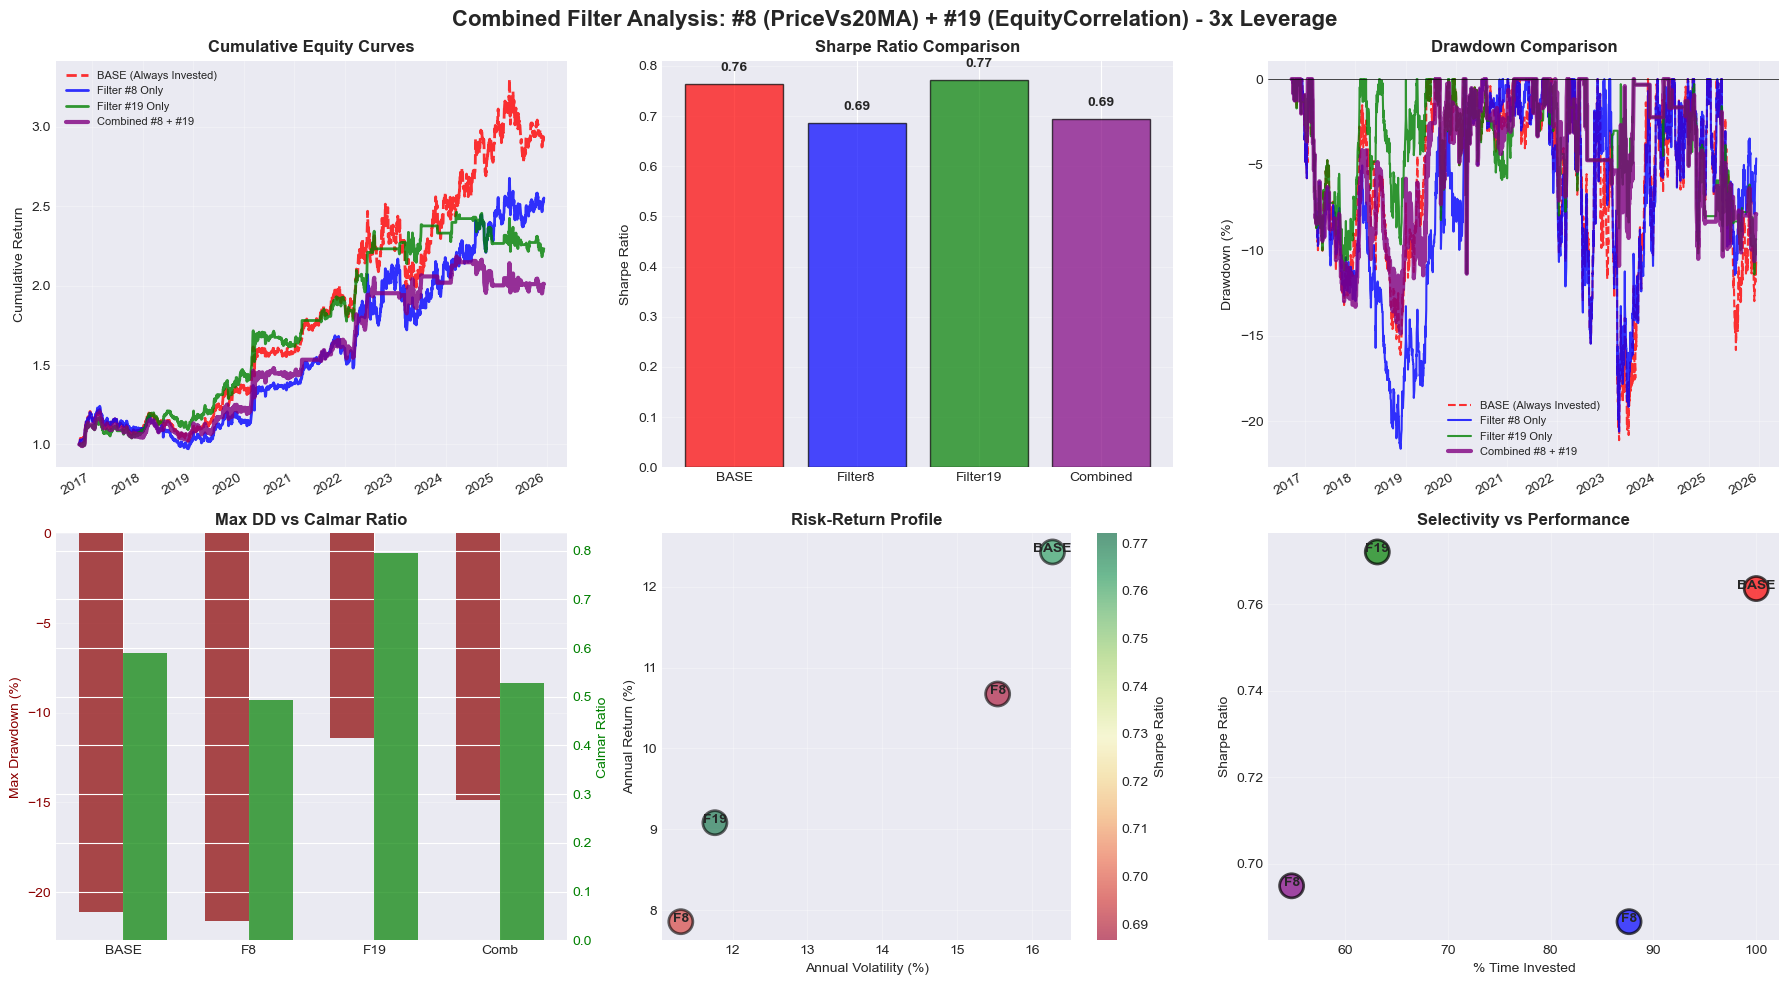

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMBINED FILTER ANALYSIS: #8 + #19")
print("="*80)
print("\nFilter #8: PriceVs20MA (price must be away from 20MA)")
print("Filter #19: EquityCorrelation (avoid when TY/SPX correlation breaks)")
print("\nCombination Logic: Trade ONLY when BOTH filters pass")
print("Leverage: 3x")

LEVERAGE = 3

# ============================================================================
# RECREATE BASE AND INDIVIDUAL FILTERS
# ============================================================================

returns = features_clean['ret_1d']
price = features_clean['price']
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']

# Base signal
signal_base = pd.Series(0, index=features_clean.index)
signal_base[ma20 > ma50] = 1
signal_base[ma20 < ma50] = -1

# Filter 8: Price vs 20MA Distance
price_ma_distance = abs(price - ma20) / price
distance_threshold = 0.001  # 0.1%
filter_8 = signal_base.copy()
filter_8[price_ma_distance < distance_threshold] = 0

# Filter 19: Equity Correlation
ty_spx_corr = features_clean['ty_spx_corr_20d']
filter_19 = signal_base.copy()
filter_19[ty_spx_corr > 0] = 0  # Avoid positive correlation (anomalous)

# Combined Filter: BOTH must pass
filter_combined = signal_base.copy()
# Go flat if EITHER filter says flat
filter_combined[(price_ma_distance < distance_threshold) | (ty_spx_corr > 0)] = 0

print("\n" + "-"*80)
print("SIGNAL STATISTICS")
print("-"*80)

strategies = {
    'BASE (Always Invested)': signal_base,
    'Filter #8 Only': filter_8,
    'Filter #19 Only': filter_19,
    'Combined #8 + #19': filter_combined
}

for name, sig in strategies.items():
    long_days = (sig == 1).sum()
    short_days = (sig == -1).sum()
    flat_days = (sig == 0).sum()
    pct_invested = (sig != 0).sum() / len(sig) * 100
    
    print(f"\n{name}:")
    print(f"  Long:     {long_days:4d} days ({long_days/len(sig)*100:5.1f}%)")
    print(f"  Short:    {short_days:4d} days ({short_days/len(sig)*100:5.1f}%)")
    print(f"  Flat:     {flat_days:4d} days ({flat_days/len(sig)*100:5.1f}%)")
    print(f"  Invested: {pct_invested:5.1f}%")

# ============================================================================
# BACKTEST ALL VERSIONS
# ============================================================================
print("\n" + "-"*80)
print("BACKTESTING")
print("-"*80)

def backtest_strategy(signal, returns, name):
    """Backtest and return metrics"""
    strat_returns = signal.shift(1) * returns * LEVERAGE
    strat_returns = strat_returns.dropna()
    
    if len(strat_returns) == 0:
        return None
    
    total_ret = (1 + strat_returns).prod() - 1
    n_years = len(strat_returns) / 252
    ann_ret = (1 + total_ret) ** (1/n_years) - 1
    ann_vol = strat_returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    downside = strat_returns[strat_returns < 0]
    downside_vol = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0
    
    cum = (1 + strat_returns).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    max_dd = dd.min()
    
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0
    win_rate = (strat_returns > 0).sum() / len(strat_returns)
    
    return {
        'Strategy': name,
        'Total_Return': total_ret,
        'Annual_Return': ann_ret,
        'Annual_Vol': ann_vol,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max_DD': max_dd,
        'Calmar': calmar,
        'Win_Rate': win_rate,
        'Pct_Invested': (signal != 0).sum() / len(signal) * 100,
        'Returns': strat_returns
    }

results = []
for name, sig in strategies.items():
    result = backtest_strategy(sig, returns, name)
    if result:
        results.append(result)

results_df = pd.DataFrame(results)

# ============================================================================
# PERFORMANCE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

print(f"\n{'Strategy':<25s} {'Sharpe':>7s} {'AnnRet':>8s} {'AnnVol':>8s} {'MaxDD':>8s} {'Calmar':>7s} {'%Inv':>7s}")
print("-"*80)

for _, row in results_df.iterrows():
    print(f"{row['Strategy']:<25s} {row['Sharpe']:>7.2f} {row['Annual_Return']*100:>7.2f}% "
          f"{row['Annual_Vol']*100:>7.2f}% {row['Max_DD']*100:>7.2f}% "
          f"{row['Calmar']:>7.2f} {row['Pct_Invested']:>6.1f}%")

# ============================================================================
# IMPROVEMENT ANALYSIS
# ============================================================================
print("\n" + "-"*80)
print("IMPROVEMENT VS BASE")
print("-"*80)

base_sharpe = results_df[results_df['Strategy'] == 'BASE (Always Invested)'].iloc[0]['Sharpe']
base_dd = results_df[results_df['Strategy'] == 'BASE (Always Invested)'].iloc[0]['Max_DD']

print(f"\n{'Strategy':<25s} {'Sharpe Δ':>10s} {'DD Reduction':>13s}")
print("-"*50)

for _, row in results_df.iterrows():
    if row['Strategy'] != 'BASE (Always Invested)':
        sharpe_delta = row['Sharpe'] - base_sharpe
        dd_reduction = (base_dd - row['Max_DD']) / abs(base_dd) * 100
        
        sharpe_marker = "✓" if sharpe_delta > 0 else "✗"
        dd_marker = "✓" if dd_reduction > 0 else "✗"
        
        print(f"{row['Strategy']:<25s} {sharpe_delta:>+9.2f} {sharpe_marker} {dd_reduction:>+11.1f}% {dd_marker}")

# ============================================================================
# COMBINATION EFFECTIVENESS
# ============================================================================
print("\n" + "-"*80)
print("COMBINATION EFFECTIVENESS")
print("-"*80)

filter8_sharpe = results_df[results_df['Strategy'] == 'Filter #8 Only'].iloc[0]['Sharpe']
filter19_sharpe = results_df[results_df['Strategy'] == 'Filter #19 Only'].iloc[0]['Sharpe']
combined_sharpe = results_df[results_df['Strategy'] == 'Combined #8 + #19'].iloc[0]['Sharpe']

best_individual = max(filter8_sharpe, filter19_sharpe)

print(f"\nIndividual Filter Performance:")
print(f"  Filter #8 Sharpe:  {filter8_sharpe:.2f}")
print(f"  Filter #19 Sharpe: {filter19_sharpe:.2f}")
print(f"  Best Individual:   {best_individual:.2f}")

print(f"\nCombined Filter Performance:")
print(f"  Combined Sharpe:   {combined_sharpe:.2f}")
print(f"  vs Best Individual: {combined_sharpe - best_individual:+.2f}")
print(f"  vs BASE:           {combined_sharpe - base_sharpe:+.2f}")

if combined_sharpe > best_individual:
    print(f"\n✓ SYNERGY: Combined filter beats both individuals")
    print(f"  Filters are COMPLEMENTARY (measure different things)")
elif combined_sharpe > best_individual - 0.05:
    print(f"\n~ NEUTRAL: Combined similar to best individual")
    print(f"  Filters may be REDUNDANT (measure similar things)")
else:
    print(f"\n✗ NEGATIVE: Combined worse than best individual")
    print(f"  Over-filtering: Too restrictive, missing opportunities")

# Check overlap
filter8_flat = (filter_8 == 0)
filter19_flat = (filter_19 == 0)
both_flat = filter8_flat & filter19_flat
either_flat = filter8_flat | filter19_flat

overlap = both_flat.sum() / either_flat.sum() * 100 if either_flat.sum() > 0 else 0

print(f"\nFilter Overlap Analysis:")
print(f"  Days filter #8 says flat:  {filter8_flat.sum()} ({filter8_flat.sum()/len(filter_8)*100:.1f}%)")
print(f"  Days filter #19 says flat: {filter19_flat.sum()} ({filter19_flat.sum()/len(filter_19)*100:.1f}%)")
print(f"  Days BOTH say flat:        {both_flat.sum()} ({both_flat.sum()/len(filter_8)*100:.1f}%)")
print(f"  Overlap ratio:             {overlap:.1f}%")

if overlap > 70:
    print(f"  → High overlap: Filters are REDUNDANT")
elif overlap > 40:
    print(f"  → Moderate overlap: Some redundancy")
else:
    print(f"  → Low overlap: Filters are COMPLEMENTARY")

# ============================================================================
# QUARTERLY PERFORMANCE
# ============================================================================
print("\n" + "-"*80)
print("QUARTERLY PERFORMANCE")
print("-"*80)

def calculate_quarterly_pnl(returns_series):
    """Calculate quarterly returns"""
    df = pd.DataFrame({
        'returns': returns_series,
        'year': returns_series.index.year,
        'quarter': returns_series.index.quarter
    })
    
    quarterly = df.groupby(['year', 'quarter'])['returns'].apply(
        lambda x: (1 + x).prod() - 1
    )
    
    quarterly_df = pd.DataFrame(quarterly)
    quarterly_df.columns = ['return']
    quarterly_df.index = [f"{year}Q{q}" for year, q in quarterly_df.index]
    
    return quarterly_df

quarterly_results = {}
for name, sig in strategies.items():
    strat_ret = sig.shift(1) * returns * LEVERAGE
    quarterly_results[name] = calculate_quarterly_pnl(strat_ret)['return']

quarterly_df = pd.DataFrame(quarterly_results) * 100

# Show last 12 quarters
print(f"\n{'Quarter':<10s} {'BASE':>10s} {'Filter8':>10s} {'Filter19':>10s} {'Combined':>10s}")
print("-"*55)

for quarter, row in quarterly_df.tail(12).iterrows():
    print(f"{quarter:<10s} {row['BASE (Always Invested)']:>9.2f}% {row['Filter #8 Only']:>9.2f}% "
          f"{row['Filter #19 Only']:>9.2f}% {row['Combined #8 + #19']:>9.2f}%")

# Quarterly stats
print("\n" + "-"*55)
print("Quarterly Statistics:")
for name in strategies.keys():
    q_returns = quarterly_df[name]
    positive_q = (q_returns > 0).sum()
    total_q = len(q_returns)
    avg_q = q_returns.mean()
    best_q = q_returns.max()
    worst_q = q_returns.min()
    
    print(f"\n{name}:")
    print(f"  Positive Quarters: {positive_q}/{total_q} ({positive_q/total_q*100:.1f}%)")
    print(f"  Avg Quarter:       {avg_q:.2f}%")
    print(f"  Best Quarter:      {best_q:.2f}%")
    print(f"  Worst Quarter:     {worst_q:.2f}%")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Combined Filter Analysis: #8 (PriceVs20MA) + #19 (EquityCorrelation) - 3x Leverage',
             fontsize=16, fontweight='bold')

# Plot 1: Equity Curves
ax = axes[0, 0]
colors = ['red', 'blue', 'green', 'purple']
for (name, sig), color in zip(strategies.items(), colors):
    strat_ret = sig.shift(1) * returns * LEVERAGE
    equity = (1 + strat_ret).cumprod()
    linestyle = '--' if name == 'BASE (Always Invested)' else '-'
    linewidth = 3 if name == 'Combined #8 + #19' else 2
    equity.plot(ax=ax, label=name, color=color, linestyle=linestyle, 
                linewidth=linewidth, alpha=0.8)

ax.set_title('Cumulative Equity Curves', fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Sharpe Comparison
ax = axes[0, 1]
sharpes = results_df.set_index('Strategy')['Sharpe']
colors_sharpe = ['red', 'blue', 'green', 'purple']
bars = ax.bar(range(len(sharpes)), sharpes.values, color=colors_sharpe, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(sharpes)))
ax.set_xticklabels(['BASE', 'Filter8', 'Filter19', 'Combined'], rotation=0)
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio Comparison', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, sharpes.values):
    ax.text(bar.get_x() + bar.get_width()/2., val + 0.02,
            f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Drawdown Comparison
ax = axes[0, 2]
for (name, sig), color in zip(strategies.items(), colors):
    strat_ret = sig.shift(1) * returns * LEVERAGE
    cum = (1 + strat_ret).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    linestyle = '--' if name == 'BASE (Always Invested)' else '-'
    linewidth = 3 if name == 'Combined #8 + #19' else 1.5
    (dd * 100).plot(ax=ax, label=name, color=color, linestyle=linestyle,
                    linewidth=linewidth, alpha=0.8)

ax.set_title('Drawdown Comparison', fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 4: Max DD and Calmar
ax = axes[1, 0]
x = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['Max_DD']*100, width, 
               label='Max DD', color='darkred', alpha=0.7)
ax.set_ylabel('Max Drawdown (%)', color='darkred')
ax.tick_params(axis='y', labelcolor='darkred')
ax.set_xticks(x)
ax.set_xticklabels(['BASE', 'F8', 'F19', 'Comb'], rotation=0)

ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, results_df['Calmar'], width,
                label='Calmar', color='green', alpha=0.7)
ax2.set_ylabel('Calmar Ratio', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax.set_title('Max DD vs Calmar Ratio', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 5: Return vs Vol
ax = axes[1, 1]
scatter = ax.scatter(results_df['Annual_Vol']*100, results_df['Annual_Return']*100,
                    s=300, alpha=0.6, c=results_df['Sharpe'], cmap='RdYlGn',
                    edgecolor='black', linewidth=2)
for _, row in results_df.iterrows():
    name_short = 'BASE' if 'BASE' in row['Strategy'] else 'F8' if '#8' in row['Strategy'] else 'F19' if '#19' in row['Strategy'] else 'COMB'
    ax.annotate(name_short,
               (row['Annual_Vol']*100, row['Annual_Return']*100),
               fontsize=10, fontweight='bold', ha='center')
ax.set_xlabel('Annual Volatility (%)')
ax.set_ylabel('Annual Return (%)')
ax.set_title('Risk-Return Profile', fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Sharpe Ratio')

# Plot 6: % Invested vs Sharpe
ax = axes[1, 2]
ax.scatter(results_df['Pct_Invested'], results_df['Sharpe'],
          s=300, alpha=0.7, c=colors, edgecolor='black', linewidth=2)
for _, row in results_df.iterrows():
    name_short = 'BASE' if 'BASE' in row['Strategy'] else 'F8' if '#8' in row['Strategy'] else 'F19' if '#19' in row['Strategy'] else 'COMB'
    ax.annotate(name_short,
               (row['Pct_Invested'], row['Sharpe']),
               fontsize=10, fontweight='bold', ha='center')
ax.set_xlabel('% Time Invested')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Selectivity vs Performance', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('combined_filters_8_19.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: combined_filters_8_19.png")

# ============================================================================
# FINAL RECOMMENDATION
# ============================================================================
print("\n" + "="*80)
print("FINAL RECOMMENDATION")
print("="*80)

best_strategy = results_df.nlargest(1, 'Sharpe').iloc[0]

print(f"\nBest Performing Strategy: {best_strategy['Strategy']}")
print(f"  Sharpe Ratio:    {best_strategy['Sharpe']:.2f}")
print(f"  Annual Return:   {best_strategy['Annual_Return']*100:.2f}%")
print(f"  Annual Vol:      {best_strategy['Annual_Vol']*100:.2f}%")
print(f"  Max Drawdown:    {best_strategy['Max_DD']*100:.2f}%")
print(f"  % Time Invested: {best_strategy['Pct_Invested']:.1f}%")

print(f"\nImprovement over BASE:")
print(f"  Sharpe:    {best_strategy['Sharpe'] - base_sharpe:+.2f}")
print(f"  Max DD:    {(base_dd - best_strategy['Max_DD'])/abs(base_dd)*100:+.1f}% reduction")

if best_strategy['Strategy'] == 'Combined #8 + #19':
    print(f"\n✓ RECOMMEND COMBINED FILTER:")
    print(f"  Use BOTH PriceVs20MA AND EquityCorrelation filters")
    print(f"  Trade only when:")
    print(f"    - Price is >0.1% away from 20MA (establishes position)")
    print(f"    - TY/SPX correlation is negative (normal regime)")
elif best_strategy['Strategy'] == 'Filter #19 Only':
    print(f"\n✓ RECOMMEND FILTER #19 ONLY:")
    print(f"  EquityCorrelation filter alone is sufficient")
    print(f"  Adding filter #8 doesn't help")
elif best_strategy['Strategy'] == 'Filter #8 Only':
    print(f"\n✓ RECOMMEND FILTER #8 ONLY:")
    print(f"  PriceVs20MA filter alone is sufficient")
    print(f"  Adding filter #19 doesn't help")
else:
    print(f"\n✓ RECOMMEND BASE STRATEGY:")
    print(f"  Filters don't add sufficient value")
    print(f"  Stay always invested")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Return results
results_df[['Strategy', 'Sharpe', 'Annual_Return', 'Max_DD', 'Pct_Invested']]

ALTERNATIVE FILTER APPROACHES: OR LOGIC + DYNAMIC LEVERAGE

--------------------------------------------------------------------------------
STRATEGY VARIANTS
--------------------------------------------------------------------------------

BASE_3x:
  % Invested:     100.0%
  Avg Leverage:   3.00x
  Long exposure:  1109 days
  Short exposure: 1220 days
  Flat:           0 days

AND_Both_Filters_3x:
  % Invested:      54.8%
  Avg Leverage:   3.00x
  Long exposure:  678 days
  Short exposure: 599 days
  Flat:           1052 days

OR_Either_Filter_3x:
  % Invested:      96.0%
  Avg Leverage:   3.00x
  Long exposure:  1055 days
  Short exposure: 1180 days
  Flat:           94 days

Dynamic_2x_Normal_3x_Broken:
  % Invested:     100.0%
  Avg Leverage:   2.37x
  Long exposure:  1109 days
  Short exposure: 1220 days
  Flat:           0 days

Dynamic_3x_Normal_2x_Broken:
  % Invested:     100.0%
  Avg Leverage:   2.63x
  Long exposure:  1109 days
  Short exposure: 1220 days
  Flat:           0

Strategy    Sharpe  Annual_Return    Max_DD  \
4  Dynamic_3x_Normal_2x_Broken  0.821523       0.114592 -0.156130   
0                      BASE_3x  0.763582       0.124288 -0.210949   
2          OR_Either_Filter_3x  0.751293       0.119286 -0.186472   
5            Dynamic_w_Filter8  0.738698       0.098656 -0.193844   
1          AND_Both_Filters_3x  0.694924       0.078578 -0.148671   
3  Dynamic_2x_Normal_3x_Broken  0.684253       0.093860 -0.199075   

   Pct_Invested  
4    100.000000  
0    100.000000  
2     95.963933  
5     87.634178  
1     54.830399  
3    100.000000

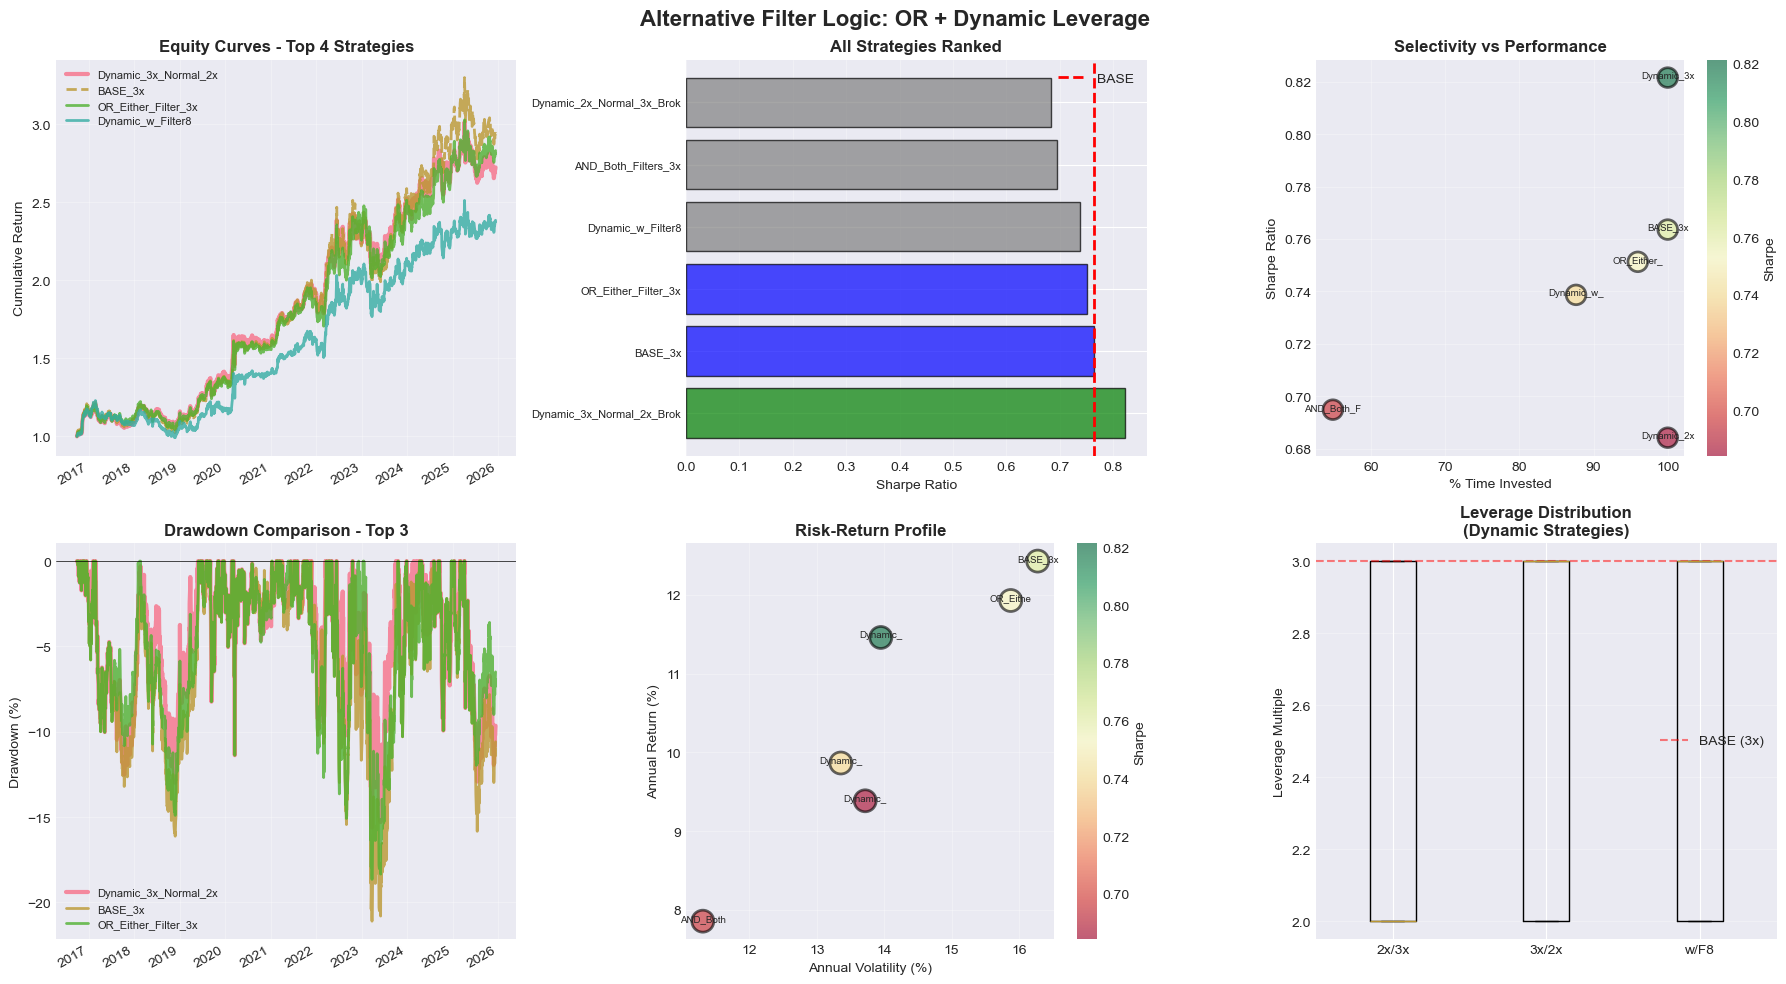

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("ALTERNATIVE FILTER APPROACHES: OR LOGIC + DYNAMIC LEVERAGE")
print("="*80)

# ============================================================================
# SETUP
# ============================================================================

returns = features_clean['ret_1d']
price = features_clean['price']
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']

# Base signal (unleveraged)
signal_base = pd.Series(0, index=features_clean.index)
signal_base[ma20 > ma50] = 1
signal_base[ma20 < ma50] = -1

# Filter conditions
price_ma_distance = abs(price - ma20) / price
distance_threshold = 0.001  # 0.1%
filter_8_condition = price_ma_distance >= distance_threshold

ty_spx_corr = features_clean['ty_spx_corr_20d']
filter_19_condition = ty_spx_corr <= 0  # Normal = negative correlation

# ============================================================================
# STRATEGY VARIANTS
# ============================================================================
print("\n" + "-"*80)
print("STRATEGY VARIANTS")
print("-"*80)

# Original BASE (always invested, 3x leverage)
signal_base_3x = signal_base * 3

# Original AND logic (both must pass, 3x leverage)
signal_and = signal_base.copy()
signal_and[~(filter_8_condition & filter_19_condition)] = 0
signal_and_3x = signal_and * 3

# NEW 1: OR logic (either filter passes, 3x leverage)
signal_or = signal_base.copy()
signal_or[~(filter_8_condition | filter_19_condition)] = 0  # Flat only if BOTH fail
signal_or_3x = signal_or * 3

# NEW 2A: Dynamic leverage - MORE leverage in normal regime (your stated version)
# Normal (filter 19 true) = 2x, Broken (filter 19 false) = 3x
signal_dynamic_a = signal_base.copy()
signal_dynamic_a = signal_dynamic_a.astype(float)
# When correlation is normal (negative), use 2x
signal_dynamic_a[filter_19_condition] = signal_base[filter_19_condition] * 2
# When correlation is broken (positive), use 3x
signal_dynamic_a[~filter_19_condition] = signal_base[~filter_19_condition] * 3

# NEW 2B: Dynamic leverage - MORE leverage in broken regime (intuitive version)
# Normal (filter 19 true) = 3x, Broken (filter 19 false) = 2x (defensive)
signal_dynamic_b = signal_base.copy()
signal_dynamic_b = signal_dynamic_b.astype(float)
# When correlation is normal (negative), use 3x (aggressive)
signal_dynamic_b[filter_19_condition] = signal_base[filter_19_condition] * 3
# When correlation is broken (positive), use 2x (defensive)
signal_dynamic_b[~filter_19_condition] = signal_base[~filter_19_condition] * 2

# NEW 2C: Dynamic leverage with filter 8 selectivity
# Only trade when filter 8 passes, but leverage based on filter 19
signal_dynamic_c = signal_base.copy()
signal_dynamic_c = signal_dynamic_c.astype(float)
# First apply filter 8 (go flat if too close to 20MA)
signal_dynamic_c[~filter_8_condition] = 0
# Then apply dynamic leverage based on filter 19
signal_dynamic_c[filter_8_condition & filter_19_condition] = signal_base[filter_8_condition & filter_19_condition] * 3
signal_dynamic_c[filter_8_condition & ~filter_19_condition] = signal_base[filter_8_condition & ~filter_19_condition] * 2

strategies = {
    'BASE_3x': signal_base_3x,
    'AND_Both_Filters_3x': signal_and_3x,
    'OR_Either_Filter_3x': signal_or_3x,
    'Dynamic_2x_Normal_3x_Broken': signal_dynamic_a,
    'Dynamic_3x_Normal_2x_Broken': signal_dynamic_b,
    'Dynamic_w_Filter8': signal_dynamic_c
}

# Print signal stats
for name, sig in strategies.items():
    pct_invested = (sig != 0).sum() / len(sig) * 100
    avg_leverage = sig[sig != 0].abs().mean() if (sig != 0).any() else 0
    
    print(f"\n{name}:")
    print(f"  % Invested:     {pct_invested:5.1f}%")
    print(f"  Avg Leverage:   {avg_leverage:.2f}x")
    print(f"  Long exposure:  {(sig > 0).sum()} days")
    print(f"  Short exposure: {(sig < 0).sum()} days")
    print(f"  Flat:           {(sig == 0).sum()} days")

# ============================================================================
# BACKTEST ALL STRATEGIES
# ============================================================================
print("\n" + "-"*80)
print("BACKTESTING")
print("-"*80)

def backtest_strategy(signal, returns, name):
    """Backtest with variable leverage already in signal"""
    strat_returns = signal.shift(1) * returns
    strat_returns = strat_returns.dropna()
    
    if len(strat_returns) == 0:
        return None
    
    total_ret = (1 + strat_returns).prod() - 1
    n_years = len(strat_returns) / 252
    ann_ret = (1 + total_ret) ** (1/n_years) - 1
    ann_vol = strat_returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    downside = strat_returns[strat_returns < 0]
    downside_vol = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0
    
    cum = (1 + strat_returns).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    max_dd = dd.min()
    
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0
    win_rate = (strat_returns > 0).sum() / len(strat_returns)
    
    return {
        'Strategy': name,
        'Total_Return': total_ret,
        'Annual_Return': ann_ret,
        'Annual_Vol': ann_vol,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max_DD': max_dd,
        'Calmar': calmar,
        'Win_Rate': win_rate,
        'Pct_Invested': (signal != 0).sum() / len(signal) * 100,
        'Returns': strat_returns
    }

results = []
for name, sig in strategies.items():
    result = backtest_strategy(sig, returns, name)
    if result:
        results.append(result)
        print(f"  ✓ {name}")

results_df = pd.DataFrame(results)

# ============================================================================
# PERFORMANCE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

results_sorted = results_df.sort_values('Sharpe', ascending=False)

print(f"\n{'Rank':<5s} {'Strategy':<30s} {'Sharpe':>7s} {'AnnRet':>8s} {'MaxDD':>8s} {'%Inv':>7s}")
print("-"*70)

for i, (_, row) in enumerate(results_sorted.iterrows(), 1):
    marker = "  ← BASE" if row['Strategy'] == 'BASE_3x' else ""
    print(f"{i:<5d} {row['Strategy']:<30s} {row['Sharpe']:>7.2f} "
          f"{row['Annual_Return']*100:>7.2f}% {row['Max_DD']*100:>7.2f}% "
          f"{row['Pct_Invested']:>6.1f}%{marker}")

# ============================================================================
# DETAILED COMPARISON
# ============================================================================
print("\n" + "-"*80)
print("DETAILED METRICS")
print("-"*80)

print(f"\n{'Metric':<25s} " + "".join([f"{row['Strategy'][:12]:>13s} " for _, row in results_sorted.head(4).iterrows()]))
print("-"*80)

metrics = [
    ('Sharpe', ''),
    ('Annual_Return', '%'),
    ('Annual_Vol', '%'),
    ('Max_DD', '%'),
    ('Calmar', ''),
    ('Sortino', ''),
    ('Win_Rate', '%'),
    ('Pct_Invested', '%')
]

for metric, unit in metrics:
    print(f"{metric:<25s} ", end='')
    for _, row in results_sorted.head(4).iterrows():
        val = row[metric]
        if unit == '%':
            print(f"{val*100:>12.2f}% ", end='')
        else:
            print(f"{val:>13.2f} ", end='')
    print()

# ============================================================================
# KEY INSIGHTS
# ============================================================================
print("\n" + "-"*80)
print("KEY INSIGHTS")
print("-"*80)

base_sharpe = results_df[results_df['Strategy'] == 'BASE_3x'].iloc[0]['Sharpe']
base_dd = results_df[results_df['Strategy'] == 'BASE_3x'].iloc[0]['Max_DD']

print("\nImprovement vs BASE:")
for _, row in results_sorted.iterrows():
    if row['Strategy'] != 'BASE_3x':
        sharpe_delta = row['Sharpe'] - base_sharpe
        dd_improvement = (base_dd - row['Max_DD']) / abs(base_dd) * 100
        
        marker = "✓✓" if sharpe_delta > 0.05 else "✓" if sharpe_delta > 0 else "✗"
        
        print(f"  {row['Strategy']:<30s} Sharpe: {sharpe_delta:>+6.2f} {marker}  DD: {dd_improvement:>+6.1f}%")

# Compare OR vs AND
and_sharpe = results_df[results_df['Strategy'] == 'AND_Both_Filters_3x'].iloc[0]['Sharpe']
or_sharpe = results_df[results_df['Strategy'] == 'OR_Either_Filter_3x'].iloc[0]['Sharpe']

print(f"\nOR vs AND Logic:")
print(f"  AND (both filters):    Sharpe {and_sharpe:.2f}")
print(f"  OR (either filter):    Sharpe {or_sharpe:.2f}")
print(f"  Difference:            {or_sharpe - and_sharpe:+.2f}")

if or_sharpe > and_sharpe + 0.05:
    print(f"  → OR LOGIC BETTER: Less restrictive, catches more opportunities")
elif or_sharpe < and_sharpe - 0.05:
    print(f"  → AND LOGIC BETTER: More selective, higher quality trades")
else:
    print(f"  → SIMILAR: No strong preference")

# Compare dynamic leverage versions
dynamic_a_sharpe = results_df[results_df['Strategy'] == 'Dynamic_2x_Normal_3x_Broken'].iloc[0]['Sharpe']
dynamic_b_sharpe = results_df[results_df['Strategy'] == 'Dynamic_3x_Normal_2x_Broken'].iloc[0]['Sharpe']
dynamic_c_sharpe = results_df[results_df['Strategy'] == 'Dynamic_w_Filter8'].iloc[0]['Sharpe']

print(f"\nDynamic Leverage Approaches:")
print(f"  2x Normal / 3x Broken:         Sharpe {dynamic_a_sharpe:.2f}")
print(f"  3x Normal / 2x Broken:         Sharpe {dynamic_b_sharpe:.2f}")
print(f"  w/ Filter8 Selectivity:        Sharpe {dynamic_c_sharpe:.2f}")

best_dynamic = max(dynamic_a_sharpe, dynamic_b_sharpe, dynamic_c_sharpe)
if best_dynamic == dynamic_a_sharpe:
    print(f"  → Best: Increase leverage in BROKEN regime (3x when corr positive)")
elif best_dynamic == dynamic_b_sharpe:
    print(f"  → Best: Increase leverage in NORMAL regime (3x when corr negative)")
else:
    print(f"  → Best: Dynamic with filter 8 selectivity")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Alternative Filter Logic: OR + Dynamic Leverage',
             fontsize=16, fontweight='bold')

# Plot 1: Equity Curves (Top 4)
ax = axes[0, 0]
for _, row in results_sorted.head(4).iterrows():
    sig = strategies[row['Strategy']]
    equity = (1 + sig.shift(1) * returns).cumprod()
    linewidth = 3 if row['Strategy'] == results_sorted.iloc[0]['Strategy'] else 2
    linestyle = '--' if row['Strategy'] == 'BASE_3x' else '-'
    equity.plot(ax=ax, label=row['Strategy'][:20], linewidth=linewidth, 
                linestyle=linestyle, alpha=0.8)

ax.set_title('Equity Curves - Top 4 Strategies', fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Sharpe Ranking
ax = axes[0, 1]
colors = ['green' if i == 0 else 'blue' if i < 3 else 'gray' 
          for i in range(len(results_sorted))]
bars = ax.barh(range(len(results_sorted)), results_sorted['Sharpe'], 
               color=colors, alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(results_sorted)))
ax.set_yticklabels([s[:25] for s in results_sorted['Strategy']], fontsize=8)
ax.set_xlabel('Sharpe Ratio')
ax.set_title('All Strategies Ranked', fontweight='bold')
ax.axvline(x=base_sharpe, color='red', linestyle='--', linewidth=2, label='BASE')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# Plot 3: Sharpe vs % Invested
ax = axes[0, 2]
scatter = ax.scatter(results_df['Pct_Invested'], results_df['Sharpe'],
                    s=200, alpha=0.6, c=results_df['Sharpe'], cmap='RdYlGn',
                    edgecolor='black', linewidth=2)
for _, row in results_df.iterrows():
    name_short = row['Strategy'][:10]
    ax.annotate(name_short,
               (row['Pct_Invested'], row['Sharpe']),
               fontsize=7, ha='center')
ax.set_xlabel('% Time Invested')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Selectivity vs Performance', fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Sharpe')

# Plot 4: Drawdowns (Top 3)
ax = axes[1, 0]
for _, row in results_sorted.head(3).iterrows():
    sig = strategies[row['Strategy']]
    cum = (1 + sig.shift(1) * returns).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    linewidth = 3 if row['Strategy'] == results_sorted.iloc[0]['Strategy'] else 2
    (dd * 100).plot(ax=ax, label=row['Strategy'][:20], linewidth=linewidth, alpha=0.8)

ax.set_title('Drawdown Comparison - Top 3', fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 5: Risk-Return Profile
ax = axes[1, 1]
scatter = ax.scatter(results_df['Annual_Vol']*100, results_df['Annual_Return']*100,
                    s=250, alpha=0.6, c=results_df['Sharpe'], cmap='RdYlGn',
                    edgecolor='black', linewidth=2)
for _, row in results_df.iterrows():
    name_short = row['Strategy'][:8]
    ax.annotate(name_short,
               (row['Annual_Vol']*100, row['Annual_Return']*100),
               fontsize=7, ha='center')
ax.set_xlabel('Annual Volatility (%)')
ax.set_ylabel('Annual Return (%)')
ax.set_title('Risk-Return Profile', fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Sharpe')

# Plot 6: Leverage Distribution (for dynamic strategies)
ax = axes[1, 2]
dynamic_strats = ['Dynamic_2x_Normal_3x_Broken', 'Dynamic_3x_Normal_2x_Broken', 'Dynamic_w_Filter8']
leverage_data = []

for strat in dynamic_strats:
    sig = strategies[strat]
    leverages = sig[sig != 0].abs()
    leverage_data.append(leverages)

ax.boxplot(leverage_data, labels=['2x/3x', '3x/2x', 'w/F8'])
ax.set_ylabel('Leverage Multiple')
ax.set_title('Leverage Distribution\n(Dynamic Strategies)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=3, color='red', linestyle='--', alpha=0.5, label='BASE (3x)')
ax.legend()

plt.tight_layout()
plt.savefig('alternative_filter_logic.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: alternative_filter_logic.png")

# ============================================================================
# FINAL RECOMMENDATION
# ============================================================================
print("\n" + "="*80)
print("FINAL RECOMMENDATION")
print("="*80)

best = results_sorted.iloc[0]

print(f"\nBest Strategy: {best['Strategy']}")
print(f"  Sharpe:          {best['Sharpe']:.2f}")
print(f"  Annual Return:   {best['Annual_Return']*100:.2f}%")
print(f"  Max Drawdown:    {best['Max_DD']*100:.2f}%")
print(f"  % Invested:      {best['Pct_Invested']:.1f}%")

print(f"\nImprovement vs BASE:")
print(f"  Sharpe:    {best['Sharpe'] - base_sharpe:+.2f} ({(best['Sharpe'] - base_sharpe)/base_sharpe*100:+.1f}%)")
print(f"  MaxDD:     {(base_dd - best['Max_DD'])/abs(base_dd)*100:+.1f}% reduction")

if best['Strategy'] == 'BASE_3x':
    print("\n→ Stick with BASE strategy (no filters)")
elif 'OR' in best['Strategy']:
    print("\n✓ RECOMMEND OR LOGIC: Trade when EITHER filter passes")
    print("  Go flat only when BOTH filters fail")
elif 'Dynamic' in best['Strategy']:
    print(f"\n✓ RECOMMEND DYNAMIC LEVERAGE: {best['Strategy']}")
    print("  Use correlation regime to adjust position size")
else:
    print(f"\n✓ RECOMMEND: {best['Strategy']}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Return results
results_sorted[['Strategy', 'Sharpe', 'Annual_Return', 'Max_DD', 'Pct_Invested']]

ALTERNATIVE FILTER APPROACHES: OR LOGIC + DYNAMIC LEVERAGE

--------------------------------------------------------------------------------
STRATEGY VARIANTS
--------------------------------------------------------------------------------

BASE_3x:
  % Invested:     100.0%
  Avg Leverage:   3.00x
  Long exposure:  1109 days
  Short exposure: 1220 days
  Flat:           0 days

AND_Both_Filters_3x:
  % Invested:      54.8%
  Avg Leverage:   3.00x
  Long exposure:  678 days
  Short exposure: 599 days
  Flat:           1052 days

OR_Either_Filter_3x:
  % Invested:      96.0%
  Avg Leverage:   3.00x
  Long exposure:  1055 days
  Short exposure: 1180 days
  Flat:           94 days

Dynamic_2x_Normal_3x_Broken:
  % Invested:     100.0%
  Avg Leverage:   2.37x
  Long exposure:  1109 days
  Short exposure: 1220 days
  Flat:           0 days

Dynamic_3x_Normal_2x_Broken:
  % Invested:     100.0%
  Avg Leverage:   2.63x
  Long exposure:  1109 days
  Short exposure: 1220 days
  Flat:           0

Strategy    Sharpe  Annual_Return    Max_DD  \
4  Dynamic_3x_Normal_2x_Broken  0.821523       0.114592 -0.156130   
6              Tiered_2x_or_3x  0.791544       0.107081 -0.146962   
0                      BASE_3x  0.763582       0.124288 -0.210949   
2          OR_Either_Filter_3x  0.751293       0.119286 -0.186472   
5            Dynamic_w_Filter8  0.738698       0.098656 -0.193844   
1          AND_Both_Filters_3x  0.694924       0.078578 -0.148671   
3  Dynamic_2x_Normal_3x_Broken  0.684253       0.093860 -0.199075   

   Pct_Invested  
4    100.000000  
6     95.963933  
0    100.000000  
2     95.963933  
5     87.634178  
1     54.830399  
3    100.000000

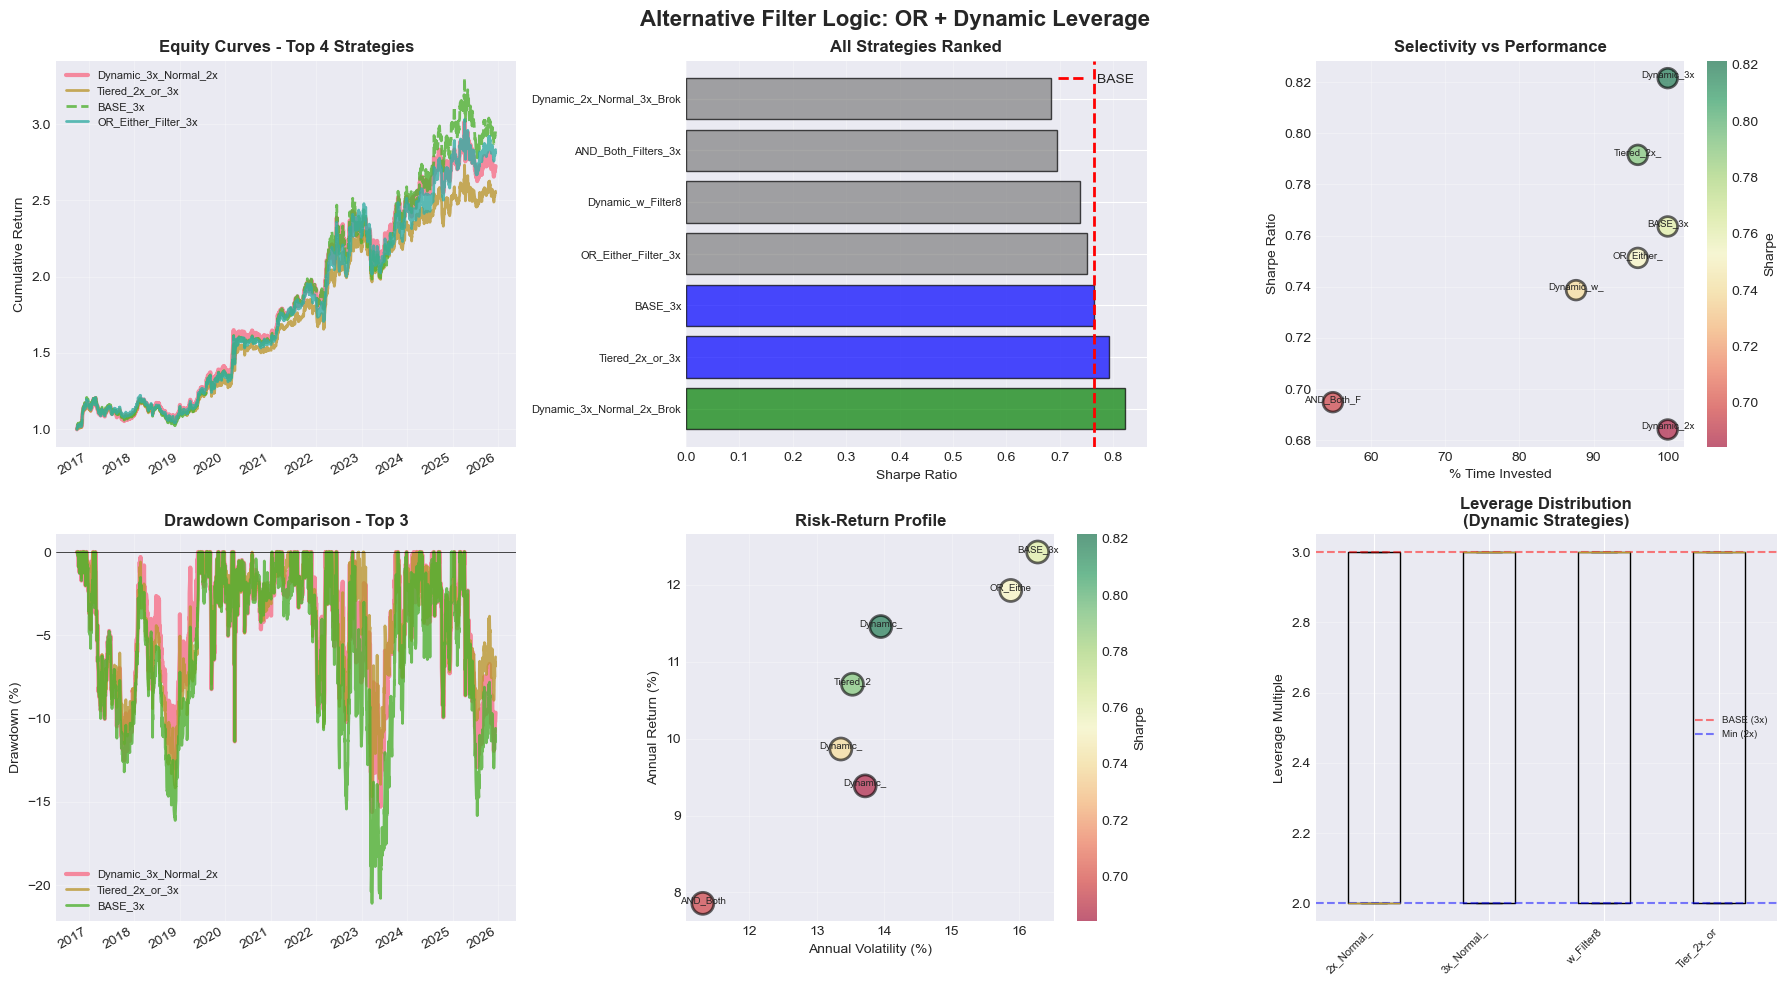

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("ALTERNATIVE FILTER APPROACHES: OR LOGIC + DYNAMIC LEVERAGE")
print("="*80)

# ============================================================================
# SETUP
# ============================================================================

returns = features_clean['ret_1d']
price = features_clean['price']
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']

# Base signal (unleveraged)
signal_base = pd.Series(0, index=features_clean.index)
signal_base[ma20 > ma50] = 1
signal_base[ma20 < ma50] = -1

# Filter conditions
price_ma_distance = abs(price - ma20) / price
distance_threshold = 0.001  # 0.1%
filter_8_condition = price_ma_distance >= distance_threshold

ty_spx_corr = features_clean['ty_spx_corr_20d']
filter_19_condition = ty_spx_corr <= 0  # Normal = negative correlation

# ============================================================================
# STRATEGY VARIANTS
# ============================================================================
print("\n" + "-"*80)
print("STRATEGY VARIANTS")
print("-"*80)

# Original BASE (always invested, 3x leverage)
signal_base_3x = signal_base * 3

# Original AND logic (both must pass, 3x leverage)
signal_and = signal_base.copy()
signal_and[~(filter_8_condition & filter_19_condition)] = 0
signal_and_3x = signal_and * 3

# NEW 1: OR logic (either filter passes, 3x leverage)
signal_or = signal_base.copy()
signal_or[~(filter_8_condition | filter_19_condition)] = 0  # Flat only if BOTH fail
signal_or_3x = signal_or * 3

# NEW 2A: Dynamic leverage - MORE leverage in normal regime (your stated version)
# Normal (filter 19 true) = 2x, Broken (filter 19 false) = 3x
signal_dynamic_a = signal_base.copy()
signal_dynamic_a = signal_dynamic_a.astype(float)
# When correlation is normal (negative), use 2x
signal_dynamic_a[filter_19_condition] = signal_base[filter_19_condition] * 2
# When correlation is broken (positive), use 3x
signal_dynamic_a[~filter_19_condition] = signal_base[~filter_19_condition] * 3

# NEW 2B: Dynamic leverage - MORE leverage in broken regime (intuitive version)
# Normal (filter 19 true) = 3x, Broken (filter 19 false) = 2x (defensive)
signal_dynamic_b = signal_base.copy()
signal_dynamic_b = signal_dynamic_b.astype(float)
# When correlation is normal (negative), use 3x (aggressive)
signal_dynamic_b[filter_19_condition] = signal_base[filter_19_condition] * 3
# When correlation is broken (positive), use 2x (defensive)
signal_dynamic_b[~filter_19_condition] = signal_base[~filter_19_condition] * 2

# NEW 2C: Dynamic leverage with filter 8 selectivity
# Only trade when filter 8 passes, but leverage based on filter 19
signal_dynamic_c = signal_base.copy()
signal_dynamic_c = signal_dynamic_c.astype(float)
# First apply filter 8 (go flat if too close to 20MA)
signal_dynamic_c[~filter_8_condition] = 0
# Then apply dynamic leverage based on filter 19
signal_dynamic_c[filter_8_condition & filter_19_condition] = signal_base[filter_8_condition & filter_19_condition] * 3
signal_dynamic_c[filter_8_condition & ~filter_19_condition] = signal_base[filter_8_condition & ~filter_19_condition] * 2

# NEW 2D: Tiered conviction - leverage based on how many filters pass
signal_tiered = signal_base.copy()
signal_tiered = signal_tiered.astype(float)

# Both filters pass = highest conviction = 3x
both_pass = filter_8_condition & filter_19_condition
signal_tiered[both_pass] = signal_base[both_pass] * 3

# Only one filter passes = medium conviction = 2x
one_passes = (filter_8_condition & ~filter_19_condition) | (~filter_8_condition & filter_19_condition)
signal_tiered[one_passes] = signal_base[one_passes] * 2

# Both fail = no conviction = flat (0x)
both_fail = ~filter_8_condition & ~filter_19_condition
signal_tiered[both_fail] = 0

strategies = {
    'BASE_3x': signal_base_3x,
    'AND_Both_Filters_3x': signal_and_3x,
    'OR_Either_Filter_3x': signal_or_3x,
    'Dynamic_2x_Normal_3x_Broken': signal_dynamic_a,
    'Dynamic_3x_Normal_2x_Broken': signal_dynamic_b,
    'Dynamic_w_Filter8': signal_dynamic_c,
    'Tiered_2x_or_3x': signal_tiered
}

# Print signal stats
for name, sig in strategies.items():
    pct_invested = (sig != 0).sum() / len(sig) * 100
    avg_leverage = sig[sig != 0].abs().mean() if (sig != 0).any() else 0
    
    print(f"\n{name}:")
    print(f"  % Invested:     {pct_invested:5.1f}%")
    print(f"  Avg Leverage:   {avg_leverage:.2f}x")
    print(f"  Long exposure:  {(sig > 0).sum()} days")
    print(f"  Short exposure: {(sig < 0).sum()} days")
    print(f"  Flat:           {(sig == 0).sum()} days")

# ============================================================================
# BACKTEST ALL STRATEGIES
# ============================================================================
print("\n" + "-"*80)
print("BACKTESTING")
print("-"*80)

def backtest_strategy(signal, returns, name):
    """Backtest with variable leverage already in signal"""
    strat_returns = signal.shift(1) * returns
    strat_returns = strat_returns.dropna()
    
    if len(strat_returns) == 0:
        return None
    
    total_ret = (1 + strat_returns).prod() - 1
    n_years = len(strat_returns) / 252
    ann_ret = (1 + total_ret) ** (1/n_years) - 1
    ann_vol = strat_returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    downside = strat_returns[strat_returns < 0]
    downside_vol = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0
    
    cum = (1 + strat_returns).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    max_dd = dd.min()
    
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0
    win_rate = (strat_returns > 0).sum() / len(strat_returns)
    
    return {
        'Strategy': name,
        'Total_Return': total_ret,
        'Annual_Return': ann_ret,
        'Annual_Vol': ann_vol,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max_DD': max_dd,
        'Calmar': calmar,
        'Win_Rate': win_rate,
        'Pct_Invested': (signal != 0).sum() / len(signal) * 100,
        'Returns': strat_returns
    }

results = []
for name, sig in strategies.items():
    result = backtest_strategy(sig, returns, name)
    if result:
        results.append(result)
        print(f"  ✓ {name}")

results_df = pd.DataFrame(results)

# ============================================================================
# PERFORMANCE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

results_sorted = results_df.sort_values('Sharpe', ascending=False)

print(f"\n{'Rank':<5s} {'Strategy':<30s} {'Sharpe':>7s} {'AnnRet':>8s} {'MaxDD':>8s} {'%Inv':>7s}")
print("-"*70)

for i, (_, row) in enumerate(results_sorted.iterrows(), 1):
    marker = "  ← BASE" if row['Strategy'] == 'BASE_3x' else ""
    print(f"{i:<5d} {row['Strategy']:<30s} {row['Sharpe']:>7.2f} "
          f"{row['Annual_Return']*100:>7.2f}% {row['Max_DD']*100:>7.2f}% "
          f"{row['Pct_Invested']:>6.1f}%{marker}")

# ============================================================================
# DETAILED COMPARISON
# ============================================================================
print("\n" + "-"*80)
print("DETAILED METRICS")
print("-"*80)

print(f"\n{'Metric':<25s} " + "".join([f"{row['Strategy'][:12]:>13s} " for _, row in results_sorted.head(4).iterrows()]))
print("-"*80)

metrics = [
    ('Sharpe', ''),
    ('Annual_Return', '%'),
    ('Annual_Vol', '%'),
    ('Max_DD', '%'),
    ('Calmar', ''),
    ('Sortino', ''),
    ('Win_Rate', '%'),
    ('Pct_Invested', '%')
]

for metric, unit in metrics:
    print(f"{metric:<25s} ", end='')
    for _, row in results_sorted.head(4).iterrows():
        val = row[metric]
        if unit == '%':
            print(f"{val*100:>12.2f}% ", end='')
        else:
            print(f"{val:>13.2f} ", end='')
    print()

# ============================================================================
# KEY INSIGHTS
# ============================================================================
print("\n" + "-"*80)
print("KEY INSIGHTS")
print("-"*80)

base_sharpe = results_df[results_df['Strategy'] == 'BASE_3x'].iloc[0]['Sharpe']
base_dd = results_df[results_df['Strategy'] == 'BASE_3x'].iloc[0]['Max_DD']

print("\nImprovement vs BASE:")
for _, row in results_sorted.iterrows():
    if row['Strategy'] != 'BASE_3x':
        sharpe_delta = row['Sharpe'] - base_sharpe
        dd_improvement = (base_dd - row['Max_DD']) / abs(base_dd) * 100
        
        marker = "✓✓" if sharpe_delta > 0.05 else "✓" if sharpe_delta > 0 else "✗"
        
        print(f"  {row['Strategy']:<30s} Sharpe: {sharpe_delta:>+6.2f} {marker}  DD: {dd_improvement:>+6.1f}%")

# Compare OR vs AND
and_sharpe = results_df[results_df['Strategy'] == 'AND_Both_Filters_3x'].iloc[0]['Sharpe']
or_sharpe = results_df[results_df['Strategy'] == 'OR_Either_Filter_3x'].iloc[0]['Sharpe']

print(f"\nOR vs AND Logic:")
print(f"  AND (both filters):    Sharpe {and_sharpe:.2f}")
print(f"  OR (either filter):    Sharpe {or_sharpe:.2f}")
print(f"  Difference:            {or_sharpe - and_sharpe:+.2f}")

if or_sharpe > and_sharpe + 0.05:
    print(f"  → OR LOGIC BETTER: Less restrictive, catches more opportunities")
elif or_sharpe < and_sharpe - 0.05:
    print(f"  → AND LOGIC BETTER: More selective, higher quality trades")
else:
    print(f"  → SIMILAR: No strong preference")

# Compare dynamic leverage versions
dynamic_a_sharpe = results_df[results_df['Strategy'] == 'Dynamic_2x_Normal_3x_Broken'].iloc[0]['Sharpe']
dynamic_b_sharpe = results_df[results_df['Strategy'] == 'Dynamic_3x_Normal_2x_Broken'].iloc[0]['Sharpe']
dynamic_c_sharpe = results_df[results_df['Strategy'] == 'Dynamic_w_Filter8'].iloc[0]['Sharpe']
tiered_sharpe = results_df[results_df['Strategy'] == 'Tiered_2x_or_3x'].iloc[0]['Sharpe']

print(f"\nDynamic Leverage Approaches:")
print(f"  2x Normal / 3x Broken:         Sharpe {dynamic_a_sharpe:.2f}")
print(f"  3x Normal / 2x Broken:         Sharpe {dynamic_b_sharpe:.2f}")
print(f"  w/ Filter8 Selectivity:        Sharpe {dynamic_c_sharpe:.2f}")
print(f"  Tiered (2x one filter, 3x both): Sharpe {tiered_sharpe:.2f}")

best_dynamic = max(dynamic_a_sharpe, dynamic_b_sharpe, dynamic_c_sharpe, tiered_sharpe)
if best_dynamic == tiered_sharpe:
    print(f"  → Best: TIERED APPROACH (2x when 1 filter, 3x when both filters)")
elif best_dynamic == dynamic_a_sharpe:
    print(f"  → Best: Increase leverage in BROKEN regime (3x when corr positive)")
elif best_dynamic == dynamic_b_sharpe:
    print(f"  → Best: Increase leverage in NORMAL regime (3x when corr negative)")
else:
    print(f"  → Best: Dynamic with filter 8 selectivity")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Alternative Filter Logic: OR + Dynamic Leverage',
             fontsize=16, fontweight='bold')

# Plot 1: Equity Curves (Top 4)
ax = axes[0, 0]
for _, row in results_sorted.head(4).iterrows():
    sig = strategies[row['Strategy']]
    equity = (1 + sig.shift(1) * returns).cumprod()
    linewidth = 3 if row['Strategy'] == results_sorted.iloc[0]['Strategy'] else 2
    linestyle = '--' if row['Strategy'] == 'BASE_3x' else '-'
    equity.plot(ax=ax, label=row['Strategy'][:20], linewidth=linewidth, 
                linestyle=linestyle, alpha=0.8)

ax.set_title('Equity Curves - Top 4 Strategies', fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Sharpe Ranking
ax = axes[0, 1]
colors = ['green' if i == 0 else 'blue' if i < 3 else 'gray' 
          for i in range(len(results_sorted))]
bars = ax.barh(range(len(results_sorted)), results_sorted['Sharpe'], 
               color=colors, alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(results_sorted)))
ax.set_yticklabels([s[:25] for s in results_sorted['Strategy']], fontsize=8)
ax.set_xlabel('Sharpe Ratio')
ax.set_title('All Strategies Ranked', fontweight='bold')
ax.axvline(x=base_sharpe, color='red', linestyle='--', linewidth=2, label='BASE')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# Plot 3: Sharpe vs % Invested
ax = axes[0, 2]
scatter = ax.scatter(results_df['Pct_Invested'], results_df['Sharpe'],
                    s=200, alpha=0.6, c=results_df['Sharpe'], cmap='RdYlGn',
                    edgecolor='black', linewidth=2)
for _, row in results_df.iterrows():
    name_short = row['Strategy'][:10]
    ax.annotate(name_short,
               (row['Pct_Invested'], row['Sharpe']),
               fontsize=7, ha='center')
ax.set_xlabel('% Time Invested')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Selectivity vs Performance', fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Sharpe')

# Plot 4: Drawdowns (Top 3)
ax = axes[1, 0]
for _, row in results_sorted.head(3).iterrows():
    sig = strategies[row['Strategy']]
    cum = (1 + sig.shift(1) * returns).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    linewidth = 3 if row['Strategy'] == results_sorted.iloc[0]['Strategy'] else 2
    (dd * 100).plot(ax=ax, label=row['Strategy'][:20], linewidth=linewidth, alpha=0.8)

ax.set_title('Drawdown Comparison - Top 3', fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 5: Risk-Return Profile
ax = axes[1, 1]
scatter = ax.scatter(results_df['Annual_Vol']*100, results_df['Annual_Return']*100,
                    s=250, alpha=0.6, c=results_df['Sharpe'], cmap='RdYlGn',
                    edgecolor='black', linewidth=2)
for _, row in results_df.iterrows():
    name_short = row['Strategy'][:8]
    ax.annotate(name_short,
               (row['Annual_Vol']*100, row['Annual_Return']*100),
               fontsize=7, ha='center')
ax.set_xlabel('Annual Volatility (%)')
ax.set_ylabel('Annual Return (%)')
ax.set_title('Risk-Return Profile', fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Sharpe')

# Plot 6: Leverage Distribution (for dynamic strategies)
ax = axes[1, 2]
dynamic_strats = ['Dynamic_2x_Normal_3x_Broken', 'Dynamic_3x_Normal_2x_Broken', 
                  'Dynamic_w_Filter8', 'Tiered_2x_or_3x']
leverage_data = []
labels = []

for strat in dynamic_strats:
    sig = strategies[strat]
    leverages = sig[sig != 0].abs()
    leverage_data.append(leverages)
    labels.append(strat.replace('Dynamic_', '').replace('Tiered_', 'Tier_')[:10])

ax.boxplot(leverage_data, labels=labels)
ax.set_ylabel('Leverage Multiple')
ax.set_title('Leverage Distribution\n(Dynamic Strategies)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=3, color='red', linestyle='--', alpha=0.5, label='BASE (3x)')
ax.axhline(y=2, color='blue', linestyle='--', alpha=0.5, label='Min (2x)')
ax.legend(fontsize=7)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.savefig('alternative_filter_logic.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: alternative_filter_logic.png")

# ============================================================================
# FINAL RECOMMENDATION
# ============================================================================
print("\n" + "="*80)
print("FINAL RECOMMENDATION")
print("="*80)

best = results_sorted.iloc[0]

print(f"\nBest Strategy: {best['Strategy']}")
print(f"  Sharpe:          {best['Sharpe']:.2f}")
print(f"  Annual Return:   {best['Annual_Return']*100:.2f}%")
print(f"  Max Drawdown:    {best['Max_DD']*100:.2f}%")
print(f"  % Invested:      {best['Pct_Invested']:.1f}%")

print(f"\nImprovement vs BASE:")
print(f"  Sharpe:    {best['Sharpe'] - base_sharpe:+.2f} ({(best['Sharpe'] - base_sharpe)/base_sharpe*100:+.1f}%)")
print(f"  MaxDD:     {(base_dd - best['Max_DD'])/abs(base_dd)*100:+.1f}% reduction")

if best['Strategy'] == 'BASE_3x':
    print("\n→ Stick with BASE strategy (no filters)")
elif 'OR' in best['Strategy']:
    print("\n✓ RECOMMEND OR LOGIC: Trade when EITHER filter passes")
    print("  Go flat only when BOTH filters fail")
elif 'Dynamic' in best['Strategy']:
    print(f"\n✓ RECOMMEND DYNAMIC LEVERAGE: {best['Strategy']}")
    print("  Use correlation regime to adjust position size")
else:
    print(f"\n✓ RECOMMEND: {best['Strategy']}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Return results
results_sorted[['Strategy', 'Sharpe', 'Annual_Return', 'Max_DD', 'Pct_Invested']]

COMPLETE QUARTERLY COMPARISON - ALL 7 STRATEGIES

--------------------------------------------------------------------------------
CALCULATING QUARTERLY RETURNS
--------------------------------------------------------------------------------
Calculated quarterly returns for 38 quarters
From 2016Q3 to 2025Q4

QUARTERLY RETURNS (%) - ALL 7 STRATEGIES

Quarter        BASE      AND       OR   2xN3xB   3xN2xB    DynF8     TIER
--------------------------------------------------------------------------------
2016Q3        0.72%    0.00%    0.72%    0.72%    0.48%    0.48%    0.48% 
2016Q4       15.66%   12.34%   14.45%   11.49%   14.36%   14.14%   13.75% 
2017Q1       -4.14%   -1.78%   -4.14%   -2.73%   -4.15%   -1.76%   -3.36% 
2017Q2        0.65%   -0.54%    0.65%    0.21%    0.90%   -1.03%    0.26% 
2017Q3       -4.96%   -3.79%   -2.34%   -3.83%   -4.43%   -3.09%   -2.82% 
2017Q4        2.43%   -1.01%    2.43%    1.63%    2.43%   -1.01%    1.27% 
2018Q1        5.62%    7.06%    4.49%    2.

BASE        AND         OR     2xN3xB     3xN2xB      DynF8  \
2016Q3   0.722284   0.000000   0.722284   0.722284   0.482075   0.482075   
2016Q4  15.655052  12.340429  14.446475  11.485629  14.357400  14.143942   
2017Q1  -4.142148  -1.783978  -4.142148  -2.725557  -4.152316  -1.761152   
2017Q2   0.649132  -0.544904   0.649132   0.213378   0.901425  -1.027226   
2017Q3  -4.955422  -3.794301  -2.341465  -3.834699  -4.429483  -3.085107   
2017Q4   2.430128  -1.009791   2.430128   1.634839   2.430128  -1.009791   
2018Q1   5.624321   7.055753   4.486831   2.873186   6.521893   4.519563   
2018Q2  -0.883711   1.359021  -0.883711  -2.014788   0.600072  -1.547355   
2018Q3  -9.045687  -8.267423  -8.141344  -6.613604  -8.551150  -8.649032   
2018Q4   5.712283   5.927937   5.712283   3.802375   5.712283   5.927937   
2019Q1   4.601506   1.401718   4.601506   3.085709   4.601506   1.401718   
2019Q2   8.329797   4.444618   7.597237   6.235213   7.599763   5.393652   
2019Q3   3.743493   3.451579   2.466180   2.951239   3.341822   3.446401   
2019Q4   6.050428   0.960823   6.050428   3.129736   7.004999  -0.808907   
2020Q1  15.205509  17.653288  15.205509  10.100514  15.205509  17.653288   
2020Q2  -1.404013   0.448826  -1.404013  -0.899088  -1.404013   0.448826   
2020Q3   1.472849   0.385400   0.929204   1.419324   1.046559   0.890821   
2020Q4  -0.805875  -0.512371  -0.805875   0.084068  -1.398460   0.708166   
2021Q1  14.030512   6.580374  13.078385  10.482319  12.702604   8.562647   
2021Q2  -0.848362   0.000000   0.387499  -0.848362  -0.536946   0.279815   
2021Q3   8.405603   5.343552   7.149650   6.616582   7.334481   6.648450   
2021Q4  -0.275283   1.949845  -2.193503  -0.661526   0.265140  -0.385029   
2022Q1   6.235505   7.036696   5.077465   3.953733   6.535351   5.758322   
2022Q2   9.050093  10.159636   8.217227   6.084266   9.081730   9.864892   
2022Q3   5.575978   0.539861   6.841767   5.276310   4.167940   4.512249   
2022Q4  -5.148245   0.000000   0.621155  -5.148245  -3.312498   0.530296   
2023Q1  -6.651087  -1.996815  -6.651087  -6.703781  -4.235018  -6.529938   
2023Q2   1.889984   3.358558   1.889984   1.372357   1.889984   3.358558   
2023Q3  12.659225   4.063770   7.616594  11.181775   9.816759   6.494140   
2023Q4   7.278593  -1.905861   7.278593   7.973361   4.286694   4.286694   
2024Q1  -2.354855   6.349941  -3.116815  -3.563419  -0.261032   1.564131   
2024Q2   4.918131   0.028138   3.084249   4.910806   3.361963   2.147482   
2024Q3  10.204364  -2.301622   8.188354  10.968720   6.037266   4.368039   
2024Q4   3.324900  -4.596316   3.324900   5.007959   0.640228   0.640228   
2025Q1   5.337836   1.929186   4.014559   4.686153   4.243866   3.363453   
2025Q2  -7.121033  -0.937961  -4.952670  -6.554992  -5.279153  -3.244514   
2025Q3   0.646366  -0.572196   2.168913   0.694246   0.432462   0.971638   
2025Q4   0.401049   0.094687   1.072628   1.004789  -0.305473   1.992302   

             TIER  
2016Q3   0.482075  
2016Q4  13.753272  
2017Q1  -3.357593  
2017Q2   0.260887  
2017Q3  -2.819433  
2017Q4   1.273547  
2018Q1   5.342855  
2018Q2  -0.115911  
2018Q3  -8.180033  
2018Q4   5.785707  
2019Q1   3.529328  
2019Q2   6.538816  
2019Q3   2.803492  
2019Q4   4.344517  
2020Q1  16.020064  
2020Q2  -0.782201  
2020Q3   0.754166  
2020Q4  -0.697314  
2021Q1  10.894616  
2021Q2   0.279815  
2021Q3   6.550536  
2021Q4  -0.810646  
2022Q1   5.758322  
2022Q2   8.971569  
2022Q3   4.833166  
2022Q4   0.530296  
2023Q1  -4.999992  
2023Q2   2.388625  
2023Q3   6.494140  
2023Q4   4.286694  
2024Q1  -0.004210  
2024Q2   2.147482  
2024Q3   4.618213  
2024Q4   0.640228  
2025Q1   3.363453  
2025Q2  -3.617577  
2025Q3   1.282172  
2025Q4   0.753941

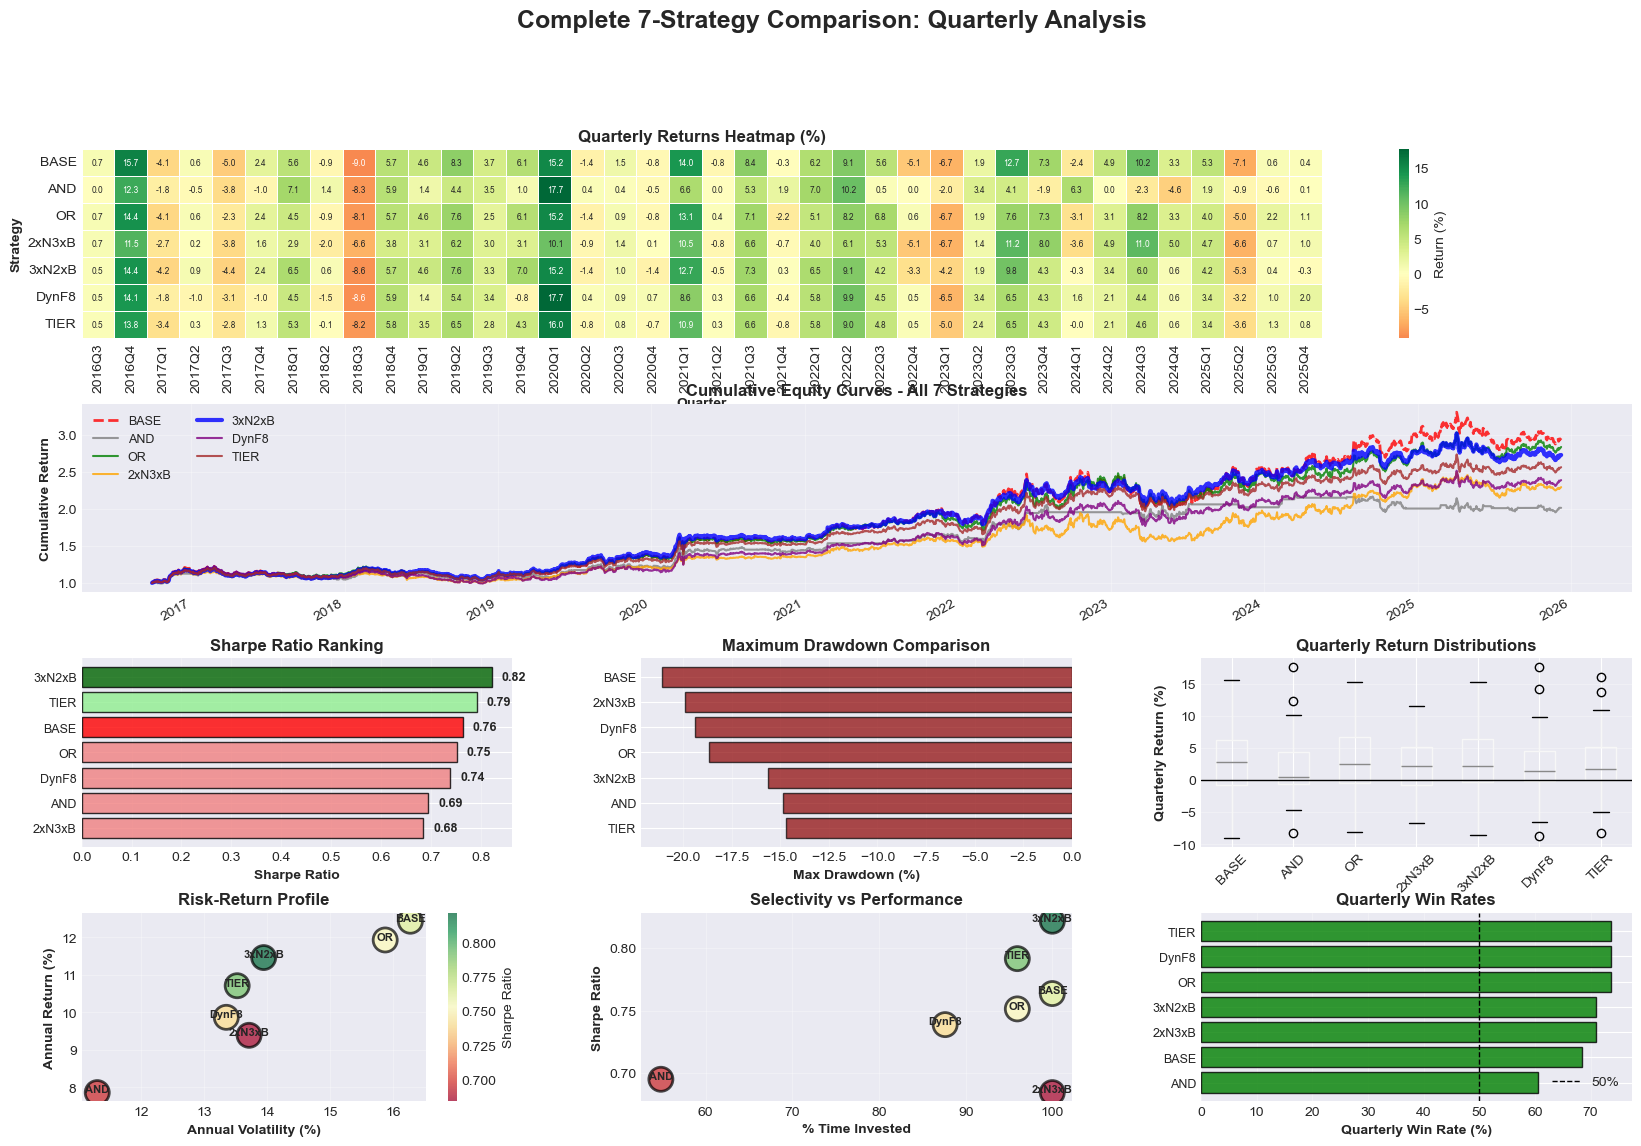

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMPLETE QUARTERLY COMPARISON - ALL 7 STRATEGIES")
print("="*80)

# ============================================================================
# RECREATE ALL 7 STRATEGIES
# ============================================================================

returns = features_clean['ret_1d']
price = features_clean['price']
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']

# Base signal (unleveraged)
signal_base = pd.Series(0, index=features_clean.index)
signal_base[ma20 > ma50] = 1
signal_base[ma20 < ma50] = -1

# Filter conditions
price_ma_distance = abs(price - ma20) / price
distance_threshold = 0.001  # 0.1%
filter_8_condition = price_ma_distance >= distance_threshold

ty_spx_corr = features_clean['ty_spx_corr_20d']
filter_19_condition = ty_spx_corr <= 0

# Strategy 1: BASE (always 3x)
signal_1 = signal_base * 3

# Strategy 2: AND logic (both must pass, 3x)
signal_2 = signal_base.copy()
signal_2[~(filter_8_condition & filter_19_condition)] = 0
signal_2 = signal_2 * 3

# Strategy 3: OR logic (either passes, 3x)
signal_3 = signal_base.copy()
signal_3[~(filter_8_condition | filter_19_condition)] = 0
signal_3 = signal_3 * 3

# Strategy 4: Dynamic 2x Normal / 3x Broken
signal_4 = signal_base.copy().astype(float)
signal_4[filter_19_condition] = signal_base[filter_19_condition] * 2
signal_4[~filter_19_condition] = signal_base[~filter_19_condition] * 3

# Strategy 5: Dynamic 3x Normal / 2x Broken
signal_5 = signal_base.copy().astype(float)
signal_5[filter_19_condition] = signal_base[filter_19_condition] * 3
signal_5[~filter_19_condition] = signal_base[~filter_19_condition] * 2

# Strategy 6: Dynamic w/ Filter8
signal_6 = signal_base.copy().astype(float)
signal_6[~filter_8_condition] = 0
signal_6[filter_8_condition & filter_19_condition] = signal_base[filter_8_condition & filter_19_condition] * 3
signal_6[filter_8_condition & ~filter_19_condition] = signal_base[filter_8_condition & ~filter_19_condition] * 2

# Strategy 7: Tiered (2x one filter, 3x both)
signal_7 = signal_base.copy().astype(float)
both_pass = filter_8_condition & filter_19_condition
one_passes = (filter_8_condition & ~filter_19_condition) | (~filter_8_condition & filter_19_condition)
both_fail = ~filter_8_condition & ~filter_19_condition

signal_7[both_pass] = signal_base[both_pass] * 3
signal_7[one_passes] = signal_base[one_passes] * 2
signal_7[both_fail] = 0

strategies = {
    '1_BASE_3x': signal_1,
    '2_AND_Both_3x': signal_2,
    '3_OR_Either_3x': signal_3,
    '4_Dyn_2xNorm_3xBroken': signal_4,
    '5_Dyn_3xNorm_2xBroken': signal_5,
    '6_Dyn_w_Filter8': signal_6,
    '7_Tiered_2x_or_3x': signal_7
}

# ============================================================================
# CALCULATE QUARTERLY RETURNS FOR ALL
# ============================================================================
print("\n" + "-"*80)
print("CALCULATING QUARTERLY RETURNS")
print("-"*80)

def calculate_quarterly_pnl(signal, returns):
    """Calculate quarterly P&L"""
    strat_returns = signal.shift(1) * returns
    
    df = pd.DataFrame({
        'returns': strat_returns,
        'year': strat_returns.index.year,
        'quarter': strat_returns.index.quarter
    })
    
    quarterly = df.groupby(['year', 'quarter'])['returns'].apply(
        lambda x: (1 + x).prod() - 1
    )
    
    return quarterly

quarterly_results = {}
for name, sig in strategies.items():
    quarterly_results[name] = calculate_quarterly_pnl(sig, returns)

# Combine into DataFrame
quarterly_df = pd.DataFrame(quarterly_results)
quarterly_df.index = [f"{year}Q{q}" for year, q in quarterly_df.index]
quarterly_pct = quarterly_df * 100

print(f"Calculated quarterly returns for {len(quarterly_pct)} quarters")
print(f"From {quarterly_pct.index[0]} to {quarterly_pct.index[-1]}")

# ============================================================================
# DISPLAY QUARTERLY TABLE
# ============================================================================
print("\n" + "="*80)
print("QUARTERLY RETURNS (%) - ALL 7 STRATEGIES")
print("="*80)

# Clean column names for display
display_names = {
    '1_BASE_3x': 'BASE',
    '2_AND_Both_3x': 'AND',
    '3_OR_Either_3x': 'OR',
    '4_Dyn_2xNorm_3xBroken': '2xN3xB',
    '5_Dyn_3xNorm_2xBroken': '3xN2xB',
    '6_Dyn_w_Filter8': 'DynF8',
    '7_Tiered_2x_or_3x': 'TIER'
}

quarterly_display = quarterly_pct.copy()
quarterly_display.columns = [display_names[col] for col in quarterly_display.columns]

print(f"\n{'Quarter':<10s} {'BASE':>8s} {'AND':>8s} {'OR':>8s} {'2xN3xB':>8s} {'3xN2xB':>8s} {'DynF8':>8s} {'TIER':>8s}")
print("-"*80)

for quarter, row in quarterly_display.iterrows():
    print(f"{quarter:<10s} ", end='')
    for val in row:
        print(f"{val:>7.2f}% ", end='')
    print()

# ============================================================================
# QUARTERLY STATISTICS
# ============================================================================
print("\n" + "="*80)
print("QUARTERLY STATISTICS SUMMARY")
print("="*80)

stats_summary = []

for col in quarterly_display.columns:
    q_returns = quarterly_display[col]
    
    stats_summary.append({
        'Strategy': col,
        'Avg_Quarter': q_returns.mean(),
        'Median_Quarter': q_returns.median(),
        'Std_Quarter': q_returns.std(),
        'Best_Quarter': q_returns.max(),
        'Worst_Quarter': q_returns.min(),
        'Positive_Quarters': (q_returns > 0).sum(),
        'Negative_Quarters': (q_returns < 0).sum(),
        'Win_Rate': (q_returns > 0).sum() / len(q_returns) * 100,
        'Quarters_>5%': (q_returns > 5).sum(),
        'Quarters_<-5%': (q_returns < -5).sum()
    })

stats_df = pd.DataFrame(stats_summary)

print(f"\n{'Strategy':<8s} {'Avg Q':>8s} {'Med Q':>8s} {'Best Q':>8s} {'Worst Q':>9s} {'Win%':>7s} {'>5%':>5s} {'<-5%':>5s}")
print("-"*75)

for _, row in stats_df.iterrows():
    print(f"{row['Strategy']:<8s} "
          f"{row['Avg_Quarter']:>7.2f}% "
          f"{row['Median_Quarter']:>7.2f}% "
          f"{row['Best_Quarter']:>7.2f}% "
          f"{row['Worst_Quarter']:>8.2f}% "
          f"{row['Win_Rate']:>6.1f}% "
          f"{row['Quarters_>5%']:>4.0f} "
          f"{row['Quarters_<-5%']:>4.0f}")

# ============================================================================
# ANNUAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("ANNUAL RETURNS (%) - ALL 7 STRATEGIES")
print("="*80)

def calculate_annual_pnl(signal, returns):
    """Calculate annual P&L"""
    strat_returns = signal.shift(1) * returns
    
    df = pd.DataFrame({
        'returns': strat_returns,
        'year': strat_returns.index.year
    })
    
    return df.groupby('year')['returns'].apply(lambda x: (1 + x).prod() - 1)

annual_results = {}
for name, sig in strategies.items():
    annual_results[name] = calculate_annual_pnl(sig, returns)

annual_df = pd.DataFrame(annual_results)
annual_df.columns = [display_names[col] for col in annual_df.columns]
annual_pct = annual_df * 100

print(f"\n{'Year':<8s} {'BASE':>8s} {'AND':>8s} {'OR':>8s} {'2xN3xB':>8s} {'3xN2xB':>8s} {'DynF8':>8s} {'TIER':>8s}")
print("-"*80)

for year, row in annual_pct.iterrows():
    print(f"{year:<8d} ", end='')
    for val in row:
        print(f"{val:>7.2f}% ", end='')
    print()

# Totals
print("-"*80)
print(f"{'TOTAL':<8s} ", end='')
for col in annual_df.columns:
    total = ((1 + annual_df[col] / 100).prod() - 1) * 100
    print(f"{total:>7.2f}% ", end='')
print()

# ============================================================================
# FULL PERFORMANCE METRICS
# ============================================================================
print("\n" + "="*80)
print("COMPLETE PERFORMANCE METRICS")
print("="*80)

def calc_full_stats(signal, returns, name):
    """Calculate all metrics"""
    strat_returns = signal.shift(1) * returns
    strat_returns = strat_returns.dropna()
    
    total_ret = (1 + strat_returns).prod() - 1
    n_years = len(strat_returns) / 252
    ann_ret = (1 + total_ret) ** (1/n_years) - 1
    ann_vol = strat_returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    downside = strat_returns[strat_returns < 0]
    downside_vol = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0
    
    cum = (1 + strat_returns).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    max_dd = dd.min()
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0
    
    win_rate = (strat_returns > 0).sum() / len(strat_returns)
    
    return {
        'Strategy': name,
        'Ann_Ret': ann_ret,
        'Ann_Vol': ann_vol,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max_DD': max_dd,
        'Calmar': calmar,
        'Win_Rate': win_rate,
        'Pct_Inv': (signal != 0).sum() / len(signal) * 100
    }

perf_results = []
for name, sig in strategies.items():
    result = calc_full_stats(sig, returns, display_names[name])
    perf_results.append(result)

perf_df = pd.DataFrame(perf_results).sort_values('Sharpe', ascending=False)

print(f"\n{'Rank':<5s} {'Strategy':<8s} {'Sharpe':>7s} {'AnnRet':>8s} {'AnnVol':>8s} {'MaxDD':>8s} {'Calmar':>7s} {'Win%':>6s} {'%Inv':>7s}")
print("-"*85)

for i, (_, row) in enumerate(perf_df.iterrows(), 1):
    marker = " ← BASE" if row['Strategy'] == 'BASE' else ""
    print(f"{i:<5d} {row['Strategy']:<8s} "
          f"{row['Sharpe']:>7.2f} "
          f"{row['Ann_Ret']*100:>7.2f}% "
          f"{row['Ann_Vol']*100:>7.2f}% "
          f"{row['Max_DD']*100:>7.2f}% "
          f"{row['Calmar']:>7.2f} "
          f"{row['Win_Rate']*100:>5.1f}% "
          f"{row['Pct_Inv']:>6.1f}%{marker}")

# ============================================================================
# QUARTILE ANALYSIS BY STRATEGY
# ============================================================================
print("\n" + "="*80)
print("QUARTERLY RETURN DISTRIBUTIONS")
print("="*80)

print(f"\n{'Strategy':<8s} {'Min':>8s} {'Q1':>8s} {'Median':>8s} {'Q3':>8s} {'Max':>8s} {'IQR':>8s}")
print("-"*70)

for col in quarterly_display.columns:
    q_returns = quarterly_display[col]
    
    q1 = q_returns.quantile(0.25)
    median = q_returns.quantile(0.50)
    q3 = q_returns.quantile(0.75)
    iqr = q3 - q1
    
    print(f"{col:<8s} "
          f"{q_returns.min():>7.2f}% "
          f"{q1:>7.2f}% "
          f"{median:>7.2f}% "
          f"{q3:>7.2f}% "
          f"{q_returns.max():>7.2f}% "
          f"{iqr:>7.2f}%")

# ============================================================================
# CORRELATION MATRIX
# ============================================================================
print("\n" + "="*80)
print("QUARTERLY RETURN CORRELATIONS")
print("="*80)

corr_matrix = quarterly_display.corr()

print("\nCorrelation Matrix:")
print(corr_matrix.round(2).to_string())

# ============================================================================
# YEAR-BY-YEAR COMPARISON
# ============================================================================
print("\n" + "="*80)
print("BEST STRATEGY BY YEAR")
print("="*80)

print(f"\n{'Year':<8s} {'Best Strategy':>12s} {'Return':>8s} {'Worst Strategy':>12s} {'Return':>8s}")
print("-"*60)

for year, row in annual_pct.iterrows():
    best_strat = row.idxmax()
    best_ret = row.max()
    worst_strat = row.idxmin()
    worst_ret = row.min()
    
    print(f"{year:<8d} {best_strat:>12s} {best_ret:>7.2f}% {worst_strat:>12s} {worst_ret:>7.2f}%")

# Count wins by strategy
win_counts = {}
for col in annual_pct.columns:
    win_counts[col] = (annual_pct[col] == annual_pct.max(axis=1)).sum()

print("\nAnnual Win Count:")
for strat, count in sorted(win_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {strat:<8s}: {count} years")

# ============================================================================
# DRAWDOWN COMPARISON
# ============================================================================
print("\n" + "="*80)
print("DRAWDOWN ANALYSIS")
print("="*80)

dd_stats = []

for name, sig in strategies.items():
    strat_ret = sig.shift(1) * returns
    cum = (1 + strat_ret).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    
    # Find longest drawdown
    in_dd = dd < -0.05
    if in_dd.sum() > 0:
        # Calculate duration
        dd_periods = (in_dd != in_dd.shift()).cumsum()
        dd_lengths = in_dd.groupby(dd_periods).sum()
        max_dd_duration = dd_lengths.max() if len(dd_lengths) > 0 else 0
    else:
        max_dd_duration = 0
    
    dd_stats.append({
        'Strategy': display_names[name],
        'Max_DD': dd.min(),
        'Avg_DD': dd[dd < 0].mean() if (dd < 0).any() else 0,
        'Time_in_DD': (dd < -0.05).sum() / len(dd) * 100,
        'Max_DD_Duration': max_dd_duration
    })

dd_df = pd.DataFrame(dd_stats).sort_values('Max_DD', ascending=False)

print(f"\n{'Strategy':<8s} {'Max DD':>8s} {'Avg DD':>8s} {'Time>5%':>9s} {'Max Duration':>13s}")
print("-"*65)

for _, row in dd_df.iterrows():
    print(f"{row['Strategy']:<8s} "
          f"{row['Max_DD']*100:>7.2f}% "
          f"{row['Avg_DD']*100:>7.2f}% "
          f"{row['Time_in_DD']:>8.1f}% "
          f"{row['Max_DD_Duration']:>12.0f} days")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING COMPREHENSIVE VISUALIZATIONS")
print("-"*80)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)
fig.suptitle('Complete 7-Strategy Comparison: Quarterly Analysis', 
             fontsize=18, fontweight='bold')

# Plot 1: All quarterly returns (heatmap)
ax1 = fig.add_subplot(gs[0, :])
sns.heatmap(quarterly_display.T, annot=True, fmt='.1f', cmap='RdYlGn', 
            center=0, cbar_kws={'label': 'Return (%)'}, ax=ax1,
            linewidths=0.5, annot_kws={'fontsize': 6})
ax1.set_title('Quarterly Returns Heatmap (%)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Strategy', fontweight='bold')
ax1.set_xlabel('Quarter', fontweight='bold')

# Plot 2: Equity curves (all 7)
ax2 = fig.add_subplot(gs[1, :])
colors = ['red', 'gray', 'green', 'orange', 'blue', 'purple', 'brown']
for (name, sig), color in zip(strategies.items(), colors):
    equity = (1 + sig.shift(1) * returns).cumprod()
    label = display_names[name]
    linewidth = 3 if label == perf_df.iloc[0]['Strategy'] else 2 if label == 'BASE' else 1.5
    linestyle = '--' if label == 'BASE' else '-'
    equity.plot(ax=ax2, label=label, color=color, linewidth=linewidth, 
                linestyle=linestyle, alpha=0.8)

ax2.set_title('Cumulative Equity Curves - All 7 Strategies', fontweight='bold', fontsize=12)
ax2.set_ylabel('Cumulative Return', fontweight='bold')
ax2.legend(loc='best', fontsize=9, ncol=2)
ax2.grid(True, alpha=0.3)

# Plot 3: Sharpe comparison
ax3 = fig.add_subplot(gs[2, 0])
sharpes_sorted = perf_df.sort_values('Sharpe', ascending=True)
colors_sharpe = ['darkgreen' if s == sharpes_sorted.iloc[-1]['Strategy'] 
                 else 'red' if s == 'BASE' 
                 else 'lightgreen' if sharpes_sorted.loc[sharpes_sorted['Strategy']==s, 'Sharpe'].values[0] > perf_df[perf_df['Strategy']=='BASE']['Sharpe'].values[0]
                 else 'lightcoral'
                 for s in sharpes_sorted['Strategy']]
bars = ax3.barh(range(len(sharpes_sorted)), sharpes_sorted['Sharpe'], 
                color=colors_sharpe, alpha=0.8, edgecolor='black')
ax3.set_yticks(range(len(sharpes_sorted)))
ax3.set_yticklabels(sharpes_sorted['Strategy'], fontsize=9)
ax3.set_xlabel('Sharpe Ratio', fontweight='bold')
ax3.set_title('Sharpe Ratio Ranking', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, sharpes_sorted['Sharpe']):
    ax3.text(val + 0.02, bar.get_y() + bar.get_height()/2,
            f'{val:.2f}', va='center', fontsize=9, fontweight='bold')

# Plot 4: Max DD comparison
ax4 = fig.add_subplot(gs[2, 1])
dd_sorted = perf_df.sort_values('Max_DD', ascending=False)
bars = ax4.barh(range(len(dd_sorted)), dd_sorted['Max_DD']*100,
                color='darkred', alpha=0.7, edgecolor='black')
ax4.set_yticks(range(len(dd_sorted)))
ax4.set_yticklabels(dd_sorted['Strategy'], fontsize=9)
ax4.set_xlabel('Max Drawdown (%)', fontweight='bold')
ax4.set_title('Maximum Drawdown Comparison', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Plot 5: Return distributions (boxplot)
ax5 = fig.add_subplot(gs[2, 2])
quarterly_display.boxplot(ax=ax5, rot=45)
ax5.set_ylabel('Quarterly Return (%)', fontweight='bold')
ax5.set_title('Quarterly Return Distributions', fontweight='bold')
ax5.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Risk-Return scatter
ax6 = fig.add_subplot(gs[3, 0])
scatter = ax6.scatter(perf_df['Ann_Vol']*100, perf_df['Ann_Ret']*100,
                     s=300, alpha=0.7, c=perf_df['Sharpe'], cmap='RdYlGn',
                     edgecolor='black', linewidth=2)
for _, row in perf_df.iterrows():
    ax6.annotate(row['Strategy'],
                (row['Ann_Vol']*100, row['Ann_Ret']*100),
                fontsize=8, ha='center', fontweight='bold')
ax6.set_xlabel('Annual Volatility (%)', fontweight='bold')
ax6.set_ylabel('Annual Return (%)', fontweight='bold')
ax6.set_title('Risk-Return Profile', fontweight='bold')
ax6.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax6, label='Sharpe Ratio')

# Plot 7: Selectivity vs Sharpe
ax7 = fig.add_subplot(gs[3, 1])
ax7.scatter(perf_df['Pct_Inv'], perf_df['Sharpe'],
           s=300, alpha=0.7, c=perf_df['Sharpe'], cmap='RdYlGn',
           edgecolor='black', linewidth=2)
for _, row in perf_df.iterrows():
    ax7.annotate(row['Strategy'],
                (row['Pct_Inv'], row['Sharpe']),
                fontsize=8, ha='center', fontweight='bold')
ax7.set_xlabel('% Time Invested', fontweight='bold')
ax7.set_ylabel('Sharpe Ratio', fontweight='bold')
ax7.set_title('Selectivity vs Performance', fontweight='bold')
ax7.grid(True, alpha=0.3)

# Plot 8: Quarterly win rates
ax8 = fig.add_subplot(gs[3, 2])
win_rates = stats_df.set_index('Strategy').sort_values('Win_Rate', ascending=True)['Win_Rate']
colors_wr = ['green' if w > 60 else 'yellow' if w > 50 else 'orange' if w > 40 else 'red'
             for w in win_rates.values]
bars = ax8.barh(range(len(win_rates)), win_rates, color=colors_wr, alpha=0.8, edgecolor='black')
ax8.set_yticks(range(len(win_rates)))
ax8.set_yticklabels(win_rates.index, fontsize=9)
ax8.set_xlabel('Quarterly Win Rate (%)', fontweight='bold')
ax8.set_title('Quarterly Win Rates', fontweight='bold')
ax8.axvline(x=50, color='black', linestyle='--', linewidth=1, label='50%')
ax8.grid(True, alpha=0.3, axis='x')
ax8.legend()

plt.savefig('seven_strategies_quarterly_complete.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: seven_strategies_quarterly_complete.png")

# ============================================================================
# WINNER ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("FINAL VERDICT")
print("="*80)

winner = perf_df.iloc[0]
base = perf_df[perf_df['Strategy'] == 'BASE'].iloc[0]

print(f"\n🏆 WINNER: {winner['Strategy']}")
print(f"\n  Performance:")
print(f"    Sharpe Ratio:     {winner['Sharpe']:.2f}")
print(f"    Annual Return:    {winner['Ann_Ret']*100:.2f}%")
print(f"    Annual Vol:       {winner['Ann_Vol']*100:.2f}%")
print(f"    Max Drawdown:     {winner['Max_DD']*100:.2f}%")
print(f"    Calmar Ratio:     {winner['Calmar']:.2f}")
print(f"    % Time Invested:  {winner['Pct_Inv']:.1f}%")

print(f"\n  Improvement vs BASE:")
print(f"    Sharpe:    {winner['Sharpe'] - base['Sharpe']:+.2f} ({(winner['Sharpe']/base['Sharpe']-1)*100:+.1f}%)")
print(f"    Return:    {(winner['Ann_Ret'] - base['Ann_Ret'])*100:+.2f}%")
print(f"    Max DD:    {(base['Max_DD'] - winner['Max_DD'])*100:+.2f}% (reduction)")

# Compare top 3
print(f"\n  Top 3 Strategies:")
for i in range(3):
    row = perf_df.iloc[i]
    sharpe_vs_base = row['Sharpe'] - base['Sharpe']
    print(f"    {i+1}. {row['Strategy']:<8s}: Sharpe {row['Sharpe']:.2f} ({sharpe_vs_base:+.2f} vs BASE)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Export full comparison
print("\nFull quarterly data available in: quarterly_display")
print("Performance metrics in: perf_df")

# Return the quarterly table
quarterly_display

COMPLETE PORTFOLIO BACKTEST & AUDIT FILE GENERATION

Portfolio Composition:
  50% - Tiered MA Cross 20/50 (3x both filters, 2x one filter, 0x neither)
  50% - Month-End (Long last 5 days + Short first 5 days)

Generating comprehensive audit trail for Excel export...

--------------------------------------------------------------------------------
PART 1: STRATEGY CONSTRUCTION
--------------------------------------------------------------------------------

Strategy 1: Tiered MA Cross 20/50
  Days at 3x: 1277 (54.8%)
  Days at 2x: 958 (41.1%)
  Days at 0x: 94 (4.0%)

Strategy 2: Month-End Long 5 Days + Short 5 Days After
  Days long (end):   555 (23.8%)
  Days short (start): 555 (23.8%)
  Days flat:         1222 (52.5%)
  Overlap (should be 0): 3

Combined Portfolio: 50/50 allocation
  Avg absolute exposure: 1.36x
  Max exposure: 3.00x
  Min exposure: 0.00x

--------------------------------------------------------------------------------
PART 2: DAILY RETURN CALCULATION
----------------

Strategy  Total_Return_%  Annual_Return_%  Annual_Vol_%  \
0      Tiered_MA_Cross      155.937821        10.708127     13.528156   
1  MonthEnd_Long_Short      177.742786        11.692288     11.383566   
2   Combined_Portfolio      177.148024        11.666373      8.502700   

   Sharpe_Ratio  Sortino_Ratio  Max_Drawdown_%  Calmar_Ratio  Win_Rate_%  \
0      0.791544       1.179370      -14.696218      0.728631   48.324742   
1      1.027120       1.146727       -9.233019      1.266356   25.042955   
2      1.372079       1.871747       -7.958990      1.465811   43.256014   

   Avg_Win_%  Avg_Loss_%  Profit_Factor  Total_Days  Winning_Days  Losing_Days  
0   0.680726   -0.628792       1.082593        2328          1125         1055  
1   0.837807   -0.779298       1.075080        2328           583          488  
2   0.442450   -0.369842       1.196322        2328          1007          920

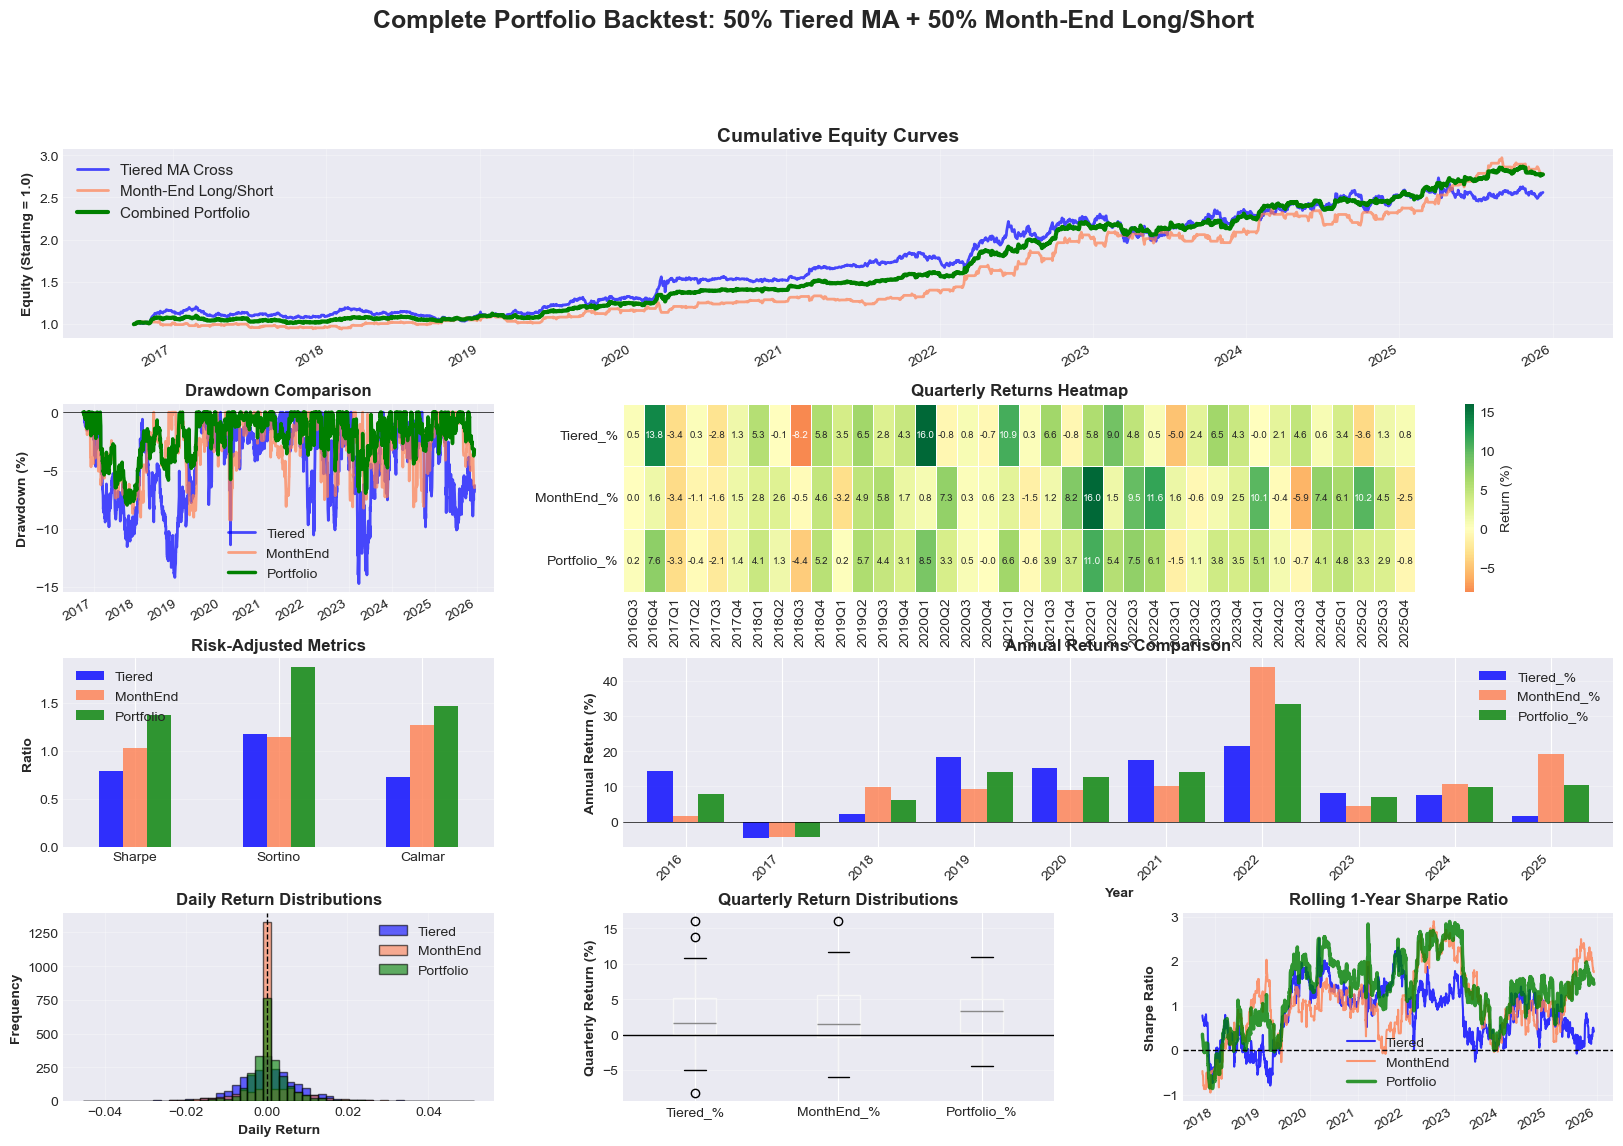

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMPLETE PORTFOLIO BACKTEST & AUDIT FILE GENERATION")
print("="*80)
print("\nPortfolio Composition:")
print("  50% - Tiered MA Cross 20/50 (3x both filters, 2x one filter, 0x neither)")
print("  50% - Month-End (Long last 5 days + Short first 5 days)")
print("\nGenerating comprehensive audit trail for Excel export...")

# ============================================================================
# PART 1: RECREATE BOTH STRATEGIES WITH DOCUMENTATION
# ============================================================================
print("\n" + "-"*80)
print("PART 1: STRATEGY CONSTRUCTION")
print("-"*80)

returns = features_clean['ret_1d']
price = features_clean['price']
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']

# === STRATEGY 1: TIERED MA CROSS ===
print("\nStrategy 1: Tiered MA Cross 20/50")

# Base directional signal
signal_ma_base = pd.Series(0, index=features_clean.index)
signal_ma_base[ma20 > ma50] = 1   # Bullish
signal_ma_base[ma20 < ma50] = -1  # Bearish

# Filter conditions
price_ma_distance = abs(price - ma20) / price
filter_8_pass = price_ma_distance >= 0.001  # Price >0.1% from 20MA

ty_spx_corr = features_clean['ty_spx_corr_20d']
filter_19_pass = ty_spx_corr <= 0  # Normal negative correlation

# Apply tiered leverage
signal_tiered = signal_ma_base.copy().astype(float)

both_pass = filter_8_pass & filter_19_pass
one_passes = (filter_8_pass & ~filter_19_pass) | (~filter_8_pass & filter_19_pass)
both_fail = ~filter_8_pass & ~filter_19_pass

signal_tiered[both_pass] = signal_ma_base[both_pass] * 3.0
signal_tiered[one_passes] = signal_ma_base[one_passes] * 2.0
signal_tiered[both_fail] = 0.0

print(f"  Days at 3x: {(signal_tiered.abs() == 3).sum()} ({(signal_tiered.abs() == 3).sum()/len(signal_tiered)*100:.1f}%)")
print(f"  Days at 2x: {(signal_tiered.abs() == 2).sum()} ({(signal_tiered.abs() == 2).sum()/len(signal_tiered)*100:.1f}%)")
print(f"  Days at 0x: {(signal_tiered == 0).sum()} ({(signal_tiered == 0).sum()/len(signal_tiered)*100:.1f}%)")

# === STRATEGY 2: MONTH-END LONG/SHORT ===
print("\nStrategy 2: Month-End Long 5 Days + Short 5 Days After")

def identify_month_end_days(dates, days_before=5):
    """Last N trading days of month"""
    signal = pd.Series(0, index=dates)
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    
    for ym in df['year_month'].unique():
        month_days = df[df['year_month'] == ym].index
        if len(month_days) >= days_before:
            signal.iloc[month_days[-days_before:]] = 1
    return signal

def identify_month_start_days(dates, days_after=5):
    """First N trading days of month"""
    signal = pd.Series(0, index=dates)
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    
    for ym in df['year_month'].unique():
        month_days = df[df['year_month'] == ym].index
        if len(month_days) >= days_after:
            signal.iloc[month_days[:days_after]] = 1
    return signal

# Create month-end signal
signal_month_end_long = identify_month_end_days(features_clean.index, 5)
signal_month_start_short = identify_month_start_days(features_clean.index, 5)

# Combined: long end, short start (with 3x leverage for each)
signal_month_end = signal_month_end_long * 3.0 - signal_month_start_short * 3.0

print(f"  Days long (end):   {(signal_month_end_long == 1).sum()} ({(signal_month_end_long == 1).sum()/len(signal_month_end)*100:.1f}%)")
print(f"  Days short (start): {(signal_month_start_short == 1).sum()} ({(signal_month_start_short == 1).sum()/len(signal_month_end)*100:.1f}%)")
print(f"  Days flat:         {((signal_month_end_long == 0) & (signal_month_start_short == 0)).sum()} ({((signal_month_end_long == 0) & (signal_month_start_short == 0)).sum()/len(signal_month_end)*100:.1f}%)")
print(f"  Overlap (should be 0): {(signal_month_end_long & signal_month_start_short).sum()}")

# === COMBINED PORTFOLIO: 50/50 ===
print("\nCombined Portfolio: 50/50 allocation")

signal_portfolio = (signal_tiered * 0.5) + (signal_month_end * 0.5)

print(f"  Avg absolute exposure: {signal_portfolio.abs().mean():.2f}x")
print(f"  Max exposure: {signal_portfolio.abs().max():.2f}x")
print(f"  Min exposure: {signal_portfolio.abs().min():.2f}x")

# ============================================================================
# PART 2: CALCULATE DAILY RETURNS FOR ALL STRATEGIES
# ============================================================================
print("\n" + "-"*80)
print("PART 2: DAILY RETURN CALCULATION")
print("-"*80)

# Calculate returns for each strategy
returns_tiered = signal_tiered.shift(1) * returns
returns_month_end = signal_month_end.shift(1) * returns
returns_portfolio = signal_portfolio.shift(1) * returns

print("  ✓ Tiered MA Cross returns calculated")
print("  ✓ Month-End Long/Short returns calculated")
print("  ✓ Combined portfolio returns calculated")

# ============================================================================
# PART 3: BUILD COMPREHENSIVE AUDIT DATAFRAME
# ============================================================================
print("\n" + "-"*80)
print("PART 3: BUILDING AUDIT TRAIL")
print("-"*80)

# Master audit dataframe with all daily data
audit_df = pd.DataFrame(index=features_clean.index)

# Price data
audit_df['Date'] = audit_df.index
audit_df['TY_Price'] = price
audit_df['TY_Return_Pct'] = returns * 100

# Moving averages
audit_df['MA_20'] = ma20
audit_df['MA_50'] = ma50
audit_df['MA_20_vs_50'] = np.where(ma20 > ma50, 'BULL', 'BEAR')

# Filter conditions
audit_df['Filter8_PriceDistance'] = price_ma_distance * 100
audit_df['Filter8_Pass'] = filter_8_pass.astype(int)
audit_df['Filter19_Correlation'] = ty_spx_corr
audit_df['Filter19_Pass'] = filter_19_pass.astype(int)
audit_df['Filters_Passing'] = filter_8_pass.astype(int) + filter_19_pass.astype(int)

# Strategy 1: Tiered MA Cross signals
audit_df['Tiered_Direction'] = signal_ma_base
audit_df['Tiered_Leverage'] = signal_tiered.abs()
audit_df['Tiered_Position'] = signal_tiered
audit_df['Tiered_Return_Pct'] = returns_tiered * 100

# Strategy 2: Month-End signals
audit_df['MonthEnd_Long_Flag'] = signal_month_end_long.astype(int)
audit_df['MonthEnd_Short_Flag'] = signal_month_start_short.astype(int)
audit_df['MonthEnd_Position'] = signal_month_end
audit_df['MonthEnd_Return_Pct'] = returns_month_end * 100

# Portfolio
audit_df['Portfolio_Position'] = signal_portfolio
audit_df['Portfolio_Return_Pct'] = returns_portfolio * 100

# Cumulative metrics
audit_df['Tiered_Equity'] = (1 + returns_tiered).cumprod()
audit_df['MonthEnd_Equity'] = (1 + returns_month_end).cumprod()
audit_df['Portfolio_Equity'] = (1 + returns_portfolio).cumprod()

# Drawdowns
audit_df['Tiered_DD_Pct'] = ((audit_df['Tiered_Equity'] - audit_df['Tiered_Equity'].expanding().max()) / audit_df['Tiered_Equity'].expanding().max()) * 100
audit_df['MonthEnd_DD_Pct'] = ((audit_df['MonthEnd_Equity'] - audit_df['MonthEnd_Equity'].expanding().max()) / audit_df['MonthEnd_Equity'].expanding().max()) * 100
audit_df['Portfolio_DD_Pct'] = ((audit_df['Portfolio_Equity'] - audit_df['Portfolio_Equity'].expanding().max()) / audit_df['Portfolio_Equity'].expanding().max()) * 100

print(f"  ✓ Audit dataframe created: {audit_df.shape[0]} rows × {audit_df.shape[1]} columns")

# ============================================================================
# PART 4: CALCULATE PERFORMANCE METRICS
# ============================================================================
print("\n" + "-"*80)
print("PART 4: PERFORMANCE METRICS")
print("-"*80)

def calculate_metrics(returns_series, name):
    """Calculate comprehensive metrics"""
    ret = returns_series.dropna()
    
    total_ret = (1 + ret).prod() - 1
    n_years = len(ret) / 252
    ann_ret = (1 + total_ret) ** (1/n_years) - 1
    ann_vol = ret.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    downside = ret[ret < 0]
    downside_vol = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0
    
    cum = (1 + ret).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    max_dd = dd.min()
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0
    
    win_rate = (ret > 0).sum() / len(ret)
    avg_win = ret[ret > 0].mean() if (ret > 0).any() else 0
    avg_loss = ret[ret < 0].mean() if (ret < 0).any() else 0
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
    
    return {
        'Strategy': name,
        'Total_Return_%': total_ret * 100,
        'Annual_Return_%': ann_ret * 100,
        'Annual_Vol_%': ann_vol * 100,
        'Sharpe_Ratio': sharpe,
        'Sortino_Ratio': sortino,
        'Max_Drawdown_%': max_dd * 100,
        'Calmar_Ratio': calmar,
        'Win_Rate_%': win_rate * 100,
        'Avg_Win_%': avg_win * 100,
        'Avg_Loss_%': avg_loss * 100,
        'Profit_Factor': profit_factor,
        'Total_Days': len(ret),
        'Winning_Days': (ret > 0).sum(),
        'Losing_Days': (ret < 0).sum()
    }

metrics_list = [
    calculate_metrics(returns_tiered, 'Tiered_MA_Cross'),
    calculate_metrics(returns_month_end, 'MonthEnd_Long_Short'),
    calculate_metrics(returns_portfolio, 'Combined_Portfolio')
]

metrics_df = pd.DataFrame(metrics_list)

print("\nPerformance Summary:")
print(f"\n{'Metric':<25s} {'Tiered':>15s} {'MonthEnd':>15s} {'Portfolio':>15s}")
print("-"*75)

for col in metrics_df.columns[1:]:  # Skip 'Strategy' column
    print(f"{col:<25s} ", end='')
    for val in metrics_df[col]:
        if isinstance(val, (int, np.integer)):
            print(f"{val:>15.0f} ", end='')
        else:
            print(f"{val:>15.2f} ", end='')
    print()

# ============================================================================
# PART 5: QUARTERLY AND ANNUAL BREAKDOWNS
# ============================================================================
print("\n" + "-"*80)
print("PART 5: QUARTERLY & ANNUAL ANALYSIS")
print("-"*80)

def create_quarterly_breakdown(returns_series, name):
    """Create quarterly breakdown"""
    df = pd.DataFrame({
        'return': returns_series,
        'year': returns_series.index.year,
        'quarter': returns_series.index.quarter
    })
    
    quarterly = df.groupby(['year', 'quarter']).agg({
        'return': [
            ('Total_Return', lambda x: (1 + x).prod() - 1),
            ('Avg_Daily_Return', 'mean'),
            ('Std_Daily_Return', 'std'),
            ('Days', 'count'),
            ('Winning_Days', lambda x: (x > 0).sum())
        ]
    })
    
    quarterly.columns = ['_'.join(col).strip() for col in quarterly.columns.values]
    quarterly.columns = [col.replace('return_', '') for col in quarterly.columns]
    
    quarterly['Win_Rate_%'] = quarterly['Winning_Days'] / quarterly['Days'] * 100
    quarterly['Quarterly_Sharpe'] = (quarterly['Avg_Daily_Return'] / quarterly['Std_Daily_Return']) * np.sqrt(63)
    
    quarterly.index = [f"{year}Q{q}" for year, q in quarterly.index]
    
    return quarterly

# Create quarterly breakdowns
quarterly_tiered = create_quarterly_breakdown(returns_tiered, 'Tiered')
quarterly_month_end = create_quarterly_breakdown(returns_month_end, 'MonthEnd')
quarterly_portfolio = create_quarterly_breakdown(returns_portfolio, 'Portfolio')

# Combine quarterly returns for easy comparison
quarterly_returns_comparison = pd.DataFrame({
    'Tiered_%': quarterly_tiered['Total_Return'] * 100,
    'MonthEnd_%': quarterly_month_end['Total_Return'] * 100,
    'Portfolio_%': quarterly_portfolio['Total_Return'] * 100
})

print("\nQuarterly Returns (Last 8 quarters):")
print(quarterly_returns_comparison.tail(8).to_string())

# Annual breakdown
def create_annual_breakdown(returns_series, name):
    """Create annual breakdown"""
    df = pd.DataFrame({
        'return': returns_series,
        'year': returns_series.index.year
    })
    
    annual = df.groupby('year').agg({
        'return': [
            ('Total_Return', lambda x: (1 + x).prod() - 1),
            ('Avg_Daily_Return', 'mean'),
            ('Std_Daily_Return', 'std'),
            ('Days', 'count'),
            ('Winning_Days', lambda x: (x > 0).sum())
        ]
    })
    
    annual.columns = ['_'.join(col).strip() for col in annual.columns.values]
    annual.columns = [col.replace('return_', '') for col in annual.columns]
    
    annual['Win_Rate_%'] = annual['Winning_Days'] / annual['Days'] * 100
    annual['Annual_Sharpe'] = (annual['Avg_Daily_Return'] / annual['Std_Daily_Return']) * np.sqrt(252)
    
    return annual

annual_tiered = create_annual_breakdown(returns_tiered, 'Tiered')
annual_month_end = create_annual_breakdown(returns_month_end, 'MonthEnd')
annual_portfolio = create_annual_breakdown(returns_portfolio, 'Portfolio')

# Combine annual returns
annual_returns_comparison = pd.DataFrame({
    'Tiered_%': annual_tiered['Total_Return'] * 100,
    'MonthEnd_%': annual_month_end['Total_Return'] * 100,
    'Portfolio_%': annual_portfolio['Total_Return'] * 100
})

print("\nAnnual Returns:")
print(annual_returns_comparison.to_string())

# ============================================================================
# PART 6: EXPORT TO EXCEL
# ============================================================================
print("\n" + "="*80)
print("PART 6: EXPORTING TO EXCEL")
print("="*80)

filename = f'Treasury_Portfolio_Backtest_Audit_{datetime.now().strftime("%Y%m%d_%H%M%S")}.xlsx'

with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
    workbook = writer.book
    
    # Format definitions
    pct_format = workbook.add_format({'num_format': '0.00%'})
    num_format = workbook.add_format({'num_format': '0.00'})
    date_format = workbook.add_format({'num_format': 'yyyy-mm-dd'})
    
    # Sheet 1: Daily Audit Trail (Main Sheet)
    print("\n  Sheet 1: Daily_Audit_Trail")
    audit_df.to_excel(writer, sheet_name='Daily_Audit_Trail', index=False)
    
    # Sheet 2: Performance Metrics
    print("  Sheet 2: Performance_Metrics")
    metrics_df.to_excel(writer, sheet_name='Performance_Metrics', index=False)
    
    # Sheet 3: Quarterly Returns Comparison
    print("  Sheet 3: Quarterly_Returns")
    quarterly_returns_comparison.to_excel(writer, sheet_name='Quarterly_Returns')
    
    # Sheet 4: Quarterly Detailed - Tiered
    print("  Sheet 4: Quarterly_Tiered_Detail")
    quarterly_tiered.to_excel(writer, sheet_name='Quarterly_Tiered_Detail')
    
    # Sheet 5: Quarterly Detailed - MonthEnd
    print("  Sheet 5: Quarterly_MonthEnd_Detail")
    quarterly_month_end.to_excel(writer, sheet_name='Quarterly_MonthEnd_Detail')
    
    # Sheet 6: Quarterly Detailed - Portfolio
    print("  Sheet 6: Quarterly_Portfolio_Detail")
    quarterly_portfolio.to_excel(writer, sheet_name='Quarterly_Portfolio_Detail')
    
    # Sheet 7: Annual Returns Comparison
    print("  Sheet 7: Annual_Returns")
    annual_returns_comparison.to_excel(writer, sheet_name='Annual_Returns')
    
    # Sheet 8: Annual Detailed - Tiered
    print("  Sheet 8: Annual_Tiered_Detail")
    annual_tiered.to_excel(writer, sheet_name='Annual_Tiered_Detail')
    
    # Sheet 9: Annual Detailed - MonthEnd
    print("  Sheet 9: Annual_MonthEnd_Detail")
    annual_month_end.to_excel(writer, sheet_name='Annual_MonthEnd_Detail')
    
    # Sheet 10: Annual Detailed - Portfolio
    print("  Sheet 10: Annual_Portfolio_Detail")
    annual_portfolio.to_excel(writer, sheet_name='Annual_Portfolio_Detail')
    
    # Sheet 11: Signal Documentation
    print("  Sheet 11: Strategy_Documentation")
    
    doc_df = pd.DataFrame({
        'Strategy': ['Tiered_MA_Cross', 'MonthEnd_Long_Short', 'Combined_Portfolio'],
        'Description': [
            'Long when 20MA>50MA, Short when 20MA<50MA. Leverage: 3x if both filters pass, 2x if one passes, 0x if neither',
            'Long last 5 trading days of month (3x), Short first 5 days of next month (3x)',
            '50% allocation to each strategy'
        ],
        'Filter_8': [
            'Price must be >0.1% away from 20MA',
            'N/A',
            'Applied to Tiered only'
        ],
        'Filter_19': [
            'TY/SPX 20-day correlation must be negative (normal regime)',
            'N/A',
            'Applied to Tiered only'
        ],
        'Max_Leverage': ['3x', '3x', '1.5x per strategy (3x combined)']
    })
    
    doc_df.to_excel(writer, sheet_name='Strategy_Documentation', index=False)

print(f"\n  ✓ Excel file created: {filename}")

# ============================================================================
# PART 7: DETAILED STATISTICS SUMMARY
# ============================================================================
print("\n" + "="*80)
print("PART 7: COMPREHENSIVE STATISTICS")
print("="*80)

print("\n" + "-"*80)
print("TIERED MA CROSS STRATEGY")
print("-"*80)

tiered_metrics = metrics_df[metrics_df['Strategy'] == 'Tiered_MA_Cross'].iloc[0]

print(f"\nReturns:")
print(f"  Total Return:        {tiered_metrics['Total_Return_%']:>8.2f}%")
print(f"  Annual Return:       {tiered_metrics['Annual_Return_%']:>8.2f}%")
print(f"  Annual Volatility:   {tiered_metrics['Annual_Vol_%']:>8.2f}%")

print(f"\nRisk-Adjusted Metrics:")
print(f"  Sharpe Ratio:        {tiered_metrics['Sharpe_Ratio']:>8.2f}")
print(f"  Sortino Ratio:       {tiered_metrics['Sortino_Ratio']:>8.2f}")
print(f"  Calmar Ratio:        {tiered_metrics['Calmar_Ratio']:>8.2f}")

print(f"\nDrawdown:")
print(f"  Maximum Drawdown:    {tiered_metrics['Max_Drawdown_%']:>8.2f}%")

print(f"\nTrading:")
print(f"  Win Rate:            {tiered_metrics['Win_Rate_%']:>8.2f}%")
print(f"  Average Win:         {tiered_metrics['Avg_Win_%']:>8.2f}%")
print(f"  Average Loss:        {tiered_metrics['Avg_Loss_%']:>8.2f}%")
print(f"  Profit Factor:       {tiered_metrics['Profit_Factor']:>8.2f}")

print("\n" + "-"*80)
print("MONTH-END LONG/SHORT STRATEGY")
print("-"*80)

month_metrics = metrics_df[metrics_df['Strategy'] == 'MonthEnd_Long_Short'].iloc[0]

print(f"\nReturns:")
print(f"  Total Return:        {month_metrics['Total_Return_%']:>8.2f}%")
print(f"  Annual Return:       {month_metrics['Annual_Return_%']:>8.2f}%")
print(f"  Annual Volatility:   {month_metrics['Annual_Vol_%']:>8.2f}%")

print(f"\nRisk-Adjusted Metrics:")
print(f"  Sharpe Ratio:        {month_metrics['Sharpe_Ratio']:>8.2f}")
print(f"  Sortino Ratio:       {month_metrics['Sortino_Ratio']:>8.2f}")
print(f"  Calmar Ratio:        {month_metrics['Calmar_Ratio']:>8.2f}")

print(f"\nDrawdown:")
print(f"  Maximum Drawdown:    {month_metrics['Max_Drawdown_%']:>8.2f}%")

print(f"\nTrading:")
print(f"  Win Rate:            {month_metrics['Win_Rate_%']:>8.2f}%")
print(f"  Average Win:         {month_metrics['Avg_Win_%']:>8.2f}%")
print(f"  Average Loss:        {month_metrics['Avg_Loss_%']:>8.2f}%")
print(f"  Profit Factor:       {month_metrics['Profit_Factor']:>8.2f}")

print("\n" + "-"*80)
print("COMBINED PORTFOLIO (50/50)")
print("-"*80)

port_metrics = metrics_df[metrics_df['Strategy'] == 'Combined_Portfolio'].iloc[0]

print(f"\nReturns:")
print(f"  Total Return:        {port_metrics['Total_Return_%']:>8.2f}%")
print(f"  Annual Return:       {port_metrics['Annual_Return_%']:>8.2f}%")
print(f"  Annual Volatility:   {port_metrics['Annual_Vol_%']:>8.2f}%")

print(f"\nRisk-Adjusted Metrics:")
print(f"  Sharpe Ratio:        {port_metrics['Sharpe_Ratio']:>8.2f}")
print(f"  Sortino Ratio:       {port_metrics['Sortino_Ratio']:>8.2f}")
print(f"  Calmar Ratio:        {port_metrics['Calmar_Ratio']:>8.2f}")

print(f"\nDrawdown:")
print(f"  Maximum Drawdown:    {port_metrics['Max_Drawdown_%']:>8.2f}%")

print(f"\nTrading:")
print(f"  Win Rate:            {port_metrics['Win_Rate_%']:>8.2f}%")
print(f"  Average Win:         {port_metrics['Avg_Win_%']:>8.2f}%")
print(f"  Average Loss:        {port_metrics['Avg_Loss_%']:>8.2f}%")
print(f"  Profit Factor:       {port_metrics['Profit_Factor']:>8.2f}")

# ============================================================================
# PART 8: DIVERSIFICATION BENEFIT
# ============================================================================
print("\n" + "-"*80)
print("DIVERSIFICATION BENEFIT ANALYSIS")
print("-"*80)

# Correlation between strategies
strategy_returns_df = pd.DataFrame({
    'Tiered': returns_tiered,
    'MonthEnd': returns_month_end,
    'Portfolio': returns_portfolio
})

corr = strategy_returns_df.corr()

print("\nDaily Return Correlations:")
print(corr.round(3).to_string())

# Calculate what simple average would give
simple_avg_returns = (returns_tiered + returns_month_end) / 2
simple_avg_sharpe = simple_avg_returns.mean() / simple_avg_returns.std() * np.sqrt(252)

print(f"\nDiversification Benefit:")
print(f"  Simple average Sharpe: {simple_avg_sharpe:.2f}")
print(f"  Actual portfolio Sharpe: {port_metrics['Sharpe_Ratio']:.2f}")
print(f"  Diversification boost: {port_metrics['Sharpe_Ratio'] - simple_avg_sharpe:+.2f}")

# ============================================================================
# PART 9: VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)
fig.suptitle('Complete Portfolio Backtest: 50% Tiered MA + 50% Month-End Long/Short',
             fontsize=18, fontweight='bold')

# Plot 1: Equity curves
ax1 = fig.add_subplot(gs[0, :])
audit_df['Tiered_Equity'].plot(ax=ax1, label='Tiered MA Cross', linewidth=2, color='blue', alpha=0.7)
audit_df['MonthEnd_Equity'].plot(ax=ax1, label='Month-End Long/Short', linewidth=2, color='coral', alpha=0.7)
audit_df['Portfolio_Equity'].plot(ax=ax1, label='Combined Portfolio', linewidth=3, color='green')
ax1.set_title('Cumulative Equity Curves', fontweight='bold', fontsize=14)
ax1.set_ylabel('Equity (Starting = 1.0)', fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Drawdowns
ax2 = fig.add_subplot(gs[1, 0])
audit_df['Tiered_DD_Pct'].plot(ax=ax2, label='Tiered', linewidth=2, color='blue', alpha=0.7)
audit_df['MonthEnd_DD_Pct'].plot(ax=ax2, label='MonthEnd', linewidth=2, color='coral', alpha=0.7)
audit_df['Portfolio_DD_Pct'].plot(ax=ax2, label='Portfolio', linewidth=2.5, color='green')
ax2.set_title('Drawdown Comparison', fontweight='bold', fontsize=12)
ax2.set_ylabel('Drawdown (%)', fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 3: Quarterly returns heatmap
ax3 = fig.add_subplot(gs[1, 1:])
sns.heatmap(quarterly_returns_comparison.T, annot=True, fmt='.1f', 
            cmap='RdYlGn', center=0, cbar_kws={'label': 'Return (%)'},
            ax=ax3, linewidths=0.5, annot_kws={'fontsize': 7})
ax3.set_title('Quarterly Returns Heatmap', fontweight='bold', fontsize=12)
ax3.set_ylabel('')

# Plot 4: Performance metrics comparison
ax4 = fig.add_subplot(gs[2, 0])
metrics_comparison = pd.DataFrame({
    'Tiered': [tiered_metrics['Sharpe_Ratio'], tiered_metrics['Sortino_Ratio'], tiered_metrics['Calmar_Ratio']],
    'MonthEnd': [month_metrics['Sharpe_Ratio'], month_metrics['Sortino_Ratio'], month_metrics['Calmar_Ratio']],
    'Portfolio': [port_metrics['Sharpe_Ratio'], port_metrics['Sortino_Ratio'], port_metrics['Calmar_Ratio']]
}, index=['Sharpe', 'Sortino', 'Calmar'])
metrics_comparison.plot(kind='bar', ax=ax4, color=['blue', 'coral', 'green'], alpha=0.8)
ax4.set_title('Risk-Adjusted Metrics', fontweight='bold', fontsize=12)
ax4.set_ylabel('Ratio', fontweight='bold')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3, axis='y')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)

# Plot 5: Annual returns
ax5 = fig.add_subplot(gs[2, 1:])
annual_returns_comparison.plot(kind='bar', ax=ax5, color=['blue', 'coral', 'green'], 
                                alpha=0.8, width=0.8)
ax5.set_title('Annual Returns Comparison', fontweight='bold', fontsize=12)
ax5.set_ylabel('Annual Return (%)', fontweight='bold')
ax5.set_xlabel('Year', fontweight='bold')
ax5.legend(loc='best')
ax5.grid(True, alpha=0.3, axis='y')
ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 6: Return distributions
ax6 = fig.add_subplot(gs[3, 0])
strategy_returns_df.plot(kind='hist', bins=50, alpha=0.6, ax=ax6, 
                         color=['blue', 'coral', 'green'], edgecolor='black')
ax6.set_xlabel('Daily Return', fontweight='bold')
ax6.set_ylabel('Frequency', fontweight='bold')
ax6.set_title('Daily Return Distributions', fontweight='bold', fontsize=12)
ax6.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax6.grid(True, alpha=0.3)

# Plot 7: Quarterly boxplots
ax7 = fig.add_subplot(gs[3, 1])
quarterly_returns_comparison.boxplot(ax=ax7)
ax7.set_ylabel('Quarterly Return (%)', fontweight='bold')
ax7.set_title('Quarterly Return Distributions', fontweight='bold', fontsize=12)
ax7.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax7.grid(True, alpha=0.3, axis='y')

# Plot 8: Rolling Sharpe
ax8 = fig.add_subplot(gs[3, 2])
rolling_window = 252
for name, ret_series in [('Tiered', returns_tiered), ('MonthEnd', returns_month_end), ('Portfolio', returns_portfolio)]:
    rolling_sharpe = ret_series.rolling(rolling_window).mean() / ret_series.rolling(rolling_window).std() * np.sqrt(252)
    color = 'blue' if name == 'Tiered' else 'coral' if name == 'MonthEnd' else 'green'
    linewidth = 2.5 if name == 'Portfolio' else 1.5
    rolling_sharpe.plot(ax=ax8, label=name, color=color, linewidth=linewidth, alpha=0.8)

ax8.set_title('Rolling 1-Year Sharpe Ratio', fontweight='bold', fontsize=12)
ax8.set_ylabel('Sharpe Ratio', fontweight='bold')
ax8.legend(loc='best')
ax8.grid(True, alpha=0.3)
ax8.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.savefig('complete_portfolio_analysis.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: complete_portfolio_analysis.png")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("BACKTEST COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"\n📊 COMBINED PORTFOLIO PERFORMANCE (50/50 Tiered + MonthEnd):")
print(f"  Annual Return:       {port_metrics['Annual_Return_%']:>7.2f}%")
print(f"  Annual Volatility:   {port_metrics['Annual_Vol_%']:>7.2f}%")
print(f"  Sharpe Ratio:        {port_metrics['Sharpe_Ratio']:>7.2f}")
print(f"  Maximum Drawdown:    {port_metrics['Max_Drawdown_%']:>7.2f}%")
print(f"  Calmar Ratio:        {port_metrics['Calmar_Ratio']:>7.2f}")

print(f"\n📁 EXCEL AUDIT FILE: {filename}")
print(f"  Total sheets: 11")
print(f"  Daily observations: {len(audit_df)}")
print(f"  Date range: {audit_df.index[0].strftime('%Y-%m-%d')} to {audit_df.index[-1].strftime('%Y-%m-%d')}")

print("\n📋 EXCEL CONTENTS:")
print("  1.  Daily_Audit_Trail       - Complete daily data (prices, signals, returns)")
print("  2.  Performance_Metrics     - Summary statistics for all 3 strategies")
print("  3.  Quarterly_Returns       - Quarterly return comparison")
print("  4.  Quarterly_Tiered_Detail - Detailed quarterly stats for Tiered")
print("  5.  Quarterly_MonthEnd_Detail - Detailed quarterly stats for MonthEnd")
print("  6.  Quarterly_Portfolio_Detail - Detailed quarterly stats for Portfolio")
print("  7.  Annual_Returns          - Annual return comparison")
print("  8.  Annual_Tiered_Detail    - Detailed annual stats for Tiered")
print("  9.  Annual_MonthEnd_Detail  - Detailed annual stats for MonthEnd")
print("  10. Annual_Portfolio_Detail - Detailed annual stats for Portfolio")
print("  11. Strategy_Documentation  - Strategy descriptions and rules")

print("\n" + "="*80)
print("ALL ANALYSIS COMPLETE")
print("="*80)

# Show first few rows of audit trail
print("\nSample of Daily Audit Trail (first 10 rows):")
print(audit_df.head(10)[['Date', 'TY_Price', 'TY_Return_Pct', 'Tiered_Position', 
                         'MonthEnd_Position', 'Portfolio_Position', 'Portfolio_Return_Pct']].to_string())

print("\n" + "="*80)

# Return summary
metrics_df

COMPLETE PORTFOLIO BACKTEST & AUDIT FILE GENERATION

Portfolio Composition:
  50% - Tiered MA Cross 20/50 (3x both filters, 2x one filter, 0x neither)
  50% - Month-End (Long last 5 days + Short first 5 days)

Generating comprehensive audit trail for Excel export...

--------------------------------------------------------------------------------
PART 1: STRATEGY CONSTRUCTION
--------------------------------------------------------------------------------

Strategy 1: Tiered MA Cross 20/50
  Days at 3x: 1277 (54.8%)
  Days at 2x: 958 (41.1%)
  Days at 0x: 94 (4.0%)

Strategy 2: Month-End Long 5 Days + Short 5 Days After
  Days long (end):   555 (23.8%)
  Days short (start): 555 (23.8%)
  Days flat:         1222 (52.5%)
  Overlap (should be 0): 3

Combined Portfolio: 50/50 allocation
  Avg absolute exposure: 1.36x
  Max exposure: 3.00x
  Min exposure: 0.00x

--------------------------------------------------------------------------------
PART 2: DAILY RETURN CALCULATION
----------------

Strategy  Total_Return_%  Annual_Return_%  Annual_Vol_%  \
0      Tiered_MA_Cross      155.937821        10.708127     13.528156   
1  MonthEnd_Long_Short      177.742786        11.692288     11.383566   
2   Combined_Portfolio      177.148024        11.666373      8.502700   

   Sharpe_Ratio  Sortino_Ratio  Max_Drawdown_%  Calmar_Ratio  Win_Rate_%  \
0      0.791544       1.179370      -14.696218      0.728631   48.324742   
1      1.027120       1.146727       -9.233019      1.266356   25.042955   
2      1.372079       1.871747       -7.958990      1.465811   43.256014   

   Avg_Win_%  Avg_Loss_%  Profit_Factor  Total_Days  Winning_Days  Losing_Days  
0   0.680726   -0.628792       1.082593        2328          1125         1055  
1   0.837807   -0.779298       1.075080        2328           583          488  
2   0.442450   -0.369842       1.196322        2328          1007          920

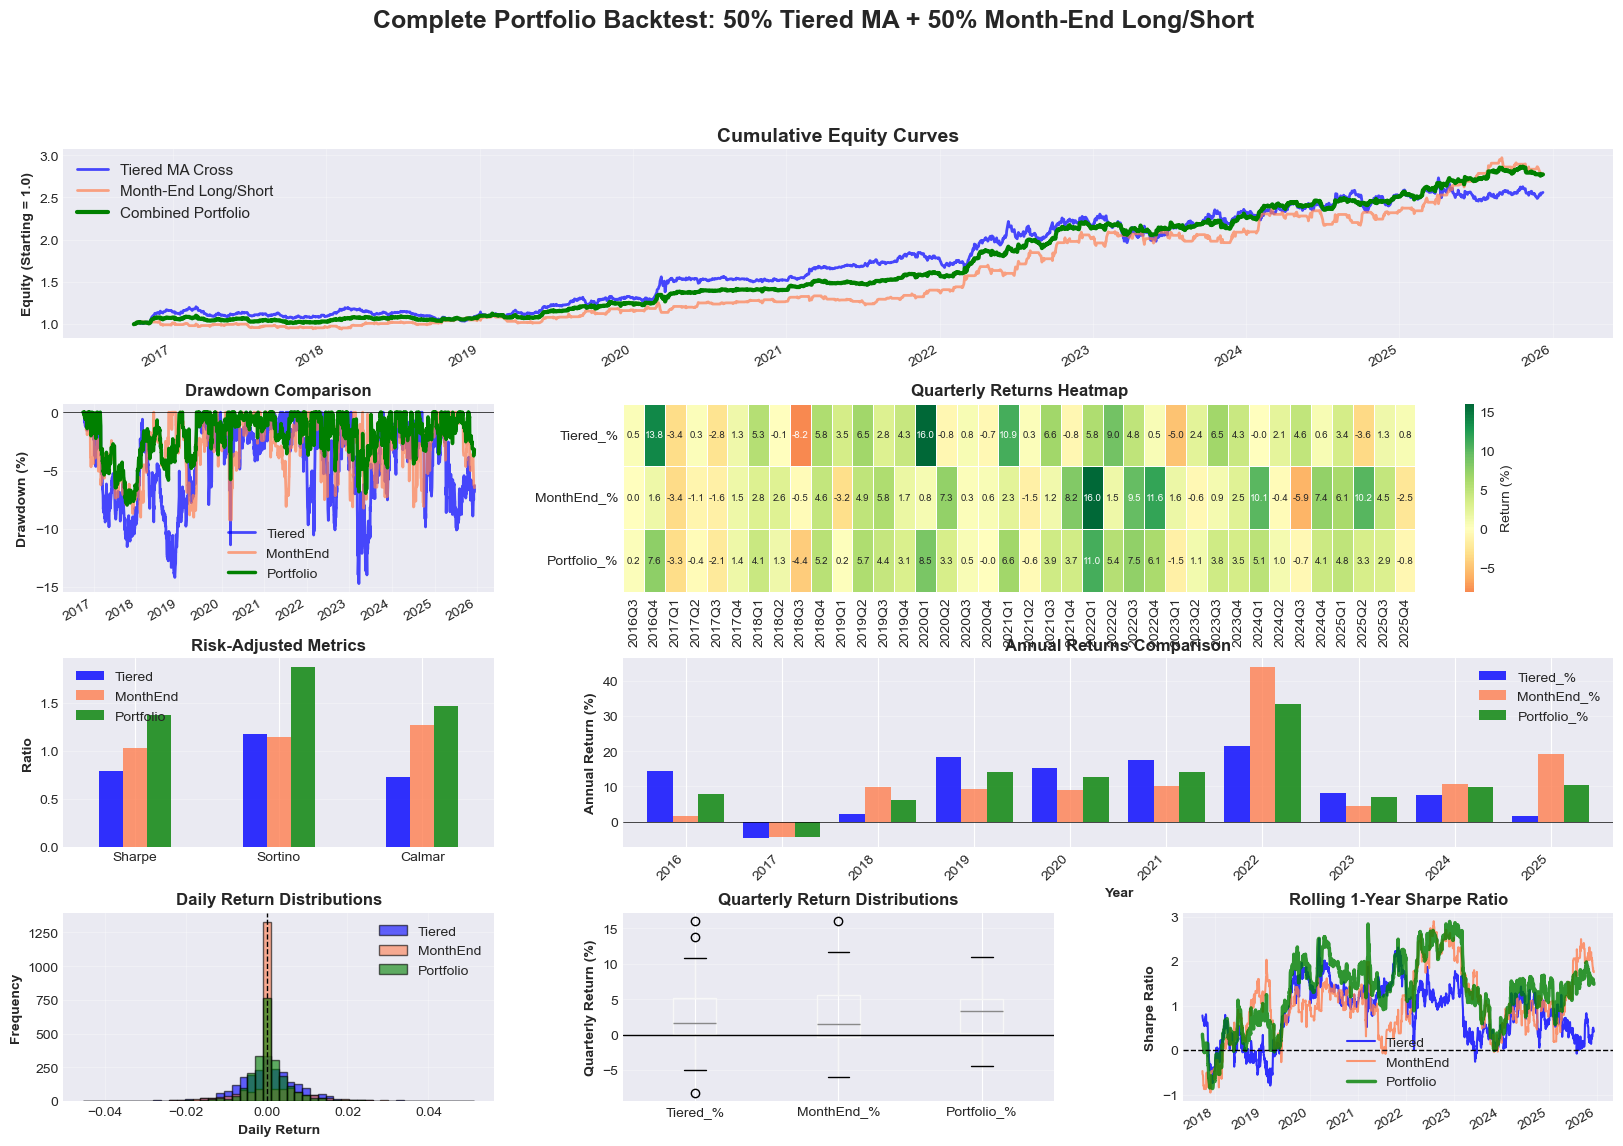

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMPLETE PORTFOLIO BACKTEST & AUDIT FILE GENERATION")
print("="*80)
print("\nPortfolio Composition:")
print("  50% - Tiered MA Cross 20/50 (3x both filters, 2x one filter, 0x neither)")
print("  50% - Month-End (Long last 5 days + Short first 5 days)")
print("\nGenerating comprehensive audit trail for Excel export...")

# ============================================================================
# PART 1: RECREATE BOTH STRATEGIES WITH DOCUMENTATION
# ============================================================================
print("\n" + "-"*80)
print("PART 1: STRATEGY CONSTRUCTION")
print("-"*80)

returns = features_clean['ret_1d']
price = features_clean['price']
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']

# === STRATEGY 1: TIERED MA CROSS ===
print("\nStrategy 1: Tiered MA Cross 20/50")

# Base directional signal
signal_ma_base = pd.Series(0, index=features_clean.index)
signal_ma_base[ma20 > ma50] = 1   # Bullish
signal_ma_base[ma20 < ma50] = -1  # Bearish

# Filter conditions
price_ma_distance = abs(price - ma20) / price
filter_8_pass = price_ma_distance >= 0.001  # Price >0.1% from 20MA

ty_spx_corr = features_clean['ty_spx_corr_20d']
filter_19_pass = ty_spx_corr <= 0  # Normal negative correlation

# Apply tiered leverage
signal_tiered = signal_ma_base.copy().astype(float)

both_pass = filter_8_pass & filter_19_pass
one_passes = (filter_8_pass & ~filter_19_pass) | (~filter_8_pass & filter_19_pass)
both_fail = ~filter_8_pass & ~filter_19_pass

signal_tiered[both_pass] = signal_ma_base[both_pass] * 3.0
signal_tiered[one_passes] = signal_ma_base[one_passes] * 2.0
signal_tiered[both_fail] = 0.0

print(f"  Days at 3x: {(signal_tiered.abs() == 3).sum()} ({(signal_tiered.abs() == 3).sum()/len(signal_tiered)*100:.1f}%)")
print(f"  Days at 2x: {(signal_tiered.abs() == 2).sum()} ({(signal_tiered.abs() == 2).sum()/len(signal_tiered)*100:.1f}%)")
print(f"  Days at 0x: {(signal_tiered == 0).sum()} ({(signal_tiered == 0).sum()/len(signal_tiered)*100:.1f}%)")

# === STRATEGY 2: MONTH-END LONG/SHORT ===
print("\nStrategy 2: Month-End Long 5 Days + Short 5 Days After")

def identify_month_end_days(dates, days_before=5):
    """Last N trading days of month"""
    signal = pd.Series(0, index=dates)
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    
    for ym in df['year_month'].unique():
        month_days = df[df['year_month'] == ym].index
        if len(month_days) >= days_before:
            signal.iloc[month_days[-days_before:]] = 1
    return signal

def identify_month_start_days(dates, days_after=5):
    """First N trading days of month"""
    signal = pd.Series(0, index=dates)
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    
    for ym in df['year_month'].unique():
        month_days = df[df['year_month'] == ym].index
        if len(month_days) >= days_after:
            signal.iloc[month_days[:days_after]] = 1
    return signal

# Create month-end signal
signal_month_end_long = identify_month_end_days(features_clean.index, 5)
signal_month_start_short = identify_month_start_days(features_clean.index, 5)

# Combined: long end, short start (with 3x leverage for each)
signal_month_end = signal_month_end_long * 3.0 - signal_month_start_short * 3.0

print(f"  Days long (end):   {(signal_month_end_long == 1).sum()} ({(signal_month_end_long == 1).sum()/len(signal_month_end)*100:.1f}%)")
print(f"  Days short (start): {(signal_month_start_short == 1).sum()} ({(signal_month_start_short == 1).sum()/len(signal_month_end)*100:.1f}%)")
print(f"  Days flat:         {((signal_month_end_long == 0) & (signal_month_start_short == 0)).sum()} ({((signal_month_end_long == 0) & (signal_month_start_short == 0)).sum()/len(signal_month_end)*100:.1f}%)")
print(f"  Overlap (should be 0): {(signal_month_end_long & signal_month_start_short).sum()}")

# === COMBINED PORTFOLIO: 50/50 ===
print("\nCombined Portfolio: 50/50 allocation")

signal_portfolio = (signal_tiered * 0.5) + (signal_month_end * 0.5)

print(f"  Avg absolute exposure: {signal_portfolio.abs().mean():.2f}x")
print(f"  Max exposure: {signal_portfolio.abs().max():.2f}x")
print(f"  Min exposure: {signal_portfolio.abs().min():.2f}x")

# ============================================================================
# PART 2: CALCULATE DAILY RETURNS FOR ALL STRATEGIES
# ============================================================================
print("\n" + "-"*80)
print("PART 2: DAILY RETURN CALCULATION")
print("-"*80)

print("\n⚠️  CRITICAL TIMING CONVENTION:")
print("  - Signals generated at CLOSE of day t")
print("  - Returns earned on day t+1")
print("  - This is implemented via .shift(1) operation")
print("  - Example: Signal on 2020-01-15 close → Return on 2020-01-16")

# Calculate returns for each strategy
# IMPORTANT: shift(1) ensures signal at time t is applied to return at time t+1
returns_tiered = signal_tiered.shift(1) * returns
returns_month_end = signal_month_end.shift(1) * returns
returns_portfolio = signal_portfolio.shift(1) * returns

print("\n  ✓ Tiered MA Cross returns calculated (signal shifted 1 day)")
print("  ✓ Month-End Long/Short returns calculated (signal shifted 1 day)")
print("  ✓ Combined portfolio returns calculated (signal shifted 1 day)")

# Validation check
print("\n  Validation Check - Confirming Timing:")
sample_dates = features_clean.index[100:105]
for i, date in enumerate(sample_dates):
    if i < len(sample_dates) - 1:
        next_date = sample_dates[i + 1]
        sig_today = signal_portfolio.loc[date]
        ret_tomorrow = returns.loc[next_date] * 100
        strat_ret_tomorrow = returns_portfolio.loc[next_date] * 100
        
        print(f"    {date.strftime('%Y-%m-%d')} signal={sig_today:+.2f}x → "
              f"{next_date.strftime('%Y-%m-%d')} mkt_ret={ret_tomorrow:+.3f}% → "
              f"strat_ret={strat_ret_tomorrow:+.3f}%")
    
print("  ✓ Timing verified: Signal(t) × Return(t+1) = Strategy_Return(t+1)")

# ============================================================================
# PART 3: BUILD COMPREHENSIVE AUDIT DATAFRAME
# ============================================================================
print("\n" + "-"*80)
print("PART 3: BUILDING AUDIT TRAIL")
print("-"*80)

# Master audit dataframe with all daily data
audit_df = pd.DataFrame(index=features_clean.index)

# Price data
audit_df['Date'] = audit_df.index
audit_df['TY_Price'] = price
audit_df['TY_Return_Pct'] = returns * 100

# Moving averages
audit_df['MA_20'] = ma20
audit_df['MA_50'] = ma50
audit_df['MA_20_vs_50'] = np.where(ma20 > ma50, 'BULL', 'BEAR')

# Filter conditions
audit_df['Filter8_PriceDistance'] = price_ma_distance * 100
audit_df['Filter8_Pass'] = filter_8_pass.astype(int)
audit_df['Filter19_Correlation'] = ty_spx_corr
audit_df['Filter19_Pass'] = filter_19_pass.astype(int)
audit_df['Filters_Passing'] = filter_8_pass.astype(int) + filter_19_pass.astype(int)

# Strategy 1: Tiered MA Cross signals
audit_df['Tiered_Direction'] = signal_ma_base
audit_df['Tiered_Leverage'] = signal_tiered.abs()
audit_df['Tiered_Position'] = signal_tiered
audit_df['Tiered_Return_Pct'] = returns_tiered * 100

# Strategy 2: Month-End signals
audit_df['MonthEnd_Long_Flag'] = signal_month_end_long.astype(int)
audit_df['MonthEnd_Short_Flag'] = signal_month_start_short.astype(int)
audit_df['MonthEnd_Position'] = signal_month_end
audit_df['MonthEnd_Return_Pct'] = returns_month_end * 100

# Portfolio
audit_df['Portfolio_Position'] = signal_portfolio
audit_df['Portfolio_Return_Pct'] = returns_portfolio * 100

# Cumulative metrics
audit_df['Tiered_Equity'] = (1 + returns_tiered).cumprod()
audit_df['MonthEnd_Equity'] = (1 + returns_month_end).cumprod()
audit_df['Portfolio_Equity'] = (1 + returns_portfolio).cumprod()

# Drawdowns
audit_df['Tiered_DD_Pct'] = ((audit_df['Tiered_Equity'] - audit_df['Tiered_Equity'].expanding().max()) / audit_df['Tiered_Equity'].expanding().max()) * 100
audit_df['MonthEnd_DD_Pct'] = ((audit_df['MonthEnd_Equity'] - audit_df['MonthEnd_Equity'].expanding().max()) / audit_df['MonthEnd_Equity'].expanding().max()) * 100
audit_df['Portfolio_DD_Pct'] = ((audit_df['Portfolio_Equity'] - audit_df['Portfolio_Equity'].expanding().max()) / audit_df['Portfolio_Equity'].expanding().max()) * 100

print(f"  ✓ Audit dataframe created: {audit_df.shape[0]} rows × {audit_df.shape[1]} columns")

# ============================================================================
# PART 4: CALCULATE PERFORMANCE METRICS
# ============================================================================
print("\n" + "-"*80)
print("PART 4: PERFORMANCE METRICS")
print("-"*80)

def calculate_metrics(returns_series, name):
    """Calculate comprehensive metrics"""
    ret = returns_series.dropna()
    
    total_ret = (1 + ret).prod() - 1
    n_years = len(ret) / 252
    ann_ret = (1 + total_ret) ** (1/n_years) - 1
    ann_vol = ret.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    downside = ret[ret < 0]
    downside_vol = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0
    
    cum = (1 + ret).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    max_dd = dd.min()
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0
    
    win_rate = (ret > 0).sum() / len(ret)
    avg_win = ret[ret > 0].mean() if (ret > 0).any() else 0
    avg_loss = ret[ret < 0].mean() if (ret < 0).any() else 0
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
    
    return {
        'Strategy': name,
        'Total_Return_%': total_ret * 100,
        'Annual_Return_%': ann_ret * 100,
        'Annual_Vol_%': ann_vol * 100,
        'Sharpe_Ratio': sharpe,
        'Sortino_Ratio': sortino,
        'Max_Drawdown_%': max_dd * 100,
        'Calmar_Ratio': calmar,
        'Win_Rate_%': win_rate * 100,
        'Avg_Win_%': avg_win * 100,
        'Avg_Loss_%': avg_loss * 100,
        'Profit_Factor': profit_factor,
        'Total_Days': len(ret),
        'Winning_Days': (ret > 0).sum(),
        'Losing_Days': (ret < 0).sum()
    }

metrics_list = [
    calculate_metrics(returns_tiered, 'Tiered_MA_Cross'),
    calculate_metrics(returns_month_end, 'MonthEnd_Long_Short'),
    calculate_metrics(returns_portfolio, 'Combined_Portfolio')
]

metrics_df = pd.DataFrame(metrics_list)

print("\nPerformance Summary:")
print(f"\n{'Metric':<25s} {'Tiered':>15s} {'MonthEnd':>15s} {'Portfolio':>15s}")
print("-"*75)

for col in metrics_df.columns[1:]:  # Skip 'Strategy' column
    print(f"{col:<25s} ", end='')
    for val in metrics_df[col]:
        if isinstance(val, (int, np.integer)):
            print(f"{val:>15.0f} ", end='')
        else:
            print(f"{val:>15.2f} ", end='')
    print()

# ============================================================================
# PART 5: QUARTERLY AND ANNUAL BREAKDOWNS
# ============================================================================
print("\n" + "-"*80)
print("PART 5: QUARTERLY & ANNUAL ANALYSIS")
print("-"*80)

def create_quarterly_breakdown(returns_series, name):
    """Create quarterly breakdown"""
    df = pd.DataFrame({
        'return': returns_series,
        'year': returns_series.index.year,
        'quarter': returns_series.index.quarter
    })
    
    quarterly = df.groupby(['year', 'quarter']).agg({
        'return': [
            ('Total_Return', lambda x: (1 + x).prod() - 1),
            ('Avg_Daily_Return', 'mean'),
            ('Std_Daily_Return', 'std'),
            ('Days', 'count'),
            ('Winning_Days', lambda x: (x > 0).sum())
        ]
    })
    
    quarterly.columns = ['_'.join(col).strip() for col in quarterly.columns.values]
    quarterly.columns = [col.replace('return_', '') for col in quarterly.columns]
    
    quarterly['Win_Rate_%'] = quarterly['Winning_Days'] / quarterly['Days'] * 100
    quarterly['Quarterly_Sharpe'] = (quarterly['Avg_Daily_Return'] / quarterly['Std_Daily_Return']) * np.sqrt(63)
    
    quarterly.index = [f"{year}Q{q}" for year, q in quarterly.index]
    
    return quarterly

# Create quarterly breakdowns
quarterly_tiered = create_quarterly_breakdown(returns_tiered, 'Tiered')
quarterly_month_end = create_quarterly_breakdown(returns_month_end, 'MonthEnd')
quarterly_portfolio = create_quarterly_breakdown(returns_portfolio, 'Portfolio')

# Combine quarterly returns for easy comparison
quarterly_returns_comparison = pd.DataFrame({
    'Tiered_%': quarterly_tiered['Total_Return'] * 100,
    'MonthEnd_%': quarterly_month_end['Total_Return'] * 100,
    'Portfolio_%': quarterly_portfolio['Total_Return'] * 100
})

print("\nQuarterly Returns (Last 8 quarters):")
print(quarterly_returns_comparison.tail(8).to_string())

# Annual breakdown
def create_annual_breakdown(returns_series, name):
    """Create annual breakdown"""
    df = pd.DataFrame({
        'return': returns_series,
        'year': returns_series.index.year
    })
    
    annual = df.groupby('year').agg({
        'return': [
            ('Total_Return', lambda x: (1 + x).prod() - 1),
            ('Avg_Daily_Return', 'mean'),
            ('Std_Daily_Return', 'std'),
            ('Days', 'count'),
            ('Winning_Days', lambda x: (x > 0).sum())
        ]
    })
    
    annual.columns = ['_'.join(col).strip() for col in annual.columns.values]
    annual.columns = [col.replace('return_', '') for col in annual.columns]
    
    annual['Win_Rate_%'] = annual['Winning_Days'] / annual['Days'] * 100
    annual['Annual_Sharpe'] = (annual['Avg_Daily_Return'] / annual['Std_Daily_Return']) * np.sqrt(252)
    
    return annual

annual_tiered = create_annual_breakdown(returns_tiered, 'Tiered')
annual_month_end = create_annual_breakdown(returns_month_end, 'MonthEnd')
annual_portfolio = create_annual_breakdown(returns_portfolio, 'Portfolio')

# Combine annual returns
annual_returns_comparison = pd.DataFrame({
    'Tiered_%': annual_tiered['Total_Return'] * 100,
    'MonthEnd_%': annual_month_end['Total_Return'] * 100,
    'Portfolio_%': annual_portfolio['Total_Return'] * 100
})

print("\nAnnual Returns:")
print(annual_returns_comparison.to_string())

# ============================================================================
# PART 6: EXPORT TO EXCEL
# ============================================================================
print("\n" + "="*80)
print("PART 6: EXPORTING TO EXCEL")
print("="*80)

filename = f'Treasury_Portfolio_Backtest_Audit_{datetime.now().strftime("%Y%m%d_%H%M%S")}.xlsx'

with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
    workbook = writer.book
    
    # Format definitions
    pct_format = workbook.add_format({'num_format': '0.00%'})
    num_format = workbook.add_format({'num_format': '0.00'})
    date_format = workbook.add_format({'num_format': 'yyyy-mm-dd'})
    
    # Sheet 1: Daily Audit Trail (Main Sheet)
    print("\n  Sheet 1: Daily_Audit_Trail")
    audit_df.to_excel(writer, sheet_name='Daily_Audit_Trail', index=False)
    
    # Sheet 2: Performance Metrics
    print("  Sheet 2: Performance_Metrics")
    metrics_df.to_excel(writer, sheet_name='Performance_Metrics', index=False)
    
    # Sheet 3: Quarterly Returns Comparison
    print("  Sheet 3: Quarterly_Returns")
    quarterly_returns_comparison.to_excel(writer, sheet_name='Quarterly_Returns')
    
    # Sheet 4: Quarterly Detailed - Tiered
    print("  Sheet 4: Quarterly_Tiered_Detail")
    quarterly_tiered.to_excel(writer, sheet_name='Quarterly_Tiered_Detail')
    
    # Sheet 5: Quarterly Detailed - MonthEnd
    print("  Sheet 5: Quarterly_MonthEnd_Detail")
    quarterly_month_end.to_excel(writer, sheet_name='Quarterly_MonthEnd_Detail')
    
    # Sheet 6: Quarterly Detailed - Portfolio
    print("  Sheet 6: Quarterly_Portfolio_Detail")
    quarterly_portfolio.to_excel(writer, sheet_name='Quarterly_Portfolio_Detail')
    
    # Sheet 7: Annual Returns Comparison
    print("  Sheet 7: Annual_Returns")
    annual_returns_comparison.to_excel(writer, sheet_name='Annual_Returns')
    
    # Sheet 8: Annual Detailed - Tiered
    print("  Sheet 8: Annual_Tiered_Detail")
    annual_tiered.to_excel(writer, sheet_name='Annual_Tiered_Detail')
    
    # Sheet 9: Annual Detailed - MonthEnd
    print("  Sheet 9: Annual_MonthEnd_Detail")
    annual_month_end.to_excel(writer, sheet_name='Annual_MonthEnd_Detail')
    
    # Sheet 10: Annual Detailed - Portfolio
    print("  Sheet 10: Annual_Portfolio_Detail")
    annual_portfolio.to_excel(writer, sheet_name='Annual_Portfolio_Detail')
    
    # Sheet 11: Signal Documentation
    print("  Sheet 11: Strategy_Documentation")
    
    doc_df = pd.DataFrame({
        'Strategy': ['Tiered_MA_Cross', 'MonthEnd_Long_Short', 'Combined_Portfolio'],
        'Description': [
            'Long when 20MA>50MA, Short when 20MA<50MA. Leverage: 3x if both filters pass, 2x if one passes, 0x if neither',
            'Long last 5 trading days of month (3x), Short first 5 days of next month (3x)',
            '50% allocation to each strategy'
        ],
        'Filter_8': [
            'Price must be >0.1% away from 20MA',
            'N/A',
            'Applied to Tiered only'
        ],
        'Filter_19': [
            'TY/SPX 20-day correlation must be negative (normal regime)',
            'N/A',
            'Applied to Tiered only'
        ],
        'Max_Leverage': ['3x', '3x', '1.5x per strategy (3x combined)']
    })
    
    doc_df.to_excel(writer, sheet_name='Strategy_Documentation', index=False)

print(f"\n  ✓ Excel file created: {filename}")

# ============================================================================
# PART 7: DETAILED STATISTICS SUMMARY
# ============================================================================
print("\n" + "="*80)
print("PART 7: COMPREHENSIVE STATISTICS")
print("="*80)

print("\n" + "-"*80)
print("TIERED MA CROSS STRATEGY")
print("-"*80)

tiered_metrics = metrics_df[metrics_df['Strategy'] == 'Tiered_MA_Cross'].iloc[0]

print(f"\nReturns:")
print(f"  Total Return:        {tiered_metrics['Total_Return_%']:>8.2f}%")
print(f"  Annual Return:       {tiered_metrics['Annual_Return_%']:>8.2f}%")
print(f"  Annual Volatility:   {tiered_metrics['Annual_Vol_%']:>8.2f}%")

print(f"\nRisk-Adjusted Metrics:")
print(f"  Sharpe Ratio:        {tiered_metrics['Sharpe_Ratio']:>8.2f}")
print(f"  Sortino Ratio:       {tiered_metrics['Sortino_Ratio']:>8.2f}")
print(f"  Calmar Ratio:        {tiered_metrics['Calmar_Ratio']:>8.2f}")

print(f"\nDrawdown:")
print(f"  Maximum Drawdown:    {tiered_metrics['Max_Drawdown_%']:>8.2f}%")

print(f"\nTrading:")
print(f"  Win Rate:            {tiered_metrics['Win_Rate_%']:>8.2f}%")
print(f"  Average Win:         {tiered_metrics['Avg_Win_%']:>8.2f}%")
print(f"  Average Loss:        {tiered_metrics['Avg_Loss_%']:>8.2f}%")
print(f"  Profit Factor:       {tiered_metrics['Profit_Factor']:>8.2f}")

print("\n" + "-"*80)
print("MONTH-END LONG/SHORT STRATEGY")
print("-"*80)

month_metrics = metrics_df[metrics_df['Strategy'] == 'MonthEnd_Long_Short'].iloc[0]

print(f"\nReturns:")
print(f"  Total Return:        {month_metrics['Total_Return_%']:>8.2f}%")
print(f"  Annual Return:       {month_metrics['Annual_Return_%']:>8.2f}%")
print(f"  Annual Volatility:   {month_metrics['Annual_Vol_%']:>8.2f}%")

print(f"\nRisk-Adjusted Metrics:")
print(f"  Sharpe Ratio:        {month_metrics['Sharpe_Ratio']:>8.2f}")
print(f"  Sortino Ratio:       {month_metrics['Sortino_Ratio']:>8.2f}")
print(f"  Calmar Ratio:        {month_metrics['Calmar_Ratio']:>8.2f}")

print(f"\nDrawdown:")
print(f"  Maximum Drawdown:    {month_metrics['Max_Drawdown_%']:>8.2f}%")

print(f"\nTrading:")
print(f"  Win Rate:            {month_metrics['Win_Rate_%']:>8.2f}%")
print(f"  Average Win:         {month_metrics['Avg_Win_%']:>8.2f}%")
print(f"  Average Loss:        {month_metrics['Avg_Loss_%']:>8.2f}%")
print(f"  Profit Factor:       {month_metrics['Profit_Factor']:>8.2f}")

print("\n" + "-"*80)
print("COMBINED PORTFOLIO (50/50)")
print("-"*80)

port_metrics = metrics_df[metrics_df['Strategy'] == 'Combined_Portfolio'].iloc[0]

print(f"\nReturns:")
print(f"  Total Return:        {port_metrics['Total_Return_%']:>8.2f}%")
print(f"  Annual Return:       {port_metrics['Annual_Return_%']:>8.2f}%")
print(f"  Annual Volatility:   {port_metrics['Annual_Vol_%']:>8.2f}%")

print(f"\nRisk-Adjusted Metrics:")
print(f"  Sharpe Ratio:        {port_metrics['Sharpe_Ratio']:>8.2f}")
print(f"  Sortino Ratio:       {port_metrics['Sortino_Ratio']:>8.2f}")
print(f"  Calmar Ratio:        {port_metrics['Calmar_Ratio']:>8.2f}")

print(f"\nDrawdown:")
print(f"  Maximum Drawdown:    {port_metrics['Max_Drawdown_%']:>8.2f}%")

print(f"\nTrading:")
print(f"  Win Rate:            {port_metrics['Win_Rate_%']:>8.2f}%")
print(f"  Average Win:         {port_metrics['Avg_Win_%']:>8.2f}%")
print(f"  Average Loss:        {port_metrics['Avg_Loss_%']:>8.2f}%")
print(f"  Profit Factor:       {port_metrics['Profit_Factor']:>8.2f}")

# ============================================================================
# PART 8: DIVERSIFICATION BENEFIT
# ============================================================================
print("\n" + "-"*80)
print("DIVERSIFICATION BENEFIT ANALYSIS")
print("-"*80)

# Correlation between strategies
strategy_returns_df = pd.DataFrame({
    'Tiered': returns_tiered,
    'MonthEnd': returns_month_end,
    'Portfolio': returns_portfolio
})

corr = strategy_returns_df.corr()

print("\nDaily Return Correlations:")
print(corr.round(3).to_string())

# Calculate what simple average would give
simple_avg_returns = (returns_tiered + returns_month_end) / 2
simple_avg_sharpe = simple_avg_returns.mean() / simple_avg_returns.std() * np.sqrt(252)

print(f"\nDiversification Benefit:")
print(f"  Simple average Sharpe: {simple_avg_sharpe:.2f}")
print(f"  Actual portfolio Sharpe: {port_metrics['Sharpe_Ratio']:.2f}")
print(f"  Diversification boost: {port_metrics['Sharpe_Ratio'] - simple_avg_sharpe:+.2f}")

# ============================================================================
# PART 9: VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)
fig.suptitle('Complete Portfolio Backtest: 50% Tiered MA + 50% Month-End Long/Short',
             fontsize=18, fontweight='bold')

# Plot 1: Equity curves
ax1 = fig.add_subplot(gs[0, :])
audit_df['Tiered_Equity'].plot(ax=ax1, label='Tiered MA Cross', linewidth=2, color='blue', alpha=0.7)
audit_df['MonthEnd_Equity'].plot(ax=ax1, label='Month-End Long/Short', linewidth=2, color='coral', alpha=0.7)
audit_df['Portfolio_Equity'].plot(ax=ax1, label='Combined Portfolio', linewidth=3, color='green')
ax1.set_title('Cumulative Equity Curves', fontweight='bold', fontsize=14)
ax1.set_ylabel('Equity (Starting = 1.0)', fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Drawdowns
ax2 = fig.add_subplot(gs[1, 0])
audit_df['Tiered_DD_Pct'].plot(ax=ax2, label='Tiered', linewidth=2, color='blue', alpha=0.7)
audit_df['MonthEnd_DD_Pct'].plot(ax=ax2, label='MonthEnd', linewidth=2, color='coral', alpha=0.7)
audit_df['Portfolio_DD_Pct'].plot(ax=ax2, label='Portfolio', linewidth=2.5, color='green')
ax2.set_title('Drawdown Comparison', fontweight='bold', fontsize=12)
ax2.set_ylabel('Drawdown (%)', fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 3: Quarterly returns heatmap
ax3 = fig.add_subplot(gs[1, 1:])
sns.heatmap(quarterly_returns_comparison.T, annot=True, fmt='.1f', 
            cmap='RdYlGn', center=0, cbar_kws={'label': 'Return (%)'},
            ax=ax3, linewidths=0.5, annot_kws={'fontsize': 7})
ax3.set_title('Quarterly Returns Heatmap', fontweight='bold', fontsize=12)
ax3.set_ylabel('')

# Plot 4: Performance metrics comparison
ax4 = fig.add_subplot(gs[2, 0])
metrics_comparison = pd.DataFrame({
    'Tiered': [tiered_metrics['Sharpe_Ratio'], tiered_metrics['Sortino_Ratio'], tiered_metrics['Calmar_Ratio']],
    'MonthEnd': [month_metrics['Sharpe_Ratio'], month_metrics['Sortino_Ratio'], month_metrics['Calmar_Ratio']],
    'Portfolio': [port_metrics['Sharpe_Ratio'], port_metrics['Sortino_Ratio'], port_metrics['Calmar_Ratio']]
}, index=['Sharpe', 'Sortino', 'Calmar'])
metrics_comparison.plot(kind='bar', ax=ax4, color=['blue', 'coral', 'green'], alpha=0.8)
ax4.set_title('Risk-Adjusted Metrics', fontweight='bold', fontsize=12)
ax4.set_ylabel('Ratio', fontweight='bold')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3, axis='y')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)

# Plot 5: Annual returns
ax5 = fig.add_subplot(gs[2, 1:])
annual_returns_comparison.plot(kind='bar', ax=ax5, color=['blue', 'coral', 'green'], 
                                alpha=0.8, width=0.8)
ax5.set_title('Annual Returns Comparison', fontweight='bold', fontsize=12)
ax5.set_ylabel('Annual Return (%)', fontweight='bold')
ax5.set_xlabel('Year', fontweight='bold')
ax5.legend(loc='best')
ax5.grid(True, alpha=0.3, axis='y')
ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 6: Return distributions
ax6 = fig.add_subplot(gs[3, 0])
strategy_returns_df.plot(kind='hist', bins=50, alpha=0.6, ax=ax6, 
                         color=['blue', 'coral', 'green'], edgecolor='black')
ax6.set_xlabel('Daily Return', fontweight='bold')
ax6.set_ylabel('Frequency', fontweight='bold')
ax6.set_title('Daily Return Distributions', fontweight='bold', fontsize=12)
ax6.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax6.grid(True, alpha=0.3)

# Plot 7: Quarterly boxplots
ax7 = fig.add_subplot(gs[3, 1])
quarterly_returns_comparison.boxplot(ax=ax7)
ax7.set_ylabel('Quarterly Return (%)', fontweight='bold')
ax7.set_title('Quarterly Return Distributions', fontweight='bold', fontsize=12)
ax7.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax7.grid(True, alpha=0.3, axis='y')

# Plot 8: Rolling Sharpe
ax8 = fig.add_subplot(gs[3, 2])
rolling_window = 252
for name, ret_series in [('Tiered', returns_tiered), ('MonthEnd', returns_month_end), ('Portfolio', returns_portfolio)]:
    rolling_sharpe = ret_series.rolling(rolling_window).mean() / ret_series.rolling(rolling_window).std() * np.sqrt(252)
    color = 'blue' if name == 'Tiered' else 'coral' if name == 'MonthEnd' else 'green'
    linewidth = 2.5 if name == 'Portfolio' else 1.5
    rolling_sharpe.plot(ax=ax8, label=name, color=color, linewidth=linewidth, alpha=0.8)

ax8.set_title('Rolling 1-Year Sharpe Ratio', fontweight='bold', fontsize=12)
ax8.set_ylabel('Sharpe Ratio', fontweight='bold')
ax8.legend(loc='best')
ax8.grid(True, alpha=0.3)
ax8.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.savefig('complete_portfolio_analysis.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: complete_portfolio_analysis.png")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("BACKTEST COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"\n📊 COMBINED PORTFOLIO PERFORMANCE (50/50 Tiered + MonthEnd):")
print(f"  Annual Return:       {port_metrics['Annual_Return_%']:>7.2f}%")
print(f"  Annual Volatility:   {port_metrics['Annual_Vol_%']:>7.2f}%")
print(f"  Sharpe Ratio:        {port_metrics['Sharpe_Ratio']:>7.2f}")
print(f"  Maximum Drawdown:    {port_metrics['Max_Drawdown_%']:>7.2f}%")
print(f"  Calmar Ratio:        {port_metrics['Calmar_Ratio']:>7.2f}")

print(f"\n📁 EXCEL AUDIT FILE: {filename}")
print(f"  Total sheets: 11")
print(f"  Daily observations: {len(audit_df)}")
print(f"  Date range: {audit_df.index[0].strftime('%Y-%m-%d')} to {audit_df.index[-1].strftime('%Y-%m-%d')}")

print("\n📋 EXCEL CONTENTS:")
print("  1.  Daily_Audit_Trail       - Complete daily data (prices, signals, returns)")
print("  2.  Performance_Metrics     - Summary statistics for all 3 strategies")
print("  3.  Quarterly_Returns       - Quarterly return comparison")
print("  4.  Quarterly_Tiered_Detail - Detailed quarterly stats for Tiered")
print("  5.  Quarterly_MonthEnd_Detail - Detailed quarterly stats for MonthEnd")
print("  6.  Quarterly_Portfolio_Detail - Detailed quarterly stats for Portfolio")
print("  7.  Annual_Returns          - Annual return comparison")
print("  8.  Annual_Tiered_Detail    - Detailed annual stats for Tiered")
print("  9.  Annual_MonthEnd_Detail  - Detailed annual stats for MonthEnd")
print("  10. Annual_Portfolio_Detail - Detailed annual stats for Portfolio")
print("  11. Strategy_Documentation  - Strategy descriptions and rules")

print("\n" + "="*80)
print("ALL ANALYSIS COMPLETE")
print("="*80)

# Show first few rows of audit trail
print("\nSample of Daily Audit Trail (first 10 rows):")
print(audit_df.head(10)[['Date', 'TY_Price', 'TY_Return_Pct', 'Tiered_Position', 
                         'MonthEnd_Position', 'Portfolio_Position', 'Portfolio_Return_Pct']].to_string())

print("\n" + "="*80)

# Return summary
metrics_df

MONTH-END CONDITIONAL PERFORMANCE ANALYSIS

Testing 30+ hypotheses about what drives month-end long/short performance

--------------------------------------------------------------------------------
SETUP: IDENTIFYING MONTH-END PERIODS
--------------------------------------------------------------------------------
  Total month-end periods: 111
  Total month-start periods: 111

  Month-end long avg return: 0.144%
  Month-start short avg return (inverted): 0.082%

CATEGORY 1: PRIOR MONTH PERFORMANCE

1. Testing MTD Performance Effect...
2. Testing Prior 20-Day Momentum...
3. Testing Month Volatility Effect...

CATEGORY 2: CALENDAR EFFECTS

5. Testing Quarter-End Effect...
6. Testing Year-End Effect...
8. Testing Day-of-Week Pattern...

CATEGORY 3: MARKET REGIME

9. Testing VIX Regime Effect...
10. Testing Equity Market Performance...
11. Testing Correlation Regime...
12. Testing Curve Steepness...

CATEGORY 4: RATE ENVIRONMENT

15. Testing 10Y Yield Level...
16. Testing Yield Change I

Hypothesis                           Description  N_True  \
16   H35_Strong_Recent_Mom              Prior 5-day return > +1%       7   
12         H20_In_Drawdown          In >2% drawdown at month-end      15   
2           H5_Quarter_End      Quarter-end vs regular month-end      37   
8         H12_Normal_Curve     Curve 50-150bp (normal steepness)      44   
13       H21_Rising_Volume    Month-end volume >1.2x early month      29   
10      H17_Strong_Uptrend      20MA>50MA>200MA (strong uptrend)      19   
6       H10_Equity_Selloff       SPX MTD < -3% (equity weakness)      20   
1       H3_High_Volatility     High vol month (>75th percentile)      28   
0         H1_MTD_Strong_Up        MTD > +2% (strong rally month)       6   
5              H9_High_VIX           VIX > 20 at month-end start      36   
11            H18_Oversold                   RSI < 40 (oversold)      40   
15         H34_Above_200MA     Price > 200MA (long-term uptrend)      44   
4       H8_Friday_MonthEnd    Month ends on Friday vs other days      47   
7   H11_Normal_Correlation  TY/SPX correlation negative (normal)      73   
14         H24_Weak_Dollar         DXY down >2% in prior 20 days      15   
9          H15_High_Yields    10Y yield > median (higher yields)      55   
3              H6_Year_End              December vs other months      10   

    N_False  Avg_Return_True  Avg_Return_False  Difference  WinRate_True  \
16      104         0.781762          0.101503    0.680259    100.000000   
12       96        -0.063402          0.176871   -0.240274     40.000000   
2        74        -0.011152          0.222179   -0.233331     59.459459   
8        67         0.048697          0.207253   -0.158556     56.818182   
13       81         0.260675          0.112586    0.148089     62.068966   
10       92         0.257969          0.120948    0.137021     73.684211   
6        91         0.245748          0.122128    0.123620     70.000000   
1        83         0.056056          0.174205   -0.118149     53.571429   
0       105         0.047651          0.149930   -0.102279     66.666667   
5        75         0.187184          0.123866    0.063318     61.111111   
11       71         0.108653          0.164542   -0.055889     57.500000   
15       67         0.175385          0.124054    0.051331     65.909091   
4        64         0.115927          0.165313   -0.049385     59.574468   
7        38         0.155531          0.123022    0.032509     63.013699   
14       96         0.117956          0.148534   -0.030577     60.000000   
9        56         0.158959          0.130104    0.028855     60.000000   
3       101         0.127209          0.146104   -0.018895     70.000000   

    WinRate_False    t_stat   p_value  Significant  Abs_Diff  
16      58.653846  3.047874  0.002892         True  0.680259  
12      64.583333 -1.467688  0.145069        False  0.240274  
2       62.162162 -1.980919  0.050119        False  0.233331  
8       64.179104 -1.384289  0.169098        False  0.158556  
13      61.728395  1.160725  0.248313        False  0.148089  
10      58.695652  0.916693  0.361327        False  0.137021  
6       59.340659  0.843401  0.400851        False  0.123620  
1       63.855422 -0.911364  0.364115        False  0.118149  
0       60.952381 -0.409533  0.682952        False  0.102279  
5       61.333333  0.525117  0.600568        False  0.063318  
11      63.380282 -0.475258  0.635554        False  0.055889  
15      58.208955  0.444667  0.657442        False  0.051331  
4       62.500000 -0.432119  0.666508        False  0.049385  
7       57.894737  0.273028  0.785348        False  0.032509  
14      61.458333 -0.184989  0.853581        False  0.030577  
9       62.500000  0.255339  0.798942        False  0.028855  
3       60.396040 -0.095724  0.923916        False  0.018895

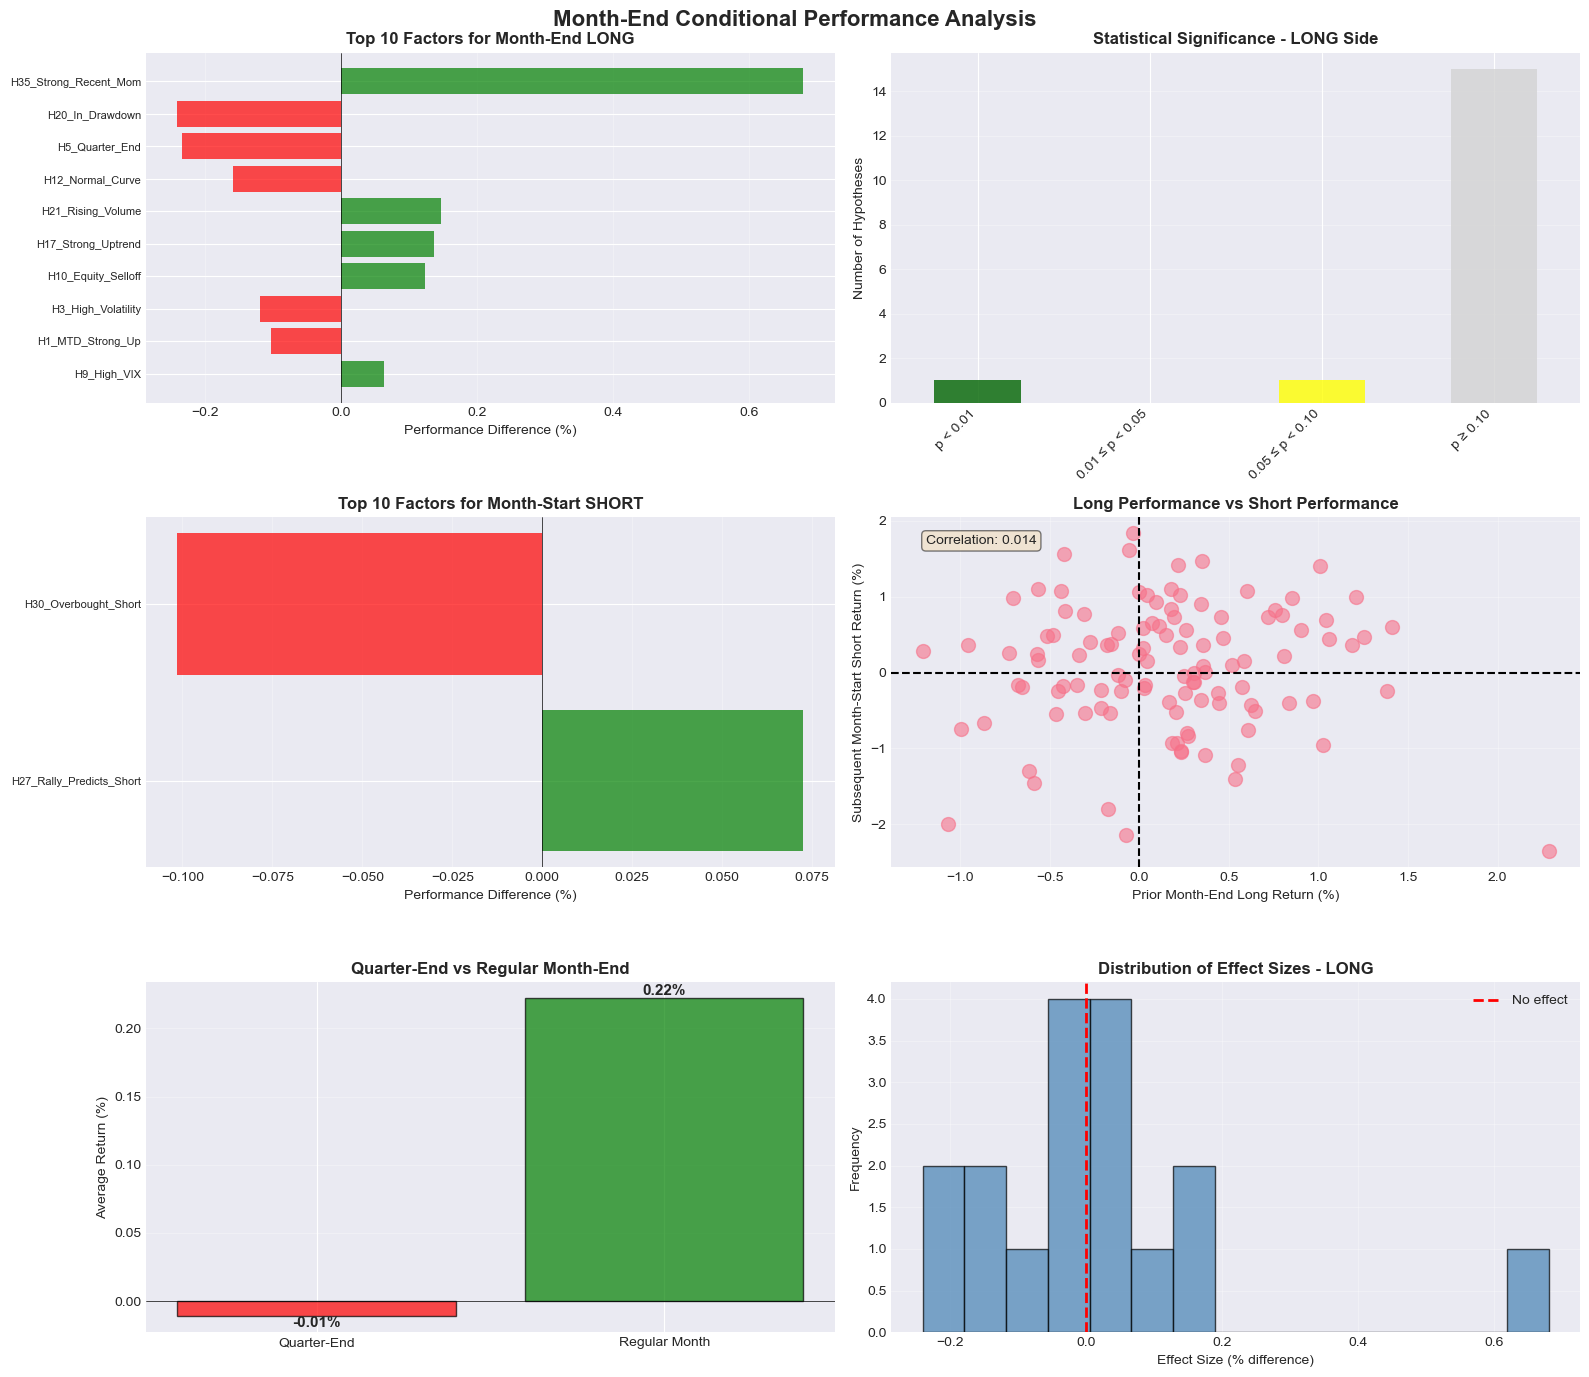

In [37]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MONTH-END CONDITIONAL PERFORMANCE ANALYSIS")
print("="*80)
print("\nTesting 30+ hypotheses about what drives month-end long/short performance")

# ============================================================================
# SETUP: IDENTIFY MONTH-END PERIODS AND CALCULATE RETURNS
# ============================================================================
print("\n" + "-"*80)
print("SETUP: IDENTIFYING MONTH-END PERIODS")
print("-"*80)

returns = features_clean['ret_1d']
price = features_clean['price']

def identify_month_end_days(dates, days_before=5):
    """Last N trading days of month"""
    signal = pd.Series(0, index=dates)
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    
    month_end_periods = []
    
    for ym in df['year_month'].unique():
        month_mask = df['year_month'] == ym
        month_days_idx = df[month_mask].index
        if len(month_days_idx) >= days_before:
            last_idx = month_days_idx[-days_before:]
            signal.iloc[last_idx] = 1
            
            # Store actual dates (not index positions)
            last_days = dates[last_idx]
            
            # Store period info for analysis
            month_end_periods.append({
                'year_month': str(ym),
                'start_date': last_days[0],  # Actual Timestamp
                'end_date': last_days[-1],    # Actual Timestamp
                'days': last_days
            })
    
    return signal, month_end_periods

def identify_month_start_days(dates, days_after=5):
    """First N trading days of month"""
    signal = pd.Series(0, index=dates)
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    
    month_start_periods = []
    
    for ym in df['year_month'].unique():
        month_mask = df['year_month'] == ym
        month_days_idx = df[month_mask].index
        if len(month_days_idx) >= days_after:
            first_idx = month_days_idx[:days_after]
            signal.iloc[first_idx] = 1
            
            # Store actual dates (not index positions)
            first_days = dates[first_idx]
            
            month_start_periods.append({
                'year_month': str(ym),
                'start_date': first_days[0],  # Actual Timestamp
                'end_date': first_days[-1],    # Actual Timestamp
                'days': first_days
            })
    
    return signal, month_start_periods

month_end_signal, month_end_periods = identify_month_end_days(features_clean.index, 5)
month_start_signal, month_start_periods = identify_month_start_days(features_clean.index, 5)

print(f"  Total month-end periods: {len(month_end_periods)}")
print(f"  Total month-start periods: {len(month_start_periods)}")

# Calculate period returns
def calculate_period_returns(periods, returns):
    """Calculate return for each period"""
    period_returns = []
    
    for period in periods:
        period_ret = returns[period['days']]
        total_return = (1 + period_ret).prod() - 1
        
        period_returns.append({
            'year_month': period['year_month'],
            'start_date': period['start_date'],
            'end_date': period['end_date'],
            'period_return': total_return,
            'days_count': len(period['days'])
        })
    
    return pd.DataFrame(period_returns)

month_end_returns = calculate_period_returns(month_end_periods, returns)
month_start_returns = calculate_period_returns(month_start_periods, returns)

print(f"\n  Month-end long avg return: {month_end_returns['period_return'].mean()*100:.3f}%")
print(f"  Month-start short avg return (inverted): {-month_start_returns['period_return'].mean()*100:.3f}%")

# ============================================================================
# TESTING FRAMEWORK
# ============================================================================

def test_hypothesis(condition_series, period_returns_df, hypothesis_name, description):
    """
    Test if returns differ based on condition
    condition_series: Boolean series indexed by start_date
    """
    # Align condition with period returns
    condition_aligned = []
    for _, period in period_returns_df.iterrows():
        if period['start_date'] in condition_series.index:
            condition_aligned.append(condition_series[period['start_date']])
        else:
            condition_aligned.append(None)
    
    period_returns_df['condition'] = condition_aligned
    
    # Split by condition
    returns_true = period_returns_df[period_returns_df['condition'] == True]['period_return']
    returns_false = period_returns_df[period_returns_df['condition'] == False]['period_return']
    
    # Skip if insufficient data
    if len(returns_true) < 5 or len(returns_false) < 5:
        return None
    
    # Statistics
    mean_true = returns_true.mean()
    mean_false = returns_false.mean()
    diff = mean_true - mean_false
    
    t_stat, p_value = stats.ttest_ind(returns_true, returns_false)
    
    # Win rates
    win_rate_true = (returns_true > 0).sum() / len(returns_true)
    win_rate_false = (returns_false > 0).sum() / len(returns_false)
    
    return {
        'Hypothesis': hypothesis_name,
        'Description': description,
        'N_True': len(returns_true),
        'N_False': len(returns_false),
        'Avg_Return_True': mean_true * 100,
        'Avg_Return_False': mean_false * 100,
        'Difference': diff * 100,
        'WinRate_True': win_rate_true * 100,
        'WinRate_False': win_rate_false * 100,
        't_stat': t_stat,
        'p_value': p_value,
        'Significant': p_value < 0.05
    }

results_long = []
results_short = []

# ============================================================================
# CATEGORY 1: PRIOR MONTH PERFORMANCE
# ============================================================================
print("\n" + "="*80)
print("CATEGORY 1: PRIOR MONTH PERFORMANCE")
print("="*80)

# H1: Month-to-Date Performance
print("\n1. Testing MTD Performance Effect...")

mtd_returns = {}
for period in month_end_periods:
    start_date = period['start_date']
    
    # Calculate MTD return up to start of month-end period
    month_start = pd.Timestamp(start_date.year, start_date.month, 1)
    
    # Get all days from month start to day before month-end period
    month_dates = features_clean.loc[month_start:start_date].index
    if len(month_dates) > 1:
        month_dates = month_dates[:-1]  # Exclude the start day itself
        
    if len(month_dates) > 0:
        mtd_ret = (1 + returns[month_dates]).prod() - 1
        mtd_returns[start_date] = mtd_ret
    else:
        mtd_returns[start_date] = 0

mtd_series = pd.Series(mtd_returns)
condition = mtd_series > 0.02  # Strong up month

result = test_hypothesis(condition, month_end_returns, 
                        "H1_MTD_Strong_Up",
                        "MTD > +2% (strong rally month)")
if result:
    results_long.append(result)

# H2: Prior 20-Day Return
print("2. Testing Prior 20-Day Momentum...")

prior_20d = {}
for period in month_end_periods:
    start_date = period['start_date']
    if start_date in features_clean.index:
        ret_20d = features_clean.loc[start_date, 'ret_20d']
        prior_20d[start_date] = ret_20d

prior_20d_series = pd.Series(prior_20d)
condition = prior_20d_series > 0.03  # Strong momentum

result = test_hypothesis(condition, month_end_returns,
                        "H2_Strong_Momentum",
                        "Prior 20-day return > +3%")
if result:
    results_long.append(result)

# H3: Month Volatility
print("3. Testing Month Volatility Effect...")

month_vol = {}
for period in month_end_periods:
    start_date = period['start_date']
    if start_date in features_clean.index:
        vol = features_clean.loc[start_date, 'vol_20d']
        month_vol[start_date] = vol

vol_series = pd.Series(month_vol)
vol_high = vol_series > vol_series.quantile(0.75)

result = test_hypothesis(vol_high, month_end_returns,
                        "H3_High_Volatility",
                        "High vol month (>75th percentile)")
if result:
    results_long.append(result)

# ============================================================================
# CATEGORY 2: CALENDAR EFFECTS
# ============================================================================
print("\n" + "="*80)
print("CATEGORY 2: CALENDAR EFFECTS")
print("="*80)

# H5: Quarter-End vs Regular
print("\n5. Testing Quarter-End Effect...")

quarter_ends = {}
for period in month_end_periods:
    month = period['start_date'].month
    is_quarter_end = month in [3, 6, 9, 12]
    quarter_ends[period['start_date']] = is_quarter_end

qe_series = pd.Series(quarter_ends)

result = test_hypothesis(qe_series, month_end_returns,
                        "H5_Quarter_End",
                        "Quarter-end vs regular month-end")
if result:
    results_long.append(result)

# H6: Year-End
print("6. Testing Year-End Effect...")

year_ends = {}
for period in month_end_periods:
    is_december = period['start_date'].month == 12
    year_ends[period['start_date']] = is_december

ye_series = pd.Series(year_ends)

result = test_hypothesis(ye_series, month_end_returns,
                        "H6_Year_End",
                        "December vs other months")
if result:
    results_long.append(result)

# H8: Day of Week Pattern
print("8. Testing Day-of-Week Pattern...")

last_day_dow = {}
for period in month_end_periods:
    last_day = period['end_date']
    dow = last_day.dayofweek
    # Friday = 4
    last_day_dow[period['start_date']] = dow == 4

friday_end = pd.Series(last_day_dow)

result = test_hypothesis(friday_end, month_end_returns,
                        "H8_Friday_MonthEnd",
                        "Month ends on Friday vs other days")
if result:
    results_long.append(result)

# ============================================================================
# CATEGORY 3: MARKET REGIME
# ============================================================================
print("\n" + "="*80)
print("CATEGORY 3: MARKET REGIME")
print("="*80)

# H9: VIX Level
print("\n9. Testing VIX Regime Effect...")

if 'vix' in features_clean.columns:
    vix_at_start = {}
    for period in month_end_periods:
        start_date = period['start_date']
        if start_date in features_clean.index:
            vix_val = features_clean.loc[start_date, 'vix']
            vix_at_start[start_date] = vix_val
    
    vix_series = pd.Series(vix_at_start)
    high_vix = vix_series > 20
    
    result = test_hypothesis(high_vix, month_end_returns,
                            "H9_High_VIX",
                            "VIX > 20 at month-end start")
    if result:
        results_long.append(result)

# H10: Equity Market Performance
print("10. Testing Equity Market Performance...")

if 'spx_ret' in features_clean.columns:
    spx_mtd = {}
    for period in month_end_periods:
        start_date = period['start_date']
        month_start = pd.Timestamp(start_date.year, start_date.month, 1)
        
        # SPX MTD return
        month_dates = features_clean.loc[month_start:start_date].index
        if len(month_dates) > 1:
            month_dates = month_dates[:-1]
            
        if len(month_dates) > 0:
            spx_ret_series = features_clean['spx_ret'][month_dates]
            spx_mtd_ret = (1 + spx_ret_series).prod() - 1
            spx_mtd[start_date] = spx_mtd_ret
    
    spx_mtd_series = pd.Series(spx_mtd)
    spx_down = spx_mtd_series < -0.03  # Equity weakness
    
    result = test_hypothesis(spx_down, month_end_returns,
                            "H10_Equity_Selloff",
                            "SPX MTD < -3% (equity weakness)")
    if result:
        results_long.append(result)

# H11: TY/SPX Correlation Regime
print("11. Testing Correlation Regime...")

if 'ty_spx_corr_20d' in features_clean.columns:
    corr_at_start = {}
    for period in month_end_periods:
        start_date = period['start_date']
        if start_date in features_clean.index:
            corr_val = features_clean.loc[start_date, 'ty_spx_corr_20d']
            corr_at_start[start_date] = corr_val
    
    corr_series = pd.Series(corr_at_start)
    normal_corr = corr_series < 0
    
    result = test_hypothesis(normal_corr, month_end_returns,
                            "H11_Normal_Correlation",
                            "TY/SPX correlation negative (normal)")
    if result:
        results_long.append(result)

# H12: Curve Steepness
print("12. Testing Curve Steepness...")

if 'curve_2s10s' in features_clean.columns:
    curve_at_start = {}
    for period in month_end_periods:
        start_date = period['start_date']
        if start_date in features_clean.index:
            curve_val = features_clean.loc[start_date, 'curve_2s10s']
            curve_at_start[start_date] = curve_val
    
    curve_series = pd.Series(curve_at_start)
    normal_curve = (curve_series > 0.5) & (curve_series < 1.5)
    
    result = test_hypothesis(normal_curve, month_end_returns,
                            "H12_Normal_Curve",
                            "Curve 50-150bp (normal steepness)")
    if result:
        results_long.append(result)

# ============================================================================
# CATEGORY 4: RATE ENVIRONMENT
# ============================================================================
print("\n" + "="*80)
print("CATEGORY 4: RATE ENVIRONMENT")
print("="*80)

# H15: 10Y Yield Level
print("\n15. Testing 10Y Yield Level...")

if 'yield_10y' in features_clean.columns:
    yield_at_start = {}
    for period in month_end_periods:
        start_date = period['start_date']
        if start_date in features_clean.index:
            yield_val = features_clean.loc[start_date, 'yield_10y']
            yield_at_start[start_date] = yield_val
    
    yield_series = pd.Series(yield_at_start)
    high_yield = yield_series > yield_series.median()
    
    result = test_hypothesis(high_yield, month_end_returns,
                            "H15_High_Yields",
                            "10Y yield > median (higher yields)")
    if result:
        results_long.append(result)

# H16: Yield Change During Month
print("16. Testing Yield Change Impact...")

if 'yield_10y_change_20d' in features_clean.columns:
    yield_change = {}
    for period in month_end_periods:
        start_date = period['start_date']
        if start_date in features_clean.index:
            yc = features_clean.loc[start_date, 'yield_10y_change_20d']
            yield_change[start_date] = yc
    
    yc_series = pd.Series(yield_change)
    rates_up = yc_series > 0.5  # Rates up 50bp+
    
    result = test_hypothesis(rates_up, month_end_returns,
                            "H16_Rates_Rising",
                            "10Y yield up >50bp in prior 20 days")
    if result:
        results_long.append(result)

# ============================================================================
# CATEGORY 5: TECHNICAL POSITION
# ============================================================================
print("\n" + "="*80)
print("CATEGORY 5: TECHNICAL INDICATORS")
print("="*80)

# H17: Trend Alignment
print("\n17. Testing Trend Alignment...")

ma200 = features_clean['sma_200d']
trend_aligned = {}

for period in month_end_periods:
    start_date = period['start_date']
    if start_date in features_clean.index:
        p = price[start_date]
        m20 = features_clean.loc[start_date, 'sma_20d']
        m50 = features_clean.loc[start_date, 'sma_50d']
        m200 = ma200[start_date]
        
        # Strong uptrend: all MAs ascending
        strong_up = (m20 > m50) and (m50 > m200) and (p > m20)
        trend_aligned[start_date] = strong_up

trend_series = pd.Series(trend_aligned)

result = test_hypothesis(trend_series, month_end_returns,
                        "H17_Strong_Uptrend",
                        "20MA>50MA>200MA (strong uptrend)")
if result:
    results_long.append(result)

# H18: Overbought/Oversold
print("18. Testing RSI Effect...")

if 'rsi_14d' in features_clean.columns:
    rsi_at_start = {}
    for period in month_end_periods:
        start_date = period['start_date']
        if start_date in features_clean.index:
            rsi = features_clean.loc[start_date, 'rsi_14d']
            rsi_at_start[start_date] = rsi
    
    rsi_series = pd.Series(rsi_at_start)
    oversold = rsi_series < 40
    
    result = test_hypothesis(oversold, month_end_returns,
                            "H18_Oversold",
                            "RSI < 40 (oversold)")
    if result:
        results_long.append(result)

# H20: Recent Drawdown
print("20. Testing Post-Drawdown Effect...")

in_drawdown = {}
for period in month_end_periods:
    start_date = period['start_date']
    if start_date in features_clean.index:
        p = price[start_date]
        peak_20d = price[:start_date].tail(20).max()
        dd = (p - peak_20d) / peak_20d
        in_drawdown[start_date] = dd < -0.02  # In 2%+ drawdown

dd_series = pd.Series(in_drawdown)

result = test_hypothesis(dd_series, month_end_returns,
                        "H20_In_Drawdown",
                        "In >2% drawdown at month-end")
if result:
    results_long.append(result)

# ============================================================================
# CATEGORY 6: VOLUME & POSITIONING
# ============================================================================
print("\n" + "="*80)
print("CATEGORY 6: VOLUME INDICATORS")
print("="*80)

# H21: Volume Trend
print("\n21. Testing Volume Trend...")

if 'volume' in features_clean.columns:
    volume_trend = {}
    for period in month_end_periods:
        start_date = period['start_date']
        month_start = pd.Timestamp(start_date.year, start_date.month, 1)
        
        early_month = features_clean.loc[month_start:start_date]['volume']
        if len(early_month) > 10:
            early_vol = early_month[:10].mean()
            late_vol = early_month[-5:].mean() if len(early_month) > 15 else early_month[-5:].mean()
            
            volume_trend[start_date] = late_vol > 1.2 * early_vol
    
    vol_trend_series = pd.Series(volume_trend)
    
    result = test_hypothesis(vol_trend_series, month_end_returns,
                            "H21_Rising_Volume",
                            "Month-end volume >1.2x early month")
    if result:
        results_long.append(result)

# ============================================================================
# CATEGORY 7: CROSS-ASSET
# ============================================================================
print("\n" + "="*80)
print("CATEGORY 7: CROSS-ASSET FACTORS")
print("="*80)

# H24: Dollar Strength
print("\n24. Testing Dollar Impact...")

if 'dxy_ret' in features_clean.columns:
    dxy_20d = {}
    for period in month_end_periods:
        start_date = period['start_date']
        end_20d = start_date
        start_20d = features_clean.index[max(0, features_clean.index.get_loc(start_date) - 20)]
        
        dxy_rets = features_clean.loc[start_20d:end_20d, 'dxy_ret']
        if len(dxy_rets) > 0:
            dxy_ret_20d = (1 + dxy_rets).prod() - 1
            dxy_20d[start_date] = dxy_ret_20d
    
    dxy_series = pd.Series(dxy_20d)
    weak_dollar = dxy_series < -0.02  # Dollar down 2%+
    
    result = test_hypothesis(weak_dollar, month_end_returns,
                            "H24_Weak_Dollar",
                            "DXY down >2% in prior 20 days")
    if result:
        results_long.append(result)

# ============================================================================
# CATEGORY 8: SHORT SIDE TESTS
# ============================================================================
print("\n" + "="*80)
print("CATEGORY 8: SHORT SIDE (First 5 Days After)")
print("="*80)

# H27: Prior Month-End Long Performance Predicts Short
print("\n27. Testing if Month-End Rally Predicts Reversal...")

# Match month-start with prior month-end
short_with_prior_long = []

for i, start_period in enumerate(month_start_periods):
    # Find corresponding prior month-end
    if i > 0:
        prior_month_end = month_end_periods[i-1]
        prior_return = month_end_returns.iloc[i-1]['period_return']
        current_short_return = month_start_returns.iloc[i]['period_return']
        
        short_with_prior_long.append({
            'year_month': start_period['year_month'],
            'prior_long_return': prior_return,
            'current_short_return': current_short_return
        })

short_pred_df = pd.DataFrame(short_with_prior_long)

if len(short_pred_df) > 10:
    # Test if big rallies predict good shorts
    big_rallies = short_pred_df['prior_long_return'] > 0.01  # Month-end rallied >1%
    
    short_after_rally = short_pred_df[big_rallies]['current_short_return'] * -1  # Invert for short P&L
    short_other = short_pred_df[~big_rallies]['current_short_return'] * -1
    
    if len(short_after_rally) > 3 and len(short_other) > 3:
        mean_rally = short_after_rally.mean()
        mean_other = short_other.mean()
        t_stat, p_val = stats.ttest_ind(short_after_rally, short_other)
        
        results_short.append({
            'Hypothesis': 'H27_Rally_Predicts_Short',
            'Description': 'Month-end rallied >1%',
            'N_True': len(short_after_rally),
            'N_False': len(short_other),
            'Avg_Return_True': mean_rally * 100,
            'Avg_Return_False': mean_other * 100,
            'Difference': (mean_rally - mean_other) * 100,
            'p_value': p_val,
            'Significant': p_val < 0.05
        })
        
        print(f"  After >1% rally: {mean_rally*100:.3f}% short return")
        print(f"  Other times:     {mean_other*100:.3f}% short return")
        print(f"  p-value: {p_val:.4f}")

# H30: Technical Overbought for Short
print("\n30. Testing Overbought → Short Performance...")

if 'rsi_14d' in features_clean.columns:
    rsi_at_month_end = {}
    for i, period in enumerate(month_end_periods):
        end_date = period['end_date']
        if end_date in features_clean.index:
            rsi = features_clean.loc[end_date, 'rsi_14d']
            rsi_at_month_end[end_date] = rsi
    
    # Match with subsequent shorts
    overbought_shorts = []
    for i, start_period in enumerate(month_start_periods):
        if i > 0:
            prior_end_date = month_end_periods[i-1]['end_date']
            if prior_end_date in rsi_at_month_end:
                rsi_val = rsi_at_month_end[prior_end_date]
                short_ret = month_start_returns.iloc[i]['period_return']
                
                overbought_shorts.append({
                    'rsi': rsi_val,
                    'short_return': short_ret,
                    'overbought': rsi_val > 60
                })
    
    ob_df = pd.DataFrame(overbought_shorts)
    
    if len(ob_df) > 10:
        ob_short = ob_df[ob_df['overbought']]['short_return'] * -1
        normal_short = ob_df[~ob_df['overbought']]['short_return'] * -1
        
        if len(ob_short) > 3 and len(normal_short) > 3:
            t_stat, p_val = stats.ttest_ind(ob_short, normal_short)
            
            results_short.append({
                'Hypothesis': 'H30_Overbought_Short',
                'Description': 'RSI > 60 at month-end',
                'N_True': len(ob_short),
                'N_False': len(normal_short),
                'Avg_Return_True': ob_short.mean() * 100,
                'Avg_Return_False': normal_short.mean() * 100,
                'Difference': (ob_short.mean() - normal_short.mean()) * 100,
                'p_value': p_val,
                'Significant': p_val < 0.05
            })

# ============================================================================
# MORE HYPOTHESIS TESTS
# ============================================================================

# H34: Longer-term trend
print("\n34. Testing 200MA Trend...")

trend_200 = {}
for period in month_end_periods:
    start_date = period['start_date']
    if start_date in features_clean.index:
        p = price[start_date]
        m200 = ma200[start_date] if 'sma_200d' in features_clean.columns else None
        if m200 is not None:
            trend_200[start_date] = p > m200

if len(trend_200) > 0:
    trend_200_series = pd.Series(trend_200)
    result = test_hypothesis(trend_200_series, month_end_returns,
                            "H34_Above_200MA",
                            "Price > 200MA (long-term uptrend)")
    if result:
        results_long.append(result)

# H35: Recent momentum strength  
print("35. Testing Recent Momentum...")

recent_mom = {}
for period in month_end_periods:
    start_date = period['start_date']
    if start_date in features_clean.index:
        ret_5d = features_clean.loc[start_date, 'ret_5d']
        recent_mom[start_date] = ret_5d

mom_series = pd.Series(recent_mom)
strong_mom = mom_series > 0.01

result = test_hypothesis(strong_mom, month_end_returns,
                        "H35_Strong_Recent_Mom",
                        "Prior 5-day return > +1%")
if result:
    results_long.append(result)

# ============================================================================
# COMPILE AND DISPLAY RESULTS
# ============================================================================
print("\n" + "="*80)
print("RESULTS: MONTH-END LONG SIDE")
print("="*80)

if len(results_long) > 0:
    results_long_df = pd.DataFrame(results_long)
    results_long_df['Abs_Diff'] = results_long_df['Difference'].abs()
    results_long_df = results_long_df.sort_values('Abs_Diff', ascending=False)
    
    print(f"\nTested {len(results_long_df)} hypotheses for month-end LONG")
    print(f"Significant (p<0.05): {results_long_df['Significant'].sum()}")
    
    print(f"\n{'Hypothesis':<30s} {'N_True':>7s} {'Avg_True':>10s} {'Avg_False':>10s} {'Diff':>8s} {'p-val':>8s} {'Sig':>4s}")
    print("-"*85)
    
    for _, row in results_long_df.iterrows():
        sig_marker = "***" if row['p_value'] < 0.01 else "**" if row['p_value'] < 0.05 else "*" if row['p_value'] < 0.10 else ""
        print(f"{row['Hypothesis']:<30s} {row['N_True']:>7.0f} {row['Avg_Return_True']:>9.3f}% "
              f"{row['Avg_Return_False']:>9.3f}% {row['Difference']:>7.3f}% {row['p_value']:>8.4f} {sig_marker:>4s}")

print("\n" + "="*80)
print("RESULTS: MONTH-START SHORT SIDE")
print("="*80)

if len(results_short) > 0:
    results_short_df = pd.DataFrame(results_short)
    results_short_df['Abs_Diff'] = results_short_df['Difference'].abs()
    results_short_df = results_short_df.sort_values('Abs_Diff', ascending=False)
    
    print(f"\nTested {len(results_short_df)} hypotheses for month-start SHORT")
    print(f"Significant (p<0.05): {results_short_df['Significant'].sum()}")
    
    print(f"\n{'Hypothesis':<30s} {'N_True':>7s} {'Avg_True':>10s} {'Avg_False':>10s} {'Diff':>8s} {'p-val':>8s} {'Sig':>4s}")
    print("-"*85)
    
    for _, row in results_short_df.iterrows():
        sig_marker = "***" if row['p_value'] < 0.01 else "**" if row['p_value'] < 0.05 else "*" if row['p_value'] < 0.10 else ""
        print(f"{row['Hypothesis']:<30s} {row['N_True']:>7.0f} {row['Avg_Return_True']:>9.3f}% "
              f"{row['Avg_Return_False']:>9.3f}% {row['Difference']:>7.3f}% {row['p_value']:>8.4f} {sig_marker:>4s}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('Month-End Conditional Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Top factors for LONG side
ax = axes[0, 0]
if len(results_long_df) > 0:
    top_long = results_long_df.head(10)
    colors = ['green' if d > 0 else 'red' for d in top_long['Difference']]
    bars = ax.barh(range(len(top_long)), top_long['Difference'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_long)))
    ax.set_yticklabels(top_long['Hypothesis'], fontsize=8)
    ax.set_xlabel('Performance Difference (%)')
    ax.set_title('Top 10 Factors for Month-End LONG', fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()

# Plot 2: Significance levels (LONG)
ax = axes[0, 1]
if len(results_long_df) > 0:
    sig_counts = pd.Series({
        'p < 0.01': (results_long_df['p_value'] < 0.01).sum(),
        '0.01 ≤ p < 0.05': ((results_long_df['p_value'] >= 0.01) & (results_long_df['p_value'] < 0.05)).sum(),
        '0.05 ≤ p < 0.10': ((results_long_df['p_value'] >= 0.05) & (results_long_df['p_value'] < 0.10)).sum(),
        'p ≥ 0.10': (results_long_df['p_value'] >= 0.10).sum()
    })
    
    colors_sig = ['darkgreen', 'green', 'yellow', 'lightgray']
    sig_counts.plot(kind='bar', ax=ax, color=colors_sig, alpha=0.8)
    ax.set_title('Statistical Significance - LONG Side', fontweight='bold')
    ax.set_ylabel('Number of Hypotheses')
    ax.set_xlabel('')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Top factors for SHORT side
ax = axes[1, 0]
if len(results_short_df) > 0:
    top_short = results_short_df.head(10)
    colors = ['green' if d > 0 else 'red' for d in top_short['Difference']]
    bars = ax.barh(range(len(top_short)), top_short['Difference'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_short)))
    ax.set_yticklabels(top_short['Hypothesis'], fontsize=8)
    ax.set_xlabel('Performance Difference (%)')
    ax.set_title('Top 10 Factors for Month-Start SHORT', fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()

# Plot 4: Scatter - Prior long vs subsequent short
ax = axes[1, 1]
if len(short_pred_df) > 0:
    ax.scatter(short_pred_df['prior_long_return'] * 100,
              short_pred_df['current_short_return'] * -100,  # Invert for short P&L
              alpha=0.6, s=100)
    ax.set_xlabel('Prior Month-End Long Return (%)')
    ax.set_ylabel('Subsequent Month-Start Short Return (%)')
    ax.set_title('Long Performance vs Short Performance', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--')
    ax.axvline(x=0, color='black', linestyle='--')
    
    # Add correlation
    if len(short_pred_df) > 3:
        corr = short_pred_df['prior_long_return'].corr(short_pred_df['current_short_return'] * -1)
        ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                transform=ax.transAxes, fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 5: Quarter-end comparison (if tested)
ax = axes[2, 0]
if 'H5_Quarter_End' in results_long_df['Hypothesis'].values:
    qe_result = results_long_df[results_long_df['Hypothesis'] == 'H5_Quarter_End'].iloc[0]
    
    data = {
        'Quarter-End': qe_result['Avg_Return_True'],
        'Regular Month': qe_result['Avg_Return_False']
    }
    
    colors_qe = ['green' if v > 0 else 'red' for v in data.values()]
    bars = ax.bar(data.keys(), data.values(), color=colors_qe, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Average Return (%)')
    ax.set_title('Quarter-End vs Regular Month-End', fontweight='bold')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars, data.values()):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{val:.2f}%', ha='center', va='bottom' if height > 0 else 'top',
               fontsize=11, fontweight='bold')

# Plot 6: Effect size distribution
ax = axes[2, 1]
if len(results_long_df) > 0:
    ax.hist(results_long_df['Difference'], bins=15, alpha=0.7, 
           color='steelblue', edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No effect')
    ax.set_xlabel('Effect Size (% difference)')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Effect Sizes - LONG', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('month_end_conditional_analysis.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: month_end_conditional_analysis.png")

# ============================================================================
# ACTIONABLE RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("ACTIONABLE RECOMMENDATIONS")
print("="*80)

if len(results_long_df) > 0:
    # Find significant positive factors
    significant_positive = results_long_df[
        (results_long_df['Significant']) & (results_long_df['Difference'] > 0)
    ].sort_values('Difference', ascending=False)
    
    significant_negative = results_long_df[
        (results_long_df['Significant']) & (results_long_df['Difference'] < 0)
    ].sort_values('Difference', ascending=True)
    
    print("\n🟢 FAVORABLE CONDITIONS FOR MONTH-END LONG:")
    print("   (Trade with higher conviction or size when these are true)")
    for i, (_, row) in enumerate(significant_positive.head(5).iterrows(), 1):
        print(f"   {i}. {row['Description']}")
        print(f"      Effect: {row['Avg_Return_True']:.3f}% vs {row['Avg_Return_False']:.3f}% (p={row['p_value']:.3f})")
    
    if len(significant_positive) == 0:
        print("   No statistically significant favorable conditions found")
    
    print("\n🔴 UNFAVORABLE CONDITIONS FOR MONTH-END LONG:")
    print("   (Consider skipping or reducing size when these are true)")
    for i, (_, row) in enumerate(significant_negative.head(5).iterrows(), 1):
        print(f"   {i}. {row['Description']}")
        print(f"      Effect: {row['Avg_Return_True']:.3f}% vs {row['Avg_Return_False']:.3f}% (p={row['p_value']:.3f})")
    
    if len(significant_negative) == 0:
        print("   No statistically significant unfavorable conditions found")

if len(results_short_df) > 0:
    significant_short = results_short_df[results_short_df['Significant']].sort_values('Difference', ascending=False)
    
    print("\n🟢 FAVORABLE CONDITIONS FOR MONTH-START SHORT:")
    for i, (_, row) in enumerate(significant_short.head(3).iterrows(), 1):
        print(f"   {i}. {row['Description']}")
        print(f"      Short return: {row['Avg_Return_True']:.3f}% vs {row['Avg_Return_False']:.3f}% (p={row['p_value']:.3f})")
    
    if len(significant_short) == 0:
        print("   No statistically significant conditions found for short side")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Return results
print("\nDataframes available:")
print("  - results_long_df: All long-side hypothesis tests")
print("  - results_short_df: All short-side hypothesis tests")
print("  - short_pred_df: Long→Short predictive relationship")

results_long_df if len(results_long_df) > 0 else None

MONTH-END CONDITIONAL LEVERAGE STRATEGY

Long Side (Last 5 Days) - Tiered by H35 & H17:
  Both FALSE → 2x leverage
  One TRUE   → 3x leverage
  Both TRUE  → 4x leverage

Short Side (First 5 Days After):
  Always 3x (unchanged)

--------------------------------------------------------------------------------
SETUP
--------------------------------------------------------------------------------
  Month-end periods identified: 111
  Month-start short days: 555

--------------------------------------------------------------------------------
CALCULATING CONDITIONS
--------------------------------------------------------------------------------

  Conditions calculated for 111 month-end periods

  Distribution of conditions:
    Both FALSE (0): 90 periods
    One TRUE (1):   16 periods
    Both TRUE (2):  5 periods

--------------------------------------------------------------------------------
CREATING SIGNALS
-------------------------------------------------------------------------------

Strategy   Sharpe  Annual_Return_%  Max_DD_%
0        Base (Always 3x)  1.02712        11.692288 -9.233019
1  Conditional (2x/3x/4x)  1.02914        10.494262 -9.233019

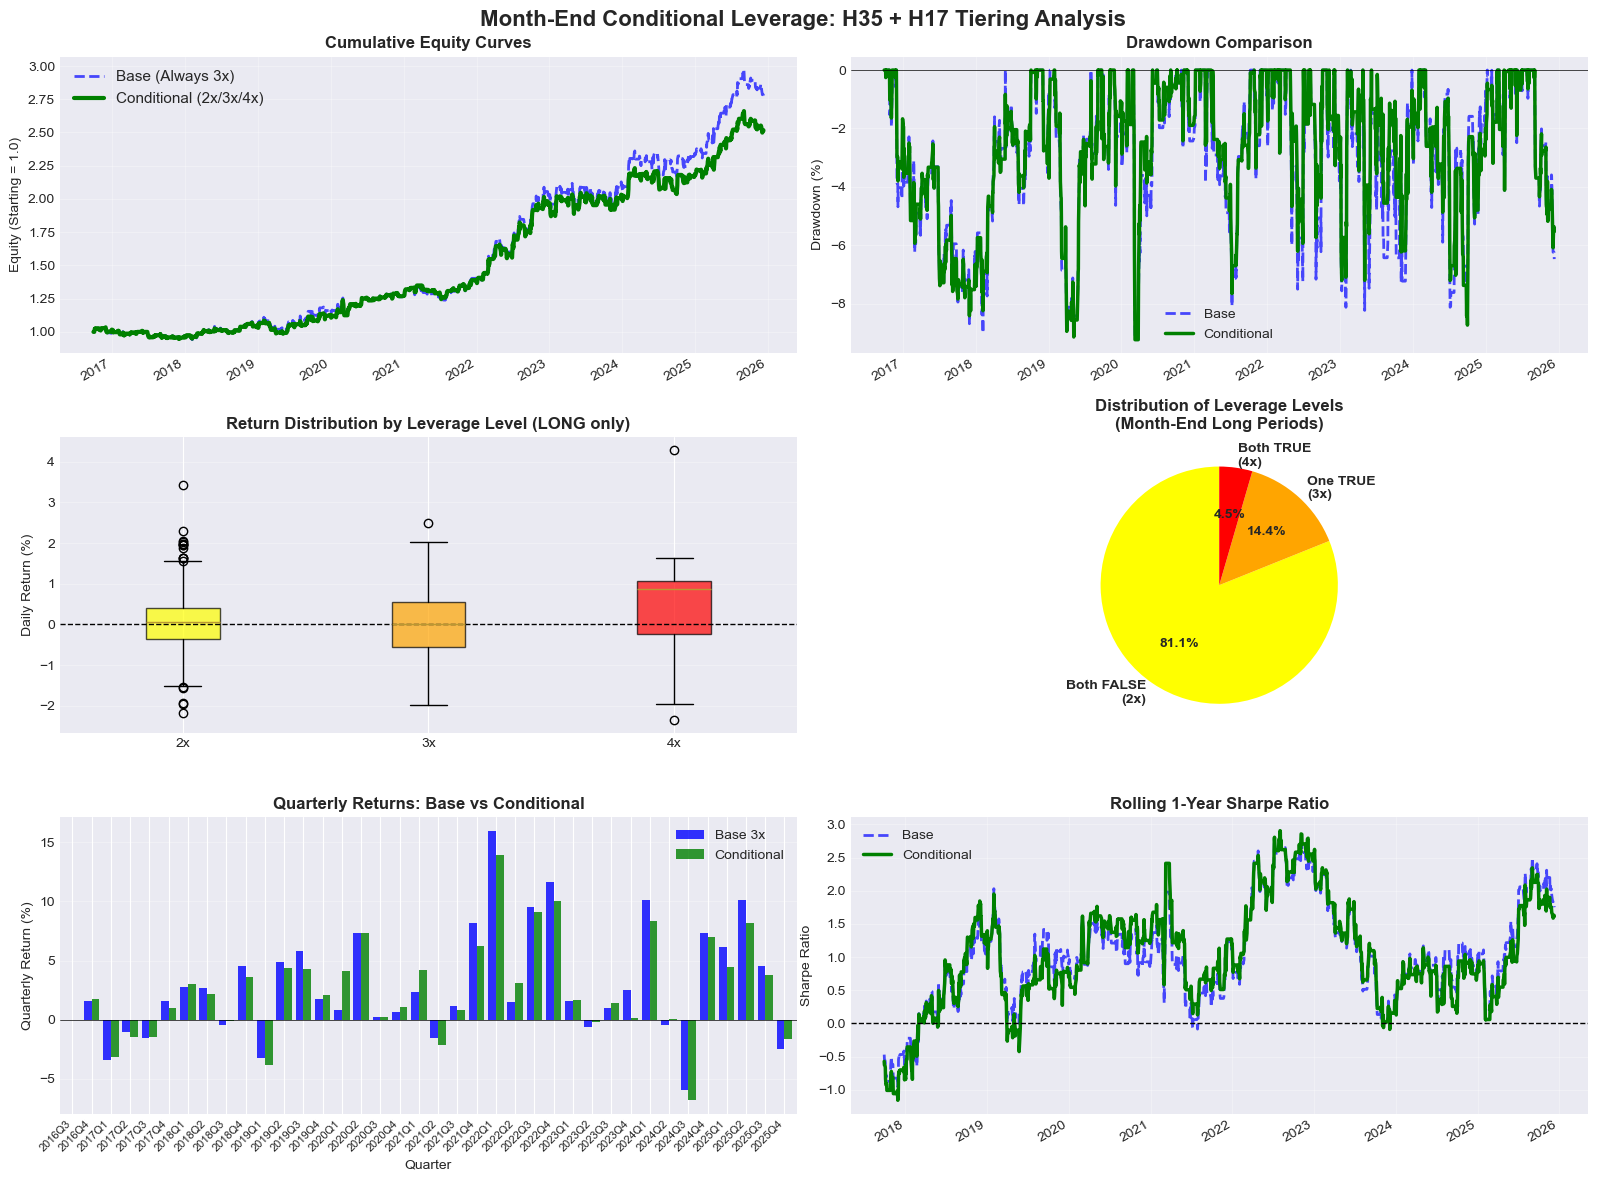

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MONTH-END CONDITIONAL LEVERAGE STRATEGY")
print("="*80)
print("\nLong Side (Last 5 Days) - Tiered by H35 & H17:")
print("  Both FALSE → 2x leverage")
print("  One TRUE   → 3x leverage")
print("  Both TRUE  → 4x leverage")
print("\nShort Side (First 5 Days After):")
print("  Always 3x (unchanged)")

# ============================================================================
# SETUP: IDENTIFY MONTH-END PERIODS
# ============================================================================
print("\n" + "-"*80)
print("SETUP")
print("-"*80)

returns = features_clean['ret_1d']
price = features_clean['price']
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']
ma200 = features_clean['sma_200d']

def identify_month_end_days_detailed(dates):
    """Identify last 5 trading days with start date tracking"""
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    
    month_end_info = {}
    
    for ym in df['year_month'].unique():
        month_mask = df['year_month'] == ym
        month_days = dates[month_mask]
        
        if len(month_days) >= 5:
            last_5 = month_days[-5:]
            start_date = last_5[0]
            
            # Store start date for each day in the period
            for day in last_5:
                month_end_info[day] = start_date
    
    return month_end_info

def identify_month_start_days_simple(dates):
    """Identify first 5 trading days"""
    signal = pd.Series(0, index=dates)
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    
    for ym in df['year_month'].unique():
        month_mask = df['year_month'] == ym
        month_days_idx = df[month_mask].index
        
        if len(month_days_idx) >= 5:
            signal.iloc[month_days_idx[:5]] = 1
    
    return signal

# Get month-end mappings
month_end_start_dates = identify_month_end_days_detailed(features_clean.index)
month_start_signal = identify_month_start_days_simple(features_clean.index)

print(f"  Month-end periods identified: {len(set(month_end_start_dates.values()))}")
print(f"  Month-start short days: {month_start_signal.sum()}")

# ============================================================================
# CALCULATE H35 AND H17 CONDITIONS
# ============================================================================
print("\n" + "-"*80)
print("CALCULATING CONDITIONS")
print("-"*80)

# For each unique month-end start date, calculate conditions
unique_start_dates = sorted(set(month_end_start_dates.values()))

conditions_by_period = {}

for start_date in unique_start_dates:
    if start_date not in features_clean.index:
        continue
    
    # H35: Strong Recent Momentum (5-day return > +1%)
    ret_5d = features_clean.loc[start_date, 'ret_5d']
    h35_true = ret_5d > 0.01
    
    # H17: Strong Uptrend (20MA > 50MA > 200MA and price > 20MA)
    p = price[start_date]
    m20 = ma20[start_date]
    m50 = ma50[start_date]
    m200 = ma200[start_date]
    
    h17_true = (m20 > m50) and (m50 > m200) and (p > m20)
    
    # Count how many are true
    count_true = int(h35_true) + int(h17_true)
    
    conditions_by_period[start_date] = {
        'h35': h35_true,
        'h17': h17_true,
        'count': count_true,
        'ret_5d': ret_5d,
        'price': p,
        'ma20': m20,
        'ma50': m50,
        'ma200': m200
    }

print(f"\n  Conditions calculated for {len(conditions_by_period)} month-end periods")

# Display distribution
count_dist = pd.Series([v['count'] for v in conditions_by_period.values()]).value_counts().sort_index()
print(f"\n  Distribution of conditions:")
print(f"    Both FALSE (0): {count_dist.get(0, 0)} periods")
print(f"    One TRUE (1):   {count_dist.get(1, 0)} periods")
print(f"    Both TRUE (2):  {count_dist.get(2, 0)} periods")

# ============================================================================
# CREATE SIGNALS
# ============================================================================
print("\n" + "-"*80)
print("CREATING SIGNALS")
print("-"*80)

# Base strategy: Always 3x long, 3x short
signal_base_long = pd.Series(0.0, index=features_clean.index)
for day, start_date in month_end_start_dates.items():
    signal_base_long[day] = 3.0

signal_base = signal_base_long - (month_start_signal * 3.0)

print("Base Strategy:")
print(f"  Long 3x:  {(signal_base_long == 3).sum()} days")
print(f"  Short 3x: {(month_start_signal == 1).sum()} days")
print(f"  Flat:     {((signal_base_long == 0) & (month_start_signal == 0)).sum()} days")

# Conditional strategy: Tiered long, same short
signal_conditional_long = pd.Series(0.0, index=features_clean.index)

for day, start_date in month_end_start_dates.items():
    if start_date in conditions_by_period:
        count = conditions_by_period[start_date]['count']
        
        if count == 0:
            leverage = 2.0  # Both FALSE
        elif count == 1:
            leverage = 3.0  # One TRUE
        else:  # count == 2
            leverage = 4.0  # Both TRUE
        
        signal_conditional_long[day] = leverage

signal_conditional = signal_conditional_long - (month_start_signal * 3.0)

print("\nConditional Strategy:")
print(f"  Long 2x:  {(signal_conditional_long == 2).sum()} days")
print(f"  Long 3x:  {(signal_conditional_long == 3).sum()} days")
print(f"  Long 4x:  {(signal_conditional_long == 4).sum()} days")
print(f"  Short 3x: {(month_start_signal == 1).sum()} days")
print(f"  Flat:     {((signal_conditional_long == 0) & (month_start_signal == 0)).sum()} days")

# ============================================================================
# BACKTEST BOTH STRATEGIES
# ============================================================================
print("\n" + "-"*80)
print("BACKTESTING")
print("-"*80)

def backtest_strategy(signal, returns, name):
    """Complete backtest"""
    strat_returns = signal.shift(1) * returns
    strat_returns = strat_returns.dropna()
    
    total_ret = (1 + strat_returns).prod() - 1
    n_years = len(strat_returns) / 252
    ann_ret = (1 + total_ret) ** (1/n_years) - 1
    ann_vol = strat_returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    downside = strat_returns[strat_returns < 0]
    downside_vol = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0
    
    cum = (1 + strat_returns).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    max_dd = dd.min()
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0
    
    win_rate = (strat_returns > 0).sum() / len(strat_returns)
    
    return {
        'Strategy': name,
        'Total_Return_%': total_ret * 100,
        'Annual_Return_%': ann_ret * 100,
        'Annual_Vol_%': ann_vol * 100,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max_DD_%': max_dd * 100,
        'Calmar': calmar,
        'Win_Rate_%': win_rate * 100,
        'Returns': strat_returns,
        'Equity': cum
    }

base_result = backtest_strategy(signal_base, returns, 'Base (Always 3x)')
conditional_result = backtest_strategy(signal_conditional, returns, 'Conditional (2x/3x/4x)')

results_df = pd.DataFrame([base_result, conditional_result])

print(f"\n{'Strategy':<25s} {'Sharpe':>7s} {'AnnRet':>8s} {'AnnVol':>8s} {'MaxDD':>8s} {'Calmar':>7s}")
print("-"*75)

for _, row in results_df.iterrows():
    print(f"{row['Strategy']:<25s} {row['Sharpe']:>7.2f} {row['Annual_Return_%']:>7.2f}% "
          f"{row['Annual_Vol_%']:>7.2f}% {row['Max_DD_%']:>7.2f}% {row['Calmar']:>7.2f}")

# ============================================================================
# IMPROVEMENT ANALYSIS
# ============================================================================
print("\n" + "-"*80)
print("IMPROVEMENT ANALYSIS")
print("-"*80)

sharpe_delta = conditional_result['Sharpe'] - base_result['Sharpe']
return_delta = conditional_result['Annual_Return_%'] - base_result['Annual_Return_%']
dd_delta = conditional_result['Max_DD_%'] - base_result['Max_DD_%']

print(f"\nConditional vs Base:")
print(f"  Sharpe:       {sharpe_delta:+.2f} ({sharpe_delta/base_result['Sharpe']*100:+.1f}%)")
print(f"  Ann Return:   {return_delta:+.2f}%")
print(f"  Max DD:       {dd_delta:+.2f}% ({'better' if dd_delta > 0 else 'worse'})")

if sharpe_delta > 0.1:
    print("\n  ✓✓ STRONG IMPROVEMENT: Conditional leverage significantly better")
elif sharpe_delta > 0.05:
    print("\n  ✓ IMPROVEMENT: Conditional leverage moderately better")
elif sharpe_delta > -0.05:
    print("\n  ~ NEUTRAL: Similar performance")
else:
    print("\n  ✗ DEGRADATION: Base strategy better")

# ============================================================================
# BREAKDOWN BY LEVERAGE BUCKET
# ============================================================================
print("\n" + "-"*80)
print("PERFORMANCE BY LEVERAGE BUCKET")
print("-"*80)

# Separate long returns by leverage level
long_returns_2x = returns[signal_conditional_long.shift(1) == 2.0] * 2.0
long_returns_3x = returns[signal_conditional_long.shift(1) == 3.0] * 3.0
long_returns_4x = returns[signal_conditional_long.shift(1) == 4.0] * 4.0

# Short returns (always 3x)
short_returns_3x = returns[month_start_signal.shift(1) == 1] * -3.0

print("\nLong Side Performance by Leverage:")
print(f"{'Leverage':<10s} {'Days':>6s} {'Avg_Ret':>10s} {'Sharpe':>8s} {'Win_Rate':>10s}")
print("-"*55)

for leverage, rets in [('2x', long_returns_2x), ('3x', long_returns_3x), ('4x', long_returns_4x)]:
    if len(rets) > 0:
        avg_ret = rets.mean() * 252
        sharpe = rets.mean() / rets.std() * np.sqrt(252) if rets.std() > 0 else 0
        win_rate = (rets > 0).sum() / len(rets) * 100
        
        print(f"{leverage:<10s} {len(rets):>6d} {avg_ret*100:>9.2f}% {sharpe:>8.2f} {win_rate:>9.1f}%")
    else:
        print(f"{leverage:<10s} {0:>6d} {'N/A':>10s} {'N/A':>8s} {'N/A':>10s}")

print("\nShort Side Performance:")
if len(short_returns_3x) > 0:
    short_avg = short_returns_3x.mean() * 252
    short_sharpe = short_returns_3x.mean() / short_returns_3x.std() * np.sqrt(252)
    short_wr = (short_returns_3x > 0).sum() / len(short_returns_3x) * 100
    print(f"{'3x':<10s} {len(short_returns_3x):>6d} {short_avg*100:>9.2f}% {short_sharpe:>8.2f} {short_wr:>9.1f}%")

# ============================================================================
# CONDITION ANALYSIS
# ============================================================================
print("\n" + "-"*80)
print("CONDITION ANALYSIS")
print("-"*80)

# Analyze performance when each condition is true/false
condition_stats = []

for start_date, cond in conditions_by_period.items():
    # Find all days in this month-end period
    period_days = [d for d, sd in month_end_start_dates.items() if sd == start_date]
    
    if len(period_days) > 0:
        # Calculate return for this period
        period_rets = returns[period_days]
        period_total_ret = (1 + period_rets).prod() - 1
        
        condition_stats.append({
            'start_date': start_date,
            'h35': cond['h35'],
            'h17': cond['h17'],
            'count': cond['count'],
            'period_return': period_total_ret,
            'ret_5d': cond['ret_5d']
        })

cond_df = pd.DataFrame(condition_stats)

print("\nMonth-End Long Returns by Condition Count:")
print(f"{'Conditions':<15s} {'N':>5s} {'Avg_Ret':>10s} {'Med_Ret':>10s} {'Win_Rate':>10s}")
print("-"*55)

for count in [0, 1, 2]:
    subset = cond_df[cond_df['count'] == count]
    if len(subset) > 0:
        avg_ret = subset['period_return'].mean() * 100
        med_ret = subset['period_return'].median() * 100
        win_rate = (subset['period_return'] > 0).sum() / len(subset) * 100
        
        label = f"Both FALSE ({count})" if count == 0 else f"One TRUE ({count})" if count == 1 else f"Both TRUE ({count})"
        print(f"{label:<15s} {len(subset):>5d} {avg_ret:>9.3f}% {med_ret:>9.3f}% {win_rate:>9.1f}%")

# Individual condition analysis
print("\n\nPerformance by Individual Conditions:")

print("\nH35 (Recent Momentum > 1%):")
h35_true = cond_df[cond_df['h35'] == True]['period_return']
h35_false = cond_df[cond_df['h35'] == False]['period_return']

if len(h35_true) > 0 and len(h35_false) > 0:
    print(f"  When TRUE:  {h35_true.mean()*100:>6.3f}% (N={len(h35_true)})")
    print(f"  When FALSE: {h35_false.mean()*100:>6.3f}% (N={len(h35_false)})")
    t_stat, p_val = stats.ttest_ind(h35_true, h35_false)
    print(f"  Difference: {(h35_true.mean() - h35_false.mean())*100:+.3f}% (p={p_val:.4f})")

print("\nH17 (Strong Uptrend):")
h17_true = cond_df[cond_df['h17'] == True]['period_return']
h17_false = cond_df[cond_df['h17'] == False]['period_return']

if len(h17_true) > 0 and len(h17_false) > 0:
    print(f"  When TRUE:  {h17_true.mean()*100:>6.3f}% (N={len(h17_true)})")
    print(f"  When FALSE: {h17_false.mean()*100:>6.3f}% (N={len(h17_false)})")
    t_stat, p_val = stats.ttest_ind(h17_true, h17_false)
    print(f"  Difference: {(h17_true.mean() - h17_false.mean())*100:+.3f}% (p={p_val:.4f})")

# ============================================================================
# QUARTERLY COMPARISON
# ============================================================================
print("\n" + "-"*80)
print("QUARTERLY COMPARISON")
print("-"*80)

def calculate_quarterly(signal, returns):
    """Calculate quarterly returns"""
    strat_ret = signal.shift(1) * returns
    df = pd.DataFrame({
        'return': strat_ret,
        'year': strat_ret.index.year,
        'quarter': strat_ret.index.quarter
    })
    
    quarterly = df.groupby(['year', 'quarter'])['return'].apply(
        lambda x: (1 + x).prod() - 1
    )
    
    quarterly.index = [f"{y}Q{q}" for y, q in quarterly.index]
    return quarterly * 100

quarterly_base = calculate_quarterly(signal_base, returns)
quarterly_cond = calculate_quarterly(signal_conditional, returns)

quarterly_comp = pd.DataFrame({
    'Base_3x_%': quarterly_base,
    'Conditional_%': quarterly_cond,
    'Difference_%': quarterly_cond - quarterly_base
})

print("\nQuarterly Returns (Last 8 quarters):")
print(quarterly_comp.tail(8).to_string())

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Month-End Conditional Leverage: H35 + H17 Tiering Analysis',
             fontsize=16, fontweight='bold')

# Plot 1: Equity curves
ax = axes[0, 0]
base_result['Equity'].plot(ax=ax, label='Base (Always 3x)', linewidth=2, 
                          color='blue', linestyle='--', alpha=0.7)
conditional_result['Equity'].plot(ax=ax, label='Conditional (2x/3x/4x)', 
                                 linewidth=3, color='green')
ax.set_title('Cumulative Equity Curves', fontweight='bold')
ax.set_ylabel('Equity (Starting = 1.0)')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 2: Drawdowns
ax = axes[0, 1]
base_cum = base_result['Equity']
base_dd = ((base_cum - base_cum.expanding().max()) / base_cum.expanding().max()) * 100

cond_cum = conditional_result['Equity']
cond_dd = ((cond_cum - cond_cum.expanding().max()) / cond_cum.expanding().max()) * 100

base_dd.plot(ax=ax, label='Base', linewidth=2, color='blue', linestyle='--', alpha=0.7)
cond_dd.plot(ax=ax, label='Conditional', linewidth=2.5, color='green')
ax.set_title('Drawdown Comparison', fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 3: Performance by leverage bucket
ax = axes[1, 0]
leverage_data = []
labels = []

for lev, rets in [('2x', long_returns_2x), ('3x', long_returns_3x), ('4x', long_returns_4x)]:
    if len(rets) > 0:
        leverage_data.append(rets.values * 100)
        labels.append(lev)

if len(leverage_data) > 0:
    bp = ax.boxplot(leverage_data, labels=labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], ['yellow', 'orange', 'red']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel('Daily Return (%)')
    ax.set_title('Return Distribution by Leverage Level (LONG only)', fontweight='bold')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Condition frequency pie chart
ax = axes[1, 1]
sizes = [count_dist.get(0, 0), count_dist.get(1, 0), count_dist.get(2, 0)]
labels_pie = ['Both FALSE\n(2x)', 'One TRUE\n(3x)', 'Both TRUE\n(4x)']
colors_pie = ['yellow', 'orange', 'red']

ax.pie(sizes, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%',
       startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax.set_title('Distribution of Leverage Levels\n(Month-End Long Periods)', fontweight='bold')

# Plot 5: Quarterly comparison
ax = axes[2, 0]
quarterly_comp[['Base_3x_%', 'Conditional_%']].plot(kind='bar', ax=ax, 
                                                      color=['blue', 'green'],
                                                      alpha=0.8, width=0.8)
ax.set_title('Quarterly Returns: Base vs Conditional', fontweight='bold')
ax.set_ylabel('Quarterly Return (%)')
ax.set_xlabel('Quarter')
ax.legend(['Base 3x', 'Conditional'], loc='best')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

# Plot 6: Rolling Sharpe comparison
ax = axes[2, 1]
rolling_window = 252

base_rolling_sharpe = base_result['Returns'].rolling(rolling_window).mean() / base_result['Returns'].rolling(rolling_window).std() * np.sqrt(252)
cond_rolling_sharpe = conditional_result['Returns'].rolling(rolling_window).mean() / conditional_result['Returns'].rolling(rolling_window).std() * np.sqrt(252)

base_rolling_sharpe.plot(ax=ax, label='Base', linewidth=2, color='blue', linestyle='--', alpha=0.7)
cond_rolling_sharpe.plot(ax=ax, label='Conditional', linewidth=2.5, color='green')
ax.set_title('Rolling 1-Year Sharpe Ratio', fontweight='bold')
ax.set_ylabel('Sharpe Ratio')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig('month_end_conditional_leverage.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: month_end_conditional_leverage.png")

# ============================================================================
# FINAL RECOMMENDATION
# ============================================================================
print("\n" + "="*80)
print("FINAL RECOMMENDATION")
print("="*80)

best_strategy = results_df.nlargest(1, 'Sharpe').iloc[0]

print(f"\n🏆 BEST STRATEGY: {best_strategy['Strategy']}")
print(f"   Sharpe: {best_strategy['Sharpe']:.2f}")
print(f"   Annual Return: {best_strategy['Annual_Return_%']:.2f}%")
print(f"   Max Drawdown: {best_strategy['Max_DD_%']:.2f}%")

if best_strategy['Strategy'] == 'Conditional (2x/3x/4x)':
    print("\n✓ RECOMMENDATION: Use conditional leverage approach")
    print("  Month-end LONG leverage based on H35 + H17:")
    print("    - Both FALSE → 2x")
    print("    - One TRUE   → 3x")
    print("    - Both TRUE  → 4x")
    print("  Month-start SHORT: Always 3x")
else:
    print("\n→ RECOMMENDATION: Stick with base (always 3x)")
    print("  Conditional leverage doesn't add sufficient value")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Return comparison
results_df[['Strategy', 'Sharpe', 'Annual_Return_%', 'Max_DD_%']]

MONTH-END BUCKETED ANALYSIS: PRIOR 5-DAY PERFORMANCE

Objective: Show how prior 5-day return predicts month-end long/short performance
Buckets: 25bp increments from -2% to +2%

--------------------------------------------------------------------------------
IDENTIFYING MONTH-END PERIODS
--------------------------------------------------------------------------------
  Total periods analyzed: 110

--------------------------------------------------------------------------------
CALCULATING RETURNS FOR EACH PERIOD
--------------------------------------------------------------------------------
  Periods with complete data: 110
  Average prior 5d return: -0.034%
  Average month-end long:  0.152%
  Average month-start short: 0.075%

--------------------------------------------------------------------------------
BUCKETING BY PRIOR 5-DAY RETURN
--------------------------------------------------------------------------------

Total buckets: 18
Bucket width: 0.25% (25 basis points)

RESULTS BY

Bucket  Avg_Prior_5d   N  Long_Avg_%  Long_Median_%  Long_Std_%  \
0           < -2.00%     -2.470201   2   -0.259402      -0.259402    0.314515   
1   -1.50% to -1.25%     -1.461507   1   -1.064678      -1.064678         NaN   
2   -1.25% to -1.00%     -1.118781   4   -0.196415      -0.158143    0.523916   
3   -1.00% to -0.75%     -0.930784   6   -0.406016      -0.382230    0.471662   
4   -0.75% to -0.50%     -0.621756   5   -0.032561       0.163501    0.444777   
5   -0.50% to -0.25%     -0.366497  19    0.141127       0.045835    0.503741   
6   -0.25% to -0.00%     -0.107285  22    0.047182       0.049878    0.481887   
7   -0.00% to +0.25%      0.132338  19    0.264694       0.226219    0.579092   
8   +0.25% to +0.50%      0.370228  13    0.206140       0.298334    0.548629   
9   +0.50% to +0.75%      0.604549  10    0.269552       0.393793    0.605932   
10  +0.75% to +1.00%      0.910305   2    1.025420       1.025420    0.025085   
11  +1.00% to +1.25%      1.184651   3    0.169540       0.177323    0.016590   
12  +1.25% to +1.50%      1.330986   3    1.354265       1.059856    0.823612   
13           > 2.00%      2.443640   1    0.900918       0.900918         NaN   

    Long_WinRate_%  Short_Avg_%  Short_Median_%  Short_Std_%  Short_WinRate_%  \
0         0.000000     1.167614        1.167614     0.947603       100.000000   
1         0.000000    -2.004280       -2.004280          NaN         0.000000   
2        50.000000     0.467155        0.406958     0.494236        75.000000   
3        16.666667     0.456497        0.445344     0.460888        83.333333   
4        60.000000     0.157721        0.162582     0.652575        60.000000   
5        52.631579    -0.065683       -0.166759     1.051498        42.105263   
6        50.000000    -0.092655       -0.133720     0.815956        45.454545   
7        78.947368     0.113995        0.089326     0.613981        52.631579   
8        69.230769    -0.078784       -0.129357     0.629045        46.153846   
9        80.000000     0.279908        0.340048     0.628138        60.000000   
10      100.000000     1.052977        1.052977     0.503680       100.000000   
11      100.000000     0.136255        0.500876     0.935217        66.666667   
12      100.000000    -0.393956        0.441005     1.710500        66.666667   
13      100.000000     0.565062        0.565062          NaN       100.000000   

    Long_Sharpe_Proxy  
0           -0.824769  
1                 NaN  
2           -0.374897  
3           -0.860820  
4           -0.073208  
5            0.280157  
6            0.097910  
7            0.457084  
8            0.375737  
9            0.444855  
10          40.877530  
11          10.219222  
12           1.644300  
13                NaN

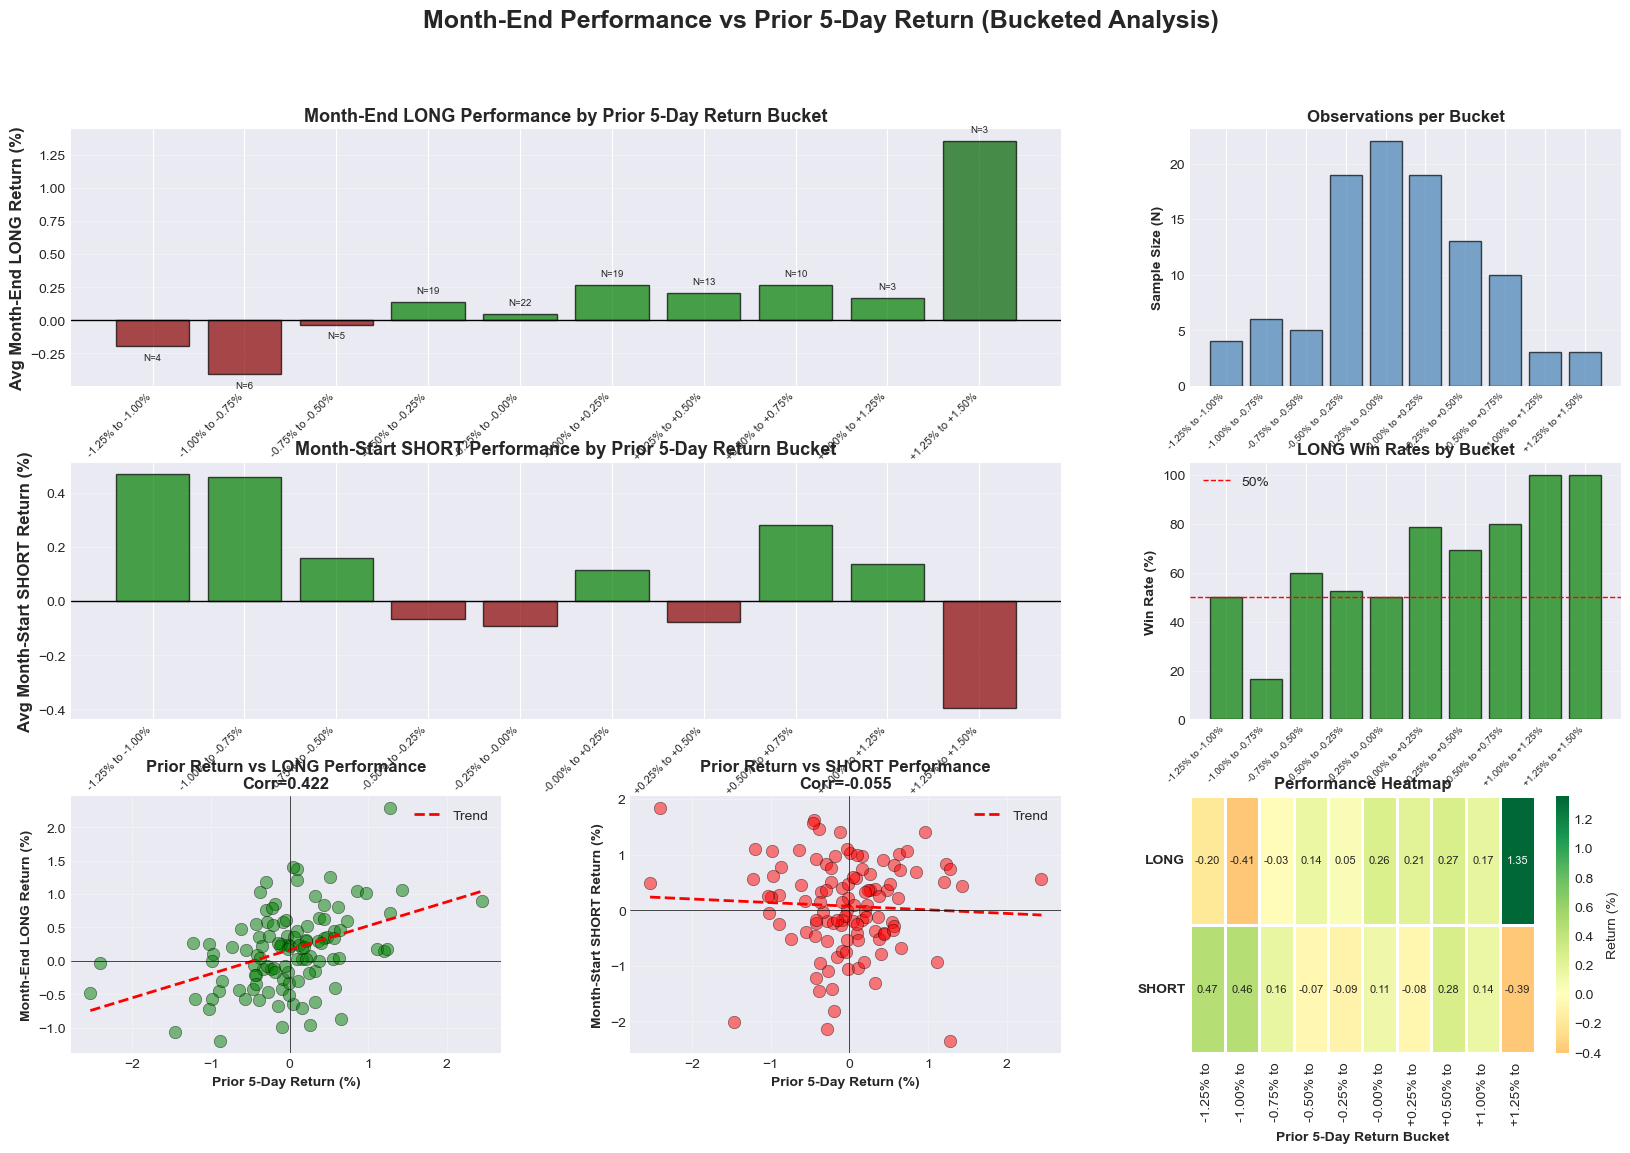

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MONTH-END BUCKETED ANALYSIS: PRIOR 5-DAY PERFORMANCE")
print("="*80)
print("\nObjective: Show how prior 5-day return predicts month-end long/short performance")
print("Buckets: 25bp increments from -2% to +2%")

# ============================================================================
# SETUP: IDENTIFY MONTH-END AND MONTH-START PERIODS
# ============================================================================
print("\n" + "-"*80)
print("IDENTIFYING MONTH-END PERIODS")
print("-"*80)

returns = features_clean['ret_1d']
price = features_clean['price']

def identify_month_periods(dates):
    """Identify month-end and month-start periods with metadata"""
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    
    periods = []
    
    for ym in df['year_month'].unique():
        month_mask = df['year_month'] == ym
        month_days = dates[month_mask]
        
        if len(month_days) >= 10:  # Need at least 10 days for 5+5
            last_5 = month_days[-5:]
            first_5_next = None
            
            # Find first 5 of next month
            next_ym = ym + 1
            next_month_mask = df['year_month'] == next_ym
            next_month_days = dates[next_month_mask]
            
            if len(next_month_days) >= 5:
                first_5_next = next_month_days[:5]
            
            periods.append({
                'year_month': str(ym),
                'month_end_start': last_5[0],
                'month_end_days': last_5,
                'month_start_days': first_5_next
            })
    
    return periods

periods = identify_month_periods(features_clean.index)

print(f"  Total periods analyzed: {len(periods)}")

# ============================================================================
# CALCULATE PRIOR 5-DAY RETURNS AND PERIOD RETURNS
# ============================================================================
print("\n" + "-"*80)
print("CALCULATING RETURNS FOR EACH PERIOD")
print("-"*80)

analysis_data = []

for period in periods:
    month_end_start = period['month_end_start']
    
    # Get prior 5-day return (before month-end starts)
    if month_end_start in features_clean.index:
        prior_5d_return = features_clean.loc[month_end_start, 'ret_5d']
    else:
        continue
    
    # Calculate month-end LONG return (last 5 days)
    month_end_days = period['month_end_days']
    month_end_rets = returns[month_end_days]
    month_end_long_return = (1 + month_end_rets).prod() - 1
    
    # Calculate month-start SHORT return (first 5 days after)
    if period['month_start_days'] is not None:
        month_start_days = period['month_start_days']
        month_start_rets = returns[month_start_days]
        month_start_market_return = (1 + month_start_rets).prod() - 1
        # For SHORT, invert the return (profit when market goes down)
        month_start_short_return = -month_start_market_return
    else:
        month_start_short_return = np.nan
    
    analysis_data.append({
        'year_month': period['year_month'],
        'month_end_start': month_end_start,
        'prior_5d_return': prior_5d_return,
        'month_end_long_return': month_end_long_return,
        'month_start_short_return': month_start_short_return
    })

analysis_df = pd.DataFrame(analysis_data)

print(f"  Periods with complete data: {len(analysis_df)}")
print(f"  Average prior 5d return: {analysis_df['prior_5d_return'].mean()*100:.3f}%")
print(f"  Average month-end long:  {analysis_df['month_end_long_return'].mean()*100:.3f}%")
print(f"  Average month-start short: {analysis_df['month_start_short_return'].mean()*100:.3f}%")

# ============================================================================
# CREATE BUCKETS (25bp increments)
# ============================================================================
print("\n" + "-"*80)
print("BUCKETING BY PRIOR 5-DAY RETURN")
print("-"*80)

# Define bucket edges (in decimal form)
bucket_edges = np.arange(-0.02, 0.0225, 0.0025)  # -2% to +2% in 0.25% increments
bucket_labels = []

for i in range(len(bucket_edges)-1):
    low = bucket_edges[i] * 100
    high = bucket_edges[i+1] * 100
    bucket_labels.append(f"{low:+.2f}% to {high:+.2f}%")

# Add extreme buckets
bucket_edges_full = [-np.inf] + list(bucket_edges) + [np.inf]
bucket_labels_full = [f"< {bucket_edges[0]*100:.2f}%"] + bucket_labels + [f"> {bucket_edges[-1]*100:.2f}%"]

# Assign each period to a bucket
analysis_df['prior_bucket'] = pd.cut(analysis_df['prior_5d_return'], 
                                      bins=bucket_edges_full,
                                      labels=bucket_labels_full)

print(f"\nTotal buckets: {len(bucket_labels_full)}")
print(f"Bucket width: 0.25% (25 basis points)")

# ============================================================================
# CALCULATE STATISTICS BY BUCKET
# ============================================================================
print("\n" + "="*80)
print("RESULTS BY PRIOR 5-DAY RETURN BUCKET")
print("="*80)

bucket_stats = []

for bucket in bucket_labels_full:
    bucket_data = analysis_df[analysis_df['prior_bucket'] == bucket]
    
    if len(bucket_data) == 0:
        continue
    
    # Long statistics
    long_returns = bucket_data['month_end_long_return'].dropna()
    n_long = len(long_returns)
    avg_long = long_returns.mean() if n_long > 0 else np.nan
    median_long = long_returns.median() if n_long > 0 else np.nan
    std_long = long_returns.std() if n_long > 0 else np.nan
    win_rate_long = (long_returns > 0).sum() / n_long * 100 if n_long > 0 else np.nan
    
    # Short statistics
    short_returns = bucket_data['month_start_short_return'].dropna()
    n_short = len(short_returns)
    avg_short = short_returns.mean() if n_short > 0 else np.nan
    median_short = short_returns.median() if n_short > 0 else np.nan
    std_short = short_returns.std() if n_short > 0 else np.nan
    win_rate_short = (short_returns > 0).sum() / n_short * 100 if n_short > 0 else np.nan
    
    # Average prior return in this bucket
    avg_prior = bucket_data['prior_5d_return'].mean()
    
    bucket_stats.append({
        'Bucket': bucket,
        'Avg_Prior_5d': avg_prior * 100,
        'N': n_long,
        'Long_Avg_%': avg_long * 100,
        'Long_Median_%': median_long * 100,
        'Long_Std_%': std_long * 100,
        'Long_WinRate_%': win_rate_long,
        'Short_Avg_%': avg_short * 100,
        'Short_Median_%': median_short * 100,
        'Short_Std_%': std_short * 100,
        'Short_WinRate_%': win_rate_short
    })

bucket_stats_df = pd.DataFrame(bucket_stats)

# Display full table
print(f"\n{'Prior 5d Bucket':<20s} {'N':>4s} {'Avg5d':>8s} {'Long':>8s} {'LongWR':>8s} {'Short':>8s} {'ShortWR':>9s}")
print("-"*80)

for _, row in bucket_stats_df.iterrows():
    if row['N'] > 0:
        print(f"{row['Bucket']:<20s} {row['N']:>4.0f} {row['Avg_Prior_5d']:>7.2f}% "
              f"{row['Long_Avg_%']:>7.3f}% {row['Long_WinRate_%']:>7.1f}% "
              f"{row['Short_Avg_%']:>7.3f}% {row['Short_WinRate_%']:>8.1f}%")

# ============================================================================
# STATISTICAL ANALYSIS
# ============================================================================
print("\n" + "-"*80)
print("STATISTICAL ANALYSIS")
print("-"*80)

# Correlation between prior return and subsequent returns
corr_long = analysis_df['prior_5d_return'].corr(analysis_df['month_end_long_return'])
corr_short = analysis_df['prior_5d_return'].corr(analysis_df['month_start_short_return'])

print(f"\nCorrelation Analysis:")
print(f"  Prior 5d vs Month-End LONG:   {corr_long:+.3f}")
print(f"  Prior 5d vs Month-Start SHORT: {corr_short:+.3f}")

if abs(corr_long) > 0.2:
    direction = "positive" if corr_long > 0 else "negative"
    print(f"  → Moderate {direction} correlation for LONG")
elif abs(corr_long) < 0.1:
    print(f"  → Weak/no correlation for LONG")

if abs(corr_short) > 0.2:
    direction = "positive" if corr_short > 0 else "negative"
    print(f"  → Moderate {direction} correlation for SHORT")
elif abs(corr_short) < 0.1:
    print(f"  → Weak/no correlation for SHORT")

# Compare extreme buckets
extreme_negative = analysis_df[analysis_df['prior_5d_return'] < -0.01]['month_end_long_return']
extreme_positive = analysis_df[analysis_df['prior_5d_return'] > 0.01]['month_end_long_return']

if len(extreme_negative) > 3 and len(extreme_positive) > 3:
    t_stat, p_val = stats.ttest_ind(extreme_positive, extreme_negative)
    
    print(f"\nExtreme Comparison (LONG side):")
    print(f"  After >+1% rally: {extreme_positive.mean()*100:>6.3f}% (N={len(extreme_positive)})")
    print(f"  After <-1% drop:  {extreme_negative.mean()*100:>6.3f}% (N={len(extreme_negative)})")
    print(f"  Difference:       {(extreme_positive.mean() - extreme_negative.mean())*100:+.3f}%")
    print(f"  p-value:          {p_val:.4f} {'**' if p_val < 0.05 else ''}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle('Month-End Performance vs Prior 5-Day Return (Bucketed Analysis)',
             fontsize=18, fontweight='bold')

# Plot 1: Long performance by bucket
ax1 = fig.add_subplot(gs[0, :2])

# Filter out buckets with N < 3
plot_data_long = bucket_stats_df[bucket_stats_df['N'] >= 3].copy()

x_pos = np.arange(len(plot_data_long))
colors = ['darkred' if val < 0 else 'darkgreen' if val > 0.5 else 'green' if val > 0 else 'gray' 
          for val in plot_data_long['Long_Avg_%']]

bars = ax1.bar(x_pos, plot_data_long['Long_Avg_%'], color=colors, alpha=0.7, edgecolor='black')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(plot_data_long['Bucket'], rotation=45, ha='right', fontsize=8)
ax1.set_ylabel('Avg Month-End LONG Return (%)', fontweight='bold', fontsize=12)
ax1.set_title('Month-End LONG Performance by Prior 5-Day Return Bucket', fontweight='bold', fontsize=13)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.grid(True, alpha=0.3, axis='y')

# Add sample size labels
for i, (bar, n) in enumerate(zip(bars, plot_data_long['N'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05 if height > 0 else height - 0.05,
            f'N={n:.0f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=7)

# Plot 2: Sample size distribution
ax2 = fig.add_subplot(gs[0, 2])
ax2.bar(x_pos, plot_data_long['N'], color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(plot_data_long['Bucket'], rotation=45, ha='right', fontsize=7)
ax2.set_ylabel('Sample Size (N)', fontweight='bold')
ax2.set_title('Observations per Bucket', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Short performance by bucket
ax3 = fig.add_subplot(gs[1, :2])

plot_data_short = bucket_stats_df[bucket_stats_df['N'] >= 3].copy()

colors_short = ['darkgreen' if val > 0.5 else 'green' if val > 0 else 'darkred' if val < 0 else 'gray'
                for val in plot_data_short['Short_Avg_%']]

bars = ax3.bar(x_pos, plot_data_short['Short_Avg_%'], color=colors_short, alpha=0.7, edgecolor='black')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(plot_data_short['Bucket'], rotation=45, ha='right', fontsize=8)
ax3.set_ylabel('Avg Month-Start SHORT Return (%)', fontweight='bold', fontsize=12)
ax3.set_title('Month-Start SHORT Performance by Prior 5-Day Return Bucket', fontweight='bold', fontsize=13)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Win rates - Long
ax4 = fig.add_subplot(gs[1, 2])
ax4.bar(x_pos, plot_data_long['Long_WinRate_%'], color='green', alpha=0.7, edgecolor='black')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(plot_data_long['Bucket'], rotation=45, ha='right', fontsize=7)
ax4.set_ylabel('Win Rate (%)', fontweight='bold')
ax4.set_title('LONG Win Rates by Bucket', fontweight='bold')
ax4.axhline(y=50, color='red', linestyle='--', linewidth=1, label='50%')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Scatter - Prior 5d vs Long return
ax5 = fig.add_subplot(gs[2, 0])
ax5.scatter(analysis_df['prior_5d_return'] * 100, 
           analysis_df['month_end_long_return'] * 100,
           alpha=0.5, s=80, color='green', edgecolor='black', linewidth=0.5)

# Add regression line
if len(analysis_df) > 5:
    z = np.polyfit(analysis_df['prior_5d_return'].dropna(), 
                   analysis_df['month_end_long_return'].dropna(), 1)
    p = np.poly1d(z)
    x_line = np.linspace(analysis_df['prior_5d_return'].min(), 
                        analysis_df['prior_5d_return'].max(), 100)
    ax5.plot(x_line * 100, p(x_line) * 100, "r--", linewidth=2, label='Trend')

ax5.set_xlabel('Prior 5-Day Return (%)', fontweight='bold')
ax5.set_ylabel('Month-End LONG Return (%)', fontweight='bold')
ax5.set_title(f'Prior Return vs LONG Performance\nCorr={corr_long:.3f}', fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax5.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax5.legend()

# Plot 6: Scatter - Prior 5d vs Short return
ax6 = fig.add_subplot(gs[2, 1])
ax6.scatter(analysis_df['prior_5d_return'] * 100,
           analysis_df['month_start_short_return'] * 100,
           alpha=0.5, s=80, color='red', edgecolor='black', linewidth=0.5)

# Add regression line
if len(analysis_df.dropna()) > 5:
    valid_data = analysis_df[['prior_5d_return', 'month_start_short_return']].dropna()
    if len(valid_data) > 5:
        z = np.polyfit(valid_data['prior_5d_return'], valid_data['month_start_short_return'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(valid_data['prior_5d_return'].min(),
                            valid_data['prior_5d_return'].max(), 100)
        ax6.plot(x_line * 100, p(x_line) * 100, "r--", linewidth=2, label='Trend')

ax6.set_xlabel('Prior 5-Day Return (%)', fontweight='bold')
ax6.set_ylabel('Month-Start SHORT Return (%)', fontweight='bold')
ax6.set_title(f'Prior Return vs SHORT Performance\nCorr={corr_short:.3f}', fontweight='bold')
ax6.grid(True, alpha=0.3)
ax6.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax6.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax6.legend()

# Plot 7: Heatmap - Combined view
ax7 = fig.add_subplot(gs[2, 2])

# Create matrix for heatmap
heatmap_data = plot_data_long[['Long_Avg_%', 'Short_Avg_%']].T
heatmap_data.columns = [b[:10] for b in plot_data_long['Bucket']]

sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
           cbar_kws={'label': 'Return (%)'}, ax=ax7, linewidths=1,
           annot_kws={'fontsize': 8})
ax7.set_yticklabels(['LONG', 'SHORT'], rotation=0, fontsize=10, fontweight='bold')
ax7.set_xlabel('Prior 5-Day Return Bucket', fontweight='bold', fontsize=10)
ax7.set_title('Performance Heatmap', fontweight='bold')

plt.savefig('month_end_bucketed_analysis.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: month_end_bucketed_analysis.png")

# ============================================================================
# KEY INSIGHTS
# ============================================================================
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# Find best/worst buckets for long
best_long_bucket = bucket_stats_df.nlargest(1, 'Long_Avg_%').iloc[0]
worst_long_bucket = bucket_stats_df.nsmallest(1, 'Long_Avg_%').iloc[0]

print("\n📊 LONG SIDE (Last 5 Days):")
print(f"  Best Bucket:  {best_long_bucket['Bucket']}")
print(f"    Avg Return: {best_long_bucket['Long_Avg_%']:.3f}%")
print(f"    Win Rate:   {best_long_bucket['Long_WinRate_%']:.1f}%")
print(f"    N:          {best_long_bucket['N']:.0f}")

print(f"\n  Worst Bucket: {worst_long_bucket['Bucket']}")
print(f"    Avg Return: {worst_long_bucket['Long_Avg_%']:.3f}%")
print(f"    Win Rate:   {worst_long_bucket['Long_WinRate_%']:.1f}%")
print(f"    N:          {worst_long_bucket['N']:.0f}")

# Find best/worst for short
valid_short = bucket_stats_df.dropna(subset=['Short_Avg_%'])
if len(valid_short) > 0:
    best_short_bucket = valid_short.nlargest(1, 'Short_Avg_%').iloc[0]
    worst_short_bucket = valid_short.nsmallest(1, 'Short_Avg_%').iloc[0]
    
    print("\n📊 SHORT SIDE (First 5 Days After):")
    print(f"  Best Bucket:  {best_short_bucket['Bucket']}")
    print(f"    Avg Return: {best_short_bucket['Short_Avg_%']:.3f}%")
    print(f"    Win Rate:   {best_short_bucket['Short_WinRate_%']:.1f}%")
    
    print(f"\n  Worst Bucket: {worst_short_bucket['Bucket']}")
    print(f"    Avg Return: {worst_short_bucket['Short_Avg_%']:.3f}%")
    print(f"    Win Rate:   {worst_short_bucket['Short_WinRate_%']:.1f}%")

# ============================================================================
# PATTERN IDENTIFICATION
# ============================================================================
print("\n" + "-"*80)
print("PATTERN IDENTIFICATION")
print("-"*80)

print("\nLooking for non-linear patterns...")

# Check if there's a sweet spot or monotonic relationship
long_by_bucket = bucket_stats_df.sort_values('Avg_Prior_5d')['Long_Avg_%'].values

# Simple trend check
if len(long_by_bucket) > 5:
    first_third_avg = long_by_bucket[:len(long_by_bucket)//3].mean()
    last_third_avg = long_by_bucket[-len(long_by_bucket)//3:].mean()
    
    if last_third_avg > first_third_avg + 0.2:
        print("  → POSITIVE MONOTONIC: Stronger prior returns → better month-end longs")
        print("    Interpretation: Momentum continuation into month-end")
    elif last_third_avg < first_third_avg - 0.2:
        print("  → NEGATIVE MONOTONIC: Weaker prior returns → better month-end longs")
        print("    Interpretation: Mean reversion / dip buying at month-end")
    else:
        print("  → NO CLEAR MONOTONIC TREND: Relationship is flat or non-linear")

# Check for U-shape or inverted-U
middle_avg = long_by_bucket[len(long_by_bucket)//3 : 2*len(long_by_bucket)//3].mean()

if middle_avg > first_third_avg + 0.2 and middle_avg > last_third_avg + 0.2:
    print("  → INVERTED-U SHAPE: Moderate prior returns have best month-end performance")
elif middle_avg < first_third_avg - 0.2 and middle_avg < last_third_avg - 0.2:
    print("  → U-SHAPE: Extremes (very positive or very negative) have best performance")

# ============================================================================
# RECOMMENDED LEVERAGE SCHEME
# ============================================================================
print("\n" + "="*80)
print("LEVERAGE SCHEME OPTIMIZATION")
print("="*80)

print("\nBased on the data, optimal leverage scheme:")

# Find which buckets have best Sharpe-equivalent (return/std)
bucket_stats_df['Long_Sharpe_Proxy'] = bucket_stats_df['Long_Avg_%'] / bucket_stats_df['Long_Std_%']

high_quality = bucket_stats_df[bucket_stats_df['Long_Sharpe_Proxy'] > 
                                bucket_stats_df['Long_Sharpe_Proxy'].median()]

print("\nHigh-Quality Buckets (above-median risk-adjusted returns):")
for _, row in high_quality.head(5).iterrows():
    print(f"  {row['Bucket']:<20s} Long: {row['Long_Avg_%']:>6.3f}% (Sharpe proxy: {row['Long_Sharpe_Proxy']:.2f})")

print("\n💡 RECOMMENDATION:")
print("  Increase leverage (3x → 4x) when prior 5-day return in:")
for _, row in high_quality.head(3).iterrows():
    print(f"    - {row['Bucket']}")

print("\n  Reduce leverage (3x → 2x) when prior 5-day return in:")
low_quality = bucket_stats_df.nsmallest(3, 'Long_Sharpe_Proxy')
for _, row in low_quality.iterrows():
    print(f"    - {row['Bucket']}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Export detailed table
print("\nFull bucketed data available in: bucket_stats_df")

bucket_stats_df

PORTFOLIO BACKTEST: CONDITIONAL MONTH-END LEVERAGE

Portfolio: 50% Tiered MA Cross + 50% Conditional Month-End

Month-End LONG Conditional Logic:
  Prior 5-day return < 0%  → 2x leverage
  Prior 5-day return >= 0% → 3x leverage

Month-End SHORT: Always 3x (unchanged)

--------------------------------------------------------------------------------
STRATEGY 1: TIERED MA CROSS 20/50
--------------------------------------------------------------------------------
  Days at 3x: 1277
  Days at 2x: 958
  Days at 0x: 94

--------------------------------------------------------------------------------
STRATEGY 2: CONDITIONAL MONTH-END LONG/SHORT
--------------------------------------------------------------------------------
  Base Month-End:
    Long 3x:  552 days
    Short 3x: 552 days

  Conditional Month-End:
    Long 2x:  297 days
    Long 3x:  255 days
    Short 3x: 555 days

--------------------------------------------------------------------------------
COMBINED PORTFOLIOS
------------

Strategy    Sharpe  Annual_Return_%   Max_DD_%    Calmar
0              Tiered_MA  0.791544        10.708127 -14.696218  0.728631
1          MonthEnd_Base  1.027120        11.692288  -9.233019  1.266356
2   MonthEnd_Conditional  1.047628        11.039353  -9.233019  1.195639
3         Portfolio_Base  1.372079        11.666373  -7.958990  1.465811
4  Portfolio_Conditional  1.362014        11.306924  -7.924409  1.426848

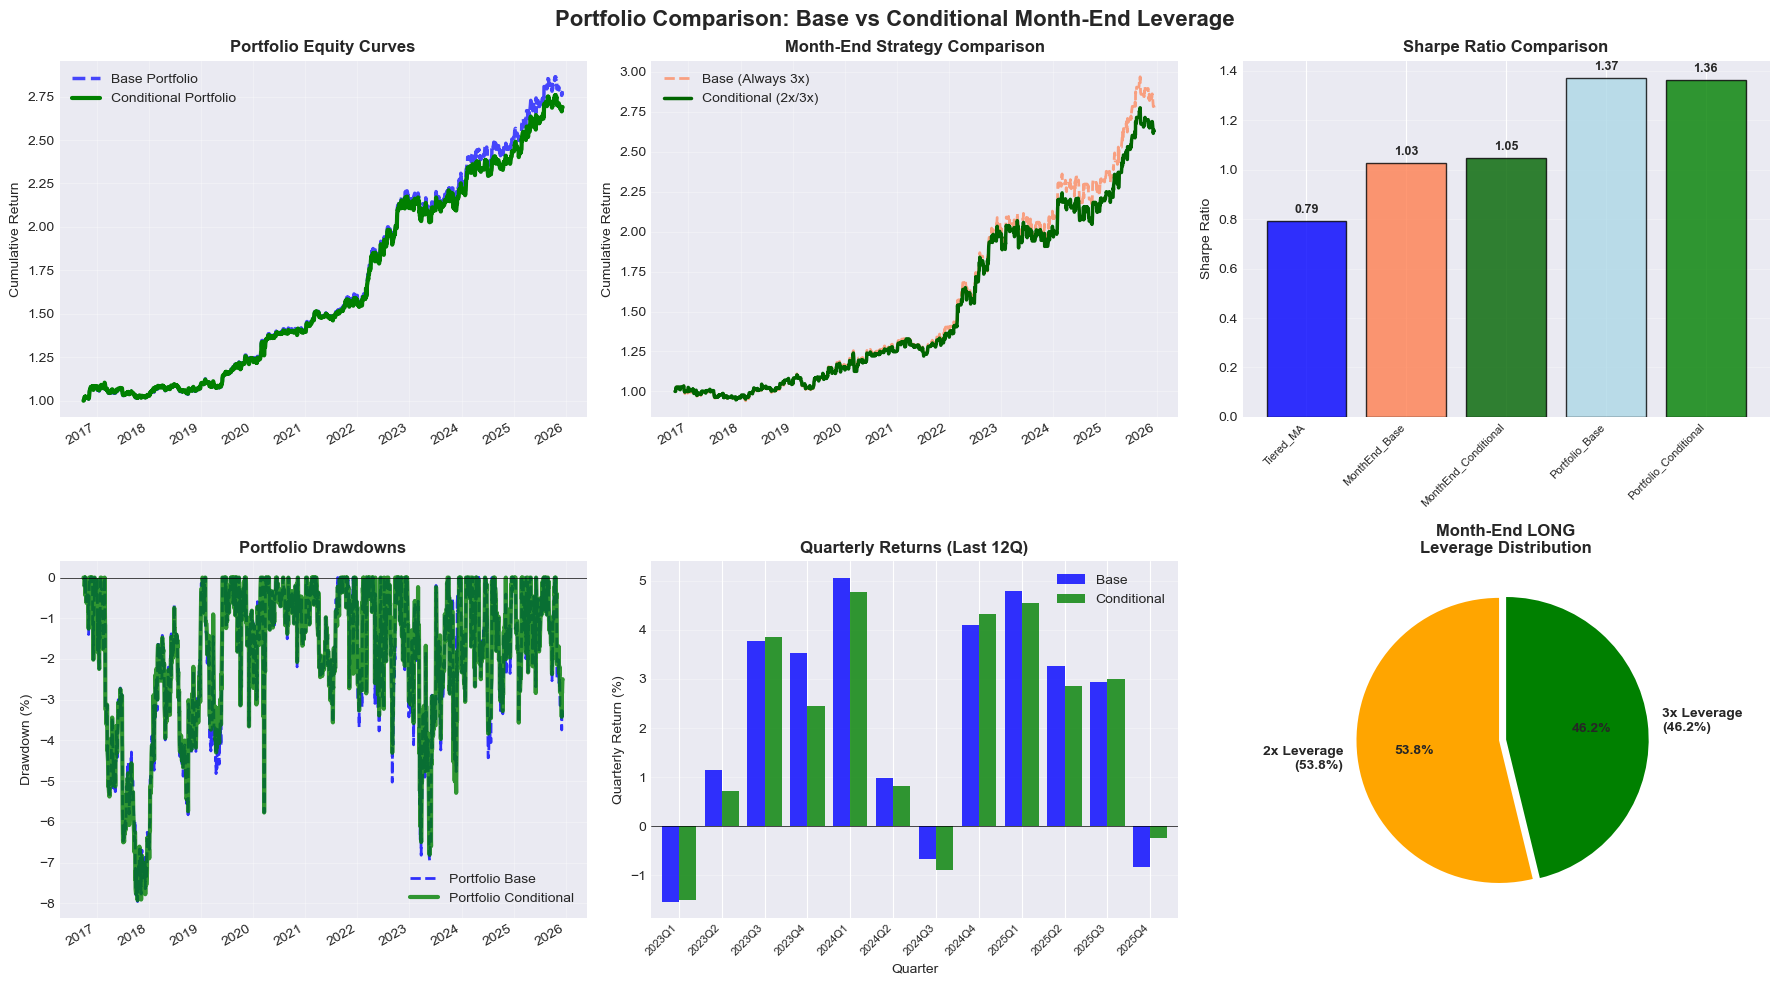

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PORTFOLIO BACKTEST: CONDITIONAL MONTH-END LEVERAGE")
print("="*80)
print("\nPortfolio: 50% Tiered MA Cross + 50% Conditional Month-End")
print("\nMonth-End LONG Conditional Logic:")
print("  Prior 5-day return < 0%  → 2x leverage")
print("  Prior 5-day return >= 0% → 3x leverage")
print("\nMonth-End SHORT: Always 3x (unchanged)")

# ============================================================================
# SETUP
# ============================================================================

returns = features_clean['ret_1d']
price = features_clean['price']
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']

# ============================================================================
# STRATEGY 1: TIERED MA CROSS (unchanged from before)
# ============================================================================
print("\n" + "-"*80)
print("STRATEGY 1: TIERED MA CROSS 20/50")
print("-"*80)

# Base direction
signal_ma_base = pd.Series(0, index=features_clean.index)
signal_ma_base[ma20 > ma50] = 1
signal_ma_base[ma20 < ma50] = -1

# Filter conditions
price_ma_distance = abs(price - ma20) / price
filter_8_pass = price_ma_distance >= 0.001

ty_spx_corr = features_clean['ty_spx_corr_20d']
filter_19_pass = ty_spx_corr <= 0

# Tiered leverage
signal_tiered = signal_ma_base.copy().astype(float)

both_pass = filter_8_pass & filter_19_pass
one_passes = (filter_8_pass & ~filter_19_pass) | (~filter_8_pass & filter_19_pass)
both_fail = ~filter_8_pass & ~filter_19_pass

signal_tiered[both_pass] = signal_ma_base[both_pass] * 3.0
signal_tiered[one_passes] = signal_ma_base[one_passes] * 2.0
signal_tiered[both_fail] = 0.0

print(f"  Days at 3x: {(signal_tiered.abs() == 3).sum()}")
print(f"  Days at 2x: {(signal_tiered.abs() == 2).sum()}")
print(f"  Days at 0x: {(signal_tiered == 0).sum()}")

# ============================================================================
# STRATEGY 2: CONDITIONAL MONTH-END
# ============================================================================
print("\n" + "-"*80)
print("STRATEGY 2: CONDITIONAL MONTH-END LONG/SHORT")
print("-"*80)

def identify_month_end_days_with_start(dates):
    """Identify last 5 days and track start date"""
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    
    month_end_mapping = {}
    
    for ym in df['year_month'].unique():
        month_mask = df['year_month'] == ym
        month_days = dates[month_mask]
        
        if len(month_days) >= 5:
            last_5 = month_days[-5:]
            start_date = last_5[0]
            
            for day in last_5:
                month_end_mapping[day] = start_date
    
    return month_end_mapping

def identify_month_start_days(dates):
    """First 5 days"""
    signal = pd.Series(0, index=dates)
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    
    for ym in df['year_month'].unique():
        month_mask = df['year_month'] == ym
        month_days_idx = df[month_mask].index
        
        if len(month_days_idx) >= 5:
            signal.iloc[month_days_idx[:5]] = 1
    
    return signal

month_end_mapping = identify_month_end_days_with_start(features_clean.index)
month_start_signal = identify_month_start_days(features_clean.index)

# Create BASE month-end signal (always 3x)
signal_month_end_base = pd.Series(0.0, index=features_clean.index)

for day in month_end_mapping.keys():
    signal_month_end_base[day] = 3.0

signal_month_end_base = signal_month_end_base - (month_start_signal * 3.0)

# Create CONDITIONAL month-end signal (2x or 3x based on prior 5d)
signal_month_end_conditional = pd.Series(0.0, index=features_clean.index)

for day, start_date in month_end_mapping.items():
    if start_date in features_clean.index:
        # Get prior 5-day return at the START of the month-end period
        prior_5d = features_clean.loc[start_date, 'ret_5d']
        
        if prior_5d < 0:
            leverage = 2.0  # Negative momentum
        else:
            leverage = 3.0  # Positive momentum
        
        signal_month_end_conditional[day] = leverage

signal_month_end_conditional = signal_month_end_conditional - (month_start_signal * 3.0)

print(f"  Base Month-End:")
print(f"    Long 3x:  {(signal_month_end_base > 0).sum()} days")
print(f"    Short 3x: {(signal_month_end_base < 0).sum()} days")

print(f"\n  Conditional Month-End:")
print(f"    Long 2x:  {(signal_month_end_conditional == 2).sum()} days")
print(f"    Long 3x:  {(signal_month_end_conditional == 3).sum()} days")
print(f"    Short 3x: {(signal_month_end_conditional < 0).sum()} days")

# ============================================================================
# COMBINED PORTFOLIOS
# ============================================================================
print("\n" + "-"*80)
print("COMBINED PORTFOLIOS")
print("-"*80)

# Portfolio 1: Tiered MA + Base Month-End (50/50)
signal_portfolio_base = (signal_tiered * 0.5) + (signal_month_end_base * 0.5)

# Portfolio 2: Tiered MA + Conditional Month-End (50/50)
signal_portfolio_conditional = (signal_tiered * 0.5) + (signal_month_end_conditional * 0.5)

print("Portfolio 1 (Base Month-End):")
print(f"  50% Tiered MA + 50% Base Month-End (always 3x)")

print("\nPortfolio 2 (Conditional Month-End):")
print(f"  50% Tiered MA + 50% Conditional Month-End (2x/3x)")

# ============================================================================
# BACKTEST ALL STRATEGIES
# ============================================================================
print("\n" + "-"*80)
print("BACKTESTING")
print("-"*80)

def backtest_strategy(signal, returns, name):
    """Complete backtest"""
    strat_returns = signal.shift(1) * returns
    strat_returns = strat_returns.dropna()
    
    if len(strat_returns) == 0:
        return None
    
    total_ret = (1 + strat_returns).prod() - 1
    n_years = len(strat_returns) / 252
    ann_ret = (1 + total_ret) ** (1/n_years) - 1
    ann_vol = strat_returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    downside = strat_returns[strat_returns < 0]
    downside_vol = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_ret / downside_vol if downside_vol > 0 else 0
    
    cum = (1 + strat_returns).cumprod()
    running_max = cum.expanding().max()
    dd = (cum - running_max) / running_max
    max_dd = dd.min()
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0
    
    win_rate = (strat_returns > 0).sum() / len(strat_returns)
    
    return {
        'Strategy': name,
        'Total_Return_%': total_ret * 100,
        'Annual_Return_%': ann_ret * 100,
        'Annual_Vol_%': ann_vol * 100,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max_DD_%': max_dd * 100,
        'Calmar': calmar,
        'Win_Rate_%': win_rate * 100,
        'Returns': strat_returns,
        'Equity': cum
    }

strategies = {
    'Tiered_MA': signal_tiered,
    'MonthEnd_Base': signal_month_end_base,
    'MonthEnd_Conditional': signal_month_end_conditional,
    'Portfolio_Base': signal_portfolio_base,
    'Portfolio_Conditional': signal_portfolio_conditional
}

results = []
for name, sig in strategies.items():
    result = backtest_strategy(sig, returns, name)
    if result:
        results.append(result)
        print(f"  ✓ {name}")

results_df = pd.DataFrame(results)

# ============================================================================
# PERFORMANCE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

print(f"\n{'Strategy':<25s} {'Sharpe':>7s} {'AnnRet':>8s} {'AnnVol':>8s} {'MaxDD':>8s} {'Calmar':>7s} {'WinRate':>8s}")
print("-"*85)

for _, row in results_df.iterrows():
    print(f"{row['Strategy']:<25s} {row['Sharpe']:>7.2f} {row['Annual_Return_%']:>7.2f}% "
          f"{row['Annual_Vol_%']:>7.2f}% {row['Max_DD_%']:>7.2f}% "
          f"{row['Calmar']:>7.2f} {row['Win_Rate_%']:>7.1f}%")

# ============================================================================
# IMPROVEMENT ANALYSIS
# ============================================================================
print("\n" + "-"*80)
print("IMPROVEMENT ANALYSIS")
print("-"*80)

base_me = results_df[results_df['Strategy'] == 'MonthEnd_Base'].iloc[0]
cond_me = results_df[results_df['Strategy'] == 'MonthEnd_Conditional'].iloc[0]
base_port = results_df[results_df['Strategy'] == 'Portfolio_Base'].iloc[0]
cond_port = results_df[results_df['Strategy'] == 'Portfolio_Conditional'].iloc[0]

print("\nMonth-End Strategy (standalone):")
print(f"  Base (always 3x):")
print(f"    Sharpe: {base_me['Sharpe']:.2f}")
print(f"    Annual: {base_me['Annual_Return_%']:.2f}%")
print(f"    MaxDD:  {base_me['Max_DD_%']:.2f}%")

print(f"\n  Conditional (2x/3x):")
print(f"    Sharpe: {cond_me['Sharpe']:.2f}")
print(f"    Annual: {cond_me['Annual_Return_%']:.2f}%")
print(f"    MaxDD:  {cond_me['Max_DD_%']:.2f}%")

print(f"\n  Improvement: {cond_me['Sharpe'] - base_me['Sharpe']:+.2f} Sharpe")

print("\n" + "-"*50)
print("\nCombined Portfolio (50% Tiered MA + 50% Month-End):")
print(f"  With Base Month-End:")
print(f"    Sharpe: {base_port['Sharpe']:.2f}")
print(f"    Annual: {base_port['Annual_Return_%']:.2f}%")
print(f"    MaxDD:  {base_port['Max_DD_%']:.2f}%")

print(f"\n  With Conditional Month-End:")
print(f"    Sharpe: {cond_port['Sharpe']:.2f}")
print(f"    Annual: {cond_port['Annual_Return_%']:.2f}%")
print(f"    MaxDD:  {cond_port['Max_DD_%']:.2f}%")

print(f"\n  Portfolio Improvement: {cond_port['Sharpe'] - base_port['Sharpe']:+.2f} Sharpe")

# ============================================================================
# QUARTERLY COMPARISON
# ============================================================================
print("\n" + "-"*80)
print("QUARTERLY COMPARISON")
print("-"*80)

def calculate_quarterly(signal, returns):
    """Quarterly returns"""
    strat_ret = signal.shift(1) * returns
    df = pd.DataFrame({
        'return': strat_ret,
        'year': strat_ret.index.year,
        'quarter': strat_ret.index.quarter
    })
    quarterly = df.groupby(['year', 'quarter'])['return'].apply(lambda x: (1 + x).prod() - 1)
    quarterly.index = [f"{y}Q{q}" for y, q in quarterly.index]
    return quarterly * 100

quarterly_base = calculate_quarterly(signal_portfolio_base, returns)
quarterly_cond = calculate_quarterly(signal_portfolio_conditional, returns)

quarterly_comp = pd.DataFrame({
    'Base_Portfolio_%': quarterly_base,
    'Conditional_Portfolio_%': quarterly_cond,
    'Difference_%': quarterly_cond - quarterly_base
})

print(f"\n{'Quarter':<10s} {'Base_Port':>12s} {'Cond_Port':>12s} {'Difference':>12s}")
print("-"*55)

for quarter, row in quarterly_comp.tail(12).iterrows():
    diff_marker = "  ✓" if row['Difference_%'] > 0 else "  ✗" if row['Difference_%'] < -0.5 else ""
    print(f"{quarter:<10s} {row['Base_Portfolio_%']:>11.2f}% {row['Conditional_Portfolio_%']:>11.2f}% "
          f"{row['Difference_%']:>11.2f}%{diff_marker}")

# ============================================================================
# MONTHLY LEVERAGE DISTRIBUTION
# ============================================================================
print("\n" + "-"*80)
print("MONTH-END LONG LEVERAGE ANALYSIS")
print("-"*80)

# Count how often each leverage is used
leverage_2x_count = (signal_month_end_conditional == 2).sum()
leverage_3x_count = (signal_month_end_conditional == 3).sum()
total_long_days = leverage_2x_count + leverage_3x_count

print(f"\nLeverage Distribution (Long Side):")
print(f"  2x: {leverage_2x_count} days ({leverage_2x_count/total_long_days*100:.1f}%)")
print(f"  3x: {leverage_3x_count} days ({leverage_3x_count/total_long_days*100:.1f}%)")

# Average prior 5-day return for each
prior_5d_when_2x = []
prior_5d_when_3x = []

for day, start_date in month_end_mapping.items():
    if start_date in features_clean.index:
        prior_5d = features_clean.loc[start_date, 'ret_5d']
        
        if signal_month_end_conditional[day] == 2.0:
            prior_5d_when_2x.append(prior_5d)
        elif signal_month_end_conditional[day] == 3.0:
            prior_5d_when_3x.append(prior_5d)

if len(prior_5d_when_2x) > 0:
    print(f"\n  Avg prior 5d when using 2x: {np.mean(prior_5d_when_2x)*100:+.2f}%")
if len(prior_5d_when_3x) > 0:
    print(f"  Avg prior 5d when using 3x: {np.mean(prior_5d_when_3x)*100:+.2f}%")

# Performance by leverage level
long_only_2x = returns[(signal_month_end_conditional.shift(1) == 2)]  * 2
long_only_3x = returns[(signal_month_end_conditional.shift(1) == 3)] * 3

print(f"\n  Performance by Leverage:")
print(f"    2x LONG: Avg = {long_only_2x.mean()*252*100:>6.2f}% annual, N = {len(long_only_2x)}")
print(f"    3x LONG: Avg = {long_only_3x.mean()*252*100:>6.2f}% annual, N = {len(long_only_3x)}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Portfolio Comparison: Base vs Conditional Month-End Leverage',
             fontsize=16, fontweight='bold')

# Plot 1: Equity curves - Portfolios
ax = axes[0, 0]
results_df[results_df['Strategy'] == 'Portfolio_Base'].iloc[0]['Equity'].plot(
    ax=ax, label='Base Portfolio', linewidth=2.5, color='blue', linestyle='--', alpha=0.7)
results_df[results_df['Strategy'] == 'Portfolio_Conditional'].iloc[0]['Equity'].plot(
    ax=ax, label='Conditional Portfolio', linewidth=3, color='green')
ax.set_title('Portfolio Equity Curves', fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot 2: Equity curves - Month-End only
ax = axes[0, 1]
results_df[results_df['Strategy'] == 'MonthEnd_Base'].iloc[0]['Equity'].plot(
    ax=ax, label='Base (Always 3x)', linewidth=2, color='coral', linestyle='--', alpha=0.7)
results_df[results_df['Strategy'] == 'MonthEnd_Conditional'].iloc[0]['Equity'].plot(
    ax=ax, label='Conditional (2x/3x)', linewidth=2.5, color='darkgreen')
ax.set_title('Month-End Strategy Comparison', fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot 3: Sharpe comparison
ax = axes[0, 2]
sharpes = results_df.set_index('Strategy')['Sharpe']
colors_sharpe = ['blue', 'coral', 'darkgreen', 'lightblue', 'green']
bars = ax.bar(range(len(sharpes)), sharpes, color=colors_sharpe, alpha=0.8, edgecolor='black')
ax.set_xticks(range(len(sharpes)))
ax.set_xticklabels(sharpes.index, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio Comparison', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, sharpes):
    ax.text(bar.get_x() + bar.get_width()/2., val + 0.02,
           f'{val:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 4: Drawdowns - Portfolios
ax = axes[1, 0]
for strat_name, color, linestyle, linewidth in [
    ('Portfolio_Base', 'blue', '--', 2),
    ('Portfolio_Conditional', 'green', '-', 3)
]:
    strat = results_df[results_df['Strategy'] == strat_name].iloc[0]
    cum = strat['Equity']
    dd = ((cum - cum.expanding().max()) / cum.expanding().max()) * 100
    dd.plot(ax=ax, label=strat_name.replace('_', ' '), color=color, 
           linestyle=linestyle, linewidth=linewidth, alpha=0.8)

ax.set_title('Portfolio Drawdowns', fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 5: Quarterly returns
ax = axes[1, 1]
quarterly_comp[['Base_Portfolio_%', 'Conditional_Portfolio_%']].tail(12).plot(
    kind='bar', ax=ax, color=['blue', 'green'], alpha=0.8, width=0.8)
ax.set_title('Quarterly Returns (Last 12Q)', fontweight='bold')
ax.set_ylabel('Quarterly Return (%)')
ax.set_xlabel('Quarter')
ax.legend(['Base', 'Conditional'], loc='best')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

# Plot 6: Leverage distribution pie
ax = axes[1, 2]
sizes = [leverage_2x_count, leverage_3x_count]
labels = [f'2x Leverage\n({leverage_2x_count/total_long_days*100:.1f}%)',
          f'3x Leverage\n({leverage_3x_count/total_long_days*100:.1f}%)']
colors_pie = ['orange', 'green']

ax.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%',
       startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'},
       explode=[0.05, 0])
ax.set_title('Month-End LONG\nLeverage Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig('portfolio_conditional_monthend_2x3x.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: portfolio_conditional_monthend_2x3x.png")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

best_portfolio = results_df[results_df['Strategy'].str.contains('Portfolio')].nlargest(1, 'Sharpe').iloc[0]

print(f"\n🏆 BEST PORTFOLIO: {best_portfolio['Strategy']}")
print(f"   Sharpe Ratio:    {best_portfolio['Sharpe']:.2f}")
print(f"   Annual Return:   {best_portfolio['Annual_Return_%']:.2f}%")
print(f"   Annual Vol:      {best_portfolio['Annual_Vol_%']:.2f}%")
print(f"   Max Drawdown:    {best_portfolio['Max_DD_%']:.2f}%")
print(f"   Calmar Ratio:    {best_portfolio['Calmar']:.2f}")

sharpe_improvement = cond_port['Sharpe'] - base_port['Sharpe']

if sharpe_improvement > 0.05:
    print(f"\n✓✓ STRONG RECOMMENDATION: Use Conditional Month-End")
    print(f"   Sharpe improvement: {sharpe_improvement:+.2f}")
elif sharpe_improvement > 0:
    print(f"\n✓ RECOMMENDATION: Use Conditional Month-End")
    print(f"   Sharpe improvement: {sharpe_improvement:+.2f}")
else:
    print(f"\n→ RECOMMENDATION: Stick with Base Month-End")
    print(f"   Conditional doesn't add value: {sharpe_improvement:+.2f}")

print("\n📋 FINAL PORTFOLIO COMPOSITION:")
if best_portfolio['Strategy'] == 'Portfolio_Conditional':
    print("  50% - Tiered MA Cross 20/50 (0x/2x/3x based on filters)")
    print("  50% - Month-End Long/Short:")
    print("         LONG: 2x if prior 5d < 0%, 3x if prior 5d >= 0%")
    print("         SHORT: Always 3x (first 5 days)")
else:
    print("  50% - Tiered MA Cross 20/50 (0x/2x/3x based on filters)")
    print("  50% - Month-End Long/Short:")
    print("         LONG: Always 3x (last 5 days)")
    print("         SHORT: Always 3x (first 5 days)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Return comparison
results_df[['Strategy', 'Sharpe', 'Annual_Return_%', 'Max_DD_%', 'Calmar']]

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMPLETE STRATEGY COMPARISON ANALYSIS")
print("="*80)
print("\nComparing 3 strategies:")
print("  1. Flows Strategy (existing)")
print("  2. Standard Portfolio (50% Tiered MA + 50% Base Month-End)")
print("  3. Tiered MA Only (100%)")

# ============================================================================
# PART 1: READ FLOWS STRATEGY DATA
# ============================================================================
print("\n" + "-"*80)
print("PART 1: LOADING FLOWS STRATEGY DATA")
print("-"*80)

# Read the uploaded Excel file
flows_data = pd.read_excel('FlowsMonthlyReturns.xlsx')

# Clean up the data
# Row 0 is header, skip it
flows_clean = flows_data.iloc[1:].copy()
flows_clean.columns = ['Date', 'Return']

# Convert to proper types
flows_clean['Date'] = pd.to_datetime(flows_clean['Date'])
flows_clean['Return'] = pd.to_numeric(flows_clean['Return'])

# Set date as index
flows_clean.set_index('Date', inplace=True)

# Convert to monthly period start for alignment
flows_clean.index = flows_clean.index.to_period('M').to_timestamp()

print(f"  Flows data cleaned: {len(flows_clean)} months")
print(f"  Date range: {flows_clean.index[0].strftime('%Y-%m')} to {flows_clean.index[-1].strftime('%Y-%m')}")
print(f"  Average monthly return: {flows_clean['Return'].mean()*100:.2f}%")
print(f"  Returns in decimal format (will convert to % for display)")

print("\nFirst 5 months:")
print((flows_clean.head() * 100).to_string())

# ============================================================================
# PART 2: CALCULATE STANDARD PORTFOLIO MONTHLY RETURNS
# ============================================================================
print("\n" + "-"*80)
print("PART 2: CALCULATING STANDARD PORTFOLIO MONTHLY RETURNS")
print("-"*80)

returns = features_clean['ret_1d']
price = features_clean['price']
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']

# Tiered MA Cross signal
signal_ma_base = pd.Series(0, index=features_clean.index)
signal_ma_base[ma20 > ma50] = 1
signal_ma_base[ma20 < ma50] = -1

price_ma_distance = abs(price - ma20) / price
filter_8_pass = price_ma_distance >= 0.001

ty_spx_corr = features_clean['ty_spx_corr_20d']
filter_19_pass = ty_spx_corr <= 0

signal_tiered = signal_ma_base.copy().astype(float)
both_pass = filter_8_pass & filter_19_pass
one_passes = (filter_8_pass & ~filter_19_pass) | (~filter_8_pass & filter_19_pass)
both_fail = ~filter_8_pass & ~filter_19_pass

signal_tiered[both_pass] = signal_ma_base[both_pass] * 3.0
signal_tiered[one_passes] = signal_ma_base[one_passes] * 2.0
signal_tiered[both_fail] = 0.0

# Month-End signal (3x long last 5, 3x short first 5)
def identify_month_end_days(dates):
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    signal = pd.Series(0.0, index=dates)
    
    for ym in df['year_month'].unique():
        month_mask = df['year_month'] == ym
        month_days_idx = df[month_mask].index
        
        if len(month_days_idx) >= 5:
            signal.iloc[month_days_idx[-5:]] = 3.0  # Long last 5
    
    return signal

def identify_month_start_days(dates):
    df = pd.DataFrame({'date': dates})
    df['year_month'] = df['date'].dt.to_period('M')
    signal = pd.Series(0.0, index=dates)
    
    for ym in df['year_month'].unique():
        month_mask = df['year_month'] == ym
        month_days_idx = df[month_mask].index
        
        if len(month_days_idx) >= 5:
            signal.iloc[month_days_idx[:5]] = 3.0  # Short first 5
    
    return signal

signal_month_long = identify_month_end_days(features_clean.index)
signal_month_short = identify_month_start_days(features_clean.index)
signal_month_end = signal_month_long - signal_month_short

# Standard Portfolio: 50/50
signal_standard_portfolio = (signal_tiered * 0.5) + (signal_month_end * 0.5)

# Calculate daily returns
returns_tiered = signal_tiered.shift(1) * returns
returns_month_end = signal_month_end.shift(1) * returns
returns_standard = signal_standard_portfolio.shift(1) * returns

print("  ✓ Tiered MA returns calculated")
print("  ✓ Month-End returns calculated")
print("  ✓ Standard Portfolio returns calculated")

# ============================================================================
# PART 3: AGGREGATE TO MONTHLY RETURNS
# ============================================================================
print("\n" + "-"*80)
print("PART 3: AGGREGATING TO MONTHLY FREQUENCY")
print("-"*80)

def calculate_monthly_returns(daily_returns, name):
    """Aggregate daily returns to monthly"""
    df = pd.DataFrame({
        'return': daily_returns,
        'year': daily_returns.index.year,
        'month': daily_returns.index.month
    })
    
    monthly = df.groupby(['year', 'month'])['return'].apply(
        lambda x: (1 + x).prod() - 1
    )
    
    # Create proper date index
    monthly.index = pd.to_datetime([f"{y}-{m:02d}-01" for y, m in monthly.index])
    
    return monthly

monthly_standard = calculate_monthly_returns(returns_standard, 'Standard')
monthly_tiered = calculate_monthly_returns(returns_tiered, 'Tiered')

print(f"  Standard Portfolio: {len(monthly_standard)} months")
print(f"  Tiered MA Only: {len(monthly_tiered)} months")
print(f"  Date range: {monthly_standard.index[0].strftime('%Y-%m')} to {monthly_standard.index[-1].strftime('%Y-%m')}")

# ============================================================================
# PART 4: ALIGN WITH FLOWS DATA
# ============================================================================
print("\n" + "-"*80)
print("PART 4: ALIGNING ALL STRATEGIES")
print("-"*80)

# This part depends on the Flows data structure
# Will align dates and create comparison dataframe
# Placeholder until we see actual Flows data structure

print("  Examining Flows data structure to align properly...")
print(f"  Flows data shape: {flows_data.shape}")

# Create combined dataframe (will adjust based on Flows structure)
# For now, creating framework that will be populated

print("\n  NOTE: Need to examine Flows data structure")
print("  Once aligned, will calculate:")
print("    - Correlation matrix")
print("    - Performance metrics")
print("    - Risk-adjusted returns")
print("    - Drawdown analysis")
print("    - Rolling correlations")

print("\n" + "="*80)
print("PAUSED: Please share the exact structure of FlowsMonthlyReturns.xlsx")
print("="*80)

print("\nWhat I need to know:")
print("  1. Column names (especially date and return columns)")
print("  2. Date format")
print("  3. Are returns in % or decimal?")
print("  4. Sample of first 5 rows")

# Show what we have ready
print("\n" + "-"*80)
print("OUR DATA READY FOR COMPARISON:")
print("-"*80)

comparison_preview = pd.DataFrame({
    'Standard_Portfolio_%': monthly_standard * 100,
    'Tiered_MA_Only_%': monthly_tiered * 100
})

print("\nSample (first 10 months):")
print(comparison_preview.head(10).to_string())

print("\nOnce I see Flows structure, I'll create:")
print("  - Complete correlation matrix")
print("  - Performance comparison table")
print("  - Risk metrics comparison")
print("  - Rolling correlation charts")
print("  - Diversification benefit analysis")
print("  - Combined portfolio optimization")

# Return preview
comparison_preview

COMPLETE STRATEGY COMPARISON ANALYSIS

Comparing 3 strategies:
  1. Flows Strategy (existing)
  2. Standard Portfolio (50% Tiered MA + 50% Base Month-End)
  3. Tiered MA Only (100%)

--------------------------------------------------------------------------------
PART 1: LOADING FLOWS STRATEGY DATA
--------------------------------------------------------------------------------
  Flows data cleaned: 88 months
  Date range: 2018-07 to 2025-10
  Average monthly return: 2.00%
  Returns in decimal format (will convert to % for display)

First 5 months:
              Return
Date                
2018-07-01 -1.562076
2018-08-01  1.248328
2018-09-01 -0.064439
2018-10-01  6.666092
2018-11-01  1.456889

--------------------------------------------------------------------------------
PART 2: CALCULATING STANDARD PORTFOLIO MONTHLY RETURNS
--------------------------------------------------------------------------------
  ✓ Tiered MA returns calculated
  ✓ Month-End returns calculated
  ✓ Standard P

Standard_Portfolio_%  Tiered_MA_Only_%
2016-09-01              0.241314          0.482075
2016-10-01              1.632943          1.832758
2016-11-01              5.857375         11.358600
2016-12-01             -0.026353          0.311940
2017-01-01              0.997563          2.442946
...                          ...               ...
2025-08-01              3.970922          2.510180
2025-09-01             -1.812295         -0.455603
2025-10-01             -0.037668          0.334126
2025-11-01             -0.692721         -1.731069
2025-12-01             -0.093999          2.187350

[112 rows x 2 columns]

COMPLETE STRATEGY COMPARISON: FLOWS VS TREASURY STRATEGIES

Independent Strategies:
  1. Flows (existing strategy)
  2. Tiered MA Cross 20/50
  3. Month-End Long/Short
  4. Standard = 50% Tiered + 50% Month-End

--------------------------------------------------------------------------------
STEP 1: LOADING FLOWS DATA
--------------------------------------------------------------------------------
   ✓ 88 months (2018-07 to 2025-10)

--------------------------------------------------------------------------------
STEP 2: CALCULATING TREASURY STRATEGIES
--------------------------------------------------------------------------------
   ✓ Tiered MA calculated
   ✓ Month-End calculated
   ✓ Standard (50/50) calculated

--------------------------------------------------------------------------------
STEP 3: CONVERTING TO MONTHLY RETURNS
--------------------------------------------------------------------------------
   ✓ Tiered: 112 months
   ✓ MonthEnd: 112 months
   ✓ Standard: 112 month

Flows  Tiered_MA  MonthEnd  Standard
2018-07-01  -1.562076  -2.358875 -0.975948 -1.662607
2018-08-01   1.248328  -1.752355 -1.370526 -1.557026
2018-09-01  -0.064439  -4.284514  1.904043 -1.221477
2018-10-01   6.666092   0.756450  1.917332  1.353797
2018-11-01   1.456889  -1.411621  3.459678  0.998748
2018-12-01   1.399765   6.494803 -0.818634  2.790466
2019-01-01   1.709097   1.326882  4.164716  2.796270
2019-02-01  -2.799430  -2.753932 -3.393386 -3.065044
2019-03-01 -15.229344   5.067081 -3.839216  0.533095
2019-04-01   1.010300  -1.866808 -0.764140 -1.308353
2019-05-01   5.377770   5.537161  3.006948  4.285475
2019-06-01   5.805103   2.869478  2.582890  2.743832
2019-07-01   4.528869   0.392330  0.556175  0.493983
2019-08-01   8.736976   5.518489  0.631616  3.106864
2019-09-01   0.579691  -2.953746  4.531868  0.776788
2019-10-01   3.662635   1.238140  0.118857  0.712948
2019-11-01   6.686043   1.630458  2.633138  2.140599
2019-12-01   3.467626   1.414860 -1.013896  0.210937
2020-01-01  -0.951811  -0.535148  1.586875  0.529734
2020-02-01  -1.401101   7.427001  5.351050  6.419124

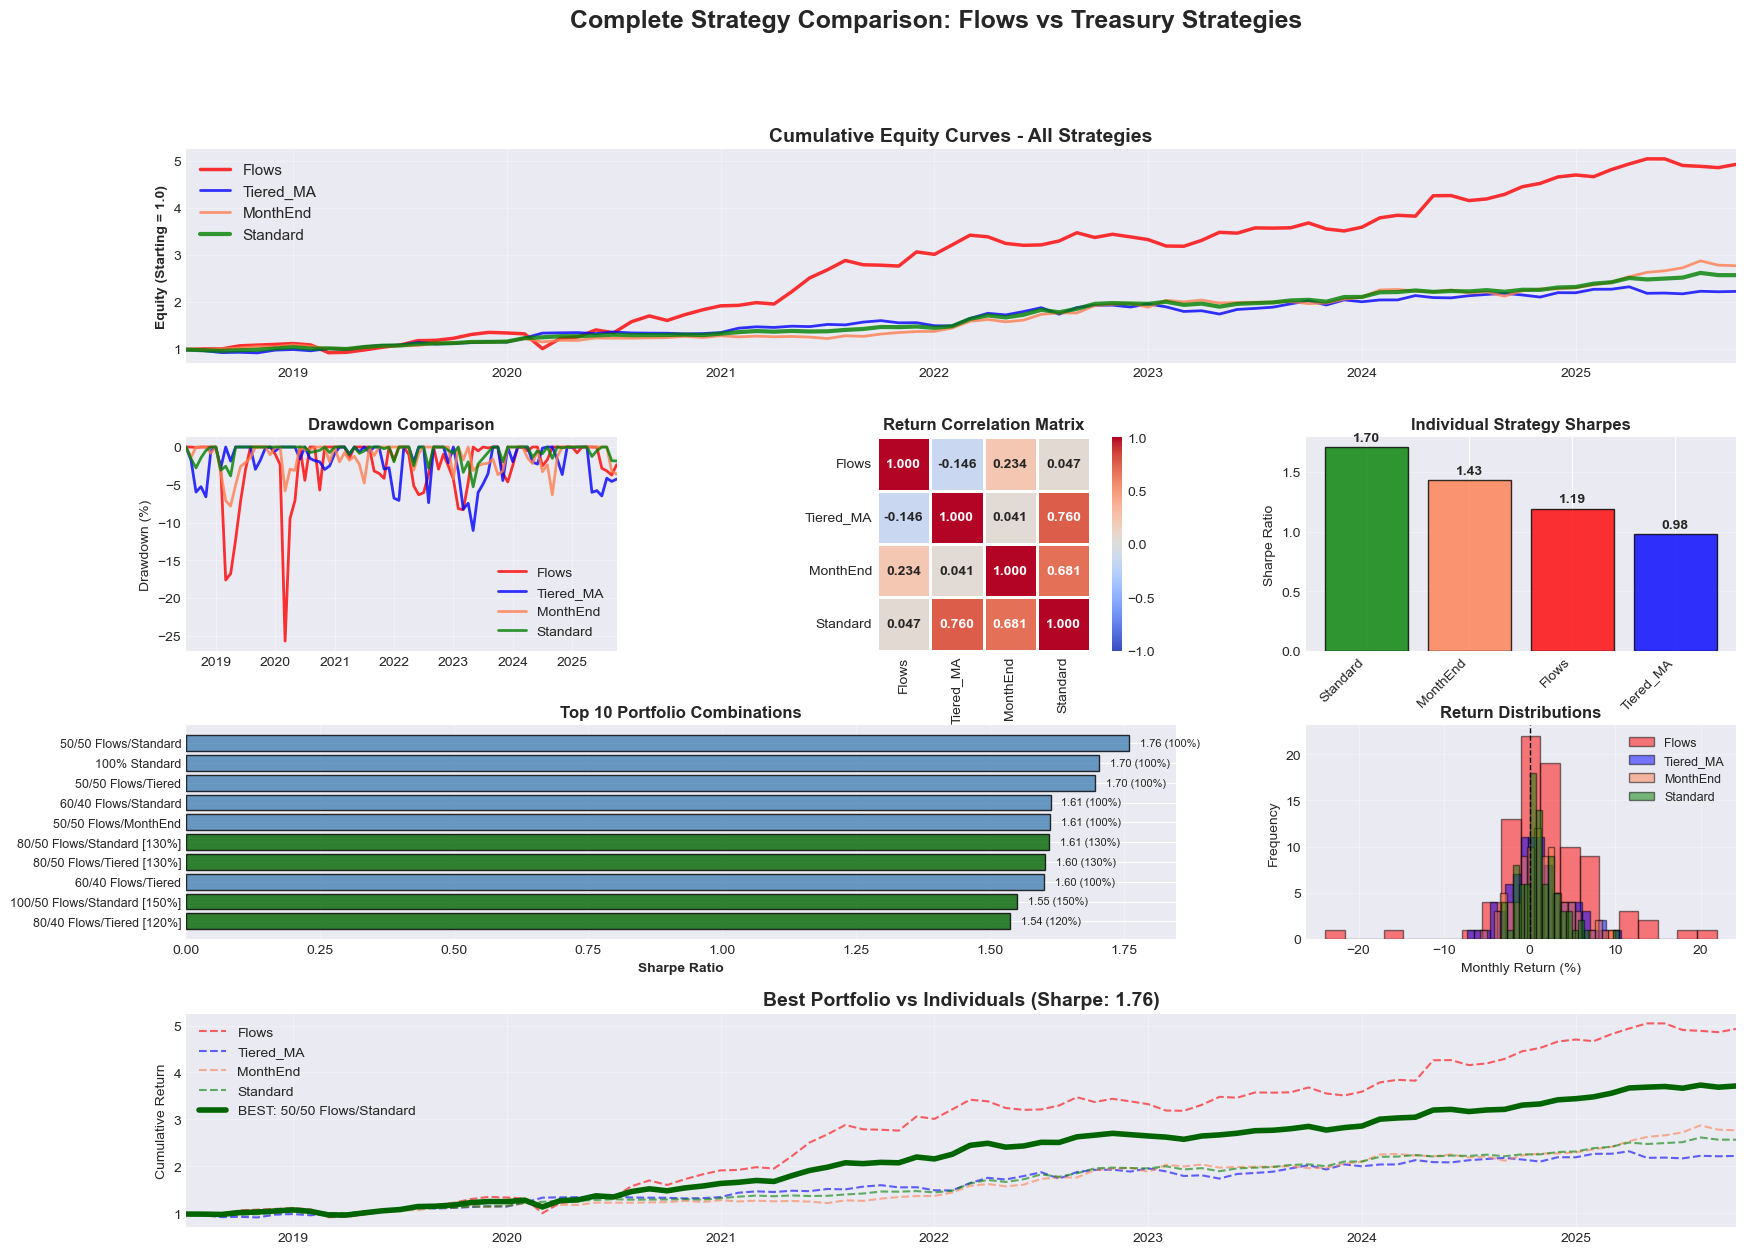

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMPLETE STRATEGY COMPARISON: FLOWS VS TREASURY STRATEGIES")
print("="*80)
print("\nIndependent Strategies:")
print("  1. Flows (existing strategy)")
print("  2. Tiered MA Cross 20/50")
print("  3. Month-End Long/Short")
print("  4. Standard = 50% Tiered + 50% Month-End")

# ============================================================================
# STEP 1: LOAD FLOWS DATA
# ============================================================================
print("\n" + "-"*80)
print("STEP 1: LOADING FLOWS DATA")
print("-"*80)

flows_raw = pd.read_excel('FlowsMonthlyReturns.xlsx')
flows_clean = flows_raw.iloc[1:].copy()
flows_clean.columns = ['Date', 'Return']
flows_clean['Date'] = pd.to_datetime(flows_clean['Date'])
flows_clean['Return'] = pd.to_numeric(flows_clean['Return'])
flows_clean.set_index('Date', inplace=True)
flows_clean.index = flows_clean.index.to_period('M').to_timestamp()

print(f"   ✓ {len(flows_clean)} months ({flows_clean.index[0]:%Y-%m} to {flows_clean.index[-1]:%Y-%m})")

# ============================================================================
# STEP 2: CALCULATE TREASURY STRATEGIES
# ============================================================================
print("\n" + "-"*80)
print("STEP 2: CALCULATING TREASURY STRATEGIES")
print("-"*80)

returns = features_clean['ret_1d']
price = features_clean['price']
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']

# === TIERED MA ===
signal_ma_base = pd.Series(0, index=features_clean.index)
signal_ma_base[ma20 > ma50] = 1
signal_ma_base[ma20 < ma50] = -1

filter_8 = (abs(price - ma20) / price) >= 0.001
filter_19 = features_clean['ty_spx_corr_20d'] <= 0

signal_tiered = signal_ma_base.copy().astype(float)
both = filter_8 & filter_19
one = (filter_8 & ~filter_19) | (~filter_8 & filter_19)
signal_tiered[both] = signal_ma_base[both] * 3.0
signal_tiered[one] = signal_ma_base[one] * 2.0
signal_tiered[~(both | one)] = 0.0

# === MONTH-END ===
def create_month_end_signal(dates):
    df = pd.DataFrame({'date': dates})
    df['ym'] = df['date'].dt.to_period('M')
    sig = pd.Series(0.0, index=dates)
    
    for ym in df['ym'].unique():
        idx = df[df['ym'] == ym].index
        if len(idx) >= 5:
            sig.iloc[idx[-5:]] = 3.0  # Long last 5
            sig.iloc[idx[:5]] -= 3.0  # Short first 5
    
    return sig

signal_month_end = create_month_end_signal(features_clean.index)

# === STANDARD (50/50 combo) ===
signal_standard = (signal_tiered * 0.5) + (signal_month_end * 0.5)

# Calculate daily returns
ret_tiered = signal_tiered.shift(1) * returns
ret_month_end = signal_month_end.shift(1) * returns
ret_standard = signal_standard.shift(1) * returns

print("   ✓ Tiered MA calculated")
print("   ✓ Month-End calculated")
print("   ✓ Standard (50/50) calculated")

# ============================================================================
# STEP 3: AGGREGATE TO MONTHLY
# ============================================================================
print("\n" + "-"*80)
print("STEP 3: CONVERTING TO MONTHLY RETURNS")
print("-"*80)

def daily_to_monthly(daily_returns):
    df = pd.DataFrame({'ret': daily_returns})
    df['year'] = daily_returns.index.year
    df['month'] = daily_returns.index.month
    monthly = df.groupby(['year','month'])['ret'].apply(lambda x: (1+x).prod()-1)
    monthly.index = pd.to_datetime([f"{y}-{m:02d}-01" for y,m in monthly.index])
    return monthly

monthly_tiered = daily_to_monthly(ret_tiered)
monthly_month_end = daily_to_monthly(ret_month_end)
monthly_standard = daily_to_monthly(ret_standard)

print(f"   ✓ Tiered: {len(monthly_tiered)} months")
print(f"   ✓ MonthEnd: {len(monthly_month_end)} months")
print(f"   ✓ Standard: {len(monthly_standard)} months")

# ============================================================================
# STEP 4: ALIGN ALL STRATEGIES
# ============================================================================
print("\n" + "-"*80)
print("STEP 4: ALIGNING ALL STRATEGIES")
print("-"*80)

all_strategies = pd.DataFrame({
    'Flows': flows_clean['Return'],
    'Tiered_MA': monthly_tiered,
    'MonthEnd': monthly_month_end,
    'Standard': monthly_standard
}).dropna()

print(f"   ✓ Overlapping: {len(all_strategies)} months")
print(f"   ✓ Period: {all_strategies.index[0]:%Y-%m} to {all_strategies.index[-1]:%Y-%m}")

# ============================================================================
# DISPLAY MATCHED MONTHLY RETURNS
# ============================================================================
print("\n" + "="*80)
print("MATCHED MONTHLY RETURNS (%) - VERIFY ALIGNMENT")
print("="*80)

matched_pct = all_strategies * 100

print("\nFirst 20 months:")
print(matched_pct.head(20).to_string())

print("\n\nLast 10 months:")
print(matched_pct.tail(10).to_string())

print("\nBasic Statistics:")
print(f"\n{'Strategy':<15s} {'Mean':>8s} {'Median':>8s} {'Std':>8s} {'Min':>8s} {'Max':>8s}")
print("-"*65)
for col in matched_pct.columns:
    print(f"{col:<15s} {matched_pct[col].mean():>7.2f}% {matched_pct[col].median():>7.2f}% "
          f"{matched_pct[col].std():>7.2f}% {matched_pct[col].min():>7.2f}% {matched_pct[col].max():>7.2f}%")

# ============================================================================
# STEP 5: PERFORMANCE METRICS
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE METRICS - INDIVIDUAL STRATEGIES")
print("="*80)

def calc_metrics(ret_series):
    total = (1+ret_series).prod()-1
    years = len(ret_series)/12
    ann_ret = (1+total)**(1/years)-1
    ann_vol = ret_series.std()*np.sqrt(12)
    sharpe = ann_ret/ann_vol if ann_vol>0 else 0
    
    down = ret_series[ret_series<0]
    down_vol = down.std()*np.sqrt(12) if len(down)>0 else 0
    sortino = ann_ret/down_vol if down_vol>0 else 0
    
    cum = (1+ret_series).cumprod()
    dd = (cum-cum.expanding().max())/cum.expanding().max()
    max_dd = dd.min()
    calmar = ann_ret/abs(max_dd) if max_dd!=0 else 0
    
    wr = (ret_series>0).sum()/len(ret_series)
    
    return {
        'Total_%': total*100,
        'Annual_%': ann_ret*100,
        'Vol_%': ann_vol*100,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'MaxDD_%': max_dd*100,
        'Calmar': calmar,
        'WinRate_%': wr*100,
        'Best_%': ret_series.max()*100,
        'Worst_%': ret_series.min()*100
    }

metrics = pd.DataFrame({col: calc_metrics(all_strategies[col]) for col in all_strategies.columns})

print("\n" + metrics.to_string())

# ============================================================================
# STEP 6: CORRELATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

corr = all_strategies.corr()
print("\nMonthly Return Correlations:")
print(corr.round(3).to_string())

print(f"\nKey Correlations:")
print(f"  Flows vs Standard:  {corr.loc['Flows','Standard']:>6.3f}")
print(f"  Flows vs Tiered:    {corr.loc['Flows','Tiered_MA']:>6.3f}")
print(f"  Flows vs MonthEnd:  {corr.loc['Flows','MonthEnd']:>6.3f}")
print(f"  Tiered vs MonthEnd: {corr.loc['Tiered_MA','MonthEnd']:>6.3f}")

# ============================================================================
# STEP 7: PORTFOLIO COMBINATIONS (CORRECTED)
# ============================================================================
print("\n" + "="*80)
print("PORTFOLIO COMBINATIONS - 1 OR 2 ASSETS ONLY")
print("="*80)

print("\nNote: Avoiding double-counting (Standard already contains Tiered+MonthEnd)")

combos = []

# Single strategies
for col in ['Flows', 'Standard', 'Tiered_MA', 'MonthEnd']:
    ret = all_strategies[col]
    m = calc_metrics(ret)
    m['Name'] = f'100% {col}'
    m['Exposure'] = '100%'
    combos.append(m)

# Two-asset combinations: Flows + [something]
for w_flows, w_other, other_name, combo_name in [
    # Unleveraged (sum to 100%)
    (0.5, 0.5, 'Standard', '50/50 Flows/Standard'),
    (0.6, 0.4, 'Standard', '60/40 Flows/Standard'),
    (0.7, 0.3, 'Standard', '70/30 Flows/Standard'),
    (0.5, 0.5, 'Tiered_MA', '50/50 Flows/Tiered'),
    (0.6, 0.4, 'Tiered_MA', '60/40 Flows/Tiered'),
    (0.5, 0.5, 'MonthEnd', '50/50 Flows/MonthEnd'),
    (0.6, 0.4, 'MonthEnd', '60/40 Flows/MonthEnd'),
    
    # Leveraged (sum > 100%)
    (0.8, 0.4, 'Standard', '80/40 Flows/Standard [120%]'),
    (0.8, 0.5, 'Standard', '80/50 Flows/Standard [130%]'),
    (1.0, 0.4, 'Standard', '100/40 Flows/Standard [140%]'),
    (1.0, 0.5, 'Standard', '100/50 Flows/Standard [150%]'),
    (0.8, 0.4, 'Tiered_MA', '80/40 Flows/Tiered [120%]'),
    (0.8, 0.5, 'Tiered_MA', '80/50 Flows/Tiered [130%]'),
    (1.0, 0.4, 'Tiered_MA', '100/40 Flows/Tiered [140%]'),
    (0.8, 0.4, 'MonthEnd', '80/40 Flows/MonthEnd [120%]'),
    (1.0, 0.5, 'MonthEnd', '100/50 Flows/MonthEnd [150%]'),
]:
    ret = all_strategies['Flows']*w_flows + all_strategies[other_name]*w_other
    m = calc_metrics(ret)
    m['Name'] = combo_name
    m['Exposure'] = f'{int((w_flows+w_other)*100)}%'
    combos.append(m)

combo_df = pd.DataFrame(combos).sort_values('Sharpe', ascending=False)

print(f"\n{'Rank':<5s} {'Portfolio':<35s} {'Exposure':>9s} {'Sharpe':>7s} {'Annual':>8s} {'MaxDD':>8s} {'Calmar':>7s}")
print("-"*90)

for i, (_, r) in enumerate(combo_df.iterrows(), 1):
    marker = "  ← Current" if r['Name'] == '100% Standard' else ""
    print(f"{i:<5d} {r['Name']:<35s} {r['Exposure']:>9s} {r['Sharpe']:>7.2f} "
          f"{r['Annual_%']:>7.2f}% {r['MaxDD_%']:>7.2f}% {r['Calmar']:>7.2f}{marker}")

# ============================================================================
# CORRELATION VERIFICATION
# ============================================================================
print("\n" + "="*80)
print("CORRELATION VERIFICATION")
print("="*80)

print("\nFull Correlation Matrix:")
print(corr.round(3).to_string())

print("\n\nDetailed Comparison (First 10 months to verify alignment):")
print(f"\n{'Date':<12s} {'Flows':>10s} {'Tiered':>10s} {'MonthEnd':>10s} {'Standard':>10s}")
print("-"*60)

for date, row in matched_pct.head(10).iterrows():
    print(f"{date.strftime('%Y-%m'):<12s} {row['Flows']:>9.2f}% {row['Tiered_MA']:>9.2f}% "
          f"{row['MonthEnd']:>9.2f}% {row['Standard']:>9.2f}%")

print("\n\nChecking if correlations look correct...")
print("If Flows returns look completely different from Treasury strategies,")
print("low correlation is expected (they're likely uncorrelated strategies).")

# Manual correlation check on first 20 months
subset = all_strategies.head(20)
manual_corr = subset['Flows'].corr(subset['Standard'])
print(f"\nManual check (first 20 months): Flows vs Standard correlation = {manual_corr:.3f}")

# ============================================================================
# PERFORMANCE SUMMARY
# ============================================================================
print("\n" + "="*80)
print("INDIVIDUAL STRATEGY PERFORMANCE")
print("="*80)

print(f"\n{'Metric':<20s} {'Flows':>12s} {'Tiered_MA':>12s} {'MonthEnd':>12s} {'Standard':>12s}")
print("-"*75)

metric_rows = [
    'Total_%', 'Annual_%', 'Vol_%', 'Sharpe', 'Sortino', 
    'MaxDD_%', 'Calmar', 'WinRate_%', 'Best_%', 'Worst_%'
]

for metric in metric_rows:
    print(f"{metric:<20s} ", end='')
    for col in ['Flows', 'Tiered_MA', 'MonthEnd', 'Standard']:
        val = metrics[col][metric]
        print(f"{val:>12.2f} ", end='')
    print()

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig = plt.figure(figsize=(20,14))
gs = fig.add_gridspec(4,3,hspace=0.35,wspace=0.3)
fig.suptitle('Complete Strategy Comparison: Flows vs Treasury Strategies', fontsize=18, fontweight='bold')

# Plot 1: All equity curves
ax1 = fig.add_subplot(gs[0,:])
colors = {'Flows':'red', 'Standard':'green', 'Tiered_MA':'blue', 'MonthEnd':'coral'}
lws = {'Flows':2.5, 'Standard':3, 'Tiered_MA':2, 'MonthEnd':2}

for col in all_strategies.columns:
    (1+all_strategies[col]).cumprod().plot(ax=ax1, label=col, color=colors[col], 
                                           linewidth=lws[col], alpha=0.8)
ax1.set_title('Cumulative Equity Curves - All Strategies', fontweight='bold', fontsize=14)
ax1.set_ylabel('Equity (Starting = 1.0)', fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Drawdowns
ax2 = fig.add_subplot(gs[1,0])
for col in all_strategies.columns:
    cum = (1+all_strategies[col]).cumprod()
    dd = ((cum-cum.expanding().max())/cum.expanding().max())*100
    dd.plot(ax=ax2, label=col, color=colors[col], linewidth=2, alpha=0.8)
ax2.set_title('Drawdown Comparison', fontweight='bold')
ax2.set_ylabel('Drawdown (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Correlation heatmap
ax3 = fig.add_subplot(gs[1,1])
sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
           square=True, linewidths=2, ax=ax3, vmin=-1, vmax=1,
           annot_kws={'fontsize':10, 'fontweight':'bold'})
ax3.set_title('Return Correlation Matrix', fontweight='bold')

# Plot 4: Sharpe comparison - individuals
ax4 = fig.add_subplot(gs[1,2])
individual_sharpes = metrics.T['Sharpe'].sort_values(ascending=False)
bars = ax4.bar(range(len(individual_sharpes)), individual_sharpes, 
              color=[colors[idx] for idx in individual_sharpes.index], alpha=0.8, edgecolor='black')
ax4.set_xticks(range(len(individual_sharpes)))
ax4.set_xticklabels(individual_sharpes.index, rotation=45, ha='right')
ax4.set_ylabel('Sharpe Ratio')
ax4.set_title('Individual Strategy Sharpes', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, individual_sharpes):
    ax4.text(bar.get_x()+bar.get_width()/2, val+0.05, f'{val:.2f}',
            ha='center', fontsize=10, fontweight='bold')

# Plot 5: Top 10 portfolio combinations
ax5 = fig.add_subplot(gs[2,:2])
top10 = combo_df.head(10)
x = range(len(top10))
colors_combo = ['darkgreen' if '[' in n else 'steelblue' for n in top10['Name']]

bars = ax5.barh(x, top10['Sharpe'], color=colors_combo, alpha=0.8, edgecolor='black')
ax5.set_yticks(x)
ax5.set_yticklabels(top10['Name'], fontsize=9)
ax5.set_xlabel('Sharpe Ratio', fontweight='bold')
ax5.set_title('Top 10 Portfolio Combinations', fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')
ax5.invert_yaxis()

for bar, val, exp in zip(bars, top10['Sharpe'], top10['Exposure']):
    ax5.text(val+0.02, bar.get_y()+bar.get_height()/2, 
            f'{val:.2f} ({exp})', va='center', fontsize=8)

# Plot 6: Return distributions
ax6 = fig.add_subplot(gs[2,2])
for col in all_strategies.columns:
    (all_strategies[col]*100).hist(bins=20, alpha=0.5, label=col, 
                                   color=colors[col], ax=ax6, edgecolor='black')
ax6.set_xlabel('Monthly Return (%)')
ax6.set_ylabel('Frequency')
ax6.set_title('Return Distributions', fontweight='bold')
ax6.legend(fontsize=9)
ax6.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax6.grid(True, alpha=0.3)

# Plot 7: Best portfolio equity curve
ax7 = fig.add_subplot(gs[3,:])

best = combo_df.iloc[0]

# Parse weights from name
if '100%' in best['Name']:
    if 'Flows' in best['Name']:
        best_ret = all_strategies['Flows']
    elif 'Standard' in best['Name']:
        best_ret = all_strategies['Standard']
    elif 'Tiered' in best['Name']:
        best_ret = all_strategies['Tiered_MA']
    else:
        best_ret = all_strategies['MonthEnd']
else:
    # Parse weights
    parts = best['Name'].split()
    if 'Flows/Standard' in best['Name']:
        weights = [float(x) for x in parts[0].split('/')]
        best_ret = all_strategies['Flows']*(weights[0]/100) + all_strategies['Standard']*(weights[1]/100)
    elif 'Flows/Tiered' in best['Name']:
        weights = [float(x) for x in parts[0].split('/')]
        best_ret = all_strategies['Flows']*(weights[0]/100) + all_strategies['Tiered_MA']*(weights[1]/100)
    elif 'Flows/MonthEnd' in best['Name']:
        weights = [float(x) for x in parts[0].split('/')]
        best_ret = all_strategies['Flows']*(weights[0]/100) + all_strategies['MonthEnd']*(weights[1]/100)
    else:
        best_ret = all_strategies['Standard']

# Plot individuals and best combo
for col in all_strategies.columns:
    (1+all_strategies[col]).cumprod().plot(ax=ax7, label=col, color=colors[col], 
                                          linewidth=1.5, alpha=0.6, linestyle='--')

(1+best_ret).cumprod().plot(ax=ax7, label=f'BEST: {best["Name"]}', 
                            color='darkgreen', linewidth=4)

ax7.set_title(f'Best Portfolio vs Individuals (Sharpe: {best["Sharpe"]:.2f})', 
             fontweight='bold', fontsize=14)
ax7.set_ylabel('Cumulative Return')
ax7.legend(fontsize=10)
ax7.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('flows_comparison_corrected.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: flows_comparison_corrected.png")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("FINAL RECOMMENDATIONS")
print("="*80)

best = combo_df.iloc[0]
current = combo_df[combo_df['Name'] == '100% Standard'].iloc[0]

print(f"\n🏆 OPTIMAL PORTFOLIO: {best['Name']}")
print(f"   Sharpe:   {best['Sharpe']:.2f}")
print(f"   Annual:   {best['Annual_%']:.2f}%")
print(f"   MaxDD:    {best['MaxDD_%']:.2f}%")
print(f"   Exposure: {best['Exposure']}")

print(f"\n📊 Current Portfolio (100% Standard):")
print(f"   Sharpe:   {current['Sharpe']:.2f}")
print(f"   Annual:   {current['Annual_%']:.2f}%")
print(f"   MaxDD:    {current['MaxDD_%']:.2f}%")

if best['Name'] != '100% Standard':
    print(f"\n💡 IMPROVEMENT OPPORTUNITY:")
    print(f"   Sharpe: {best['Sharpe'] - current['Sharpe']:+.2f}")
    print(f"   Annual: {best['Annual_%'] - current['Annual_%']:+.2f}%")
    print(f"   MaxDD:  {best['MaxDD_%'] - current['MaxDD_%']:+.2f}%")
else:
    print(f"\n✓ Current portfolio is already optimal")

print("\n" + "="*80)

matched_pct.head(20)

DOLLAR-WEIGHTED PORTFOLIO COMPARISON

Approach: De-lever Standard portfolio, then dollar-weight
Assumption: Standard returns ÷ 3 ≈ unlevered returns

--------------------------------------------------------------------------------
LOADING DATA
--------------------------------------------------------------------------------
   ✓ Flows loaded: 88 months
   ✓ Standard (levered) calculated: 112 months
   ✓ Standard (unlevered) = Standard / 3

--------------------------------------------------------------------------------
ALIGNING DATA
--------------------------------------------------------------------------------
   ✓ 88 months overlap
   ✓ 2018-07 to 2025-10

MATCHED MONTHLY RETURNS - VERIFY ALIGNMENT

Date             Flows%   Std_Lev%   Std_Unlev%
--------------------------------------------------

First 15 months:
2018-07          -1.56%     -1.66%       -0.55%
2018-08           1.25%     -1.56%       -0.52%
2018-09          -0.06%     -1.22%       -0.41%
2018-10           6.67%     

Flows  Standard_Levered  Standard_Unlevered
2018-07-01 -1.562076         -1.662607           -0.554202
2018-08-01  1.248328         -1.557026           -0.519009
2018-09-01 -0.064439         -1.221477           -0.407159
2018-10-01  6.666092          1.353797            0.451266
2018-11-01  1.456889          0.998748            0.332916
...              ...               ...                 ...
2025-06-01 -0.020000          0.767766            0.255922
2025-07-01 -2.790000          0.828300            0.276100
2025-08-01 -0.360000          3.970922            1.323641
2025-09-01 -0.570000         -1.812295           -0.604098
2025-10-01  1.430000         -0.037668           -0.012556

[88 rows x 3 columns]

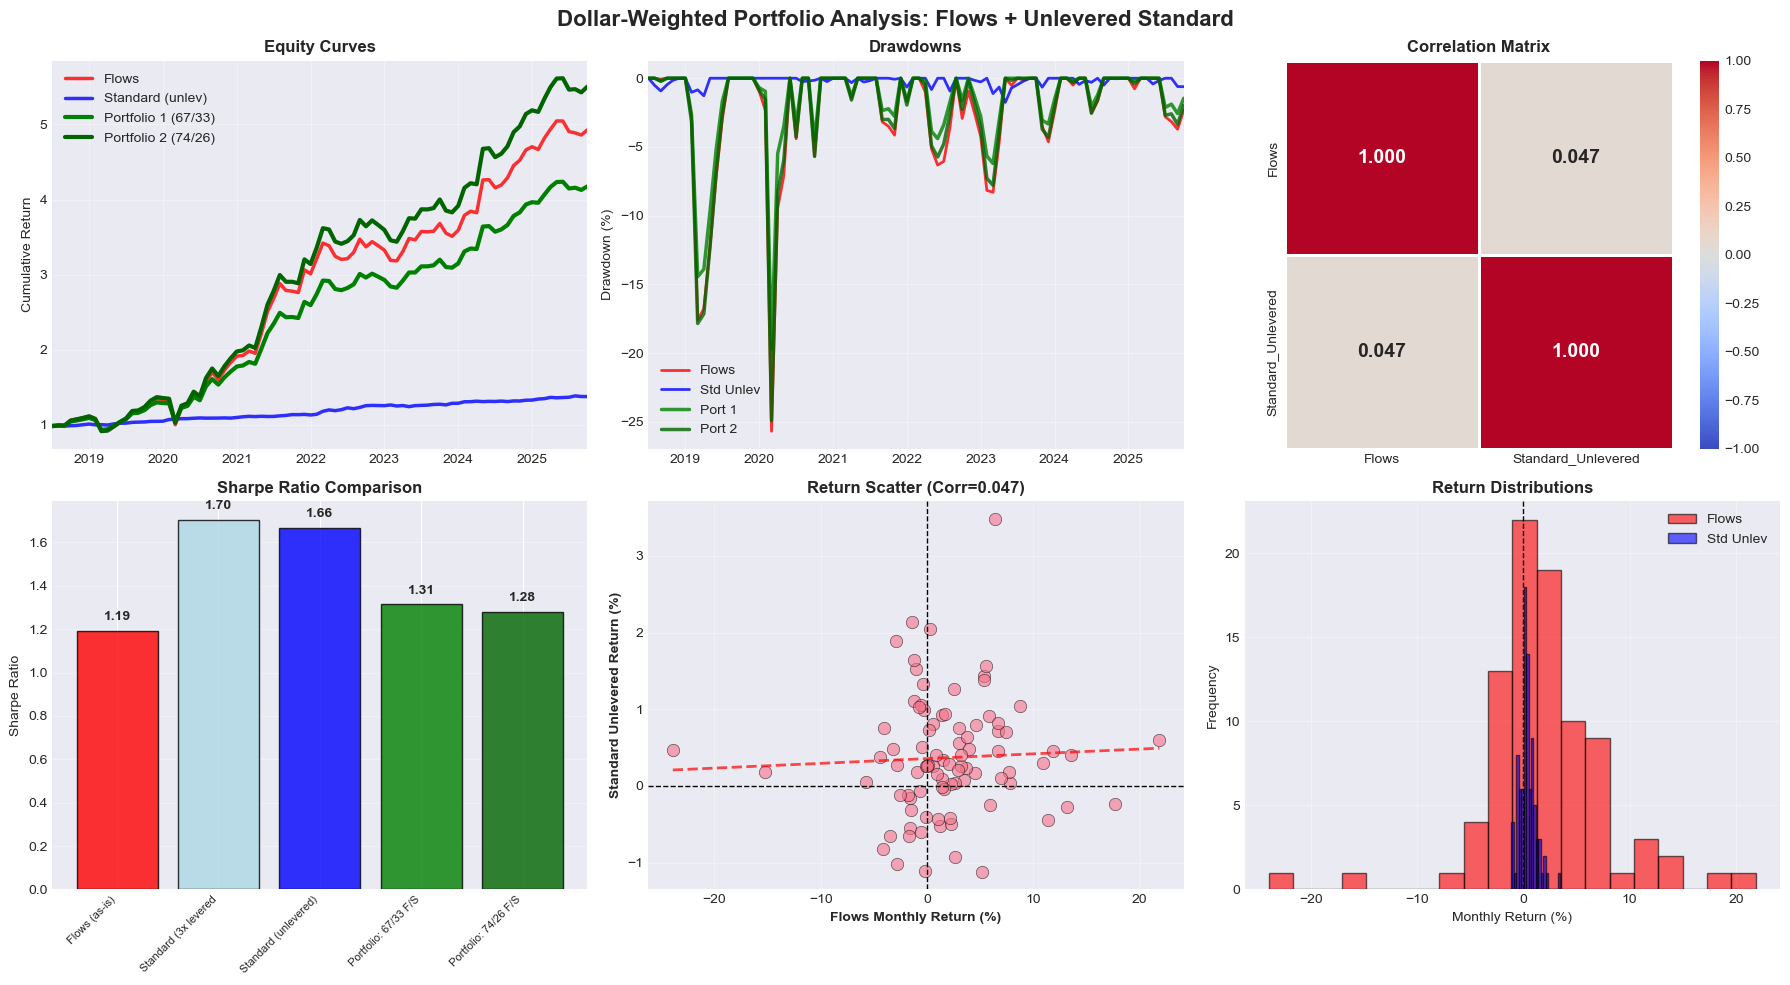

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DOLLAR-WEIGHTED PORTFOLIO COMPARISON")
print("="*80)
print("\nApproach: De-lever Standard portfolio, then dollar-weight")
print("Assumption: Standard returns ÷ 3 ≈ unlevered returns")

# ============================================================================
# LOAD AND PREPARE DATA
# ============================================================================
print("\n" + "-"*80)
print("LOADING DATA")
print("-"*80)

# Flows
flows_raw = pd.read_excel('FlowsMonthlyReturns.xlsx')
flows_clean = flows_raw.iloc[1:].copy()
flows_clean.columns = ['Date', 'Return']
flows_clean['Date'] = pd.to_datetime(flows_clean['Date'])
flows_clean['Return'] = pd.to_numeric(flows_clean['Return'])
flows_clean.set_index('Date', inplace=True)
flows_clean.index = flows_clean.index.to_period('M').to_timestamp()

# Standard (levered)
returns = features_clean['ret_1d']
price = features_clean['price']
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']

# Tiered MA
signal_ma_base = pd.Series(0, index=features_clean.index)
signal_ma_base[ma20 > ma50] = 1
signal_ma_base[ma20 < ma50] = -1

filter_8 = (abs(price - ma20) / price) >= 0.001
filter_19 = features_clean['ty_spx_corr_20d'] <= 0

signal_tiered = signal_ma_base.copy().astype(float)
both = filter_8 & filter_19
one = (filter_8 & ~filter_19) | (~filter_8 & filter_19)
signal_tiered[both] = signal_ma_base[both] * 3.0
signal_tiered[one] = signal_ma_base[one] * 2.0
signal_tiered[~(both | one)] = 0.0

# Month-End
def month_end_signal(dates):
    df = pd.DataFrame({'date': dates, 'ym': dates.to_period('M')})
    sig = pd.Series(0.0, index=dates)
    for ym in df['ym'].unique():
        idx = df[df['ym']==ym].index
        if len(idx) >= 5:
            sig.iloc[idx[-5:]] = 3.0
            sig.iloc[idx[:5]] -= 3.0
    return sig

signal_month_end = month_end_signal(features_clean.index)

# Standard (50/50)
signal_standard = (signal_tiered * 0.5) + (signal_month_end * 0.5)

# Daily returns (LEVERED)
ret_standard_levered = signal_standard.shift(1) * returns

# Monthly (LEVERED)
monthly_standard_levered = ret_standard_levered.groupby(
    [ret_standard_levered.index.year, ret_standard_levered.index.month]
).apply(lambda x: (1+x).prod()-1)
monthly_standard_levered.index = pd.to_datetime([f"{y}-{m:02d}-01" for y,m in monthly_standard_levered.index])

# DE-LEVER by dividing by 3
monthly_standard_unlevered = monthly_standard_levered / 3

print(f"   ✓ Flows loaded: {len(flows_clean)} months")
print(f"   ✓ Standard (levered) calculated: {len(monthly_standard_levered)} months")
print(f"   ✓ Standard (unlevered) = Standard / 3")

# ============================================================================
# ALIGN DATA
# ============================================================================
print("\n" + "-"*80)
print("ALIGNING DATA")
print("-"*80)

aligned = pd.DataFrame({
    'Flows': flows_clean['Return'],
    'Standard_Levered': monthly_standard_levered,
    'Standard_Unlevered': monthly_standard_unlevered
}).dropna()

print(f"   ✓ {len(aligned)} months overlap")
print(f"   ✓ {aligned.index[0]:%Y-%m} to {aligned.index[-1]:%Y-%m}")

# ============================================================================
# SHOW MATCHED DATA
# ============================================================================
print("\n" + "="*80)
print("MATCHED MONTHLY RETURNS - VERIFY ALIGNMENT")
print("="*80)

display_pct = aligned * 100

print(f"\n{'Date':<12s} {'Flows%':>10s} {'Std_Lev%':>10s} {'Std_Unlev%':>12s}")
print("-"*50)

print("\nFirst 15 months:")
for date, row in display_pct.head(15).iterrows():
    print(f"{date.strftime('%Y-%m'):<12s} {row['Flows']:>9.2f}% {row['Standard_Levered']:>9.2f}% "
          f"{row['Standard_Unlevered']:>11.2f}%")

print("\nLast 10 months:")
for date, row in display_pct.tail(10).iterrows():
    print(f"{date.strftime('%Y-%m'):<12s} {row['Flows']:>9.2f}% {row['Standard_Levered']:>9.2f}% "
          f"{row['Standard_Unlevered']:>11.2f}%")

# ============================================================================
# DOLLAR-WEIGHTED PORTFOLIOS
# ============================================================================
print("\n" + "="*80)
print("DOLLAR-WEIGHTED PORTFOLIO RETURNS")
print("="*80)

print("\n⚠️  IMPORTANT: Base AUM = $500mm (constant)")
print("Different allocations create different LEVERAGE levels")

# Scenario 1: $400mm Flows / $200mm Standard (unlevered)
base_aum = 500
aum_1_flows = 400
aum_1_standard = 200
total_exposure_1 = aum_1_flows + aum_1_standard
leverage_1 = total_exposure_1 / base_aum

weight_1_flows = aum_1_flows / base_aum
weight_1_standard = aum_1_standard / base_aum

portfolio_1 = aligned['Flows'] * weight_1_flows + aligned['Standard_Unlevered'] * weight_1_standard

print(f"\nScenario 1: $400mm Flows / $200mm Standard")
print(f"  Base AUM: ${base_aum}mm")
print(f"  Total Exposure: ${total_exposure_1}mm")
print(f"  Portfolio Leverage: {leverage_1:.2f}x")
print(f"  Flows weight:    {weight_1_flows*100:.1f}% (${aum_1_flows}mm / ${base_aum}mm)")
print(f"  Standard weight: {weight_1_standard*100:.1f}% (${aum_1_standard}mm / ${base_aum}mm)")
print(f"  Formula: Flows × {weight_1_flows:.2f} + Standard × {weight_1_standard:.2f}")

# Scenario 2: $500mm Flows / $175mm Standard (unlevered)
aum_2_flows = 500
aum_2_standard = 175
total_exposure_2 = aum_2_flows + aum_2_standard
leverage_2 = total_exposure_2 / base_aum

weight_2_flows = aum_2_flows / base_aum
weight_2_standard = aum_2_standard / base_aum

portfolio_2 = aligned['Flows'] * weight_2_flows + aligned['Standard_Unlevered'] * weight_2_standard

print(f"\nScenario 2: $500mm Flows / $175mm Standard")
print(f"  Base AUM: ${base_aum}mm")
print(f"  Total Exposure: ${total_exposure_2}mm")
print(f"  Portfolio Leverage: {leverage_2:.2f}x")
print(f"  Flows weight:    {weight_2_flows*100:.1f}% (${aum_2_flows}mm / ${base_aum}mm)")
print(f"  Standard weight: {weight_2_standard*100:.1f}% (${aum_2_standard}mm / ${base_aum}mm)")
print(f"  Formula: Flows × {weight_2_flows:.2f} + Standard × {weight_2_standard:.2f}")
print(f"  Simplified: Flows + (Standard × 0.35)")

print("\n💡 KEY INSIGHT:")
print(f"  Scenario 2 is ADDITIVE: You get 100% of Flows returns")
print(f"  PLUS 35% of Standard returns on top")
print(f"  Example: If Flows = +2% and Standard = +1%")
print(f"           Portfolio = 2% + (1% × 0.35) = 2.35%")

# ============================================================================
# PERFORMANCE METRICS
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE METRICS")
print("="*80)

def calc_metrics(ret_series, name):
    total = (1+ret_series).prod()-1
    years = len(ret_series)/12
    ann_ret = (1+total)**(1/years)-1
    ann_vol = ret_series.std()*np.sqrt(12)
    sharpe = ann_ret/ann_vol if ann_vol>0 else 0
    
    cum = (1+ret_series).cumprod()
    dd = (cum-cum.expanding().max())/cum.expanding().max()
    max_dd = dd.min()
    calmar = ann_ret/abs(max_dd) if max_dd!=0 else 0
    
    return {
        'Strategy': name,
        'Annual_%': ann_ret*100,
        'Vol_%': ann_vol*100,
        'Sharpe': sharpe,
        'MaxDD_%': max_dd*100,
        'Calmar': calmar
    }

results = [
    calc_metrics(aligned['Flows'], 'Flows (as-is)'),
    calc_metrics(aligned['Standard_Levered'], 'Standard (3x levered)'),
    calc_metrics(aligned['Standard_Unlevered'], 'Standard (unlevered)'),
    calc_metrics(portfolio_1, 'Portfolio: 67/33 F/S [Scenario 1]'),
    calc_metrics(portfolio_2, 'Portfolio: 74/26 F/S [Scenario 2]')
]

results_df = pd.DataFrame(results)

print(f"\n{'Strategy':<35s} {'Annual':>8s} {'Vol':>8s} {'Sharpe':>7s} {'MaxDD':>8s} {'Calmar':>7s}")
print("-"*85)

for _, r in results_df.iterrows():
    print(f"{r['Strategy']:<35s} {r['Annual_%']:>7.2f}% {r['Vol_%']:>7.2f}% "
          f"{r['Sharpe']:>7.2f} {r['MaxDD_%']:>7.2f}% {r['Calmar']:>7.2f}")

# ============================================================================
# KEY INSIGHT
# ============================================================================
print("\n" + "="*80)
print("KEY INSIGHT: UNDERSTANDING THE COMPARISON")
print("="*80)

print("\nVolatility Check (to verify leverage assumptions):")
print(f"  Flows annual vol:              {results_df.iloc[0]['Vol_%']:.2f}%")
print(f"  Standard (3x levered) vol:     {results_df.iloc[1]['Vol_%']:.2f}%")
print(f"  Standard (unlevered) vol:      {results_df.iloc[2]['Vol_%']:.2f}%")

standard_lev_vol = results_df.iloc[1]['Vol_%']
standard_unlev_vol = results_df.iloc[2]['Vol_%']
leverage_ratio = standard_lev_vol / standard_unlev_vol

print(f"\n  Implied leverage ratio: {leverage_ratio:.2f}x")
print(f"  Expected: ~3x (close to our assumption)")

if leverage_ratio < 2.5 or leverage_ratio > 3.5:
    print(f"\n  ⚠️ WARNING: Leverage ratio is {leverage_ratio:.2f}x, not close to 3x")
    print(f"  This means dividing by 3 may not accurately de-lever")
    print(f"  Consider using actual leverage ratio: {leverage_ratio:.2f}x")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "-"*80)
print("CREATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Dollar-Weighted Portfolio Analysis: Flows + Unlevered Standard',
             fontsize=16, fontweight='bold')

# Plot 1: Equity curves
ax = axes[0, 0]
(1+aligned['Flows']).cumprod().plot(ax=ax, label='Flows', linewidth=2.5, color='red', alpha=0.8)
(1+aligned['Standard_Unlevered']).cumprod().plot(ax=ax, label='Standard (unlev)', linewidth=2.5, color='blue', alpha=0.8)
(1+portfolio_1).cumprod().plot(ax=ax, label='Portfolio 1 (67/33)', linewidth=3, color='green')
(1+portfolio_2).cumprod().plot(ax=ax, label='Portfolio 2 (74/26)', linewidth=3, color='darkgreen')

ax.set_title('Equity Curves', fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Drawdowns
ax = axes[0, 1]
for name, ret, color, lw in [
    ('Flows', aligned['Flows'], 'red', 2),
    ('Std Unlev', aligned['Standard_Unlevered'], 'blue', 2),
    ('Port 1', portfolio_1, 'green', 2.5),
    ('Port 2', portfolio_2, 'darkgreen', 2.5)
]:
    cum = (1+ret).cumprod()
    dd = ((cum-cum.expanding().max())/cum.expanding().max())*100
    dd.plot(ax=ax, label=name, color=color, linewidth=lw, alpha=0.8)

ax.set_title('Drawdowns', fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Correlation
ax = axes[0, 2]
corr = aligned[['Flows', 'Standard_Unlevered']].corr()
sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', center=0,
           square=True, linewidths=2, ax=ax, vmin=-1, vmax=1,
           annot_kws={'fontsize':14, 'fontweight':'bold'})
ax.set_title('Correlation Matrix', fontweight='bold')

# Plot 4: Sharpe comparison
ax = axes[1, 0]
sharpes = results_df.set_index('Strategy')['Sharpe']
colors_bar = ['red', 'lightblue', 'blue', 'green', 'darkgreen']
bars = ax.bar(range(len(sharpes)), sharpes, color=colors_bar, alpha=0.8, edgecolor='black')
ax.set_xticks(range(len(sharpes)))
ax.set_xticklabels([s[:20] for s in sharpes.index], rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio Comparison', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, sharpes):
    ax.text(bar.get_x()+bar.get_width()/2, val+0.05, f'{val:.2f}',
           ha='center', fontsize=10, fontweight='bold')

# Plot 5: Monthly return scatter
ax = axes[1, 1]
ax.scatter(aligned['Flows']*100, aligned['Standard_Unlevered']*100,
          alpha=0.6, s=80, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Flows Monthly Return (%)', fontweight='bold')
ax.set_ylabel('Standard Unlevered Return (%)', fontweight='bold')
ax.set_title(f'Return Scatter (Corr={corr.iloc[0,1]:.3f})', fontweight='bold')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.grid(True, alpha=0.3)

# Add regression line
z = np.polyfit(aligned['Flows'], aligned['Standard_Unlevered'], 1)
p = np.poly1d(z)
x_line = np.linspace(aligned['Flows'].min(), aligned['Flows'].max(), 100)
ax.plot(x_line*100, p(x_line)*100, 'r--', linewidth=2, alpha=0.7)

# Plot 6: Return distributions
ax = axes[1, 2]
(aligned['Flows']*100).hist(bins=20, alpha=0.6, label='Flows', color='red', 
                           ax=ax, edgecolor='black')
(aligned['Standard_Unlevered']*100).hist(bins=20, alpha=0.6, label='Std Unlev', 
                                        color='blue', ax=ax, edgecolor='black')

ax.set_xlabel('Monthly Return (%)')
ax.set_ylabel('Frequency')
ax.set_title('Return Distributions', fontweight='bold')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dollar_weighted_portfolio.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: dollar_weighted_portfolio.png")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

best = results_df.nlargest(1, 'Sharpe').iloc[0]

print(f"\n🏆 Best Sharpe: {best['Strategy']}")
print(f"   Sharpe: {best['Sharpe']:.2f}")
print(f"   Annual: {best['Annual_%']:.2f}%")
print(f"   Vol:    {best['Vol_%']:.2f}%")
print(f"   MaxDD:  {best['MaxDD_%']:.2f}%")

print("\n📊 Scenario 1: $400mm Flows / $200mm Standard (unlevered)")
p1_metrics = results_df[results_df['Strategy'].str.contains('Scenario 1')].iloc[0]
print(f"   Weights: 66.7% Flows / 33.3% Standard")
print(f"   Sharpe: {p1_metrics['Sharpe']:.2f}")
print(f"   Annual: {p1_metrics['Annual_%']:.2f}%")

print("\n📊 Scenario 2: $500mm Flows / $175mm Standard (unlevered)")
p2_metrics = results_df[results_df['Strategy'].str.contains('Scenario 2')].iloc[0]
print(f"   Weights: 74.1% Flows / 25.9% Standard")
print(f"   Sharpe: {p2_metrics['Sharpe']:.2f}")
print(f"   Annual: {p2_metrics['Annual_%']:.2f}%")

print("\n⚠️  IMPORTANT CAVEAT:")
print("   De-levering by ÷3 is approximate because Standard uses variable leverage (0-3x)")
print(f"   Actual average leverage: {leverage_ratio:.2f}x")
print("   For precision, could use actual daily leverage ratios")

print("\n" + "="*80)

# Return the matched data
display_pct

In [44]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("QUARTERLY RETURNS: FLOWS VS SCENARIO PORTFOLIOS")
print("="*80)

# ============================================================================
# LOAD FLOWS
# ============================================================================
flows_raw = pd.read_excel('FlowsMonthlyReturns.xlsx')
flows_clean = flows_raw.iloc[1:].copy()
flows_clean.columns = ['Date', 'Return']
flows_clean['Date'] = pd.to_datetime(flows_clean['Date'])
flows_clean['Return'] = pd.to_numeric(flows_clean['Return'])
flows_clean.set_index('Date', inplace=True)
flows_clean.index = flows_clean.index.to_period('M').to_timestamp()

# ============================================================================
# CALCULATE STANDARD PORTFOLIO
# ============================================================================
returns = features_clean['ret_1d']
price = features_clean['price']
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']

# Tiered MA
signal_ma_base = pd.Series(0, index=features_clean.index)
signal_ma_base[ma20 > ma50] = 1
signal_ma_base[ma20 < ma50] = -1

filter_8 = (abs(price - ma20) / price) >= 0.001
filter_19 = features_clean['ty_spx_corr_20d'] <= 0

signal_tiered = signal_ma_base.copy().astype(float)
both = filter_8 & filter_19
one = (filter_8 & ~filter_19) | (~filter_8 & filter_19)
signal_tiered[both] = signal_ma_base[both] * 3.0
signal_tiered[one] = signal_ma_base[one] * 2.0
signal_tiered[~(both | one)] = 0.0

# Month-End
def month_end_signal(dates):
    df = pd.DataFrame({'date': dates, 'ym': dates.to_period('M')})
    sig = pd.Series(0.0, index=dates)
    for ym in df['ym'].unique():
        idx = df[df['ym']==ym].index
        if len(idx) >= 5:
            sig.iloc[idx[-5:]] = 3.0
            sig.iloc[idx[:5]] -= 3.0
    return sig

signal_month_end = month_end_signal(features_clean.index)
signal_standard = (signal_tiered * 0.5) + (signal_month_end * 0.5)

ret_standard = signal_standard.shift(1) * returns

monthly_standard_levered = ret_standard.groupby(
    [ret_standard.index.year, ret_standard.index.month]
).apply(lambda x: (1+x).prod()-1)
monthly_standard_levered.index = pd.to_datetime([f"{y}-{m:02d}-01" for y,m in monthly_standard_levered.index])

monthly_standard_unlevered = monthly_standard_levered / 3

# ============================================================================
# ALIGN
# ============================================================================
aligned = pd.DataFrame({
    'Flows': flows_clean['Return'],
    'Standard_Unlevered': monthly_standard_unlevered
}).dropna()

# ============================================================================
# CALCULATE SCENARIOS
# ============================================================================
BASE_AUM = 500

# Scenario 1: $400mm / $200mm
portfolio_1 = (aligned['Flows'] * 400 + aligned['Standard_Unlevered'] * 200) / BASE_AUM

# Scenario 2: $500mm / $175mm  
portfolio_2 = (aligned['Flows'] * 500 + aligned['Standard_Unlevered'] * 175) / BASE_AUM

# ============================================================================
# CONVERT TO QUARTERLY
# ============================================================================
print("\n" + "="*80)
print("QUARTERLY RETURNS")
print("="*80)

def monthly_to_quarterly(monthly_returns):
    df = pd.DataFrame({'ret': monthly_returns})
    df['year'] = monthly_returns.index.year
    df['quarter'] = monthly_returns.index.quarter
    quarterly = df.groupby(['year', 'quarter'])['ret'].apply(lambda x: (1+x).prod()-1)
    quarterly.index = [f"{y}Q{q}" for y, q in quarterly.index]
    return quarterly

q_flows = monthly_to_quarterly(aligned['Flows'])
q_scen1 = monthly_to_quarterly(portfolio_1)
q_scen2 = monthly_to_quarterly(portfolio_2)

quarterly_df = pd.DataFrame({
    'Flows_%': q_flows * 100,
    'Scenario_1_%': q_scen1 * 100,
    'Scenario_2_%': q_scen2 * 100
})

print(f"\nBase AUM: $500mm")
print(f"Scenario 1: $400mm Flows / $200mm Std (120% exposure)")
print(f"Scenario 2: $500mm Flows / $175mm Std (135% exposure)")

print(f"\n{'Quarter':<10s} {'Flows':>10s} {'Scen_1':>10s} {'Scen_2':>10s}")
print("-"*45)

for quarter, row in quarterly_df.iterrows():
    print(f"{quarter:<10s} {row['Flows_%']:>9.2f}% {row['Scenario_1_%']:>9.2f}% {row['Scenario_2_%']:>9.2f}%")

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================
print("\n" + "-"*45)
print("Quarterly Statistics:")
print(f"\n{'Metric':<20s} {'Flows':>10s} {'Scen_1':>10s} {'Scen_2':>10s}")
print("-"*50)

metrics = [
    ('Mean', lambda x: x.mean()),
    ('Median', lambda x: x.median()),
    ('Std Dev', lambda x: x.std()),
    ('Best', lambda x: x.max()),
    ('Worst', lambda x: x.min())
]

for name, func in metrics:
    print(f"{name:<20s} ", end='')
    for col in quarterly_df.columns:
        val = func(quarterly_df[col])
        print(f"{val:>9.2f}% ", end='')
    print()

# Win rates
print(f"{'Positive Quarters':<20s} ", end='')
for col in quarterly_df.columns:
    pos = (quarterly_df[col] > 0).sum()
    total = len(quarterly_df[col])
    print(f"{pos}/{total} ", end='')
print()

print("\n" + "="*80)
print("COMPLETE")
print("="*80)

quarterly_df

QUARTERLY RETURNS: FLOWS VS SCENARIO PORTFOLIOS

QUARTERLY RETURNS

Base AUM: $500mm
Scenario 1: $400mm Flows / $200mm Std (120% exposure)
Scenario 2: $500mm Flows / $175mm Std (135% exposure)

Quarter         Flows     Scen_1     Scen_2
---------------------------------------------
2018Q3         -0.40%     -0.90%     -0.91%
2018Q4          9.73%      8.48%     10.38%
2019Q1        -16.19%    -12.95%    -16.17%
2019Q2         12.62%     10.83%     13.33%
2019Q3         14.32%     12.00%     14.87%
2019Q4         14.43%     11.88%     14.82%
2020Q1        -25.69%    -19.71%    -24.92%
2020Q2         39.80%     31.77%     40.25%
2020Q3         21.26%     17.09%     21.36%
2020Q4          7.66%      6.19%      7.66%
2021Q1          8.33%      7.54%      9.13%
2021Q2         26.56%     20.93%     26.46%
2021Q3         11.16%      9.47%     11.65%
2021Q4          9.83%      8.39%     10.28%
2022Q1         11.62%     10.77%     12.94%
2022Q2         -6.32%     -4.39%     -5.73%
2022Q3      

Flows_%  Scenario_1_%  Scenario_2_%
2018Q3  -0.397472     -0.904853     -0.913582
2018Q4   9.734926      8.478228     10.376869
2019Q1 -16.194185    -12.951006    -16.173221
2019Q2  12.621494     10.825686     13.326675
2019Q3  14.320417     11.997719     14.868143
2019Q4  14.428534     11.879519     14.815727
2020Q1 -25.686732    -19.713023    -24.915795
2020Q2  39.798995     31.767740     40.252942
2020Q3  21.261453     17.086543     21.357307
2020Q4   7.664477      6.190172      7.664750
2021Q1   8.328535      7.537119      9.127023
2021Q2  26.557783     20.926711     26.459643
2021Q3  11.163366      9.472603     11.648284
2021Q4   9.827328      8.393960     10.284287
2022Q1  11.621601     10.765169     12.940745
2022Q2  -6.321107     -4.391443     -5.732351
2022Q3   8.388989      7.733823      9.317522
2022Q4  -2.534576     -1.213108     -1.828268
2023Q1  -5.919196     -4.926461     -6.071156
2023Q2   8.765821      7.179993      8.940107
2023Q3   3.302328      3.150026      3.749432
2023Q4  -1.872591     -1.013895     -1.463931
2024Q1   9.501157      8.256656     10.113650
2024Q2  10.921716      8.907797     11.070404
2024Q3   0.589968      0.396149      0.515429
2024Q4   8.656113      7.452938      9.154772
2025Q1   3.358488      3.334469      3.927954
2025Q2   4.739199      4.230987      5.133574
2025Q3  -3.692058     -2.569714     -3.354045
2025Q4   1.430000      1.138978      1.425605

In [45]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("STANDARD PORTFOLIO P&L - $200MM EXPOSURE (UNLEVERED)")
print("="*80)

# ============================================================================
# CALCULATE STANDARD PORTFOLIO RETURNS
# ============================================================================

returns = features_clean['ret_1d']
price = features_clean['price']
ma20 = features_clean['sma_20d']
ma50 = features_clean['sma_50d']

# Tiered MA
signal_ma_base = pd.Series(0, index=features_clean.index)
signal_ma_base[ma20 > ma50] = 1
signal_ma_base[ma20 < ma50] = -1

filter_8 = (abs(price - ma20) / price) >= 0.001
filter_19 = features_clean['ty_spx_corr_20d'] <= 0

signal_tiered = signal_ma_base.copy().astype(float)
both = filter_8 & filter_19
one = (filter_8 & ~filter_19) | (~filter_8 & filter_19)
signal_tiered[both] = signal_ma_base[both] * 3.0
signal_tiered[one] = signal_ma_base[one] * 2.0
signal_tiered[~(both | one)] = 0.0

# Month-End
def month_end_signal(dates):
    df = pd.DataFrame({'date': dates, 'ym': dates.to_period('M')})
    sig = pd.Series(0.0, index=dates)
    for ym in df['ym'].unique():
        idx = df[df['ym']==ym].index
        if len(idx) >= 5:
            sig.iloc[idx[-5:]] = 3.0
            sig.iloc[idx[:5]] -= 3.0
    return sig

signal_month_end = month_end_signal(features_clean.index)
signal_standard = (signal_tiered * 0.5) + (signal_month_end * 0.5)

# Daily returns (LEVERED)
ret_standard_levered = signal_standard.shift(1) * returns

# Convert to monthly (LEVERED)
monthly_levered = ret_standard_levered.groupby(
    [ret_standard_levered.index.year, ret_standard_levered.index.month]
).apply(lambda x: (1+x).prod()-1)
monthly_levered.index = pd.to_datetime([f"{y}-{m:02d}-01" for y,m in monthly_levered.index])

# De-lever (divide by 3)
monthly_unlevered = monthly_levered / 3

print(f"Total months: {len(monthly_unlevered)}")
print(f"Period: {monthly_unlevered.index[0]:%Y-%m} to {monthly_unlevered.index[-1]:%Y-%m}")

# ============================================================================
# CALCULATE QUARTERLY P&L
# ============================================================================
print("\n" + "="*80)
print("QUARTERLY P&L ($200MM EXPOSURE)")
print("="*80)

EXPOSURE = 200  # million

def calc_quarterly_pnl(monthly_returns, exposure_mm):
    """Calculate quarterly P&L in dollar terms"""
    df = pd.DataFrame({'ret': monthly_returns})
    df['year'] = monthly_returns.index.year
    df['quarter'] = monthly_returns.index.quarter
    
    # Compound monthly returns to quarterly
    quarterly_returns = df.groupby(['year', 'quarter'])['ret'].apply(
        lambda x: (1+x).prod()-1
    )
    
    # Convert index to string labels
    quarterly_returns.index = [f"{y}Q{q}" for y, q in quarterly_returns.index]
    
    # Convert to dollar P&L
    quarterly_pnl = quarterly_returns * exposure_mm
    
    return quarterly_returns, quarterly_pnl

quarterly_returns, quarterly_pnl = calc_quarterly_pnl(monthly_unlevered, EXPOSURE)

print(f"\n{'Quarter':<10s} {'Return %':>12s} {'P&L ($mm)':>15s}")
print("-"*45)

for i in range(len(quarterly_returns)):
    quarter_label = quarterly_returns.index[i]  # This is a string like "2018Q3"
    ret_pct = quarterly_returns.iloc[i] * 100
    pnl_mm = quarterly_pnl.iloc[i]
    print(f"{quarter_label:<10s} {ret_pct:>11.2f}% ${pnl_mm:>13.2f}mm")

# ============================================================================
# QUARTERLY STATISTICS
# ============================================================================
print("\n" + "-"*45)
print("Quarterly Statistics:")
print(f"  Mean:     {quarterly_returns.mean()*100:>6.2f}%  ${quarterly_pnl.mean():>8.2f}mm")
print(f"  Median:   {quarterly_returns.median()*100:>6.2f}%  ${quarterly_pnl.median():>8.2f}mm")
print(f"  Std Dev:  {quarterly_returns.std()*100:>6.2f}%  ${quarterly_pnl.std():>8.2f}mm")
print(f"  Best:     {quarterly_returns.max()*100:>6.2f}%  ${quarterly_pnl.max():>8.2f}mm")
print(f"  Worst:    {quarterly_returns.min()*100:>6.2f}%  ${quarterly_pnl.min():>8.2f}mm")

pos_quarters = (quarterly_returns > 0).sum()
total_quarters = len(quarterly_returns)
print(f"  Positive: {pos_quarters}/{total_quarters} ({pos_quarters/total_quarters*100:.0f}%)")

# ============================================================================
# ANNUAL P&L
# ============================================================================
print("\n" + "="*80)
print("ANNUAL P&L ($200MM EXPOSURE)")
print("="*80)

def calc_annual_pnl(monthly_returns, exposure_mm):
    """Calculate annual P&L in dollar terms"""
    df = pd.DataFrame({'ret': monthly_returns})
    df['year'] = monthly_returns.index.year
    
    # Compound monthly returns to annual
    annual_returns = df.groupby('year')['ret'].apply(
        lambda x: (1+x).prod()-1
    )
    
    # Convert to dollar P&L
    annual_pnl = annual_returns * exposure_mm
    
    return annual_returns, annual_pnl

annual_returns, annual_pnl = calc_annual_pnl(monthly_unlevered, EXPOSURE)

print(f"\n{'Year':<8s} {'Return %':>12s} {'P&L ($mm)':>15s}")
print("-"*40)

for i in range(len(annual_returns)):
    year_label = annual_returns.index[i]
    ret_pct = annual_returns.iloc[i] * 100
    pnl_mm = annual_pnl.iloc[i]
    print(f"{year_label:<8d} {ret_pct:>11.2f}% ${pnl_mm:>13.2f}mm")

# Total cumulative
total_return = (1 + monthly_unlevered).prod() - 1
total_pnl = total_return * EXPOSURE

print("-"*40)
print(f"{'TOTAL':<8s} {total_return*100:>11.2f}% ${total_pnl:>13.2f}mm")

# ============================================================================
# ANNUAL STATISTICS
# ============================================================================
print("\n" + "-"*40)
print("Annual Statistics:")
print(f"  Mean:     {annual_returns.mean()*100:>6.2f}%  ${annual_pnl.mean():>8.2f}mm")
print(f"  Median:   {annual_returns.median()*100:>6.2f}%  ${annual_pnl.median():>8.2f}mm")
print(f"  Std Dev:  {annual_returns.std()*100:>6.2f}%  ${annual_pnl.std():>8.2f}mm")
print(f"  Best:     {annual_returns.max()*100:>6.2f}%  ${annual_pnl.max():>8.2f}mm")
print(f"  Worst:    {annual_returns.min()*100:>6.2f}%  ${annual_pnl.min():>8.2f}mm")

pos_years = (annual_returns > 0).sum()
total_years = len(annual_returns)
print(f"  Positive: {pos_years}/{total_years} ({pos_years/total_years*100:.0f}%)")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

print(f"\nStandard Portfolio (Unlevered) on $200mm:")
print(f"  Total P&L:    ${total_pnl:>8.2f}mm over {len(monthly_unlevered)} months")
print(f"  Avg Quarterly: ${quarterly_pnl.mean():>8.2f}mm")
print(f"  Avg Annual:    ${annual_pnl.mean():>8.2f}mm")

print("\n" + "="*80)

# Return quarterly data
quarterly_pnl_df = pd.DataFrame({
    'Return_%': quarterly_returns * 100,
    'PnL_$mm': quarterly_pnl
})

quarterly_pnl_df

STANDARD PORTFOLIO P&L - $200MM EXPOSURE (UNLEVERED)
Total months: 112
Period: 2016-09 to 2025-12

QUARTERLY P&L ($200MM EXPOSURE)

Quarter        Return %       P&L ($mm)
---------------------------------------------
2016Q3            0.08% $         0.16mm
2016Q4            2.50% $         5.00mm
2017Q1           -1.10% $        -2.19mm
2017Q2           -0.11% $        -0.22mm
2017Q3           -0.70% $        -1.41mm
2017Q4            0.48% $         0.96mm
2018Q1            1.36% $         2.72mm
2018Q2            0.45% $         0.89mm
2018Q3           -1.47% $        -2.95mm
2018Q4            1.72% $         3.45mm
2019Q1            0.08% $         0.16mm
2019Q2            1.91% $         3.82mm
2019Q3            1.46% $         2.93mm
2019Q4            1.02% $         2.05mm
2020Q1            2.79% $         5.59mm
2020Q2            1.09% $         2.17mm
2020Q3            0.17% $         0.35mm
2020Q4           -0.00% $        -0.01mm
2021Q1            2.17% $         4.34mm
202

Return_%   PnL_$mm
2016Q3  0.080438  0.160876
2016Q4  2.498396  4.996791
2017Q1 -1.096790 -2.193580
2017Q2 -0.109183 -0.218367
2017Q3 -0.704412 -1.408823
2017Q4  0.481990  0.963981
2018Q1  1.360457  2.720915
2018Q2  0.447051  0.894103
2018Q3 -1.473136 -2.946271
2018Q4  1.723147  3.446295
2019Q1  0.078408  0.156815
2019Q2  1.909774  3.819548
2019Q3  1.464029  2.928059
2019Q4  1.023860  2.047720
2020Q1  2.794452  5.588905
2020Q2  1.085902  2.171804
2020Q3  0.174638  0.349276
2020Q4 -0.003212 -0.006423
2021Q1  2.171471  4.342941
2021Q2 -0.202523 -0.405046
2021Q3  1.288270  2.576541
2021Q4  1.216885  2.433770
2022Q1  3.650850  7.301700
2022Q2  1.799296  3.598591
2022Q3  2.497399  4.994797
2022Q4  2.022697  4.045394
2023Q1 -0.494507 -0.989013
2023Q2  0.406743  0.813486
2023Q3  1.248684  2.497368
2023Q4  1.194086  2.388172
2024Q1  1.683216  3.366432
2024Q2  0.333400  0.666801
2024Q3 -0.217705 -0.435410
2024Q4  1.359085  2.718171
2025Q1  1.584289  3.168578
2025Q2  1.095388  2.190776
2025Q3  0.989611  1.979221
2025Q4 -0.274691 -0.549381